# Mask R-CNN - Train on Spots Simulted Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# %matplotlib inline 
# %matplotlib notebook

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# sftp://ec2-52-90-145-233.compute-1.amazonaws.com:9122//storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs
# MODEL_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs"
MODEL_Root_DIR ="/storage/data/marziehhaghighi/DL_trained_models/mrcnn/"

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
    
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [2]:
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

In [5]:
# tf.compat.v1.disable_eager_execution()config.
config.USE_MINI_MASK

True

## Configurations

In [2]:
class SpotsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "simul_spots"

    BACKBONE = "resnet50"
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
#     IMAGE_SHAPE=1024
    
#     IMAGE_RESIZE_MODE = "crop"
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 512#512#128
    IMAGE_MAX_DIM = 512#512#128

    # Use smaller anchors because our image and objects are small
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (2,4,8)
#     RPN_ANCHOR_SCALES = (32, 64, 128)  % just captures big objects and all small ones will be missed
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32*3
    RPN_TRAIN_ANCHORS_PER_IMAGE = 256
    
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    MAX_GT_INSTANCES = 100
#     IMAGE_MIN_SCALE=0
#     USE_MINI_MASK = False
#     n_clusters=5
    
    FPN_CLASSIF_FC_LAYERS_SIZE=512;
    
config = SpotsConfig()
config.display()

# use of pretrained models --> "imagenet","coco","scratch","last"
init_with = "scratch"
# layers to train --> "all" , "heads"
layers_to_tune="all"

lr=config.LEARNING_RATE/10
config.assign_label_mode ="clustering"#"clustering","classification"

fileNumModel='pretrained_'+init_with+'_train_'+layers_to_tune+'_lr_'+str(lr)+'_'+config.assign_label_mode[0:5];
MODEL_DIR = MODEL_Root_DIR + config.NAME+'/'+fileNumModel


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     512
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [3]:
# employeeJSONData = json.dumps(config.toJson(), indent=4)
# print(employeeJSONData)

# config.toDict()
# import json

# # config = {'key1': 'value1', 'key2': 'value2'}

# with open('/storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.001_clust/simul_spots20200810T1517/config.json', 'w') as f:
#     json.dump(config, f)

# for a in dir(config):
#     print(a)


In [4]:
# import jsonpickle
# frozen = jsonpickle.encode(config)
# frozen

In [17]:
ls /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.0001_clust

config.pkl  simul_spots20200810T0105/


In [5]:
# import pprint, pickle

# pkl_file = open('/storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.001_clust/simul_spots20200810T1517/config.pkl', 'rb')

# data1 = pickle.load(pkl_file)
# # data1.display()
# # pprint.pprint(data1)

In [6]:
# config.__dict__

In [11]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import matthews_corrcoef
print(normalized_mutual_info_score([1, 1, 0, 0], [0, 0, 1, 1]).astype('float32'))
print(matthews_corrcoef([1, 1, 0, 0], [0, 0, 1, 1]))

1.0
-1.0


In [3]:
# import sklearn
# sklearn.metrics.consensus_score(A, B)

In [12]:
# config.display()

In [4]:
A=[1, 4, 0, 0]
B=[1, 5, 0, 0]
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('hamming')
X = [A,B]
dist.pairwise(X)[0,1]

0.25

In [44]:
dist.pairwise(X)

array([[0. , 0.5],
       [0.5, 0. ]])

In [10]:
a = np.array([1,2,3])
my_dict = {1:23, 2:34, 3:36, 4:45}
np.vectorize(my_dict.get)(a)


array([23, 34, 36])

In [42]:
dist.dist_to_rdist(X)

[[1, 2, 0, 0], [0, 0, 0, 0]]

In [31]:
matthews_corrcoef([1, 2, 0, 0], [0, 0, 0, 0])

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

In [13]:
MODEL_DIR

'/storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.0001_clust'

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class SpotsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("spots", 1, "A")
        self.add_class("spots", 2, "T")
        self.add_class("spots", 3, "G")
        self.add_class("spots", 4, "C")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
#             print(shapes)
            self.add_image("spots", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, spots=shapes)
            
    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        image=self.add_noise(image)
#         print(info)
#         print(info['spots'])
        for shape, color, dims in info['spots']:            
            image = self.draw_shape(image, "circle", dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "spots":
            return info["spots"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['spots']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['spots']):
#             shape2="circle"
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        shape="circle"
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
#             print("color",color)
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        elif shape == "ellipse":
#             cv2.ellipse(mask, (x, y), (ax, ay), angle, 0, 360, 255, -1)
            cv2.ellipse(image, (x, y), (s,2*s), 45, 0, 360, color, -1)
            
            
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["A", "T", "C", "G"])
#         shape = random.choice(["square", "circle"])
        # Color
#         color = tuple([random.randint(0, 255) for _ in range(3)])
        if shape == "A":
            color=tuple([0,0,255])#blue
        elif shape == "T":
            color=tuple([0,255,0])#green
        elif shape == "C":
            color=tuple([255,0,255])#magneta
        elif shape == "G":
            color=tuple([255,255,0])#yellow

#         print("here",color)
        # Center x, y
        buffer = 10
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
#         s = random.randint(buffer, height//4)
#         print(buffer, int(height//20))
#         s = random.randint(buffer, 20)
        s = random.randint(1, 2)
#         print(s)
        return shape, color, (x, y, s)
    

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
#         bg_color = np.array([random.randint(0, 255) for _ in range(3)])
#         bg_color =np.array([0,0,0])
        bg_color = np.array([random.randint(0, 4) for _ in range(3)])
#         print(bg_color.shape)
#         print(self.add_noise(bg_color))
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(40, 60)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
#         print(shapes)
        return bg_color, shapes
    
    def add_noise(self,image):
    #    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 100
        var = 100
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy

In [5]:
# im_h, im_w= config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]
im_h, im_w=256,256

# Training dataset
dataset_train = SpotsDataset()
dataset_train.load_shapes(500, im_h, im_w)
dataset_train.prepare()

# Validation dataset
dataset_val = SpotsDataset()
dataset_val.load_shapes(50, im_h, im_w)
dataset_val.prepare()

In [3]:
# dataset_val.image_ids
# 1024//20

In [79]:
# dataset_val.image_info

In [12]:
dataset_val.source_class_ids

{'': [0], 'spots': [0, 1, 2, 3, 4]}

In [13]:
dataset_train.class_from_source_map

{'.0': 0, 'spots.1': 1, 'spots.2': 2, 'spots.3': 3, 'spots.4': 4}

In [44]:
list(np.array([0,0,0]))==list(np.array([0,0,0]))

True

In [18]:
# MODEL_DIR

In [6]:
image.dtype,mask.dtype

(dtype('float64'), dtype('bool'))

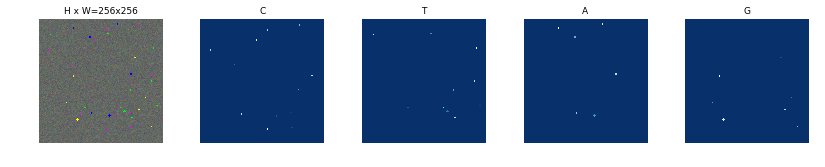

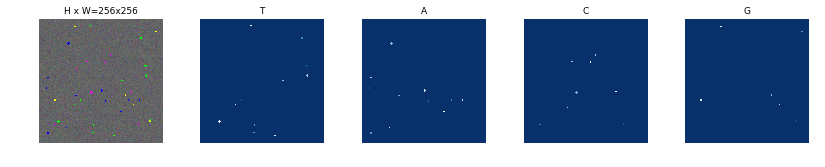

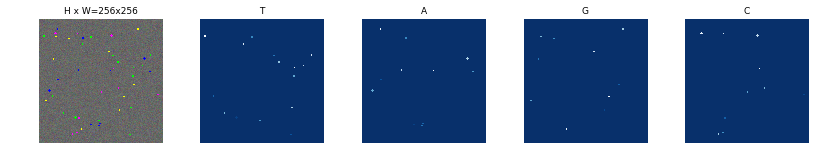

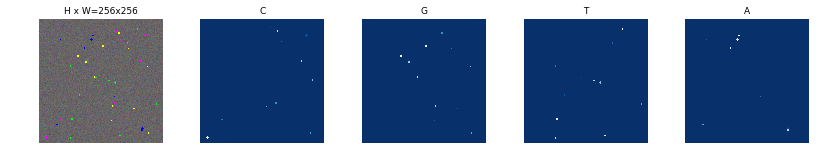

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [6]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="classification"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 160, 1024), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 160, 5), dtype=float32)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
pred_class_ids (?, 160)
target_class_ids (8, ?)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 160, 5), dtype=float32)
pred_class_ids (?, 160)
target_class_ids (?, 160)


In [12]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="classification"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids_1:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets_1/target_class_ids:0", shape=(8, ?), dtype=int32)
rois Tensor("proposal_targets_1/rois:0", shape=(8, ?, 4), dtype=float32)
shared Tensor("pool_squeeze_2/Squeeze_1:0", shape=(?, 160, 512), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_2/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
mrcnn_class_logits, mrcnn_class, mrcnn_bbox,shared Tensor("mrcnn_class_logits_2/Reshape_1:0", shape=(?, 160, 5), dtype=float32) Tensor("mrcnn_class_2/Reshape_1:0", shape=(?, 160, 5), dtype=float32) Tensor("mrcnn_bbox_2/Reshape:0", shape=(?, 160, 5, 4), dtype=float32) Tensor("pool_squeeze_2/Squeeze_1:0", shape=(?, 160, 512), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_2/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class_2/Reshape_1:0", shape=(?, 160, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits_2/Reshape_1:0", shape=

In [7]:
# Create model in training mode
config.head='def'
config.assign_label_mode ="clustering"#"clustering","classification"
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

gt_class_ids Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets/target_class_ids:0", shape=(8, ?), dtype=int32)
rois Tensor("proposal_targets/rois:0", shape=(8, ?, 4), dtype=float32)
shared Tensor("pool_squeeze/Squeeze_1:0", shape=(?, 96, 512), dtype=float32)
mrcnn_class_logits2 Tensor("Slice:0", shape=(?, 96, 4), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer:0", shape=(?, 96), dtype=int64)


/home/marziehhaghighi/.local/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mrcnn_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_ids (?, 96)
target_class_ids (?, 96)
pred_class_logits Tensor("mrcnn_class_loss/Placeholder_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_ids (?, 96)
target_class_ids (?, 96)


In [8]:
# # Create model in training mode
# config.head='def'
# config.assign_label_mode ="clustering"#"clustering","classification"
# model = modellib.MaskRCNN(mode="training", config=config,
#                           model_dir=MODEL_DIR)

In [29]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit_transform([3,2,4,3,10]).shape

(5, 4)

In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [8]:
# Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
# dataset_train.

In [22]:
# config.__dict__
model.log_dir

'/storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.0001_clust/simul_spots20200810T1432'

#### Parametrized Training

In [ ]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


model.train(dataset_train, dataset_val, 
            learning_rate=lr ,#/ 10,
            epochs=100, 
            layers=layers_to_tune)

gt_class_ids Tensor("input_gt_class_ids_1:0", shape=(?, ?), dtype=int32)
target_class_ids Tensor("proposal_targets_1/target_class_ids:0", shape=(8, ?), dtype=int32)
rois Tensor("proposal_targets_1/rois:0", shape=(8, ?, 4), dtype=float32)
shared Tensor("pool_squeeze_1/Squeeze_1:0", shape=(?, 96, 512), dtype=float32)
mrcnn_class_logits2 Tensor("Slice_1:0", shape=(?, 96, 4), dtype=float32)
pred_class_ids Tensor("pred_4_lambda_layer_1:0", shape=(?, 96), dtype=int64)
mrcnn_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
mrcnn_class Tensor("mrcnn_class_1/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_logits Tensor("mrcnn_class_logits_1/Reshape_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_ids (?, 96)
target_class_ids (?, 96)
pred_class_logits Tensor("mrcnn_class_loss_1/Placeholder_1:0", shape=(?, 96, 5), dtype=float32)
pred_class_ids (?, 96)
target_class_ids (?, 96)

Starting at epoch 0. LR=0.0001

Checkpoint Path: /storage/data/marzieh

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  1/100 [..............................] - ETA: 3:18:55 - loss: 8.1155 - rpn_class_loss: 2.0291 - rpn_bbox_loss: 3.8231 - mrcnn_class_loss: 2.2634 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - lambda_nmi: 1.0000True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  2/100 [..............................] - ETA: 1:39:25 - loss: 8.0302 - rpn_class_loss: 2.0198 - rpn_bbox_loss: 3.8214 - mrcnn_class_loss: 2.1890 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - lambda_nmi: 1.0000True Labels:  []
psudo labels:  []
(768,)
[] (0,)
[] (0,)
  3/100 [..............................] - ETA: 1:06:19 - loss: 7.8971 - rpn_class_loss: 2.0050 - rpn_bbox_loss: 3.8188 - mrcnn_class_loss: 2.0733 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - lambda_nmi: 1.0000True Labels:  [[4 1]]
psudo labels:  [[4 1]]
(768,)
[1] (1,)
[4] (1,)
  4/100 [>.............................] - ETA: 49:39 - loss: 9.4964 - rpn_

 26/100 [======>.......................] - ETA: 7:18 - loss: 9.1913 - rpn_class_loss: 1.3991 - rpn_bbox_loss: 3.6451 - mrcnn_class_loss: 0.4640 - mrcnn_bbox_loss: 3.0400 - mrcnn_mask_loss: 0.6430 - lambda_nmi: 0.6549True Labels:  [[2 5]
 [3 4]
 [4 2]]
psudo labels:  [[1 2]
 [2 3]
 [3 4]
 [4 2]]
(768,)
[2 2 2 3 1 2 4 1 4 3 2] (11,)
[3 1 3 3 3 4 4 2 2 1 2] (11,)
nmi 0.27264055446794033
 27/100 [=======>......................] - ETA: 7:00 - loss: 9.1571 - rpn_class_loss: 1.3795 - rpn_bbox_loss: 3.6337 - mrcnn_class_loss: 0.4499 - mrcnn_bbox_loss: 3.0422 - mrcnn_mask_loss: 0.6518 - lambda_nmi: 0.6407True Labels:  [[2 5]
 [3 5]
 [4 2]]
psudo labels:  [[1 2]
 [2 4]
 [3 3]
 [4 3]]
(768,)
[2 2 2 3 1 1 2 4 3 4 2 4] (12,)
[2 4 1 4 2 3 1 2 4 3 3 2] (12,)
nmi 0.396267960888887
 28/100 [=======>......................] - ETA: 6:42 - loss: 9.1180 - rpn_class_loss: 1.3606 - rpn_bbox_loss: 3.6220 - mrcnn_class_loss: 0.4374 - mrcnn_bbox_loss: 3.0388 - mrcnn_mask_loss: 0.6592 - lambda_nmi: 0.6320True Lab

 45/100 [============>.................] - ETA: 3:38 - loss: 8.0999 - rpn_class_loss: 1.0799 - rpn_bbox_loss: 3.4179 - mrcnn_class_loss: 0.3248 - mrcnn_bbox_loss: 2.5524 - mrcnn_mask_loss: 0.7248 - lambda_nmi: 0.5055True Labels:  [[ 2 12]
 [ 3  6]
 [ 4 24]]
psudo labels:  [[ 1  9]
 [ 2 15]
 [ 3  6]
 [ 4 12]]
(768,)
[2 4 4 1 4 1 1 1 1 4 3 3 4 3 2 3 2 2 2 3 3 2 4 3 4 2 3 1 1 2 2 3 2 1 1 1 1
 4 3 3 1 3] (42,)
[4 2 3 1 2 1 2 2 1 2 3 2 2 2 4 1 4 4 3 3 2 4 2 3 3 1 2 2 2 4 2 4 4 4 1 1 4
 2 1 1 4 4] (42,)
nmi 0.22671482298387322
 46/100 [============>.................] - ETA: 3:31 - loss: 8.0509 - rpn_class_loss: 1.0667 - rpn_bbox_loss: 3.4055 - mrcnn_class_loss: 0.3243 - mrcnn_bbox_loss: 2.5263 - mrcnn_mask_loss: 0.7281 - lambda_nmi: 0.4995True Labels:  [[ 2 11]
 [ 3  9]
 [ 4 26]]
psudo labels:  [[ 1 10]
 [ 2 11]
 [ 3 15]
 [ 4 10]]
(768,)
[4 2 1 4 1 4 4 3 1 3 1 1 4 2 3 2 3 2 2 1 3 3 2 4 3 2 4 2 3 1 1 2 2 1 2 2 3
 1 1 1 3 1 4 3 3 3] (46,)
[2 3 1 2 1 3 4 3 4 2 1 2 3 4 2 2 2 4 1 1 4 3 3 2 4 1 2 

 60/100 [=================>............] - ETA: 2:12 - loss: 7.4543 - rpn_class_loss: 0.9092 - rpn_bbox_loss: 3.2457 - mrcnn_class_loss: 0.3126 - mrcnn_bbox_loss: 2.2323 - mrcnn_mask_loss: 0.7546 - lambda_nmi: 0.4315True Labels:  [[ 2 29]
 [ 3  2]
 [ 4 16]]
psudo labels:  [[ 1 10]
 [ 2 18]
 [ 3  8]
 [ 4 11]]
(768,)
[4 2 1 2 2 3 1 4 3 1 3 3 2 2 2 4 3 3 3 2 1 3 2 3 2 4 2 1 2 1 2 1 1 3 1 2 1
 2 1 1 3 3 3 1 1 3 4] (47,)
[2 2 2 2 3 3 2 4 2 4 2 3 2 1 2 1 2 3 4 3 1 2 2 3 2 4 2 4 1 4 1 4 2 1 4 1 4
 2 2 4 3 2 1 4 1 3 1] (47,)
nmi 0.22559550914981383
 61/100 [=================>............] - ETA: 2:07 - loss: 7.4141 - rpn_class_loss: 0.8997 - rpn_bbox_loss: 3.2346 - mrcnn_class_loss: 0.3109 - mrcnn_bbox_loss: 2.2125 - mrcnn_mask_loss: 0.7564 - lambda_nmi: 0.4281True Labels:  [[ 2 32]
 [ 3  3]
 [ 4 17]]
psudo labels:  [[ 1 14]
 [ 2 14]
 [ 3 13]
 [ 4 11]]
(768,)
[2 1 3 2 4 3 2 1 3 4 1 4 1 3 2 3 4 3 2 2 1 2 3 1 2 3 2 4 3 3 2 2 1 2 1 2 2
 2 1 1 1 1 1 1 3 1 3 3 3 4 1 3] (52,)
[2 4 4 2 2 3 2 3 2 1 4 

 74/100 [=====================>........] - ETA: 1:16 - loss: 7.0093 - rpn_class_loss: 0.7998 - rpn_bbox_loss: 3.1127 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 2.0245 - mrcnn_mask_loss: 0.7742 - lambda_nmi: 0.3924True Labels:  [[ 1 20]
 [ 2 12]
 [ 3 10]
 [ 4 18]]
psudo labels:  [[ 1 20]
 [ 2 11]
 [ 3 10]
 [ 4 19]]
(768,)
[2 1 1 2 3 1 3 1 1 1 4 3 3 2 3 4 1 1 3 1 3 2 2 4 2 1 3 1 1 1 2 3 3 3 4 3 3
 3 4 2 4 3 2 1 2 3 3 1 3 1 3 2 4 1 2 4 1 2 1 1] (60,)
[3 4 4 3 2 4 2 1 4 3 2 2 4 4 1 4 4 1 4 4 1 3 3 1 3 1 4 1 1 4 3 4 2 2 1 1 2
 2 1 3 1 1 3 2 1 1 2 2 4 4 1 1 3 4 1 1 1 4 4 4] (60,)
nmi 0.22309307378977752
 75/100 [=====================>........] - ETA: 1:12 - loss: 6.9809 - rpn_class_loss: 0.7932 - rpn_bbox_loss: 3.1038 - mrcnn_class_loss: 0.2969 - mrcnn_bbox_loss: 2.0118 - mrcnn_mask_loss: 0.7752 - lambda_nmi: 0.3902True Labels:  [[ 1 20]
 [ 2 11]
 [ 3  9]
 [ 4 18]]
psudo labels:  [[ 1 17]
 [ 2 16]
 [ 3 10]
 [ 4 15]]
(768,)
[1 1 1 3 3 2 1 2 2 3 3 1 1 1 3 1 2 1 3 4 1 3 1 3 1 3 1 3 2 3 4 1 2

 88/100 [=========================>....] - ETA: 32s - loss: 6.6210 - rpn_class_loss: 0.7170 - rpn_bbox_loss: 2.9916 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 1.8431 - mrcnn_mask_loss: 0.7832 - lambda_nmi: 0.3701True Labels:  [[ 1 10]
 [ 2 18]
 [ 3 17]
 [ 4 19]]
psudo labels:  [[ 1 15]
 [ 2 26]
 [ 3 13]
 [ 4 10]]
(768,)
[1 1 2 1 3 1 1 3 1 3 3 3 1 4 2 1 1 3 1 1 1 1 3 1 1 3 1 2 1 2 1 3 3 1 3 3 4
 4 3 1 3 2 2 4 2 3 3 4 3 1 3 4 3 2 1 2 1 1 1 2 1 1 4 2] (64,)
[1 2 3 3 2 1 4 2 1 2 2 2 2 3 3 1 1 2 1 4 4 4 2 1 4 2 4 3 2 3 4 2 2 1 2 2 1
 1 2 1 2 3 3 1 3 2 2 2 2 2 2 1 2 3 1 3 3 3 1 2 4 4 4 2] (64,)
nmi 0.4488408734120102
 89/100 [=========================>....] - ETA: 29s - loss: 6.5936 - rpn_class_loss: 0.7118 - rpn_bbox_loss: 2.9834 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 1.8296 - mrcnn_mask_loss: 0.7835 - lambda_nmi: 0.3710True Labels:  [[ 1 10]
 [ 2 19]
 [ 3 19]
 [ 4 19]]
psudo labels:  [[ 1  7]
 [ 2 27]
 [ 3 17]
 [ 4 16]]
(768,)
[2 1 1 2 1 1 2 3 3 1 1 3 4 1 3 3 1 1 3 3 1 1 1 1 1 2 

True Labels:  [[ 1 14]
 [ 2 39]
 [ 3 14]
 [ 4 11]]
psudo labels:  [[ 1 26]
 [ 2 16]
 [ 3  9]
 [ 4 27]]
(768,)
[1 3 4 4 3 3 2 2 3 4 3 3 1 4 3 4 3 2 4 1 4 1 3 4 1 1 1 1 2 3 2 3 1 1 3 3 4
 1 4 1 4 3 3 2 3 3 1 2 2 4 4 4 2 2 2 2 3 3 4 1 2 1 3 3 4 1 1 3 1 2 1 3 2 1
 2 3 2 3] (78,)
[1 3 2 2 3 4 1 1 3 2 4 4 4 2 4 2 4 4 2 1 2 1 4 2 1 1 1 4 1 4 1 4 4 4 3 4 2
 4 2 4 2 3 4 1 3 3 1 1 1 1 2 1 1 1 1 1 4 3 2 4 1 1 3 4 2 1 4 2 4 1 4 2 1 4
 4 4 1 4] (78,)
nmi 0.5140386285107077
True Labels:  [[ 1 14]
 [ 2 39]
 [ 3 14]
 [ 4 11]]
psudo labels:  [[ 1 27]
 [ 2 16]
 [ 3  9]
 [ 4 26]]
(768,)
[1 3 3 2 2 3 3 4 4 3 2 4 1 4 4 1 3 4 3 4 3 2 1 3 1 3 1 1 4 1 2 1 3 1 4 1 4
 3 1 3 1 3 4 2 3 2 4 3 4 4 3 2 2 3 2 2 3 2 3 4 4 3 1 1 2 1 1 1 2 3 3 3 3 1
 2 1 2 2] (78,)
[4 1 3 1 1 3 3 2 2 1 1 2 4 2 2 4 1 2 4 2 1 2 4 1 2 1 1 4 1 4 2 4 1 1 1 4 2
 3 4 1 4 1 2 1 3 4 2 3 4 2 3 1 4 4 4 4 3 1 1 2 4 3 4 4 1 4 4 4 4 1 1 1 1 4
 2 4 1 1] (78,)
nmi 0.3873245483489895
True Labels:  [[ 1 14]
 [ 2 39]
 [ 3 14]
 [ 4 11]]
psudo labels:  [[ 1

 10/100 [==>...........................] - ETA: 1:53 - loss: 4.1378 - rpn_class_loss: 0.2223 - rpn_bbox_loss: 2.1972 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.7533 - mrcnn_mask_loss: 0.7469 - lambda_nmi: 0.3233True Labels:  [[ 1 11]
 [ 2 21]
 [ 3 17]
 [ 4 28]]
psudo labels:  [[ 1 15]
 [ 2 29]
 [ 3 11]
 [ 4 22]]
(768,)
[2 1 1 4 2 1 4 1 3 2 4 1 2 1 1 3 3 4 3 4 4 2 2 4 4 3 2 1 4 2 3 1 1 1 4 2 4
 1 1 4 2 4 3 1 1 1 4 2 1 1 1 4 3 4 1 1 4 4 1 4 1 2 1 4 2 2 1 2 4 4 2 3 1 1
 1 1 2] (77,)
[1 1 1 4 1 4 2 4 2 1 2 3 1 3 3 2 2 2 2 2 2 2 1 2 4 2 1 4 4 4 4 4 2 4 4 1 2
 4 4 2 2 2 2 3 2 4 2 1 3 3 4 4 3 2 3 3 2 4 3 4 4 2 2 2 1 1 4 1 2 2 1 3 4 4
 2 2 1] (77,)
nmi 0.3334893726516393
 11/100 [==>...........................] - ETA: 1:51 - loss: 4.1312 - rpn_class_loss: 0.2210 - rpn_bbox_loss: 2.1925 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.7495 - mrcnn_mask_loss: 0.7482 - lambda_nmi: 0.3242True Labels:  [[ 1 11]
 [ 2 23]
 [ 3 16]
 [ 4 28]]
psudo labels:  [[ 1 27]
 [ 2 14]
 [ 3 21]
 [ 4 16]]
(768

 22/100 [=====>........................] - ETA: 1:45 - loss: 4.0093 - rpn_class_loss: 0.2083 - rpn_bbox_loss: 2.1390 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.6818 - mrcnn_mask_loss: 0.7497 - lambda_nmi: 0.3591True Labels:  [[ 1 29]
 [ 2 28]
 [ 3  6]
 [ 4 21]]
psudo labels:  [[ 1 21]
 [ 2 17]
 [ 3  7]
 [ 4 39]]
(768,)
[2 1 1 1 4 4 1 2 2 1 3 4 1 4 2 4 3 4 3 3 3 4 2 2 3 3 4 2 2 4 1 1 1 4 2 3 1
 1 4 1 4 1 2 4 4 3 4 2 1 1 4 4 1 2 3 1 4 1 4 4 1 4 4 4 3 1 4 4 1 2 4 1 2 3
 2 4 1 2 1 2 2 2 1 4] (84,)
[1 4 4 4 2 2 4 1 1 4 4 2 1 2 1 2 1 2 1 4 1 2 1 1 1 1 2 1 4 3 1 4 4 4 4 4 4
 4 2 4 2 4 4 4 2 4 2 1 2 4 1 2 4 4 4 4 4 1 2 4 1 3 3 3 2 4 3 3 4 4 4 4 1 4
 1 2 4 4 4 1 4 4 4 3] (84,)
nmi 0.3111416904591686
 23/100 [=====>........................] - ETA: 1:44 - loss: 3.9967 - rpn_class_loss: 0.2073 - rpn_bbox_loss: 2.1340 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.6751 - mrcnn_mask_loss: 0.7496 - lambda_nmi: 0.3570True Labels:  [[ 1 29]
 [ 2 28]
 [ 3  7]
 [ 4 22]]
psudo labels:  [[ 1 17]
 [ 2

 33/100 [========>.....................] - ETA: 1:31 - loss: 4.0129 - rpn_class_loss: 0.2101 - rpn_bbox_loss: 2.1257 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.6868 - mrcnn_mask_loss: 0.7508 - lambda_nmi: 0.3657True Labels:  [[ 1 32]
 [ 2 23]
 [ 3 23]
 [ 4 29]]
psudo labels:  [[ 1 35]
 [ 2 16]
 [ 3 28]
 [ 4 28]]
(768,)
[2 2 3 4 2 3 1 2 4 1 4 2 3 4 2 3 3 3 3 1 3 3 3 4 4 1 4 1 3 4 4 1 1 1 1 4 3
 4 4 2 3 4 2 4 2 2 1 3 3 1 1 3 2 1 1 3 3 2 1 3 1 3 4 2 1 2 2 4 1 4 2 1 3 4
 1 2 2 3 2 3 3 4 1 2 3 2 2 2 1 3 4 3 1 3 1 2 3 1 3 1 3 3 4 3 1 2 2] (107,)
[1 1 3 2 3 3 4 3 2 4 1 3 3 1 1 3 3 3 2 4 1 3 3 2 2 4 2 1 3 4 1 4 1 4 4 1 4
 4 2 1 3 2 1 2 1 1 4 1 3 4 4 3 1 4 4 1 3 1 4 1 4 3 2 1 4 1 1 2 4 2 1 4 3 1
 4 1 1 1 1 3 3 2 4 1 3 1 1 1 4 3 2 3 4 3 4 1 3 4 3 4 3 3 2 2 4 1 1] (107,)
nmi 0.5839628766133582
 34/100 [=========>....................] - ETA: 1:29 - loss: 4.0172 - rpn_class_loss: 0.2108 - rpn_bbox_loss: 2.1264 - mrcnn_class_loss: 0.2400 - mrcnn_bbox_loss: 0.6889 - mrcnn_mask_loss: 0.7511 - lam

 43/100 [===========>..................] - ETA: 1:17 - loss: 4.0486 - rpn_class_loss: 0.2144 - rpn_bbox_loss: 2.1244 - mrcnn_class_loss: 0.2589 - mrcnn_bbox_loss: 0.7008 - mrcnn_mask_loss: 0.7501 - lambda_nmi: 0.4031True Labels:  [[ 1 32]
 [ 2 42]
 [ 3 32]
 [ 4 28]]
psudo labels:  [[ 1 36]
 [ 2 42]
 [ 3 26]
 [ 4 30]]
(768,)
[2 2 3 4 4 3 2 2 1 4 2 3 2 4 1 4 2 2 3 3 1 3 3 4 1 3 4 1 3 3 1 3 3 4 1 4 4
 1 4 2 2 1 3 4 2 1 2 4 1 3 3 2 4 1 1 4 3 1 3 4 2 1 1 4 1 3 1 3 1 3 1 4 3 1
 2 4 3 2 1 3 3 1 4 1 3 2 1 2 4 2 3 2 2 2 4 3 4 2 2 2 1 1 3 2 3 3 3 1 2 3 2
 1 1 4 3 1 3 4 3 2 1 2 3 3 1 2 3 1 3 1 3 3 2 3] (134,)
[2 1 3 3 2 2 1 1 4 2 1 2 2 2 4 3 1 1 2 3 4 2 1 2 2 2 2 2 2 3 4 2 3 2 4 2 2
 4 2 1 1 4 3 2 1 4 1 2 4 1 3 1 2 4 4 2 3 4 3 2 1 4 4 2 4 3 2 1 4 1 4 2 3 4
 1 2 1 1 4 3 1 4 2 4 3 1 4 1 2 1 3 1 1 1 2 3 2 1 1 1 4 4 3 1 3 3 2 4 1 3 1
 4 4 2 3 4 3 2 2 1 4 1 3 3 4 1 2 2 2 2 3 3 1 2] (134,)
nmi 0.6245385424111405
 44/100 [============>.................] - ETA: 1:16 - loss: 4.0462 - rpn_class_loss: 0.214

 52/100 [==============>...............] - ETA: 1:05 - loss: 4.0341 - rpn_class_loss: 0.2143 - rpn_bbox_loss: 2.1132 - mrcnn_class_loss: 0.2689 - mrcnn_bbox_loss: 0.6899 - mrcnn_mask_loss: 0.7477 - lambda_nmi: 0.4412True Labels:  [[ 1 37]
 [ 2 37]
 [ 3 32]
 [ 4 39]]
psudo labels:  [[ 1 31]
 [ 2 30]
 [ 3 41]
 [ 4 43]]
(768,)
[4 4 4 3 3 4 1 2 3 1 2 3 2 4 2 1 2 4 4 4 3 3 3 1 3 1 1 4 4 3 1 1 3 3 3 2 4
 3 2 4 4 4 1 1 3 4 4 3 2 1 2 3 1 1 2 4 4 1 1 4 1 3 3 1 3 4 1 1 4 1 2 1 2 1
 4 3 3 1 3 1 2 3 1 2 3 2 3 4 2 1 4 4 1 4 1 2 3 2 2 2 3 3 2 4 1 2 2 4 2 2 4
 3 3 2 2 1 2 3 3 3 1 3 1 3 1 3 4 2 3 3 1 2 3 1 1 2 2 3 3 2 1 3 1 3 4] (145,)
[3 3 3 2 3 3 4 1 2 4 1 2 1 4 3 2 1 4 3 4 4 4 3 3 3 4 4 3 4 3 3 3 4 2 4 1 4
 2 1 3 4 2 4 4 4 4 2 2 1 4 1 2 4 4 1 2 4 4 4 2 4 3 4 3 2 3 4 3 3 3 1 3 1 4
 3 2 2 4 2 4 1 2 4 1 2 3 4 4 1 4 4 3 3 3 3 1 3 1 1 1 2 4 1 3 3 1 1 3 1 1 3
 2 2 1 1 3 1 2 2 2 4 3 3 2 3 2 3 1 2 4 3 1 4 3 4 1 1 2 2 1 4 4 3 2 4] (145,)
nmi 0.45235972103459987
 53/100 [==============>...............] - ETA

 61/100 [=================>............] - ETA: 53s - loss: 4.0078 - rpn_class_loss: 0.2115 - rpn_bbox_loss: 2.0980 - mrcnn_class_loss: 0.2748 - mrcnn_bbox_loss: 0.6790 - mrcnn_mask_loss: 0.7445 - lambda_nmi: 0.4760True Labels:  [[ 1 36]
 [ 2 32]
 [ 3 44]
 [ 4 38]]
psudo labels:  [[ 1 43]
 [ 2 28]
 [ 3 32]
 [ 4 47]]
(768,)
[3 2 3 3 4 4 1 3 3 4 4 3 3 4 4 2 1 3 3 4 4 3 1 4 4 4 2 1 2 3 2 2 4 3 2 2 4
 3 1 2 3 2 3 2 3 2 1 2 2 1 4 3 2 3 2 2 1 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 2 1
 2 4 1 4 4 1 1 3 2 4 4 4 1 3 4 4 1 1 1 4 1 4 2 1 3 2 1 1 2 2 4 1 4 4 1 4 4
 4 4 4 3 2 1 1 1 1 1 1 2 2 1 4 2 1 2 3 2 1 2 1 1 2 2 1 3 4 1 1 4 4 4 3 1 3
 4 4] (150,)
[2 1 4 2 4 3 4 2 2 3 3 2 2 4 3 1 3 2 2 3 3 2 4 1 3 3 1 3 1 2 1 1 3 2 1 1 3
 4 4 1 4 1 2 1 1 1 4 1 1 4 2 4 1 2 1 1 4 3 2 2 4 2 2 2 4 1 2 1 2 2 1 4 1 3
 1 1 4 4 4 4 4 2 1 3 3 4 4 2 3 1 4 4 4 3 4 3 1 4 1 1 4 3 1 1 2 4 3 3 4 4 3
 3 3 2 4 1 4 4 4 3 4 4 1 1 4 3 1 4 1 2 1 4 1 4 4 1 1 4 4 3 4 3 1 3 4 2 4 1
 3 3] (150,)
nmi 0.539278018301347
 62/100 [=================>

 69/100 [===================>..........] - ETA: 42s - loss: 4.0016 - rpn_class_loss: 0.2068 - rpn_bbox_loss: 2.0878 - mrcnn_class_loss: 0.2851 - mrcnn_bbox_loss: 0.6808 - mrcnn_mask_loss: 0.7410 - lambda_nmi: 0.4912True Labels:  [[ 1 45]
 [ 2 32]
 [ 3 49]
 [ 4 43]]
psudo labels:  [[ 1 40]
 [ 2 36]
 [ 3 22]
 [ 4 71]]
(768,)
[3 2 4 3 4 4 4 3 2 3 4 3 4 1 4 1 3 3 4 3 2 1 4 2 3 2 4 4 1 4 4 2 3 4 3 2 3
 4 4 2 3 2 3 2 2 3 2 3 2 2 2 2 2 2 3 1 3 1 2 2 2 1 4 1 2 3 2 1 2 2 3 3 3 4
 3 1 3 4 3 4 3 2 3 3 3 3 3 3 1 3 1 1 1 4 1 4 1 3 3 4 3 4 1 1 1 4 4 4 1 4 4
 4 1 1 4 4 3 4 4 1 1 2 1 4 2 1 2 4 4 1 3 1 1 2 1 2 1 1 3 1 1 2 2 1 3 2 1 2
 1 4 2 1 2 2 1 1 4 1 4 2 1 3 3 1 4 4 2 4 4] (169,)
[2 1 4 2 3 3 4 2 1 2 3 2 4 4 4 4 2 2 4 2 1 4 3 1 4 1 3 3 4 4 4 1 2 3 2 1 2
 4 4 1 2 1 4 1 1 2 1 2 1 1 1 1 1 1 2 4 2 4 1 1 1 4 4 4 1 2 1 4 1 1 2 2 2 4
 2 4 2 4 4 4 2 1 2 2 2 2 2 2 4 4 4 4 4 3 4 4 4 2 2 3 2 4 4 4 4 3 3 4 4 3 3
 3 4 4 3 3 4 4 3 4 4 1 4 4 1 4 1 4 4 4 2 4 4 1 4 1 4 4 2 4 4 1 1 4 2 1 4 1
 4 3 1 4 1 1 4 4 3 4 3 1

 77/100 [======================>.......] - ETA: 31s - loss: 3.9818 - rpn_class_loss: 0.2021 - rpn_bbox_loss: 2.0737 - mrcnn_class_loss: 0.2953 - mrcnn_bbox_loss: 0.6733 - mrcnn_mask_loss: 0.7373 - lambda_nmi: 0.5029True Labels:  [[ 1 38]
 [ 2 37]
 [ 3 47]
 [ 4 49]]
psudo labels:  [[ 1 15]
 [ 2 30]
 [ 3 32]
 [ 4 94]]
(768,)
[1 3 3 3 2 3 4 4 3 4 3 4 4 2 3 2 4 4 4 2 4 4 2 2 2 1 4 4 4 3 2 3 3 2 1 4 3
 1 3 3 3 3 3 3 4 1 2 2 3 2 2 4 1 2 1 2 1 2 2 3 3 2 2 2 2 3 2 1 1 2 4 1 3 2
 4 3 3 1 3 3 3 3 4 3 3 3 4 3 3 3 3 4 3 1 4 4 1 1 3 4 4 1 4 4 4 4 4 1 4 1 1
 1 4 4 2 1 1 2 1 1 4 4 3 3 4 1 1 1 1 1 4 2 2 1 4 2 3 2 1 1 2 1 4 2 2 3 1 4
 1 2 2 2 1 3 1 2 1 2 1 1 4 3 3 1 3 3 4 1 4 4 4] (171,)
[3 2 2 2 1 4 4 3 4 3 2 3 3 4 2 4 4 4 4 4 3 3 4 4 4 4 3 3 4 4 4 2 2 4 4 3 2
 4 4 2 4 2 2 2 4 3 1 1 2 1 1 4 4 1 3 4 4 4 1 4 2 4 1 4 4 2 4 3 4 4 4 4 2 4
 4 4 2 4 2 2 2 4 4 2 4 4 4 2 4 2 2 4 2 4 3 3 4 3 2 3 4 4 3 4 3 4 3 3 4 3 4
 4 4 4 4 4 3 1 4 3 4 3 4 4 4 4 3 4 4 4 3 4 1 4 3 1 2 1 4 4 1 4 3 1 4 2 4 3
 4 4 4 1 4 2 4 4 4 4

 85/100 [========================>.....] - ETA: 20s - loss: 3.9557 - rpn_class_loss: 0.1975 - rpn_bbox_loss: 2.0561 - mrcnn_class_loss: 0.3066 - mrcnn_bbox_loss: 0.6614 - mrcnn_mask_loss: 0.7341 - lambda_nmi: 0.5060True Labels:  [[ 1 34]
 [ 2 35]
 [ 3 35]
 [ 4 82]]
psudo labels:  [[ 1 42]
 [ 2 22]
 [ 3 63]
 [ 4 59]]
(768,)
[1 3 4 3 2 2 1 4 4 4 3 3 4 3 3 3 2 2 2 4 2 1 4 4 1 4 2 2 3 1 3 3 4 3 2 4 4
 4 2 3 3 3 4 3 3 4 1 4 2 1 2 3 1 2 2 2 2 4 1 4 2 1 2 2 2 1 3 1 2 3 2 4 3 3
 2 3 3 4 3 4 3 3 2 3 3 2 3 3 3 1 3 3 1 4 1 4 4 1 4 4 1 4 3 3 1 4 2 1 1 4 4
 3 4 3 1 4 4 1 1 1 1 4 1 1 3 1 2 4 1 4 1 2 3 4 3 1 4 2 2 1 4 3 1 4 2 4 2 2
 2 1 3 4 4 1 3 2 2 1 2 1 2 2 2 1 4 1 1 2 2 2 1 1 3 1 4 4 3 4 4 2 4 4 3 1 4
 3] (186,)
[4 2 3 3 1 1 4 4 3 4 3 3 4 2 2 3 1 1 1 3 1 4 3 3 4 3 1 1 2 4 3 2 3 2 1 3 3
 3 1 2 2 2 3 3 3 3 4 4 1 4 1 2 4 1 1 1 1 3 4 3 1 4 1 1 1 4 2 4 1 2 3 3 2 3
 1 3 2 3 2 3 3 3 1 3 3 1 2 3 3 4 3 3 4 3 4 3 4 4 3 4 4 3 2 2 4 3 1 4 4 3 4
 3 3 2 4 3 3 4 4 4 4 4 4 4 3 4 3 4 4 4 4 1 3 3 2 4 3 1 1 4 3 3 4

 93/100 [==========================>...] - ETA: 9s - loss: 3.9270 - rpn_class_loss: 0.1932 - rpn_bbox_loss: 2.0394 - mrcnn_class_loss: 0.3140 - mrcnn_bbox_loss: 0.6492 - mrcnn_mask_loss: 0.7312 - lambda_nmi: 0.5195 True Labels:  [[ 1 28]
 [ 2 37]
 [ 3 37]
 [ 4 74]]
psudo labels:  [[ 1 41]
 [ 2 55]
 [ 3 37]
 [ 4 43]]
(768,)
[1 3 4 4 1 1 3 3 1 4 1 2 4 4 4 1 4 1 4 3 3 4 4 2 2 3 1 3 1 3 3 4 2 4 3 2 3
 3 4 2 3 4 1 3 1 3 4 3 3 4 1 1 1 1 1 1 1 1 1 1 1 4 1 2 1 4 1 2 4 2 2 3 3 2
 1 3 2 1 1 3 2 4 1 1 1 1 4 3 2 1 3 3 3 1 2 2 3 1 1 4 1 1 4 4 1 3 3 3 2 4 1
 1 2 3 3 4 4 4 1 3 4 3 4 4 3 4 3 1 4 3 1 3 1 3 1 3 3 3 1 1 1 3 2 1 3 1 2 2
 1 2 2 2 3 4 1 1 1 1 3 3 1 4 1 4 3 1 2 1 4 4 3 1 4 2 2 2] (176,)
[1 2 3 3 4 1 2 2 4 3 1 4 3 3 3 4 3 1 3 2 2 3 3 4 1 4 4 2 1 2 2 3 4 3 2 1 2
 2 3 1 2 3 4 2 1 2 3 2 2 3 2 1 4 1 4 4 1 4 1 1 1 3 1 1 4 3 4 1 3 1 4 2 2 4
 1 2 1 1 4 2 4 3 4 4 4 4 2 2 1 1 2 2 2 4 4 1 2 1 4 3 4 4 3 2 4 2 2 2 4 3 1
 4 1 2 2 3 3 3 4 2 3 2 3 3 2 3 2 4 3 2 1 2 4 2 4 2 2 2 1 4 4 2 1 1 2 4 4 1
 2 1 1 1 2

True Labels:  [[ 1 38]
 [ 2 70]
 [ 3 44]
 [ 4 58]]
psudo labels:  [[  1 102]
 [  2  26]
 [  3  36]
 [  4  46]]
(768,)
[3 2 2 3 1 4 2 3 1 2 3 3 1 4 3 3 1 2 3 3 3 1 4 4 2 3 2 4 3 3 4 1 4 1 4 4 3
 3 4 4 3 1 4 3 2 1 4 1 3 2 3 3 2 4 2 1 3 4 1 3 4 1 1 1 4 1 1 4 3 1 2 4 3 3
 1 4 2 1 2 1 2 3 3 1 1 3 1 1 1 4 3 1 1 2 4 1 3 3 1 1 1 4 4 3 1 2 2 1 4 1 3
 4 3 4 2 4 2 1 4 2 4 3 3 3 1 1 2 3 3 3 3 4 1 3 3 2 3 4 4 4 3 2 3 1 2 3 2 3
 2 3 4 2 2 2 1 4 1 1 2 1 3 4 1 1 1 1 3 1 1 1 4 4 3 4 3 1 4 4 4 4 4 3 1 3 1
 2 3 3 4 2 4 1 3 1 4 3 3 1 3 4 1 3 4 3 2 3 3 1 1 3] (210,)
[2 1 1 2 4 3 1 1 4 1 1 1 4 3 1 1 4 1 1 1 1 4 3 3 1 1 1 3 2 3 3 1 3 1 3 3 2
 1 3 3 1 1 3 1 1 1 3 1 1 1 1 1 1 1 1 4 2 1 1 1 1 4 4 4 1 1 4 3 1 4 1 1 1 1
 4 1 1 4 1 4 1 2 2 4 4 1 4 4 1 1 2 4 4 1 3 4 1 2 1 4 4 3 1 1 1 1 1 4 3 4 2
 1 2 1 1 3 1 4 3 1 3 1 2 2 4 4 1 2 1 2 2 3 1 1 1 1 2 3 1 1 2 1 3 4 1 2 1 1
 1 2 3 1 1 1 4 1 4 4 1 1 1 1 4 1 4 4 2 4 4 4 1 3 2 3 1 1 3 1 1 3 1 2 4 2 4
 1 2 1 3 1 3 4 1 4 3 2 1 4 1 3 4 1 3 3 1 1 3 4 4 1] (210,)
nmi 0.50837843

  4/100 [>.............................] - ETA: 2:20 - loss: 3.7138 - rpn_class_loss: 0.1447 - rpn_bbox_loss: 1.8785 - mrcnn_class_loss: 0.4075 - mrcnn_bbox_loss: 0.5796 - mrcnn_mask_loss: 0.7035 - lambda_nmi: 0.6385True Labels:  [[ 1 39]
 [ 2 50]
 [ 3 40]
 [ 4 59]]
psudo labels:  [[ 1 46]
 [ 2 55]
 [ 3 45]
 [ 4 42]]
(768,)
[1 4 4 4 1 1 3 1 2 2 4 4 1 3 1 4 4 4 1 1 2 4 3 4 3 3 1 3 1 2 1 3 3 3 4 4 3
 4 3 4 4 3 2 2 2 1 3 1 4 1 1 4 4 3 1 1 1 3 1 4 3 4 3 3 3 1 1 1 4 2 4 1 2 3
 1 4 4 1 1 1 4 1 2 3 2 3 1 1 2 1 3 2 2 2 3 1 4 3 2 1 4 3 3 4 2 4 3 1 1 4 1
 1 3 1 1 3 4 1 1 2 1 3 4 3 4 3 4 3 4 3 4 4 1 3 3 2 3 3 3 3 3 1 2 3 1 2 3 1
 3 2 3 1 2 1 1 1 1 4 2 1 4 3 4 1 1 1 4 1 4 3 2 1 2 3 2 3 4 3 2 1 3 4 3 2 2
 2 4 2] (188,)
[4 3 3 3 4 1 2 1 1 1 3 3 4 2 1 3 3 3 4 4 1 3 2 3 2 2 4 2 4 1 4 2 2 2 3 3 2
 3 2 3 3 2 1 1 1 1 2 4 3 4 4 3 3 2 4 4 4 2 4 3 2 3 2 2 2 4 1 1 3 1 3 1 2 2
 4 3 3 4 4 4 3 4 1 2 2 2 1 1 1 1 2 1 1 1 2 1 3 2 1 4 3 2 2 3 1 3 2 4 4 3 4
 4 2 4 1 2 3 1 4 1 1 2 3 2 3 2 3 2 3 2 3 3 4 2 2 1 2 2 2 2 

 11/100 [==>...........................] - ETA: 2:10 - loss: 3.5951 - rpn_class_loss: 0.1415 - rpn_bbox_loss: 1.8538 - mrcnn_class_loss: 0.3649 - mrcnn_bbox_loss: 0.5330 - mrcnn_mask_loss: 0.7018 - lambda_nmi: 0.6924True Labels:  [[ 1 43]
 [ 2 57]
 [ 3 45]
 [ 4 65]]
psudo labels:  [[ 1 50]
 [ 2 44]
 [ 3 59]
 [ 4 57]]
(768,)
[4 1 2 3 1 4 3 2 1 1 1 3 4 3 3 4 1 1 3 4 1 4 1 2 1 4 3 3 4 1 4 4 2 3 4 3 2
 2 3 3 3 4 4 3 4 4 1 3 3 1 1 3 1 1 4 1 3 1 1 4 3 1 1 4 1 3 3 3 1 1 4 1 2 2
 1 1 3 2 1 2 2 1 1 4 2 4 3 4 2 2 3 1 1 3 1 2 4 2 1 4 4 2 4 4 4 2 3 4 1 1 3
 1 4 4 2 3 3 1 2 3 3 4 4 1 1 2 1 1 1 4 4 2 2 3 1 3 3 4 3 4 3 3 3 4 1 1 1 4
 4 3 4 2 1 3 3 1 1 1 1 2 3 3 1 3 3 2 4 2 1 1 2 4 3 4 1 3 1 1 1 1 2 4 4 3 2
 1 1 4 1 2 3 1 4 3 4 2 1 1 2 2 3 4 2 1 2 4 3 3 1 4] (210,)
[3 4 1 2 4 3 2 1 4 2 4 3 3 2 2 3 4 1 3 3 4 3 4 1 4 3 2 2 3 1 3 3 1 2 3 2 1
 1 2 1 2 3 3 2 3 3 4 2 2 1 4 2 4 4 3 4 2 1 4 3 3 4 4 3 1 2 2 2 4 4 3 1 1 1
 4 4 2 1 4 1 1 4 4 3 1 3 2 3 1 1 2 4 4 3 4 1 3 1 4 3 3 1 3 3 3 1 2 3 4 4 2
 1 3 3 1 1 2 4 

 18/100 [====>.........................] - ETA: 2:01 - loss: 3.5292 - rpn_class_loss: 0.1382 - rpn_bbox_loss: 1.8297 - mrcnn_class_loss: 0.3659 - mrcnn_bbox_loss: 0.4969 - mrcnn_mask_loss: 0.6985 - lambda_nmi: 0.7257True Labels:  [[ 1 36]
 [ 2 61]
 [ 3 45]
 [ 4 76]]
psudo labels:  [[ 1 37]
 [ 2 92]
 [ 3 28]
 [ 4 61]]
(768,)
[3 1 2 4 4 1 3 1 4 1 3 2 4 3 2 1 4 1 4 1 3 1 4 1 4 2 1 2 3 3 1 2 3 3 4 4 3
 4 3 2 3 2 4 3 3 1 3 1 3 4 1 3 4 4 3 3 1 1 3 4 1 1 1 3 1 3 1 1 3 2 1 1 1 4
 1 2 2 3 2 4 2 4 1 4 2 2 1 4 1 2 3 1 1 1 3 1 2 4 1 3 2 1 1 1 4 3 3 3 1 1 1
 3 4 3 1 1 4 2 2 3 4 1 4 4 1 3 3 4 4 1 1 2 1 2 4 4 2 3 4 4 1 4 1 3 2 1 3 4
 1 3 3 3 1 3 3 4 4 3 4 1 2 4 3 1 1 2 1 2 1 3 3 3 3 2 2 4 3 3 1 3 1 1 3 1 4
 1 1 1 4 3 2 4 4 1 2 1 4 2 1 4 2 1 2 3 1 4 2 2 1 3 1 2 3 1 3 1 4 1] (218,)
[2 2 1 3 3 4 2 4 3 4 2 1 2 2 1 2 3 2 2 4 2 4 3 4 3 1 4 1 2 2 2 1 2 2 2 3 2
 3 2 1 2 1 3 2 2 4 2 4 2 3 4 2 2 3 2 2 2 4 2 3 4 4 2 2 4 2 4 4 2 1 4 4 2 3
 2 1 1 2 1 2 1 2 4 2 1 1 4 2 4 1 2 4 4 4 2 4 1 3 4 2 1 4 4 4 2 2 2 2 4 4 4

nmi 0.7227994896227692
 25/100 [======>.......................] - ETA: 1:50 - loss: 3.5296 - rpn_class_loss: 0.1370 - rpn_bbox_loss: 1.8209 - mrcnn_class_loss: 0.3846 - mrcnn_bbox_loss: 0.4899 - mrcnn_mask_loss: 0.6971 - lambda_nmi: 0.7336True Labels:  [[ 1 52]
 [ 2 81]
 [ 3 44]
 [ 4 49]]
psudo labels:  [[ 1 72]
 [ 2 39]
 [ 3 46]
 [ 4 69]]
(768,)
[4 1 1 3 3 4 4 3 4 1 4 3 3 4 3 3 2 2 2 2 4 3 2 2 3 1 2 4 4 3 4 4 2 4 4 1 3
 2 2 4 1 4 2 3 3 2 4 2 2 3 3 3 2 4 3 3 4 2 3 2 2 4 1 3 2 2 3 3 2 4 3 3 2 1
 2 3 2 4 3 3 3 2 1 3 2 3 1 1 3 1 3 2 2 2 4 3 1 1 2 4 3 3 2 4 4 4 3 1 1 2 1
 2 3 3 2 3 3 1 1 1 1 1 3 1 3 3 4 3 3 3 4 1 4 4 4 3 4 2 1 3 3 1 2 3 3 1 1 2
 1 2 4 1 1 3 2 3 1 2 2 1 4 4 2 1 1 2 1 2 3 3 1 1 2 3 4 4 3 4 3 3 3 4 3 3 3
 3 3 3 4 2 3 2 4 2 3 2 4 1 1 4 3 2 4 1 3 4 1 1 1 4 4 4 3 4 1 4 3 3 3 3 4 4
 3 4 1 3] (226,)
[3 4 4 2 1 4 3 2 4 4 3 2 4 4 2 1 1 1 1 4 3 2 4 1 2 4 4 3 4 4 3 3 1 3 3 1 2
 1 1 3 4 3 1 1 2 4 3 1 1 1 2 1 1 3 1 2 3 1 1 1 1 3 4 1 4 1 2 2 1 4 4 4 4 4
 1 1 1 3 2 1 1 1 4 2 1 1 1 4 2 4 2

 32/100 [========>.....................] - ETA: 1:38 - loss: 3.5576 - rpn_class_loss: 0.1390 - rpn_bbox_loss: 1.8370 - mrcnn_class_loss: 0.3869 - mrcnn_bbox_loss: 0.4991 - mrcnn_mask_loss: 0.6957 - lambda_nmi: 0.7422True Labels:  [[ 1 71]
 [ 2 28]
 [ 3 93]
 [ 4 49]]
psudo labels:  [[ 1 54]
 [ 2 45]
 [ 3 61]
 [ 4 81]]
(768,)
[4 2 1 3 2 3 1 1 2 1 2 4 3 4 2 4 2 3 4 2 3 4 3 2 3 3 4 3 4 1 3 2 3 4 2 3 2
 4 4 4 1 2 4 2 3 4 4 4 3 4 4 2 4 2 1 3 2 4 2 2 1 1 2 1 2 3 4 3 2 2 3 2 3 2
 4 4 3 4 2 3 3 4 3 3 3 3 4 2 4 2 4 1 2 1 2 4 1 1 4 2 1 3 1 1 3 3 2 4 3 3 1
 2 2 3 3 2 2 3 4 2 3 3 3 4 1 1 1 2 4 2 1 3 4 3 1 3 3 4 1 1 1 3 4 3 4 3 1 3
 1 4 1 1 3 1 3 3 2 2 1 1 3 1 2 3 1 2 1 1 3 4 1 4 4 1 3 1 1 2 2 1 3 1 2 4 3
 2 4 3 3 4 3 4 3 1 4 3 3 2 4 3 3 3 4 2 3 4 3 3 3 3 2 2 3 4 3 2 4 2 4 2 1 4
 1 3 1 1 4 1 4 3 3 4 2 4 3 4 3 1 1 4 4] (241,)
[3 1 4 2 1 2 4 4 1 4 1 3 2 3 1 3 1 4 3 1 2 3 2 1 4 2 3 2 3 4 2 1 4 3 1 2 1
 3 3 3 4 1 3 1 4 3 3 3 2 3 3 1 3 1 4 2 1 3 1 1 4 4 1 4 1 4 3 2 1 1 4 1 4 1
 3 3 4 3 1 2 2 3 4 4 2 4 3 

 38/100 [==========>...................] - ETA: 1:29 - loss: 3.5551 - rpn_class_loss: 0.1391 - rpn_bbox_loss: 1.8388 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.6935 - lambda_nmi: 0.7565True Labels:  [[ 1 51]
 [ 2 84]
 [ 3 56]
 [ 4 55]]
psudo labels:  [[ 1 54]
 [ 2 85]
 [ 3 54]
 [ 4 53]]
(768,)
[3 2 2 1 2 4 2 3 3 2 2 2 1 2 3 4 4 4 3 4 1 2 3 4 3 1 2 3 1 4 3 3 3 4 3 4 2
 4 4 1 2 1 2 3 4 2 3 1 4 2 4 2 2 4 4 4 4 4 4 4 2 4 3 1 3 2 3 4 3 3 3 4 2 2
 2 2 3 2 2 4 2 3 1 4 3 2 1 3 2 3 3 2 3 4 3 1 2 4 4 3 1 3 1 3 2 3 2 2 2 3 3
 1 3 2 4 2 4 1 2 3 1 3 1 4 3 3 1 3 4 3 1 1 1 1 2 4 3 4 1 2 3 3 1 4 1 3 3 2
 3 2 1 3 4 3 4 4 1 1 2 1 4 1 3 1 1 2 1 3 1 1 3 3 1 4 3 3 1 3 3 3 3 1 1 1 4
 4 2 2 2 3 1 3 3 1 2 4 3 4 3 3 3 4 3 2 4 3 4 3 3 2 3 3 3 3 4 1 3 1 1 4 4 3
 1 3 3 2 2 2 3 4 3 2 1 1 3 3 1 1 3 4 1 4 2 4 4 1] (246,)
[2 1 1 4 1 3 1 2 2 1 1 1 4 1 2 3 3 3 2 3 4 1 2 3 2 4 1 2 4 3 2 2 2 2 2 3 1
 3 3 4 1 4 1 2 3 1 2 4 3 1 3 1 1 3 3 3 3 3 3 3 1 3 2 4 2 1 2 3 2 2 2 3 1 1
 1 1 2 1 1 3 1 2 

 44/100 [============>.................] - ETA: 1:20 - loss: 3.5350 - rpn_class_loss: 0.1383 - rpn_bbox_loss: 1.8340 - mrcnn_class_loss: 0.3848 - mrcnn_bbox_loss: 0.4862 - mrcnn_mask_loss: 0.6917 - lambda_nmi: 0.7738True Labels:  [[ 1 62]
 [ 2 76]
 [ 3 56]
 [ 4 52]]
psudo labels:  [[  1  62]
 [  2  31]
 [  3 102]
 [  4  51]]
(768,)
[2 3 2 4 4 1 2 3 3 2 3 2 4 2 1 2 3 4 1 4 1 1 2 3 4 2 3 4 3 3 3 3 1 4 1 3 2
 1 4 3 4 1 4 4 2 4 4 4 4 2 3 3 2 2 4 2 2 4 4 4 3 4 3 4 4 2 3 4 2 2 3 4 2 2
 3 4 3 2 2 3 4 3 2 1 4 2 3 3 2 2 3 3 2 2 1 4 3 2 3 2 4 2 2 4 2 2 4 3 3 3 3
 2 3 3 2 1 1 1 3 3 3 1 3 4 1 3 3 1 4 3 4 1 1 3 4 1 3 3 4 1 3 4 2 2 3 1 1 3
 4 3 1 2 1 2 1 1 1 1 1 1 1 4 3 2 2 1 3 1 1 4 4 1 2 3 1 1 4 4 2 1 3 3 2 1 2
 4 4 3 2 4 2 3 2 2 3 3 3 3 1 1 2 2 3 3 3 3 3 4 2 3 3 3 4 4 3 4 3 2 4 3 2 2
 1 1 4 3 2 1 3 1 4 4 1 1 3 3 1 4 1 2 2 2 4 4 1 2] (246,)
[1 2 1 3 3 4 1 2 3 1 2 1 3 1 4 1 2 3 4 3 4 4 1 3 3 1 2 3 2 3 2 3 4 3 4 2 1
 4 3 3 3 4 3 3 1 3 3 3 3 1 2 3 1 1 3 1 1 3 3 3 2 3 3 3 3 1 2 3 1 1 3 3 1 1
 3 3 3 1 

 50/100 [==============>...............] - ETA: 1:12 - loss: 3.5065 - rpn_class_loss: 0.1372 - rpn_bbox_loss: 1.8250 - mrcnn_class_loss: 0.3781 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.6905 - lambda_nmi: 0.7849True Labels:  [[ 1 59]
 [ 2 80]
 [ 3 55]
 [ 4 54]]
psudo labels:  [[ 1 59]
 [ 2 84]
 [ 3 52]
 [ 4 53]]
(768,)
[4 3 4 2 1 4 3 2 2 2 1 4 1 3 2 3 1 3 3 4 3 3 3 2 2 4 3 2 4 2 2 4 4 3 4 1 4
 4 1 4 3 3 4 4 2 2 1 4 1 2 4 3 1 4 2 2 4 3 1 2 3 2 4 3 3 2 2 3 2 2 3 2 2 3
 4 4 3 3 2 1 3 4 2 3 2 2 2 4 1 4 2 3 4 3 1 2 1 2 1 2 1 4 3 3 3 3 3 2 4 1 2
 1 3 3 3 3 3 2 4 3 3 4 4 3 2 3 2 3 1 1 3 4 1 4 4 1 1 3 4 3 4 1 1 3 4 3 1 3
 3 1 2 3 2 1 4 2 2 1 4 1 3 4 1 3 4 3 3 3 1 3 2 3 4 1 1 1 1 1 4 3 1 2 2 1 1
 1 2 4 3 2 3 3 1 3 2 2 3 2 1 3 4 2 3 3 3 3 3 3 3 3 2 2 4 4 3 3 3 1 3 2 3 1
 1 4 3 3 2 2 3 3 2 2 4 1 2 1 1 4 1 1 4 3 4 2 1 4 3 1] (248,)
[3 2 3 1 4 3 2 1 1 1 4 3 4 2 1 2 4 2 2 3 2 2 2 1 1 3 2 1 3 1 1 3 3 2 3 4 3
 3 4 3 2 2 3 3 1 1 4 3 4 1 3 2 4 3 1 1 3 2 4 1 2 1 3 2 2 1 1 2 1 1 2 1 1 2
 3 3 2 2 1 4 

 56/100 [===============>..............] - ETA: 1:03 - loss: 3.4653 - rpn_class_loss: 0.1361 - rpn_bbox_loss: 1.8133 - mrcnn_class_loss: 0.3626 - mrcnn_bbox_loss: 0.4644 - mrcnn_mask_loss: 0.6889 - lambda_nmi: 0.8052True Labels:  [[ 1 56]
 [ 2 55]
 [ 3 60]
 [ 4 58]]
psudo labels:  [[ 1 54]
 [ 2 58]
 [ 3 59]
 [ 4 58]]
(768,)
[1 1 1 2 1 3 2 1 4 4 4 3 2 4 1 3 2 3 2 2 2 4 4 3 4 2 3 2 3 3 2 1 3 3 2 1 2
 3 2 1 3 2 3 3 2 1 4 4 2 4 4 3 4 2 1 2 2 2 4 4 3 4 2 3 4 2 4 1 3 4 1 2 4 3
 1 2 4 3 2 4 3 1 2 1 3 4 3 4 4 2 2 3 1 2 2 4 3 2 2 1 2 3 2 3 3 3 4 3 2 3 4
 2 2 2 3 2 3 1 1 1 2 2 1 1 2 4 1 1 1 4 4 2 1 1 3 4 3 4 2 1 3 4 4 4 4 3 1 2
 1 4 4 1 2 3 1 2 1 3 1 3 1 4 1 4 1 1 1 4 4 1 1 1 1 4 2 1 1 3 2 4 1 4 4 2 2
 3 3 3 3 1 3 3 1 4 3 3 2 4 3 3 3 4 4 3 4 2 2 4 1 1 1 4 3 3 4 4 4 1 1 4 1 3
 1 1 3 1 4 3 4] (229,)
[4 4 4 1 4 2 1 4 3 3 3 2 1 3 4 2 1 2 1 1 1 3 3 2 3 1 2 1 2 2 1 4 2 2 1 4 1
 2 1 4 2 1 2 2 1 4 3 3 1 3 3 2 3 1 4 1 1 1 3 3 2 3 1 2 3 1 3 4 2 3 4 1 3 2
 4 1 3 2 1 3 2 4 1 4 2 3 2 3 3 1 1 2 4 1 1 3 2 1 1 

 63/100 [=================>............] - ETA: 53s - loss: 3.4377 - rpn_class_loss: 0.1353 - rpn_bbox_loss: 1.7982 - mrcnn_class_loss: 0.3509 - mrcnn_bbox_loss: 0.4656 - mrcnn_mask_loss: 0.6877 - lambda_nmi: 0.8188True Labels:  [[ 1 55]
 [ 2 52]
 [ 3 65]
 [ 4 55]]
psudo labels:  [[ 1 54]
 [ 2 67]
 [ 3 64]
 [ 4 42]]
(768,)
[1 1 2 2 3 4 2 4 4 3 3 3 3 2 4 2 4 1 2 1 3 2 3 2 2 4 3 3 1 2 1 2 3 2 2 3 1
 4 2 3 4 1 1 1 1 2 4 2 1 4 2 3 2 4 4 2 4 3 3 3 4 3 3 2 4 3 4 1 2 1 2 1 2 4
 4 2 2 2 3 3 4 3 4 4 4 4 2 2 4 1 1 2 2 2 4 3 2 3 3 2 4 2 2 4 2 2 3 2 3 3 4
 4 3 2 1 1 1 2 4 2 3 3 3 2 1 1 1 4 4 4 1 4 1 4 2 1 4 2 4 1 1 1 4 2 4 3 4 1
 3 3 4 3 1 1 1 2 1 1 4 4 1 2 1 4 1 4 3 1 1 1 4 4 3 4 3 3 4 1 3 3 2 3 1 2 4
 4 4 4 2 4 2 1 4 2 1 1 1 4 3 4 4 1 3 2 4 1 3 3 1 3 2 4 4 2 1 4 4 4 4 1 4 3
 1 1 3 1 4] (227,)
[4 2 1 1 2 3 1 3 3 2 2 2 2 1 2 1 3 2 1 4 2 1 2 1 1 3 2 2 2 1 2 1 2 2 1 2 4
 3 1 2 3 2 4 4 4 1 3 1 2 3 1 2 1 3 3 1 3 2 2 2 3 2 2 1 3 2 3 4 1 4 1 4 1 3
 3 1 1 1 2 2 3 2 3 3 3 3 1 1 3 4 4 1 1 1 3 2 1 2 2 1 3 1

 70/100 [====================>.........] - ETA: 43s - loss: 3.4066 - rpn_class_loss: 0.1337 - rpn_bbox_loss: 1.7811 - mrcnn_class_loss: 0.3440 - mrcnn_bbox_loss: 0.4611 - mrcnn_mask_loss: 0.6866 - lambda_nmi: 0.8217True Labels:  [[ 1 54]
 [ 2 50]
 [ 3 67]
 [ 4 49]]
psudo labels:  [[ 1 56]
 [ 2 50]
 [ 3 67]
 [ 4 47]]
(768,)
[2 1 4 2 2 4 2 3 2 3 2 2 4 3 3 4 1 2 3 3 1 1 2 3 4 2 1 4 2 4 2 4 4 1 3 4 2
 4 4 4 3 2 2 2 4 2 3 4 2 4 1 2 3 3 2 4 3 2 4 4 2 1 2 2 1 4 1 4 4 3 1 2 2 2
 2 2 4 2 4 2 4 3 2 4 4 1 3 4 4 3 3 1 1 4 3 2 3 2 2 2 3 3 2 4 2 2 2 4 3 3 2
 2 3 4 2 4 4 1 3 1 1 4 1 4 1 4 1 4 2 4 2 3 1 1 1 1 2 1 1 3 4 4 3 1 1 4 1 2
 4 1 1 4 4 1 1 2 2 1 2 3 4 1 3 4 3 2 2 4 2 1 1 3 4 1 3 4 1 3 4 3 4 3 4 4 4
 3 1 3 4 1 3 3 2 4 1 4 4 1 3 3 4 3 3 2 4 3 2 4 1 3 1 1 3 4 1 4 1 4 4 1] (220,)
[1 4 3 1 1 3 1 2 1 2 1 1 3 2 2 3 4 1 2 2 4 4 1 2 3 1 4 3 1 3 1 3 3 4 2 3 1
 3 3 3 2 1 1 1 3 1 2 3 1 3 4 1 2 2 1 3 2 1 3 3 1 4 1 1 4 3 4 3 3 2 4 1 1 1
 1 1 3 1 3 1 3 2 1 3 3 4 2 3 3 2 2 4 4 3 2 1 2 1 1 1 2 2 1 3 1 1 1 3 2 

 77/100 [======================>.......] - ETA: 32s - loss: 3.3848 - rpn_class_loss: 0.1319 - rpn_bbox_loss: 1.7630 - mrcnn_class_loss: 0.3475 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.6858 - lambda_nmi: 0.8156True Labels:  [[ 1 52]
 [ 2 51]
 [ 3 63]
 [ 4 59]]
psudo labels:  [[  1  43]
 [  2  34]
 [  3 110]
 [  4  38]]
(768,)
[2 1 2 2 1 2 2 4 4 4 1 3 3 2 2 2 4 1 3 1 2 3 4 2 4 1 2 2 2 3 3 2 4 4 2 4 3
 4 3 2 1 4 3 1 4 1 3 2 1 2 1 4 2 2 4 4 2 3 2 4 3 1 4 3 2 4 1 2 1 1 4 1 2 2
 1 4 2 4 2 2 3 1 4 4 3 4 3 4 4 2 1 2 4 2 2 3 2 1 1 2 2 2 4 2 3 2 3 3 2 3 2
 3 4 2 4 2 1 4 4 1 4 1 3 3 4 1 2 3 1 4 4 4 1 1 1 2 1 1 2 2 3 3 4 1 1 4 3 4
 1 1 1 1 1 1 1 4 4 1 4 1 1 2 4 1 3 1 3 2 4 3 4 4 3 3 4 2 3 3 4 2 1 4 2 2 1
 3 3 1 3 1 4 1 3 1 1 3 3 1 1 3 4 3 4 4 4 4 2 1 1 1 1 4 2 3 3 4 4 1 1 4 3 2
 1 4 3] (225,)
[1 2 2 2 2 1 1 3 3 3 2 3 3 1 2 1 3 2 3 2 1 3 3 2 3 2 1 1 2 3 3 1 3 3 1 3 3
 3 3 2 2 3 3 2 3 4 3 1 2 2 4 3 1 1 3 3 2 3 1 3 3 4 3 3 1 3 4 1 4 4 3 4 1 1
 4 3 1 3 1 1 3 4 3 3 3 3 3 3 3 1 2 1 3 1 1 3 2 4 4 2

 84/100 [========================>.....] - ETA: 22s - loss: 3.3673 - rpn_class_loss: 0.1300 - rpn_bbox_loss: 1.7445 - mrcnn_class_loss: 0.3555 - mrcnn_bbox_loss: 0.4521 - mrcnn_mask_loss: 0.6852 - lambda_nmi: 0.8058True Labels:  [[ 1 50]
 [ 2 53]
 [ 3 66]
 [ 4 62]]
psudo labels:  [[ 1 47]
 [ 2 98]
 [ 3 34]
 [ 4 52]]
(768,)
[4 1 2 1 3 2 3 3 2 2 1 2 2 2 3 3 4 3 4 4 2 3 2 2 1 2 2 2 1 4 3 1 4 1 4 4 2
 4 4 3 4 2 3 2 1 1 4 2 1 4 3 2 1 3 2 4 4 3 2 4 3 2 2 2 4 2 4 2 4 1 4 1 4 2
 1 1 4 3 3 2 4 2 1 2 1 1 1 3 4 2 2 4 2 2 3 2 2 2 2 2 3 3 4 2 1 2 3 2 4 3 2
 3 3 4 1 2 2 1 1 1 1 1 1 2 3 4 1 1 4 1 4 4 2 1 4 2 1 4 3 1 4 3 1 1 1 1 4 4
 1 2 4 3 3 4 4 1 1 1 1 1 4 4 4 1 1 1 2 4 1 2 1 4 1 1 2 1 3 4 1 1 4 3 2 2 3
 4 2 3 4 4 1 3 4 4 3 4 3 4 3 2 4 4 3 4 1 1 1 2 1 1 1 3 3 4 3 1 2 4 3 4 4 3
 2 3 4 4 1 4 3 1 4] (231,)
[3 4 2 4 2 1 2 2 1 1 4 1 1 1 2 2 4 2 3 2 1 2 1 1 4 1 2 1 2 4 2 4 3 4 2 2 1
 3 2 2 4 1 2 2 4 4 4 1 4 3 2 1 2 2 1 2 4 2 1 3 2 1 1 1 4 1 3 1 3 4 2 2 3 1
 2 2 3 2 2 2 4 2 2 2 4 2 4 2 3 2 2 3 1 1 2 1 1 1

 91/100 [==========================>...] - ETA: 12s - loss: 3.3576 - rpn_class_loss: 0.1297 - rpn_bbox_loss: 1.7354 - mrcnn_class_loss: 0.3573 - mrcnn_bbox_loss: 0.4513 - mrcnn_mask_loss: 0.6840 - lambda_nmi: 0.7973True Labels:  [[ 1 47]
 [ 2 61]
 [ 3 76]
 [ 4 59]]
psudo labels:  [[ 1 50]
 [ 2 51]
 [ 3 80]
 [ 4 62]]
(768,)
[1 1 1 1 3 1 1 1 2 3 1 2 1 2 1 3 4 4 2 3 1 4 4 1 1 2 4 3 1 4 4 3 1 2 1 1 1
 1 3 2 4 2 1 1 3 1 2 3 4 2 4 2 1 4 3 3 3 3 3 4 4 4 1 4 3 2 1 3 2 3 3 3 4 1
 2 1 1 2 2 2 1 4 3 3 2 1 3 3 1 1 4 2 4 3 1 1 1 4 3 3 2 1 4 3 2 4 4 3 1 4 3
 4 2 2 4 3 1 1 3 2 4 4 2 4 1 1 2 3 4 4 4 3 1 2 4 1 4 2 4 4 1 1 3 2 1 2 4 4
 2 2 1 1 4 4 2 2 1 2 2 2 4 4 3 1 4 4 1 3 2 2 4 2 4 3 4 4 4 1 2 2 4 4 4 4 3
 4 2 1 2 4 2 2 1 4 2 3 1 3 1 4 1 1 1 1 4 1 1 4 4 3 2 1 1 4 1 4 1 2 4 2 3 4
 4 4 2 4 4 1 4 2 4 1 1 3 4 2 3 2 1 3 3 2 4] (243,)
[4 4 4 4 2 4 4 4 1 2 4 1 4 1 4 2 3 3 1 2 4 3 3 4 4 1 3 2 4 3 3 2 4 1 4 4 4
 4 2 1 3 1 4 4 2 4 1 2 3 1 3 1 4 3 2 2 2 2 2 3 3 3 4 3 2 1 4 2 1 2 2 2 3 4
 1 4 4 1 1 3 3 3 2 2 1 4

 97/100 [============================>.] - ETA: 4s - loss: 3.3581 - rpn_class_loss: 0.1300 - rpn_bbox_loss: 1.7321 - mrcnn_class_loss: 0.3598 - mrcnn_bbox_loss: 0.4535 - mrcnn_mask_loss: 0.6827 - lambda_nmi: 0.7940True Labels:  [[ 1 53]
 [ 2 46]
 [ 3 80]
 [ 4 69]]
psudo labels:  [[ 1 49]
 [ 2 91]
 [ 3 46]
 [ 4 62]]
(768,)
[1 1 3 3 4 1 1 1 2 1 2 4 4 2 1 2 1 1 3 4 3 4 1 1 4 4 2 4 2 2 4 3 4 1 4 2 1
 3 3 4 1 3 2 1 2 4 1 1 2 3 4 3 3 3 3 2 1 4 1 3 4 1 3 2 4 3 1 1 1 2 2 4 1 4
 2 2 3 1 1 2 1 1 4 1 2 3 3 2 4 4 3 3 3 2 4 4 1 2 4 4 4 2 3 4 3 3 3 2 4 3 2
 3 1 1 3 2 4 1 3 1 3 1 3 4 1 1 1 2 4 2 4 4 1 4 1 4 4 4 3 2 2 4 2 2 3 1 4 4
 1 1 3 4 4 1 3 4 2 1 1 4 1 4 4 4 4 2 3 3 1 1 2 2 4 4 4 2 4 4 1 2 4 4 2 4 4
 4 1 1 4 2 3 1 2 1 1 3 1 4 4 4 3 4 1 4 1 1 2 1 4 1 1 1 2 1 2 1 2 2 4 1 2 4
 2 4 3 4 3 4 4 4 2 3 4 2 2 2 1 4 4 4 1 1 3 4 4 3 1 3] (248,)
[4 4 2 2 3 4 4 4 1 4 1 2 3 1 4 1 4 4 2 2 2 2 4 4 2 2 1 3 1 1 2 2 3 4 3 1 4
 2 2 3 4 2 1 4 1 3 4 4 1 2 3 2 2 2 2 1 4 2 4 2 3 2 2 1 3 2 4 4 4 1 1 3 4 2
 1 1 2 4 4 1 4 

True Labels:  [[ 1 42]
 [ 2 88]
 [ 3 66]
 [ 4 48]]
psudo labels:  [[ 1 99]
 [ 2 29]
 [ 3 67]
 [ 4 49]]
(768,)
[2 3 2 3 3 1 3 4 4 2 3 2 3 1 3 1 3 2 3 2 4 1 3 3 4 3 3 3 4 1 4 3 3 4 3 3 1
 4 3 4 1 4 1 4 4 3 3 4 2 2 3 4 3 4 3 1 2 1 2 1 4 4 1 4 2 2 3 4 4 2 4 3 3 4
 1 1 1 3 1 2 4 4 1 3 4 1 2 4 3 1 3 1 1 2 1 4 3 3 1 2 4 4 3 3 4 3 4 3 3 4 1
 3 2 2 1 1 3 4 1 1 1 2 3 2 3 3 2 4 3 4 1 4 2 3 4 4 3 4 2 3 4 2 2 3 3 3 1 3
 2 4 2 3 3 2 4 2 1 2 3 1 2 4 4 2 4 3 4 2 4 1 2 3 4 4 4 2 1 2 3 3 3 2 1 1 4
 3 1 3 3 3 4 1 2 4 3 1 1 3 4 4 3 3 4 4 4 4 1 1 3 1 3 4 3 3 3 3 4 3 2 4 1 4
 3 3 1 4 1 3 4 1 3 1 3 3 3 3 2 3 3 4 4 3 2 3] (244,)
[1 1 1 1 1 4 2 3 3 1 1 1 1 4 2 4 1 1 1 1 3 4 1 2 3 1 2 1 3 4 3 2 1 3 1 1 4
 3 1 3 4 3 4 3 3 1 1 3 1 1 1 3 1 3 2 4 1 4 1 4 3 3 4 3 1 1 1 3 3 1 3 1 1 3
 4 4 4 1 4 1 3 3 4 2 3 4 1 3 1 4 2 4 4 1 4 3 2 1 4 1 3 3 2 2 3 2 3 1 1 3 4
 1 1 1 4 4 2 3 4 4 4 1 1 1 2 1 1 3 1 3 4 3 1 2 3 3 1 3 1 1 3 1 1 2 1 1 4 2
 1 3 1 1 1 1 3 1 4 1 2 4 1 3 3 1 3 1 3 1 3 4 1 1 3 3 3 1 4 1 2 1 1 1 4 4 3
 1 4 2 2 2 3

  5/100 [>.............................] - ETA: 2:25 - loss: 3.2354 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 1.6220 - mrcnn_class_loss: 0.3693 - mrcnn_bbox_loss: 0.4489 - mrcnn_mask_loss: 0.6659 - lambda_nmi: 0.7312True Labels:  [[ 1 50]
 [ 2 85]
 [ 3 53]
 [ 4 60]]
psudo labels:  [[  1  33]
 [  2  51]
 [  3  61]
 [  4 103]]
(768,)
[3 4 1 2 1 3 2 1 4 1 2 3 1 1 4 3 1 1 1 1 1 3 1 1 1 4 4 4 4 4 2 4 3 4 4 4 4
 2 2 3 1 1 2 1 1 2 3 4 3 3 1 4 3 3 1 3 4 3 2 2 2 1 1 4 3 3 4 4 2 3 1 2 2 1
 1 3 4 4 3 2 3 3 4 3 3 3 3 2 3 2 1 1 1 2 3 3 3 2 2 2 3 4 1 2 2 3 2 2 3 1 4
 3 1 3 1 4 3 3 4 4 2 4 1 4 2 3 4 1 1 3 1 3 2 2 4 2 4 1 3 1 2 2 4 1 1 3 3 4
 4 4 4 1 2 4 2 3 4 3 4 3 2 4 4 2 4 2 2 1 1 4 1 1 4 4 4 4 1 3 2 4 4 4 3 4 2
 2 1 2 4 4 1 4 1 2 1 3 3 4 1 4 1 4 2 1 4 2 1 2 1 1 2 2 4 1 4 1 1 4 3 4 4 2
 4 4 4 4 2 3 4 3 1 1 1 4 4 3 1 4 3 1 2 4 3 2 4 3 2 1] (248,)
[2 3 4 1 4 2 1 4 4 4 4 2 4 4 3 2 4 4 4 4 4 2 4 4 4 3 3 3 3 3 1 4 4 3 3 3 3
 1 4 2 4 4 4 4 4 1 2 3 2 2 4 4 4 2 4 2 3 2 4 1 1 4 4 3 2 2 4 3 4 2 4 4 1 4
 4 2 

 11/100 [==>...........................] - ETA: 2:08 - loss: 3.1529 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 1.6066 - mrcnn_class_loss: 0.3338 - mrcnn_bbox_loss: 0.4228 - mrcnn_mask_loss: 0.6623 - lambda_nmi: 0.8066True Labels:  [[ 1 50]
 [ 2 57]
 [ 3 72]
 [ 4 69]]
psudo labels:  [[ 1 46]
 [ 2 62]
 [ 3 69]
 [ 4 71]]
(768,)
[4 1 2 2 4 1 1 4 3 1 4 4 4 1 1 4 2 1 1 1 1 3 2 4 4 1 1 3 1 3 1 3 1 4 2 4 3
 3 2 1 3 1 1 4 4 4 3 2 3 3 2 1 4 3 3 1 3 1 3 4 3 2 3 4 1 1 1 4 3 2 1 3 2 3
 1 2 2 2 1 2 1 2 2 3 4 4 4 3 3 3 3 1 1 3 2 3 1 1 1 2 3 4 3 4 3 4 3 4 4 4 2
 3 3 4 3 1 4 2 1 3 2 3 3 3 3 1 4 1 4 2 4 1 2 4 2 1 4 2 2 3 1 2 3 2 1 2 4 4
 4 1 1 3 2 4 1 4 3 4 3 4 4 4 4 1 1 1 3 2 1 4 3 4 4 4 2 2 3 3 2 4 2 1 1 1 4
 2 3 1 1 1 1 1 4 1 1 4 4 4 1 4 4 2 1 1 1 1 1 1 2 4 2 4 4 2 2 3 3 3 4 4 3 3
 2 2 4 4 2 4 1 3 2 1 3 3 2 4 4 4 3 3 2 1 2 4 1 4 1 1] (248,)
[3 4 1 1 3 4 4 3 2 4 3 3 3 4 4 3 1 4 4 4 4 2 1 3 3 4 4 2 4 2 4 2 4 3 1 3 2
 2 1 4 2 4 4 3 3 3 2 1 2 2 1 4 3 2 2 4 2 4 2 3 2 1 2 3 4 4 4 3 2 1 4 2 1 2
 4 1 1 1 4 1 

 17/100 [====>.........................] - ETA: 1:57 - loss: 3.0989 - rpn_class_loss: 0.1256 - rpn_bbox_loss: 1.5906 - mrcnn_class_loss: 0.3165 - mrcnn_bbox_loss: 0.4049 - mrcnn_mask_loss: 0.6613 - lambda_nmi: 0.8333True Labels:  [[ 1 57]
 [ 2 56]
 [ 3 75]
 [ 4 60]]
psudo labels:  [[ 1 51]
 [ 2 63]
 [ 3 73]
 [ 4 61]]
(768,)
[2 1 4 1 3 1 2 4 3 4 1 1 3 1 3 1 3 1 3 1 1 2 1 1 1 3 4 4 2 2 4 4 3 1 1 4 4
 1 3 4 2 3 3 4 3 1 4 1 1 4 3 2 4 1 3 2 1 1 3 1 4 4 3 3 3 2 4 2 1 3 2 1 3 1
 1 2 3 1 3 4 1 1 3 3 3 4 3 2 4 1 3 2 2 3 3 2 3 2 3 4 4 4 3 2 4 2 3 3 2 1 3
 2 4 2 4 4 4 4 1 3 2 3 3 1 4 2 1 3 1 2 1 4 2 1 2 4 4 2 4 4 1 3 3 1 4 2 2 1
 4 4 2 2 2 4 3 1 2 3 2 3 1 2 2 2 4 1 1 2 4 4 4 2 3 1 1 4 4 2 4 2 4 4 1 4 3
 2 2 3 1 3 1 2 2 4 1 3 4 2 2 1 2 4 1 2 3 3 1 1 4 1 1 1 4 4 4 4 1 4 4 2 1 2
 2 4 1 1 3 4 3 4 2 3 4 4 4 3 1 3 2 4 4 2 4 3 4 4 3 3] (248,)
[1 4 3 4 2 4 1 3 2 3 4 4 2 4 2 4 2 4 2 4 4 1 4 4 4 2 3 3 1 1 3 3 2 4 4 3 3
 4 2 3 1 2 2 3 2 4 3 4 4 3 2 1 3 4 2 1 4 4 2 4 3 3 2 2 2 1 3 1 4 2 1 4 2 4
 4 1 2 4 2 3 

 23/100 [=====>........................] - ETA: 1:49 - loss: 3.0889 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 1.5830 - mrcnn_class_loss: 0.3154 - mrcnn_bbox_loss: 0.4059 - mrcnn_mask_loss: 0.6612 - lambda_nmi: 0.8423True Labels:  [[ 1 48]
 [ 2 63]
 [ 3 64]
 [ 4 73]]
psudo labels:  [[ 1 74]
 [ 2 65]
 [ 3 38]
 [ 4 71]]
(768,)
[2 3 4 1 3 4 4 1 3 1 1 3 1 1 3 1 3 1 4 3 3 4 1 1 2 4 3 4 2 4 4 2 4 1 1 2 4
 4 3 3 4 2 4 3 1 2 4 3 2 1 3 2 4 4 3 1 3 1 4 4 4 3 2 1 4 1 1 4 4 1 1 2 3 1
 4 1 1 1 1 4 1 4 4 1 2 4 3 2 4 2 2 1 3 4 2 4 3 3 4 1 3 1 4 2 3 1 1 4 4 3 4
 4 2 2 4 2 1 3 3 4 4 2 1 2 1 3 4 3 1 3 2 2 4 1 3 4 3 2 3 3 3 3 1 1 3 3 3 1
 1 1 3 4 3 1 2 1 4 1 1 4 1 1 1 1 4 4 4 2 4 4 2 3 1 4 4 4 4 1 3 4 4 1 1 1 3
 1 4 2 2 1 2 3 3 1 2 4 4 3 2 2 4 3 1 2 1 2 4 3 1 4 3 2 2 1 2 2 2 1 1 4 2 2
 3 2 4 2 3 4 1 2 4 3 2 4 3 4 3 1 1 2 3 4 1 1 4 3 2 3] (248,)
[1 2 3 4 2 3 1 4 2 4 4 2 4 4 2 4 2 4 1 2 2 1 4 4 1 1 2 1 1 1 3 1 3 4 4 1 2
 2 2 2 3 1 3 2 4 1 3 2 1 4 2 1 1 2 2 4 2 4 2 1 3 2 1 4 3 4 4 3 3 4 4 1 2 4
 3 4 4 4 4 3 

 29/100 [=======>......................] - ETA: 1:40 - loss: 3.0951 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 1.5761 - mrcnn_class_loss: 0.3250 - mrcnn_bbox_loss: 0.4106 - mrcnn_mask_loss: 0.6622 - lambda_nmi: 0.8374True Labels:  [[ 1 55]
 [ 2 85]
 [ 3 32]
 [ 4 76]]
psudo labels:  [[  1 108]
 [  2  19]
 [  3  45]
 [  4  76]]
(768,)
[3 1 1 4 3 1 1 2 3 4 1 1 1 1 2 3 4 2 3 4 1 4 3 4 1 1 1 2 1 3 2 4 2 3 3 2 3
 2 2 2 3 1 4 3 4 1 4 1 1 4 2 3 3 4 2 3 4 4 4 1 1 1 4 1 2 4 2 1 1 2 4 1 1 1
 1 3 3 3 1 1 2 3 2 1 2 1 2 1 1 1 1 4 4 2 4 3 2 1 4 3 3 3 1 4 3 2 1 4 2 2 1
 4 1 2 4 4 4 4 4 4 3 2 1 2 1 1 1 3 2 4 1 3 3 2 2 3 1 4 4 3 2 1 1 3 1 3 1 4
 4 1 2 1 1 3 3 1 1 3 3 2 4 1 1 4 3 4 4 4 1 1 4 4 2 4 3 4 4 4 4 1 4 1 4 1 4
 4 3 4 2 2 2 1 2 2 2 3 3 2 4 2 2 3 1 2 4 1 1 2 4 1 4 2 2 2 4 2 3 4 4 1 1 3
 2 1 2 1 4 1 4 3 4 3 2 4 4 3 3 4 1 2 2 1 3 2 2 3 1 1] (248,)
[1 4 4 2 1 4 4 1 1 3 4 4 4 4 1 1 2 1 1 3 4 3 1 3 4 4 4 1 4 1 1 3 1 1 1 1 1
 1 1 1 1 4 3 1 3 4 3 4 4 3 1 1 1 2 1 1 2 3 4 4 4 4 3 4 1 3 1 4 4 1 3 4 4 4
 4 1 

 35/100 [=========>....................] - ETA: 1:31 - loss: 3.0837 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 1.5666 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.6623 - lambda_nmi: 0.8346True Labels:  [[ 1 50]
 [ 2 78]
 [ 3 48]
 [ 4 72]]
psudo labels:  [[ 1 81]
 [ 2 68]
 [ 3 27]
 [ 4 72]]
(768,)
[1 4 1 2 3 3 1 1 3 2 1 3 4 3 1 4 1 3 4 4 3 2 3 1 1 4 1 1 1 1 2 4 3 4 1 2 1
 1 4 3 2 4 1 4 1 4 3 3 4 4 1 1 1 2 3 4 2 4 4 4 3 2 4 1 1 1 3 2 2 2 1 3 1 1
 2 2 1 2 1 1 4 1 1 2 3 4 1 1 4 4 4 4 2 1 3 4 4 4 2 3 4 1 4 3 4 3 1 2 2 4 1
 4 3 2 4 2 4 2 4 3 2 4 1 4 2 3 2 3 3 1 3 2 4 3 1 3 2 2 1 4 3 1 3 1 2 4 4 1
 3 1 3 2 3 4 1 1 1 4 4 1 4 1 2 4 4 4 1 4 4 3 1 4 1 1 4 1 4 4 4 4 3 1 4 4 1
 3 4 4 2 2 3 1 4 4 4 1 2 4 2 2 2 2 1 2 2 3 3 2 4 2 2 1 3 3 3 1 2 3 4 1 4 3
 1 1 4 4 4 2 3 4 3 3 3 3 2 1 2 1 3 1 4 2 2 4 1 4 1 1] (248,)
[4 2 4 1 1 1 4 4 2 1 4 1 2 2 4 2 4 2 2 3 2 1 1 4 4 2 4 4 4 4 1 2 1 2 4 1 4
 4 2 2 1 2 4 2 4 2 2 2 2 2 4 4 4 1 2 3 1 2 3 2 1 1 3 4 4 4 2 1 1 1 4 1 4 4
 1 1 4 1 4 4 

 41/100 [===========>..................] - ETA: 1:24 - loss: 3.0838 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 1.5551 - mrcnn_class_loss: 0.3405 - mrcnn_bbox_loss: 0.4085 - mrcnn_mask_loss: 0.6628 - lambda_nmi: 0.8248True Labels:  [[ 1 53]
 [ 2 65]
 [ 3 59]
 [ 4 71]]
psudo labels:  [[ 1 51]
 [ 2 85]
 [ 3 38]
 [ 4 74]]
(768,)
[3 1 3 3 4 1 4 3 3 1 1 1 4 1 1 1 3 1 1 2 1 4 4 1 3 3 1 2 1 4 4 3 4 4 4 2 4
 1 4 2 4 1 1 4 1 1 4 4 1 4 2 3 4 3 4 2 1 2 2 2 2 4 1 2 3 3 3 4 3 4 4 1 1 1
 4 4 2 1 2 2 4 1 1 1 2 1 1 2 4 1 4 3 2 3 4 4 4 4 2 4 4 4 1 2 2 1 2 3 3 2 4
 4 2 3 3 1 1 1 3 4 4 4 1 4 3 2 2 4 3 1 3 2 2 1 1 4 3 1 4 2 4 4 2 3 1 3 3 4
 1 4 1 3 3 3 1 1 4 4 4 4 1 1 4 1 4 3 1 4 1 1 3 1 4 4 1 3 4 4 4 1 1 4 4 1 4
 1 2 2 1 1 2 2 2 4 1 2 4 4 3 2 3 2 2 2 2 4 2 3 3 1 4 2 2 4 3 4 4 2 4 2 3 4
 2 4 2 2 1 1 4 1 3 3 2 4 1 4 2 4 4 4 1 4 4 2 3 1 1 1] (248,)
[2 4 2 2 3 4 2 2 2 4 4 4 3 4 4 4 2 4 4 1 4 2 2 4 2 2 4 1 4 2 3 2 3 3 4 1 2
 4 2 1 2 4 4 2 4 4 4 2 4 3 1 2 3 2 3 1 4 1 1 1 1 2 4 1 2 2 2 2 2 3 3 4 4 4
 2 4 1 4 1 1 

 47/100 [=============>................] - ETA: 1:16 - loss: 3.0576 - rpn_class_loss: 0.1151 - rpn_bbox_loss: 1.5420 - mrcnn_class_loss: 0.3381 - mrcnn_bbox_loss: 0.4000 - mrcnn_mask_loss: 0.6624 - lambda_nmi: 0.8266True Labels:  [[ 1 56]
 [ 2 73]
 [ 3 51]
 [ 4 68]]
psudo labels:  [[ 1 53]
 [ 2 70]
 [ 3 57]
 [ 4 68]]
(768,)
[3 1 4 1 2 4 3 4 4 1 1 3 4 3 1 3 4 1 2 3 1 1 4 2 1 1 1 1 3 1 3 4 2 4 3 1 4
 3 1 3 3 3 4 4 3 4 4 4 3 2 4 2 4 4 2 1 1 2 3 4 2 2 1 1 2 4 2 2 1 1 4 3 4 4
 1 2 3 1 3 4 2 2 4 2 4 2 4 1 1 3 4 2 1 4 2 4 1 4 4 1 2 3 4 2 4 2 1 4 1 3 3
 3 1 3 1 4 1 2 4 3 1 3 3 4 4 1 3 3 4 1 2 3 3 2 2 3 2 1 3 4 4 4 4 3 1 3 2 1
 1 3 3 1 2 1 3 4 1 4 3 1 4 4 1 3 1 4 4 1 4 4 1 1 1 3 1 1 3 1 1 1 2 1 4 1 4
 4 3 2 2 2 3 2 2 4 2 2 1 4 1 4 4 4 2 2 2 2 3 1 3 3 4 2 4 1 1 2 1 4 2 2 3 3
 1 4 2 3 3 3 2 4 1 4 3 4 3 3 1 2 4 1 2 4 1 3 3 2 2 2] (248,)
[2 4 3 4 1 3 2 2 3 4 4 2 3 2 4 2 3 4 1 2 4 4 3 1 4 4 4 4 2 4 2 3 1 3 2 4 2
 2 4 2 2 2 3 3 2 3 3 3 2 1 3 1 2 3 1 4 4 1 2 3 1 1 4 4 1 3 1 1 4 4 3 2 3 3
 4 1 2 4 2 2 

 53/100 [==============>...............] - ETA: 1:07 - loss: 3.0495 - rpn_class_loss: 0.1135 - rpn_bbox_loss: 1.5369 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.6618 - lambda_nmi: 0.8254True Labels:  [[ 1 59]
 [ 2 53]
 [ 3 52]
 [ 4 80]]
psudo labels:  [[  1  32]
 [  2 108]
 [  3  38]
 [  4  66]]
(768,)
[4 4 1 3 3 1 3 3 3 2 1 1 2 1 1 1 4 2 1 3 4 2 1 4 3 2 3 4 2 1 1 2 3 1 2 3 2
 1 1 1 2 3 1 2 2 1 3 1 2 2 1 1 1 1 1 4 1 1 2 1 2 1 2 2 4 2 1 1 3 4 4 1 4 3
 1 4 3 4 3 4 2 4 4 1 1 2 1 3 2 3 2 2 4 2 4 2 3 3 1 3 1 1 4 3 3 1 1 4 1 2 1
 1 1 1 1 2 1 1 2 2 4 3 3 3 1 3 4 2 3 1 1 4 2 2 2 2 1 1 3 3 4 4 1 3 3 4 3 1
 1 3 2 4 2 3 3 1 1 4 4 3 2 2 3 1 2 4 2 2 1 1 3 4 3 2 4 3 1 4 2 4 1 2 4 4 1
 1 2 2 1 3 4 1 3 4 4 1 2 4 2 3 1 3 1 1 1 2 1 3 4 2 3 4 3 1 2 1 2 2 1 1 2 4
 1 3 3 4 3 4 4 3 1 1 2 1 4 4 2 1 3 4 1 1 2 1] (244,)
[2 2 3 2 2 3 2 2 2 1 4 3 1 2 3 3 3 1 3 2 2 4 4 2 2 1 2 3 2 4 4 1 2 3 2 2 1
 3 3 4 2 2 4 2 1 3 2 4 2 2 3 4 2 2 4 2 4 2 1 2 2 2 4 1 2 1 4 4 2 2 2 4 2 2
 4 2 2 2 2 2 

 59/100 [================>.............] - ETA: 58s - loss: 3.0704 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 1.5464 - mrcnn_class_loss: 0.3472 - mrcnn_bbox_loss: 0.4022 - mrcnn_mask_loss: 0.6619 - lambda_nmi: 0.8198 True Labels:  [[ 1 56]
 [ 2 63]
 [ 3 53]
 [ 4 76]]
psudo labels:  [[ 1 59]
 [ 2 60]
 [ 3 49]
 [ 4 80]]
(768,)
[4 2 3 2 2 3 2 1 4 4 3 3 3 2 4 1 3 3 1 2 2 2 3 4 1 2 2 2 4 1 1 3 1 1 2 2 2
 4 3 1 1 2 2 3 3 3 3 1 4 1 1 3 2 1 2 4 3 1 1 2 1 3 3 2 3 1 1 2 2 3 1 2 1 2
 3 3 4 2 2 1 4 4 1 2 3 1 3 4 4 4 2 4 4 4 1 4 1 3 1 1 2 3 1 1 1 3 2 1 4 3 3
 1 1 1 1 2 1 3 1 1 1 3 1 2 1 1 3 4 2 3 2 2 1 4 4 1 2 4 2 3 1 3 3 1 1 3 1 3
 1 1 4 3 3 3 3 2 3 1 3 2 1 3 2 1 3 4 1 4 3 1 1 3 1 4 4 1 2 2 3 3 3 2 2 2 3
 2 1 4 4 1 3 2 2 1 1 4 2 1 4 4 2 1 3 1 4 2 4 2 4 1 4 4 2 1 1 1 2 3 1 4 1 2
 4 2 4 1 1 1 3 4 3 2 4 2 4 1 4 1 1 3 4 1 3 2 4 2 4 1] (248,)
[3 1 2 1 1 2 1 4 3 3 2 2 2 1 3 4 2 2 4 1 1 1 2 3 4 1 1 1 3 4 4 2 4 4 1 1 2
 3 2 4 4 1 1 2 2 2 2 4 3 4 4 2 1 4 1 3 2 4 4 1 4 2 2 1 2 4 4 1 1 2 4 1 4 1
 2 2 3 1 1 4 

 65/100 [==================>...........] - ETA: 50s - loss: 3.0655 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 1.5514 - mrcnn_class_loss: 0.3406 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.6615 - lambda_nmi: 0.8252True Labels:  [[ 1 64]
 [ 2 57]
 [ 3 51]
 [ 4 76]]
psudo labels:  [[ 1 32]
 [ 2 87]
 [ 3 53]
 [ 4 76]]
(768,)
[4 3 1 4 2 3 3 2 4 4 1 3 1 1 2 1 1 3 4 1 3 2 4 2 4 1 2 1 3 4 2 1 4 2 3 1 1
 2 1 1 1 4 2 2 3 3 1 4 3 1 3 1 3 2 2 3 2 2 1 1 1 2 1 4 4 2 2 2 3 4 1 1 2 2
 4 4 4 1 3 3 3 4 1 3 4 2 3 1 2 1 4 2 1 3 3 3 3 1 3 1 2 1 1 4 1 1 1 1 4 1 2
 3 1 2 1 1 2 1 1 3 1 4 2 2 3 4 2 3 4 1 2 3 2 3 3 2 4 1 4 4 3 1 2 3 2 1 2 1
 4 3 2 2 1 1 1 4 1 2 1 2 3 4 4 1 1 3 2 1 3 2 3 3 2 2 2 2 3 4 2 2 4 2 3 3 4
 2 1 1 2 3 4 3 2 1 1 4 1 3 4 4 2 1 1 4 2 2 1 4 2 1 3 1 1 2 1 4 4 3 4 3 3 3
 1 1 4 2 4 2 1 1 4 2 2 2 2 2 4 4 1 3 4 3 1 4 1 3 4 4] (248,)
[3 2 4 3 1 2 2 1 3 3 4 2 4 4 1 4 4 2 3 4 2 1 3 1 3 4 2 4 2 3 1 4 3 2 2 4 4
 2 4 4 4 3 1 2 2 2 4 3 2 4 2 4 2 1 2 2 1 2 4 4 4 2 4 3 3 1 2 1 2 3 4 4 2 1
 3 3 3 4 2 2 2

 71/100 [====================>.........] - ETA: 41s - loss: 3.0561 - rpn_class_loss: 0.1104 - rpn_bbox_loss: 1.5524 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.3969 - mrcnn_mask_loss: 0.6609 - lambda_nmi: 0.8271True Labels:  [[ 1 61]
 [ 2 60]
 [ 3 54]
 [ 4 73]]
psudo labels:  [[ 1 23]
 [ 2 53]
 [ 3 99]
 [ 4 73]]
(768,)
[1 1 3 2 2 1 4 1 1 1 4 3 1 1 2 1 4 2 2 2 1 4 1 1 2 3 1 2 4 4 3 4 1 3 4 1 1
 3 1 3 3 3 3 2 2 2 2 1 3 4 2 4 1 2 2 2 1 2 1 2 2 1 3 3 1 2 2 4 4 1 4 2 4 4
 2 4 1 4 2 1 4 1 2 4 2 4 2 4 4 3 1 1 4 2 4 1 1 2 3 3 1 1 1 3 4 2 3 3 1 1 1
 1 2 2 1 4 2 1 3 3 3 3 1 1 3 3 4 1 2 1 3 3 1 3 2 1 2 4 4 1 4 4 1 3 2 3 2 4
 1 4 2 3 4 3 1 4 3 3 3 1 2 2 2 2 1 1 1 3 4 2 1 3 2 2 2 3 4 2 1 4 3 2 2 2 1
 2 4 3 3 2 2 3 2 2 1 1 2 4 3 1 4 4 3 2 4 4 1 3 3 1 4 2 1 3 1 1 2 1 3 4 4 4
 4 4 4 4 3 2 1 1 1 1 1 3 2 4 3 2 4 4 1 1 2 2 3 2 3 2] (248,)
[4 4 2 3 1 4 3 4 4 4 3 2 4 4 3 4 3 3 3 3 4 3 4 4 1 2 4 3 3 3 2 3 4 2 3 4 4
 2 4 2 2 2 2 3 1 1 3 4 2 3 3 3 4 3 3 1 4 3 4 1 3 4 2 2 4 1 3 3 3 4 3 1 3 3
 1 3 4 3 1 4 3

 77/100 [======================>.......] - ETA: 32s - loss: 3.0505 - rpn_class_loss: 0.1091 - rpn_bbox_loss: 1.5506 - mrcnn_class_loss: 0.3361 - mrcnn_bbox_loss: 0.3939 - mrcnn_mask_loss: 0.6607 - lambda_nmi: 0.8242True Labels:  [[ 1 27]
 [ 2 91]
 [ 3 52]
 [ 4 78]]
psudo labels:  [[  1  21]
 [  2  42]
 [  3 106]
 [  4  79]]
(768,)
[1 1 1 3 3 3 1 3 3 1 2 2 1 2 4 4 1 4 2 3 3 1 4 4 3 2 2 2 3 2 4 2 1 3 2 1 3
 4 1 1 1 2 2 1 1 1 2 2 1 3 2 2 1 2 4 3 1 3 1 2 2 4 4 2 1 4 3 4 1 1 3 3 1 4
 1 1 2 2 3 2 4 4 2 4 2 4 4 2 1 3 4 4 1 1 2 3 1 1 3 4 1 2 1 3 1 2 1 1 3 3 4
 1 1 2 2 3 2 1 1 3 1 3 1 1 2 3 4 1 3 1 1 4 2 3 3 1 1 3 4 3 2 1 2 4 4 3 4 1
 2 2 2 1 2 1 3 3 2 2 2 4 3 1 2 3 2 2 4 2 1 3 3 3 3 2 1 2 4 1 4 2 4 3 4 2 1
 2 1 4 3 1 3 3 4 1 1 4 1 3 2 2 1 1 1 2 4 2 2 1 3 3 4 1 2 2 1 4 4 4 3 4 1 2
 4 3 1 1 4 1 1 4 1 4 2 4 3 2 2 3 3 1 4 1 2 4 4 1 4 1] (248,)
[4 4 4 3 3 3 4 3 3 4 2 4 4 2 3 3 4 3 2 3 3 4 3 3 3 2 2 1 3 2 3 2 4 3 2 4 3
 3 4 4 4 2 1 4 4 4 1 1 4 3 1 2 4 2 3 3 4 3 4 2 2 3 3 1 4 3 3 3 4 4 3 3 4 3
 4 4 2

 83/100 [=======================>......] - ETA: 24s - loss: 3.0470 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 1.5463 - mrcnn_class_loss: 0.3396 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.6607 - lambda_nmi: 0.8214True Labels:  [[ 1 55]
 [ 2 63]
 [ 3 54]
 [ 4 76]]
psudo labels:  [[ 1 47]
 [ 2 73]
 [ 3 50]
 [ 4 78]]
(768,)
[3 2 4 1 1 3 3 1 1 4 3 2 2 2 1 2 3 3 1 3 4 4 1 2 4 1 1 2 3 1 3 1 2 1 1 3 2
 1 1 1 3 2 1 2 2 2 2 2 1 3 2 2 2 1 2 3 2 3 3 4 1 4 3 1 4 2 2 2 3 2 1 3 3 1
 3 4 2 4 3 4 3 4 1 2 1 3 4 2 4 3 4 1 4 1 3 3 2 1 1 1 3 1 2 2 3 3 3 1 3 1 4
 1 2 1 3 4 1 3 1 2 1 3 4 1 2 3 2 1 3 3 1 3 1 1 1 4 1 3 3 2 1 2 1 1 1 1 1 1
 1 4 2 4 2 4 1 2 4 2 4 4 3 4 2 3 3 4 2 1 3 4 1 4 3 2 2 4 3 1 1 2 2 2 1 2 4
 1 2 1 2 1 2 2 4 3 4 3 2 1 2 2 1 1 1 3 4 3 3 1 1 3 4 4 4 2 4 1 2 2 2 1 4 4
 4 3 3 1 1 4 4 4 2 1 2 1 1 4 2 1 3 4 1 2 4 2 4 3 3 4] (248,)
[2 1 3 4 4 2 2 4 4 3 2 1 1 1 4 1 2 2 4 2 3 3 4 1 3 4 4 2 2 4 2 4 2 4 4 2 2
 4 4 4 2 2 4 1 1 1 2 1 4 2 2 2 1 4 1 2 2 2 2 3 4 3 2 4 3 4 2 1 2 1 4 2 2 4
 2 3 1 3 2 3 2

 89/100 [=========================>....] - ETA: 15s - loss: 3.0292 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 1.5392 - mrcnn_class_loss: 0.3322 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.6599 - lambda_nmi: 0.8286True Labels:  [[ 1 57]
 [ 2 56]
 [ 3 67]
 [ 4 68]]
psudo labels:  [[ 1 59]
 [ 2 53]
 [ 3 67]
 [ 4 69]]
(768,)
[3 3 2 4 2 1 1 3 1 1 1 3 3 2 3 2 1 1 3 3 4 4 4 3 4 3 3 3 4 3 3 2 2 1 2 1 4
 3 2 1 2 1 1 2 1 3 4 3 4 3 1 3 4 1 3 2 1 1 4 4 3 4 3 2 4 2 4 4 1 3 2 4 1 4
 1 4 4 1 1 4 4 4 2 2 4 2 4 1 3 1 2 3 3 4 1 1 1 3 1 2 4 2 4 2 1 3 3 4 1 2 1
 1 1 3 2 4 4 2 1 1 3 3 2 4 2 2 1 2 2 3 3 1 1 1 1 2 1 2 4 4 3 3 3 1 1 3 3 3
 4 1 4 2 1 2 3 2 1 3 1 2 3 1 4 2 2 1 1 1 1 3 4 2 1 4 4 4 1 2 1 4 4 2 1 1 2
 3 3 2 4 2 2 3 2 2 2 3 4 3 3 4 1 3 4 4 4 4 1 2 4 1 2 1 3 4 4 4 2 4 4 2 2 1
 3 4 1 4 2 4 3 4 4 1 2 1 3 4 4 4 2 4 3 2 1 4 4 2 1 1] (248,)
[2 2 1 3 1 4 4 2 4 4 4 2 2 1 2 1 4 4 2 2 3 3 3 1 3 2 1 2 3 2 2 1 1 4 1 4 3
 2 1 4 1 4 4 1 4 2 3 2 3 2 4 2 3 4 2 1 4 4 3 3 2 3 2 1 3 1 3 3 4 2 1 3 4 3
 4 3 3 4 4 3 3

 95/100 [===========================>..] - ETA: 7s - loss: 3.0143 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 1.5301 - mrcnn_class_loss: 0.3289 - mrcnn_bbox_loss: 0.3902 - mrcnn_mask_loss: 0.6592 - lambda_nmi: 0.8321True Labels:  [[ 1 56]
 [ 2 55]
 [ 3 58]
 [ 4 79]]
psudo labels:  [[ 1 58]
 [ 2 53]
 [ 3 59]
 [ 4 78]]
(768,)
[4 3 4 2 4 4 4 2 3 2 3 2 4 1 4 3 1 3 1 4 3 1 4 3 1 4 1 3 3 1 3 1 1 3 1 1 1
 2 1 4 2 1 2 4 1 1 2 4 3 4 2 2 4 1 1 3 3 3 1 1 4 1 4 1 4 2 2 1 4 1 1 4 1 3
 1 3 4 3 4 1 4 4 2 3 3 4 2 2 4 3 3 4 4 2 1 1 2 3 2 2 2 1 3 4 4 4 1 1 1 3 1
 1 3 3 2 4 3 2 1 3 1 1 3 1 2 2 3 1 3 1 1 2 1 1 1 2 1 3 4 1 2 3 3 2 4 4 3 1
 2 1 2 1 1 4 3 3 1 1 2 1 1 1 4 4 1 1 1 2 1 1 1 1 1 2 4 3 3 2 2 1 3 3 2 1 2
 4 2 2 2 3 3 3 4 4 2 4 3 2 3 3 2 4 2 4 3 3 1 2 1 4 2 2 4 2 3 4 2 4 2 4 1 2
 1 4 2 1 2 3 1 2 4 1 2 2 4 1 1 3 4 4 4 4 1 3 1 4 3 4] (248,)
[3 2 3 1 3 3 3 1 2 1 2 1 3 4 3 1 4 2 4 3 2 4 3 2 4 3 4 2 2 4 1 4 4 2 4 4 4
 1 4 3 1 4 1 3 4 4 1 3 2 3 1 1 3 4 4 2 2 2 4 4 3 4 3 4 3 1 1 4 3 4 4 3 4 2
 4 2 3 2 3 4 3 

True Labels:  [[ 1 51]
 [ 2 74]
 [ 3 62]
 [ 4 61]]
psudo labels:  [[ 1 48]
 [ 2 75]
 [ 3 62]
 [ 4 63]]
(768,)
[2 4 3 1 1 3 2 4 4 2 3 3 2 1 3 3 3 4 3 1 3 3 2 2 4 2 3 3 3 3 3 3 1 3 1 1 3
 4 4 3 4 4 1 1 3 2 4 3 4 2 4 1 3 1 2 4 4 1 1 3 3 4 2 3 2 1 1 1 4 1 3 1 2 3
 3 3 1 4 1 1 3 4 3 4 1 3 4 1 1 2 1 4 2 3 1 1 1 2 2 3 4 1 2 1 1 1 2 3 1 1 4
 1 3 1 3 1 3 2 3 1 2 4 1 2 3 2 3 4 3 4 2 4 3 1 4 3 3 2 3 4 4 3 4 2 3 3 3 2
 4 3 4 1 3 4 4 3 1 2 4 4 2 2 4 4 2 2 4 3 2 4 1 2 2 3 4 4 4 2 2 4 1 4 2 3 3
 2 2 1 3 4 1 3 2 3 1 3 3 3 2 1 1 4 2 1 1 4 1 4 4 1 1 1 1 1 4 3 2 4 3 3 2 4
 4 2 3 3 4 4 3 3 4 2 3 2 1 2 3 4 1 4 1 1 2 3 2 4 3 4] (248,)
[1 3 2 4 4 2 1 3 3 1 2 2 1 4 2 2 2 3 2 4 2 2 1 1 3 1 2 2 2 2 2 2 4 2 4 4 2
 3 3 2 3 3 4 4 2 1 3 2 3 1 3 4 2 4 1 3 3 4 4 2 2 3 1 2 1 4 4 4 3 4 2 4 1 2
 2 2 4 3 4 4 2 3 2 3 4 2 3 4 4 1 4 3 1 2 4 4 4 1 1 2 3 4 1 4 4 4 1 2 4 4 3
 4 2 4 2 4 2 1 2 4 1 3 4 1 2 1 2 3 2 3 1 3 2 4 3 2 2 2 2 3 3 2 3 1 2 2 2 1
 3 2 3 4 2 3 3 2 4 1 3 3 4 1 3 3 4 1 3 2 1 3 4 1 1 2 3 3 3 1 1 3 4 3 1 2 2
 1 1

  4/100 [>.............................] - ETA: 2:24 - loss: 2.6573 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 0.2901 - mrcnn_bbox_loss: 0.3117 - mrcnn_mask_loss: 0.6459 - lambda_nmi: 0.9418True Labels:  [[ 1 66]
 [ 2 54]
 [ 3 65]
 [ 4 63]]
psudo labels:  [[ 1 69]
 [ 2 51]
 [ 3 66]
 [ 4 62]]
(768,)
[1 1 3 2 1 3 3 2 4 4 3 4 3 1 3 4 3 4 4 2 4 4 3 1 1 2 4 1 1 3 3 4 1 4 1 3 1
 4 1 1 1 4 2 1 1 3 1 1 2 1 1 3 4 1 4 4 2 2 2 2 2 1 2 1 3 3 3 2 4 3 3 2 2 1
 4 2 2 1 4 2 1 3 4 4 2 4 1 4 4 4 1 3 4 2 2 3 3 3 1 1 4 3 4 4 3 4 2 1 2 2 1
 2 1 1 2 3 1 2 1 1 1 4 3 1 3 2 1 2 3 3 2 1 3 2 2 4 3 3 3 2 2 3 1 1 2 4 3 3
 1 1 3 2 1 4 2 2 3 2 2 4 4 1 1 2 3 4 1 2 4 4 2 1 2 4 4 1 2 2 1 3 4 3 1 3 4
 2 4 4 2 3 2 4 4 4 2 3 4 3 2 3 2 3 4 2 2 2 3 2 4 2 3 1 4 1 2 2 4 4 4 4 3 2
 2 2 4 1 4 4 3 1 1 4 1 3 4 2 4 4 4 2 1 1 2 1 3 4 2 4] (248,)
[4 4 2 1 4 2 2 1 3 3 2 3 2 4 2 3 2 3 3 1 3 3 2 4 4 1 3 4 4 2 2 3 4 3 4 2 4
 3 4 4 4 3 1 4 4 2 4 4 1 4 4 2 3 4 3 3 1 1 1 1 1 4 1 4 2 2 2 1 3 2 2 1 1 4
 3 1 1 4 3 1 

 10/100 [==>...........................] - ETA: 2:13 - loss: 2.6863 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.3026 - mrcnn_class_loss: 0.3302 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.6498 - lambda_nmi: 0.8663True Labels:  [[ 1 57]
 [ 2 55]
 [ 3 63]
 [ 4 73]]
psudo labels:  [[ 1 55]
 [ 2 99]
 [ 3 39]
 [ 4 55]]
(768,)
[3 1 3 1 3 4 4 4 4 1 2 3 4 4 3 1 4 1 1 4 3 3 4 2 4 3 1 3 3 3 1 2 4 2 3 2 1
 1 1 3 2 3 1 1 4 3 2 4 1 1 2 2 1 1 3 1 1 3 4 4 2 1 3 2 3 4 2 3 2 2 1 4 1 3
 4 4 3 2 1 1 4 4 3 1 1 1 3 1 3 1 3 2 3 1 4 2 1 1 2 2 3 1 1 1 4 1 3 4 3 1 3
 3 2 1 2 1 3 1 1 1 2 1 4 1 3 1 2 1 1 2 2 4 3 2 1 3 1 3 4 4 4 2 3 4 2 2 3 4
 2 3 4 4 1 3 1 1 1 3 2 4 1 1 4 1 1 2 1 4 2 1 1 4 4 1 2 2 1 3 2 4 2 2 1 3 2
 2 3 2 3 2 4 4 2 3 3 3 2 2 4 3 4 4 4 4 2 4 2 4 3 2 1 3 4 4 2 1 4 4 1 3 2 3
 2 4 1 4 4 1 1 2 4 1 4 2 1 4 3 4 4 3 2 4 4 4 1 2 2 1] (248,)
[2 4 2 3 2 3 3 2 2 4 1 2 2 2 2 3 2 4 3 3 2 2 3 1 3 2 4 2 2 2 4 1 3 1 2 1 3
 4 4 2 1 2 4 4 2 2 1 3 4 4 1 1 3 4 2 4 4 2 2 2 1 4 2 1 2 2 1 2 1 1 4 2 4 2
 2 3 2 1 4 4 

 16/100 [===>..........................] - ETA: 2:06 - loss: 2.7333 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 1.3011 - mrcnn_class_loss: 0.3688 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.6497 - lambda_nmi: 0.8370True Labels:  [[ 1 61]
 [ 2 60]
 [ 3 61]
 [ 4 66]]
psudo labels:  [[ 1 48]
 [ 2 66]
 [ 3 66]
 [ 4 68]]
(768,)
[2 1 3 4 4 3 3 4 3 4 4 1 4 1 3 2 3 3 3 3 4 2 4 2 3 2 4 3 4 2 3 2 1 2 2 2 2
 4 1 3 4 2 3 4 3 1 1 1 1 3 2 3 2 4 1 1 4 4 1 3 1 2 3 4 3 4 1 4 1 2 4 4 4 2
 4 3 1 2 3 4 3 4 1 2 3 2 1 4 4 3 1 1 3 4 1 2 1 1 4 1 4 1 1 1 2 3 1 4 2 1 3
 1 2 3 4 2 4 1 4 4 3 2 3 3 2 3 1 1 1 3 3 1 4 3 3 3 2 1 1 1 4 1 4 3 4 2 3 1
 1 2 1 2 3 2 4 3 2 2 1 1 2 1 3 3 2 1 1 1 4 2 2 4 2 1 1 3 1 1 3 1 1 2 4 1 1
 4 2 3 3 2 2 4 4 2 2 4 4 3 4 2 2 2 3 4 4 3 1 2 2 3 4 4 2 4 2 4 4 4 1 2 3 2
 1 3 1 4 4 2 2 2 4 3 1 4 4 3 1 1 4 4 2 4 2 1 2 1 4 1] (248,)
[1 4 2 3 3 2 2 3 2 3 3 4 3 4 2 1 2 2 2 2 3 1 3 1 2 1 3 2 3 1 2 1 4 1 1 1 1
 3 4 2 3 2 2 3 2 4 4 4 4 2 1 2 4 3 4 4 3 3 4 2 4 1 2 3 2 3 4 3 4 1 3 3 3 1
 3 2 4 1 2 3 

 22/100 [=====>........................] - ETA: 1:56 - loss: 2.7445 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 1.3126 - mrcnn_class_loss: 0.3560 - mrcnn_bbox_loss: 0.3333 - mrcnn_mask_loss: 0.6484 - lambda_nmi: 0.8361True Labels:  [[ 1 61]
 [ 2 62]
 [ 3 62]
 [ 4 63]]
psudo labels:  [[ 1 82]
 [ 2 70]
 [ 3 34]
 [ 4 62]]
(768,)
[4 3 2 3 1 2 3 2 1 3 4 3 3 2 2 4 1 2 1 2 2 3 3 2 3 1 2 4 2 3 4 2 3 2 1 1 3
 1 2 1 2 1 4 1 4 1 2 4 1 2 2 1 1 1 2 3 2 4 1 4 4 4 1 4 1 2 3 4 4 4 4 3 1 1
 4 3 4 3 3 2 4 4 1 4 4 2 4 3 2 4 3 4 4 2 4 3 1 1 1 4 4 3 1 4 3 4 1 2 4 2 3
 1 4 4 3 4 4 3 1 4 4 1 3 3 2 3 1 3 4 3 1 1 2 1 1 2 3 2 1 3 3 3 1 3 2 1 3 1
 3 1 4 1 3 3 4 2 3 2 4 4 2 2 4 3 2 1 4 1 3 2 4 3 3 2 4 4 4 4 1 4 4 4 2 2 3
 3 3 1 2 3 2 1 3 1 3 2 3 2 2 2 3 1 3 3 2 4 2 3 1 2 1 3 1 3 3 1 1 4 2 3 1 2
 2 3 1 2 1 2 4 4 2 2 1 3 1 1 2 4 4 3 1 3 4 2 1 1 4 1] (248,)
[1 2 1 2 4 1 2 1 4 2 1 2 2 1 1 3 4 1 4 1 1 2 2 1 2 4 1 1 1 2 1 1 2 1 4 4 2
 4 1 4 1 4 3 4 3 4 1 1 4 1 1 4 4 4 1 2 1 3 4 3 3 3 4 1 4 1 2 3 1 1 3 2 4 4
 3 2 3 2 2 1 

 28/100 [=======>......................] - ETA: 1:45 - loss: 2.7349 - rpn_class_loss: 0.0989 - rpn_bbox_loss: 1.3153 - mrcnn_class_loss: 0.3389 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.6475 - lambda_nmi: 0.8426True Labels:  [[ 1 55]
 [ 2 66]
 [ 3 53]
 [ 4 74]]
psudo labels:  [[ 1 56]
 [ 2 62]
 [ 3 55]
 [ 4 75]]
(768,)
[2 4 2 3 1 3 2 1 4 3 4 1 3 3 1 1 4 2 4 3 2 3 4 2 3 3 2 3 3 1 2 4 3 4 1 2 3
 4 4 4 2 1 1 1 3 2 4 3 1 4 1 3 1 3 2 2 1 2 2 4 1 1 4 4 2 1 1 2 2 4 1 2 1 3
 2 1 3 1 3 2 4 2 1 3 3 1 2 4 1 1 4 4 1 1 4 1 4 4 3 1 1 4 3 2 3 2 3 1 1 4 4
 4 1 3 2 1 4 3 2 3 1 2 1 4 3 4 3 1 2 1 3 4 1 3 2 3 3 4 3 2 1 1 3 1 2 4 2 1
 1 1 1 3 4 3 3 4 4 2 1 4 2 4 2 3 3 4 1 2 3 3 2 1 1 4 1 1 4 2 3 3 2 1 4 2 3
 4 1 3 2 1 3 3 2 3 1 3 1 3 3 3 3 1 1 1 2 3 1 3 4 4 1 1 2 1 4 3 3 1 2 3 2 4
 3 3 1 1 1 3 4 2 4 1 2 4 1 2 3 1 3 2 4 4 4 4 1 3 1 2] (248,)
[1 3 1 2 4 2 1 4 3 2 3 4 2 2 4 4 3 1 3 2 1 2 3 1 2 2 1 2 2 4 1 3 2 3 4 1 2
 3 3 3 1 4 4 4 2 1 3 2 4 3 4 2 4 2 1 1 4 1 1 3 4 4 3 3 1 4 4 1 1 3 4 1 4 2
 1 4 2 4 2 1 

 34/100 [=========>....................] - ETA: 1:36 - loss: 2.7165 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 1.3089 - mrcnn_class_loss: 0.3304 - mrcnn_bbox_loss: 0.3297 - mrcnn_mask_loss: 0.6463 - lambda_nmi: 0.8467True Labels:  [[ 1 52]
 [ 2 62]
 [ 3 60]
 [ 4 74]]
psudo labels:  [[ 1 52]
 [ 2 43]
 [ 3 80]
 [ 4 73]]
(768,)
[2 1 3 2 2 1 4 1 3 3 1 2 1 4 3 2 1 3 3 2 2 4 1 2 3 1 3 3 3 3 4 2 2 2 3 3 2
 1 4 2 3 1 1 4 2 1 4 1 1 1 4 2 4 2 2 1 3 3 4 4 4 1 4 4 4 3 2 4 1 1 4 4 1 4
 1 1 3 4 1 2 1 2 4 4 2 4 1 3 1 4 1 1 3 1 2 4 3 2 4 4 2 4 3 4 4 1 1 1 1 3 4
 1 3 3 1 2 4 4 1 2 3 1 1 4 3 3 3 3 4 3 2 3 4 1 1 1 1 1 1 1 2 3 3 4 3 3 3 1
 2 2 1 3 3 2 1 4 3 1 4 1 1 4 3 2 4 2 2 1 4 4 2 4 4 4 4 4 4 1 4 3 3 3 2 2 4
 1 3 3 4 1 2 3 3 3 3 2 3 2 2 1 2 3 4 1 1 2 3 3 1 3 3 2 1 1 2 1 3 3 1 2 3 1
 1 1 1 1 4 1 3 2 2 4 2 3 1 4 4 4 3 1 3 4 2 2 4 1 1 1] (248,)
[1 4 2 1 1 4 3 4 2 2 4 1 4 3 3 1 4 3 2 1 1 3 4 1 2 4 3 2 2 2 3 1 1 1 3 2 1
 4 3 1 2 4 4 3 1 4 3 4 4 4 3 1 3 1 1 4 2 2 3 3 3 4 3 3 3 2 1 3 4 4 3 3 4 3
 3 4 2 3 4 1 

 40/100 [===========>..................] - ETA: 1:28 - loss: 2.7117 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 1.2988 - mrcnn_class_loss: 0.3347 - mrcnn_bbox_loss: 0.3295 - mrcnn_mask_loss: 0.6463 - lambda_nmi: 0.8348True Labels:  [[ 1 55]
 [ 2 72]
 [ 3 52]
 [ 4 69]]
psudo labels:  [[ 1 54]
 [ 2 73]
 [ 3 52]
 [ 4 69]]
(768,)
[3 1 3 3 3 4 3 1 3 3 3 1 4 2 1 3 2 1 2 3 4 2 2 3 1 1 3 3 3 4 3 4 4 1 4 3 2
 1 1 3 1 1 3 4 4 4 3 2 4 2 2 2 3 2 3 2 1 2 1 3 2 4 1 1 2 3 3 1 1 4 1 1 3 3
 4 3 4 4 1 4 3 3 2 4 4 3 2 2 3 3 4 4 4 4 1 3 3 2 2 4 1 1 1 1 1 1 4 2 4 4 3
 4 1 4 4 1 1 2 4 4 1 2 1 3 1 1 3 1 3 1 2 3 3 1 3 1 3 2 2 4 1 4 3 2 2 1 3 1
 3 3 1 2 4 1 3 1 2 4 2 2 4 2 4 4 4 2 3 4 2 4 1 3 3 2 2 2 1 1 4 3 4 3 4 1 4
 3 1 2 3 2 3 3 3 3 1 3 3 1 3 1 2 1 3 1 1 2 3 2 2 1 3 3 1 3 2 3 2 4 1 2 2 2
 3 1 1 1 4 1 1 3 1 4 3 1 4 3 1 2 4 3 1 2 2 2 2 1 4 3] (248,)
[2 4 2 2 2 3 2 4 2 2 2 4 3 1 4 2 1 4 1 2 3 1 1 2 4 4 2 2 2 3 2 3 3 4 3 2 1
 4 4 2 4 4 2 3 3 3 2 1 3 1 1 1 2 1 2 1 4 1 4 2 1 3 4 4 1 2 2 4 4 3 4 4 2 2
 3 2 3 3 4 3 

 46/100 [============>.................] - ETA: 1:18 - loss: 2.6839 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 1.2903 - mrcnn_class_loss: 0.3212 - mrcnn_bbox_loss: 0.3249 - mrcnn_mask_loss: 0.6448 - lambda_nmi: 0.8459True Labels:  [[ 1 52]
 [ 2 67]
 [ 3 57]
 [ 4 72]]
psudo labels:  [[ 1 52]
 [ 2 64]
 [ 3 60]
 [ 4 72]]
(768,)
[3 4 3 3 3 1 2 3 3 3 3 3 4 3 1 2 1 2 4 1 1 1 4 2 1 4 4 2 1 1 2 4 4 1 4 2 3
 1 4 4 3 4 1 2 1 2 2 2 4 1 4 2 4 4 4 3 3 1 3 3 2 1 4 1 1 4 4 4 2 1 3 4 1 2
 3 1 2 4 4 4 3 4 2 1 3 1 1 3 4 3 3 1 4 2 3 4 2 1 4 2 3 4 3 3 1 3 3 4 1 1 4
 4 4 3 2 1 1 4 2 2 4 1 1 3 3 3 3 4 2 1 3 1 1 1 3 1 1 1 1 4 1 2 3 3 1 3 1 3
 4 1 2 3 3 2 3 4 4 2 4 1 3 4 1 3 3 4 1 4 2 2 4 2 2 4 1 4 2 2 1 3 2 3 1 4 2
 3 3 2 1 1 3 3 4 2 3 3 1 2 1 3 2 3 4 1 3 1 1 1 2 2 2 1 3 3 1 3 1 1 2 1 1 1
 3 2 1 3 2 2 4 1 2 1 3 4 1 3 3 4 4 2 4 3 3 1 2 2 2 1] (248,)
[2 3 2 2 2 4 1 3 2 2 3 2 3 3 4 1 4 1 3 4 4 4 3 1 4 3 3 1 4 4 1 3 3 4 3 1 2
 4 3 3 2 3 4 1 4 1 1 1 3 4 3 1 3 3 3 2 2 4 2 2 1 4 3 4 4 3 3 3 1 4 2 3 4 1
 2 4 1 3 3 3 

 52/100 [==============>...............] - ETA: 1:10 - loss: 2.6868 - rpn_class_loss: 0.1021 - rpn_bbox_loss: 1.2899 - mrcnn_class_loss: 0.3208 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.6440 - lambda_nmi: 0.8509True Labels:  [[ 1 74]
 [ 2 68]
 [ 3 46]
 [ 4 60]]
psudo labels:  [[ 1 71]
 [ 2 69]
 [ 3 48]
 [ 4 60]]
(768,)
[3 2 4 4 1 2 3 3 4 2 3 2 1 1 3 3 2 1 4 2 4 1 4 3 3 2 3 3 4 4 3 2 2 1 4 4 2
 1 4 1 2 1 3 3 3 3 2 2 1 2 3 2 1 4 2 2 1 3 3 1 3 2 2 3 2 2 2 3 3 1 3 1 2 3
 2 2 4 4 3 3 2 3 2 2 4 1 2 3 1 3 1 2 2 1 3 3 1 1 2 1 3 2 3 3 1 1 3 3 4 1 3
 1 4 1 1 2 3 2 1 3 4 2 1 1 2 1 3 3 3 2 2 2 4 2 2 2 2 3 2 3 3 1 2 1 4 2 4 3
 3 3 2 1 3 3 3 1 2 2 3 3 4 4 4 3 3 2 2 1 1 1 3 4 1 1 2 4 4 1 4 4 3 4 2 2 4
 2 3 4 2 1 3 4 3 4 2 1 2 4 1 4 1 1 2 4 4 2 1 4 2 3 1 3 4 3 3 4 3 2 4 3 2 2
 1 1 4 2 1 1 2 4 3 1 2 4 2 2 2 3 1 1 3 2 2 1 1 1 4 1] (248,)
[2 1 3 3 4 1 2 2 3 1 2 1 4 4 2 2 1 4 3 1 3 4 3 2 2 1 2 2 3 3 2 1 1 4 3 3 1
 4 3 4 1 4 2 2 2 2 1 1 4 1 2 1 4 3 1 1 4 2 2 4 2 1 1 2 1 1 1 2 2 4 2 4 1 2
 1 1 3 3 2 2 

 58/100 [================>.............] - ETA: 1:01 - loss: 2.7121 - rpn_class_loss: 0.1011 - rpn_bbox_loss: 1.2925 - mrcnn_class_loss: 0.3343 - mrcnn_bbox_loss: 0.3404 - mrcnn_mask_loss: 0.6437 - lambda_nmi: 0.8478True Labels:  [[ 1 72]
 [ 2 61]
 [ 3 59]
 [ 4 56]]
psudo labels:  [[ 1 72]
 [ 2 27]
 [ 3 92]
 [ 4 57]]
(768,)
[3 4 2 4 4 1 2 3 2 1 1 4 4 1 1 3 3 2 1 3 3 2 3 4 3 2 4 3 2 4 1 1 2 2 4 1 2
 2 4 3 2 2 1 1 2 2 4 1 1 2 3 3 2 1 2 4 1 2 2 3 2 1 2 4 2 1 3 2 1 4 4 3 1 2
 4 1 3 4 1 3 2 4 2 3 2 3 2 3 4 2 4 3 2 4 3 3 4 1 1 2 3 1 3 4 3 3 4 3 1 2 1
 1 3 4 1 1 1 2 1 2 3 1 2 1 4 3 3 3 2 2 2 4 2 3 3 2 1 1 2 3 3 3 1 4 2 2 1 2
 3 4 3 2 2 3 2 3 3 3 1 4 4 3 2 1 4 2 4 3 2 2 2 1 2 4 4 3 1 4 2 1 3 3 3 3 4
 4 2 4 2 4 4 3 2 4 1 1 4 4 1 2 3 2 3 2 2 4 4 4 4 2 4 4 2 4 4 3 2 1 3 1 1 2
 4 1 4 2 4 3 1 3 3 1 3 2 3 2 2 4 2 4 4 1 2 4 1 1 1 1] (248,)
[3 3 1 3 3 4 1 3 1 4 4 3 3 4 4 2 3 1 4 2 2 1 2 3 2 1 3 3 1 3 4 4 1 1 3 4 1
 1 3 3 1 1 4 4 1 1 3 4 4 1 3 3 1 4 1 3 4 1 1 3 1 4 1 3 1 4 2 1 4 3 3 2 4 1
 3 4 3 3 4 2 

 64/100 [==================>...........] - ETA: 52s - loss: 2.7040 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 1.2914 - mrcnn_class_loss: 0.3271 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.6428 - lambda_nmi: 0.8533True Labels:  [[ 1 68]
 [ 2 74]
 [ 3 53]
 [ 4 53]]
psudo labels:  [[ 1 64]
 [ 2 42]
 [ 3 76]
 [ 4 66]]
(768,)
[2 4 4 2 2 4 2 4 1 1 3 2 1 4 4 4 3 3 3 3 4 3 2 3 4 2 4 3 4 2 3 3 1 2 1 1 4
 3 1 1 3 2 1 2 1 4 1 2 2 2 1 2 3 2 4 3 2 4 4 2 3 2 1 2 4 3 1 3 3 4 3 3 4 2
 3 1 3 2 4 3 3 2 1 3 1 2 2 2 3 2 4 2 3 3 3 2 3 1 4 3 1 2 3 3 3 2 2 3 3 1 1
 1 3 1 1 2 3 1 4 3 1 3 1 1 4 4 4 3 3 3 3 2 3 3 2 1 3 4 2 2 2 2 3 1 1 2 3 4
 3 2 2 2 3 1 2 1 2 3 3 1 2 3 4 4 4 2 3 3 4 3 3 2 2 3 1 4 1 2 1 4 4 4 2 3 3
 3 2 1 2 3 2 2 3 1 3 4 3 4 4 4 4 4 1 2 4 3 4 4 1 4 3 2 4 4 1 2 1 4 2 2 3 3
 1 1 1 3 2 1 4 2 2 3 1 2 3 2 2 1 1 2 3 4 3 2 1 1 1 4] (248,)
[1 3 3 1 1 3 1 3 4 4 2 1 4 3 3 3 2 3 3 2 3 2 1 4 3 1 3 4 3 1 2 2 4 1 4 4 3
 3 4 4 3 1 4 1 4 3 4 1 1 1 4 1 4 1 3 2 1 3 3 1 4 1 4 1 3 2 4 2 2 3 3 3 3 1
 2 4 2 1 3 3 2

 70/100 [====================>.........] - ETA: 43s - loss: 2.6914 - rpn_class_loss: 0.0990 - rpn_bbox_loss: 1.2867 - mrcnn_class_loss: 0.3222 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.6418 - lambda_nmi: 0.8562True Labels:  [[ 1 77]
 [ 2 69]
 [ 3 51]
 [ 4 51]]
psudo labels:  [[ 1 64]
 [ 2 72]
 [ 3 61]
 [ 4 51]]
(768,)
[4 4 4 2 4 3 1 3 3 1 2 2 2 2 4 4 3 2 1 3 4 3 4 2 1 4 2 3 2 3 3 3 2 1 3 2 2
 2 1 2 3 1 4 3 4 2 4 1 2 2 2 3 1 4 1 1 1 2 2 2 2 1 2 2 3 4 2 4 3 4 4 2 3 3
 1 3 3 2 2 3 2 2 3 2 3 2 3 2 4 2 2 2 3 1 3 3 1 2 1 1 3 2 1 4 1 2 2 3 3 2 4
 1 3 3 2 3 3 1 1 1 1 1 1 3 2 1 3 3 3 4 4 2 4 4 4 1 2 3 3 4 3 2 4 3 2 2 2 2
 2 3 2 1 3 3 2 3 2 2 3 3 2 4 2 2 1 3 2 3 3 3 1 2 3 4 4 3 2 4 3 1 3 2 3 3 4
 4 4 4 4 2 4 1 2 4 4 3 4 3 1 3 2 3 2 4 2 1 4 1 3 1 1 3 4 4 4 2 2 4 2 4 4 1
 1 3 2 2 3 1 1 1 1 1 2 1 2 3 4 2 1 1 2 1 3 1 3 2 4 4] (248,)
[3 3 3 1 3 2 4 3 2 4 2 2 1 1 3 3 2 1 4 2 3 2 3 1 4 3 2 3 1 3 3 2 1 4 2 1 1
 1 4 1 2 4 3 2 3 2 3 4 1 1 1 2 4 3 4 4 4 1 1 1 1 4 1 1 2 3 2 3 2 3 3 1 2 2
 4 3 3 1 1 2 1

 76/100 [=====================>........] - ETA: 35s - loss: 2.6785 - rpn_class_loss: 0.0978 - rpn_bbox_loss: 1.2801 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.3394 - mrcnn_mask_loss: 0.6409 - lambda_nmi: 0.8572True Labels:  [[ 1 75]
 [ 2 68]
 [ 3 55]
 [ 4 50]]
psudo labels:  [[ 1 73]
 [ 2 72]
 [ 3 54]
 [ 4 49]]
(768,)
[2 4 3 2 3 4 4 2 2 3 1 2 1 3 2 3 4 2 1 3 3 2 1 3 3 2 4 4 4 4 3 2 2 4 1 3 2
 2 4 2 1 4 2 1 2 1 3 1 4 2 3 2 2 4 4 2 4 2 2 2 3 2 2 2 3 2 2 4 1 1 3 3 3 2
 3 4 3 2 1 2 2 2 1 4 4 3 4 2 4 2 2 4 3 3 2 1 1 1 1 3 1 3 1 3 4 3 3 3 3 2 1
 1 3 3 3 3 2 1 3 3 3 3 1 1 2 2 1 2 2 3 4 4 2 1 3 4 3 3 4 4 1 2 2 3 2 2 1 4
 3 2 2 3 2 2 3 1 4 3 4 2 3 3 4 4 2 4 2 2 3 2 3 1 3 4 3 1 2 2 1 1 3 1 4 4 4
 3 3 2 1 2 4 4 3 2 2 1 4 2 4 4 4 2 3 4 2 4 4 3 4 4 3 2 4 3 1 2 3 1 1 1 1 4
 3 3 1 1 1 2 2 1 3 1 4 2 2 2 4 1 1 3 2 3 3 3 1 4 2 1] (248,)
[1 3 2 1 2 3 3 1 1 2 4 1 4 2 1 2 3 1 4 2 2 1 4 2 2 1 3 3 3 3 2 1 1 3 4 2 1
 1 3 1 4 3 1 4 1 4 2 4 3 1 2 1 1 3 3 1 3 1 1 1 2 1 1 1 2 1 1 3 4 4 2 2 2 1
 2 3 2 1 4 1 1

 82/100 [=======================>......] - ETA: 26s - loss: 2.6652 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 1.2756 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.3396 - mrcnn_mask_loss: 0.6399 - lambda_nmi: 0.8633True Labels:  [[ 1 63]
 [ 2 61]
 [ 3 48]
 [ 4 76]]
psudo labels:  [[ 1 63]
 [ 2 62]
 [ 3 65]
 [ 4 58]]
(768,)
[3 1 4 4 3 4 3 1 1 1 3 1 3 4 1 2 3 3 3 2 3 4 2 2 1 4 1 1 1 4 3 2 1 2 3 3 4
 1 3 2 1 1 4 1 1 1 2 3 1 1 4 4 1 3 3 2 2 2 1 4 2 2 2 2 2 1 2 3 3 1 2 3 2 4
 4 1 4 4 2 3 3 3 3 1 4 2 4 2 3 1 2 4 2 3 4 2 1 3 1 4 1 4 1 1 4 2 4 4 4 2 2
 1 2 2 4 2 3 2 4 1 2 3 2 3 3 4 2 2 1 4 3 1 2 4 3 3 1 2 1 2 4 3 3 2 1 2 4 2
 2 2 4 3 3 2 1 1 3 1 2 1 4 3 3 3 1 3 2 3 1 4 2 1 1 3 4 1 1 4 3 4 3 4 1 3 4
 2 1 1 1 4 1 4 1 2 1 3 1 2 1 1 1 1 1 2 3 3 1 3 1 1 2 2 3 1 2 2 2 4 1 2 4 4
 3 3 3 1 1 1 2 1 4 3 1 1 4 1 1 3 1 2 3 2 3 1 1 2 2 1] (248,)
[2 4 3 3 2 3 2 4 4 4 2 4 2 3 4 1 2 2 2 1 2 3 1 1 4 3 4 4 4 3 2 1 4 1 2 2 3
 4 2 1 4 3 3 4 4 4 1 2 4 2 3 3 3 2 2 1 1 1 2 3 1 1 1 1 1 4 1 2 2 4 1 2 1 3
 3 4 3 3 1 2 2

 88/100 [=========================>....] - ETA: 17s - loss: 2.6611 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 1.2730 - mrcnn_class_loss: 0.3087 - mrcnn_bbox_loss: 0.3440 - mrcnn_mask_loss: 0.6393 - lambda_nmi: 0.8654True Labels:  [[ 1 61]
 [ 2 64]
 [ 3 55]
 [ 4 68]]
psudo labels:  [[ 1 51]
 [ 2 73]
 [ 3 55]
 [ 4 69]]
(768,)
[3 3 1 4 1 1 1 3 3 3 3 3 4 1 1 4 1 1 4 1 3 4 2 4 2 2 4 4 1 3 4 3 2 2 2 1 2
 3 4 4 1 1 2 4 1 3 4 3 1 4 3 2 2 1 4 1 4 2 2 1 4 4 2 1 2 4 3 1 4 3 2 2 3 4
 2 4 3 4 4 4 3 2 1 2 4 2 2 2 1 2 3 1 1 4 3 4 4 1 1 2 4 1 1 4 2 4 1 3 2 4 2
 2 2 2 2 3 4 2 2 2 3 2 2 1 4 3 3 2 3 4 1 3 1 2 2 1 3 3 4 3 4 1 4 2 3 1 4 3
 2 4 4 4 3 4 3 1 3 4 2 1 1 2 1 3 2 3 2 1 3 1 3 1 3 3 1 3 3 3 3 3 2 2 4 2 4
 3 1 1 1 3 1 1 1 3 4 3 1 4 2 4 2 2 2 1 3 3 1 1 1 1 1 1 2 1 1 3 3 1 2 3 4 2
 1 2 2 3 4 1 3 1 1 2 3 1 4 4 2 3 1 1 2 4 1 1 3 3 1 3] (248,)
[2 2 4 3 4 4 4 2 2 2 2 2 3 4 4 3 4 4 3 4 2 3 1 3 1 2 3 3 4 2 3 2 1 1 2 4 1
 2 3 3 4 4 1 3 4 2 3 2 4 3 2 1 1 2 3 4 3 1 1 4 3 3 1 4 1 3 2 4 3 2 1 1 2 3
 1 3 2 3 3 3 2

 94/100 [===========================>..] - ETA: 8s - loss: 2.6510 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 1.2684 - mrcnn_class_loss: 0.3036 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.6388 - lambda_nmi: 0.8702 True Labels:  [[ 1 56]
 [ 2 57]
 [ 3 50]
 [ 4 85]]
psudo labels:  [[ 1 54]
 [ 2 67]
 [ 3 49]
 [ 4 78]]
(768,)
[3 1 3 4 1 1 3 4 1 4 3 4 1 1 3 1 3 1 1 4 4 3 4 1 3 1 1 4 1 4 1 2 4 1 4 3 3
 1 3 3 1 2 1 1 3 1 4 2 1 1 1 1 4 4 2 1 1 4 1 4 1 2 2 2 1 2 3 1 4 2 2 1 4 3
 2 1 3 2 1 2 2 4 4 2 2 2 3 3 2 1 2 2 3 2 2 1 3 1 4 1 3 4 1 2 4 3 3 2 4 4 3
 3 1 1 4 3 3 2 1 2 1 2 4 3 2 3 3 3 2 2 1 4 3 4 2 4 1 3 2 4 1 2 4 4 4 2 2 3
 1 1 4 2 2 3 1 2 3 3 1 1 4 3 1 2 3 2 1 1 4 3 3 1 1 4 3 1 4 1 4 1 2 1 4 3 3
 2 3 3 1 1 1 1 4 4 1 3 2 3 1 1 1 3 1 3 1 1 2 2 2 1 1 4 2 1 2 1 1 3 4 1 3 1
 4 4 2 4 2 2 1 1 1 1 1 1 2 1 2 3 1 1 2 1 2 1 3 4 4 3] (248,)
[2 4 2 3 4 4 2 3 4 3 2 3 4 4 2 4 2 4 4 3 3 2 3 4 2 4 4 3 4 3 4 1 3 2 3 2 2
 4 2 2 4 1 4 2 2 4 3 1 2 2 4 4 3 3 1 4 2 3 4 3 4 1 1 1 4 1 2 4 3 1 2 4 3 2
 1 4 2 1 4 1 1

True Labels:  [[ 1 59]
 [ 2 77]
 [ 3 54]
 [ 4 58]]
psudo labels:  [[ 1 66]
 [ 2 62]
 [ 3 62]
 [ 4 58]]
(768,)
[2 2 2 3 2 3 3 2 2 1 2 3 4 1 3 3 3 3 1 3 4 3 3 2 3 3 2 1 3 3 3 4 2 4 3 1 1
 2 1 3 1 4 1 4 1 3 3 4 2 2 4 4 1 3 3 1 4 3 1 4 4 4 2 4 1 2 2 1 1 2 3 3 3 3
 4 1 2 4 3 2 3 2 1 2 1 4 4 3 1 3 1 1 2 2 2 2 1 3 2 3 1 3 4 2 3 4 1 4 3 3 3
 3 1 2 4 3 1 1 1 3 3 1 1 2 4 4 1 1 2 4 3 2 2 3 4 2 3 3 4 3 4 2 3 1 2 2 3 2
 1 3 3 2 3 3 4 4 2 2 4 4 2 3 4 3 2 4 2 3 1 4 2 2 1 1 4 2 2 4 3 3 3 1 3 2 3
 2 3 4 3 1 1 1 1 1 2 1 4 3 1 4 1 1 4 1 4 2 1 4 3 3 4 2 2 1 1 3 1 4 4 3 3 1
 4 3 3 3 3 4 4 1 3 4 2 3 2 1 3 4 2 2 2 1 2 3 1 4 4 2] (248,)
[1 1 1 3 1 2 2 1 1 4 1 1 3 4 2 2 3 3 4 1 3 2 2 1 1 2 1 4 2 3 1 3 1 3 2 4 4
 1 4 2 4 3 4 3 4 2 2 3 1 1 3 3 4 2 2 4 3 2 4 3 3 3 1 3 4 1 1 4 4 1 2 1 2 2
 3 4 1 3 2 1 2 1 4 1 4 3 3 2 4 2 4 4 1 1 1 1 4 2 1 2 4 2 3 1 2 3 4 3 2 2 2
 2 4 1 3 2 4 4 4 2 2 4 4 1 3 3 4 4 1 3 2 1 1 2 3 1 3 2 3 2 3 1 2 4 1 1 3 1
 4 2 2 1 2 2 3 3 1 1 3 3 1 2 3 2 1 3 1 2 4 3 1 1 4 4 3 1 1 3 2 3 2 4 2 1 2
 1 2

  2/100 [..............................] - ETA: 2:59 - loss: 2.5718 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.1368 - mrcnn_class_loss: 0.3516 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.6407 - lambda_nmi: 0.8567True Labels:  [[ 1 59]
 [ 2 63]
 [ 3 61]
 [ 4 65]]
psudo labels:  [[ 1 58]
 [ 2 64]
 [ 3 61]
 [ 4 65]]
(768,)
[4 1 1 4 3 1 2 1 4 4 4 3 3 2 4 3 3 1 4 1 4 1 2 3 2 1 1 3 4 4 4 2 1 1 1 2 1
 3 3 4 3 3 3 2 1 3 2 3 4 4 1 3 4 1 4 3 3 1 3 3 3 2 2 4 2 2 3 4 4 4 1 3 3 2
 3 1 4 2 1 2 3 2 2 2 1 2 2 3 3 1 1 2 4 4 4 4 4 4 1 1 3 3 2 4 2 4 2 3 3 4 1
 1 4 4 1 4 3 4 2 4 4 2 1 1 2 1 1 4 3 2 2 4 1 4 3 1 4 4 3 4 1 2 4 2 4 2 4 4
 4 2 2 4 3 3 1 4 2 2 2 3 2 2 3 2 3 1 3 3 3 1 1 2 1 1 1 4 2 1 3 3 4 3 1 3 1
 3 1 2 2 1 1 1 1 3 4 2 3 2 1 1 1 2 4 4 4 3 3 2 3 2 1 1 2 1 3 1 1 1 3 4 2 2
 3 1 4 4 4 4 3 1 1 1 2 1 2 3 3 1 3 1 3 2 4 3 2 2 1 2] (248,)
[3 4 4 3 2 4 1 4 3 3 3 2 2 1 3 2 2 4 3 4 3 4 1 2 1 4 4 2 3 3 3 1 4 4 4 1 4
 2 2 3 2 2 2 1 4 2 1 2 3 3 4 2 3 4 3 2 2 4 2 2 2 1 1 3 1 1 2 3 3 3 4 2 2 1
 2 4 3 1 4 1 

  8/100 [=>............................] - ETA: 2:21 - loss: 2.4870 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.1199 - mrcnn_class_loss: 0.3196 - mrcnn_bbox_loss: 0.3364 - mrcnn_mask_loss: 0.6334 - lambda_nmi: 0.8334True Labels:  [[ 1 48]
 [ 2 60]
 [ 3 66]
 [ 4 74]]
psudo labels:  [[ 1 48]
 [ 2 58]
 [ 3 55]
 [ 4 87]]
(768,)
[1 1 4 1 1 3 1 4 2 1 2 1 1 3 4 3 3 4 4 3 1 3 3 2 1 3 4 1 1 1 4 1 4 3 3 2 4
 3 1 1 4 2 4 4 1 3 4 3 2 4 1 3 2 4 4 3 3 4 1 3 1 4 1 3 2 2 1 1 3 4 2 1 2 1
 1 4 2 2 2 4 4 2 1 3 4 2 4 2 4 4 1 3 4 4 1 1 4 2 4 2 1 4 1 4 2 2 4 3 4 3 1
 4 3 2 1 4 2 2 1 1 3 4 4 3 2 2 3 2 3 2 2 4 3 1 3 4 3 1 2 4 2 4 4 2 3 3 4 4
 4 4 3 2 2 1 2 4 4 1 3 3 3 4 1 1 1 2 1 3 1 2 2 3 4 4 1 3 4 3 3 4 1 3 4 3 3
 3 1 3 3 1 1 1 1 1 1 1 1 1 2 3 1 2 3 1 1 2 1 3 2 1 1 2 1 2 1 2 3 1 3 2 3 3
 1 1 2 4 3 4 4 4 4 2 4 1 1 1 3 4 1 3 1 1 4 1 1 4 4 4] (248,)
[4 4 3 4 4 2 4 3 1 4 1 4 4 2 3 2 2 3 3 2 4 2 2 1 4 2 3 4 4 4 3 4 3 2 2 1 3
 2 4 4 4 1 3 3 4 2 4 2 1 3 4 2 1 3 3 2 2 3 4 2 4 3 4 2 1 1 4 4 2 3 1 4 1 4
 4 4 1 1 1 3 

 14/100 [===>..........................] - ETA: 2:10 - loss: 2.5597 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.1450 - mrcnn_class_loss: 0.3544 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.6342 - lambda_nmi: 0.8362True Labels:  [[ 1 66]
 [ 2 59]
 [ 3 59]
 [ 4 64]]
psudo labels:  [[ 1 65]
 [ 2 51]
 [ 3 91]
 [ 4 41]]
(768,)
[4 1 3 1 3 1 1 1 4 2 3 1 4 4 1 3 4 4 1 4 4 2 1 1 1 3 1 1 3 2 3 2 3 2 4 1 3
 4 3 1 2 2 2 3 4 2 2 2 4 2 3 4 4 2 2 1 3 3 3 3 1 3 3 3 4 3 4 1 1 1 2 4 2 2
 1 2 1 4 1 2 2 3 1 4 3 1 4 1 2 4 2 3 2 2 3 1 2 1 3 2 3 1 1 4 3 1 4 1 2 4 3
 3 1 4 3 1 3 2 3 3 2 1 3 4 2 4 1 3 2 3 3 2 2 3 2 1 1 2 2 2 4 4 2 3 4 4 1 3
 4 2 3 1 1 2 1 3 3 1 4 4 4 1 3 2 1 1 1 4 4 2 2 2 1 1 2 1 3 4 4 1 3 4 2 4 4
 1 4 2 2 2 1 1 2 4 1 4 1 4 1 1 3 3 1 3 3 1 1 2 3 4 2 1 4 4 2 2 3 4 3 2 3 4
 4 4 3 2 4 2 2 4 3 4 2 3 2 4 1 2 4 2 1 2 2 4 4 2 3 3] (248,)
[3 4 3 4 3 3 4 4 3 1 2 3 3 3 4 3 3 4 4 3 3 1 4 4 4 3 4 4 2 1 3 1 2 1 3 4 2
 3 2 4 1 1 1 2 3 1 1 1 3 1 2 3 3 1 1 4 2 2 2 2 4 2 2 2 3 2 3 3 3 4 1 3 1 1
 4 1 4 3 4 1 

 20/100 [=====>........................] - ETA: 2:00 - loss: 2.5805 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.1752 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.3554 - mrcnn_mask_loss: 0.6319 - lambda_nmi: 0.8535True Labels:  [[ 1 57]
 [ 2 70]
 [ 3 58]
 [ 4 63]]
psudo labels:  [[ 1 57]
 [ 2 69]
 [ 3 58]
 [ 4 64]]
(768,)
[1 1 3 1 1 4 3 3 3 1 1 1 3 3 3 3 1 1 3 4 1 1 4 1 2 3 3 1 1 1 1 1 3 1 2 2 2
 2 4 1 2 2 4 3 2 2 4 4 4 3 3 1 4 2 3 3 4 4 2 3 3 3 2 1 1 4 1 2 3 4 3 2 3 4
 1 4 4 4 4 3 3 1 4 3 3 1 3 2 3 1 1 2 3 4 3 1 3 3 1 4 2 1 2 3 2 2 2 3 3 2 3
 3 4 3 2 1 4 3 3 3 3 1 2 2 2 2 3 2 2 1 1 1 2 2 1 4 1 2 4 1 1 3 3 1 4 4 1 4
 1 2 1 4 1 4 4 2 3 2 2 1 2 1 4 1 4 4 3 1 3 1 4 2 2 3 3 4 4 1 4 4 2 1 1 3 4
 3 1 1 3 1 2 4 2 1 2 3 1 4 3 4 1 1 3 2 2 2 4 3 1 4 4 3 4 1 3 4 2 4 2 1 4 4
 3 3 4 2 4 2 3 2 3 4 4 2 3 3 3 2 2 2 4 2 1 4 2 4 3 3] (248,)
[4 4 2 4 4 3 2 2 2 4 4 4 2 2 2 2 4 4 2 3 4 4 3 4 1 2 2 4 4 4 4 4 2 4 1 1 1
 1 3 4 1 1 3 2 1 1 3 3 3 2 2 4 3 1 2 2 3 3 1 2 2 2 1 4 4 3 4 1 2 3 2 1 2 3
 4 3 3 3 3 2 

 26/100 [======>.......................] - ETA: 1:50 - loss: 2.5531 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.1825 - mrcnn_class_loss: 0.3116 - mrcnn_bbox_loss: 0.3488 - mrcnn_mask_loss: 0.6300 - lambda_nmi: 0.8775True Labels:  [[ 1 58]
 [ 2 70]
 [ 3 55]
 [ 4 65]]
psudo labels:  [[ 1 64]
 [ 2 65]
 [ 3 55]
 [ 4 64]]
(768,)
[1 1 4 1 1 1 2 1 1 3 3 1 4 4 3 1 1 1 1 2 3 3 3 2 3 3 2 4 2 2 4 2 4 4 2 3 3
 1 1 3 3 3 2 2 3 4 4 3 3 2 2 2 2 1 2 2 2 4 1 1 1 3 4 3 4 1 3 4 4 1 1 3 1 3
 1 2 4 3 3 4 3 4 3 4 2 1 2 1 4 4 4 3 2 3 2 3 1 3 1 1 2 3 3 2 1 3 1 3 4 3 3
 4 4 4 3 2 1 2 1 3 4 2 3 3 1 1 3 3 2 1 3 1 3 1 3 3 1 4 2 4 2 3 2 1 2 4 1 1
 2 1 2 4 3 1 3 2 4 3 2 1 3 3 2 4 4 4 3 1 2 1 4 3 4 1 1 4 1 1 2 1 2 1 1 1 2
 4 2 1 3 2 4 3 4 4 2 1 1 2 2 3 3 4 2 1 2 3 3 1 3 4 4 3 3 1 4 3 3 2 1 1 2 2
 2 3 4 1 2 4 2 4 4 4 3 3 3 2 4 4 4 4 2 3 2 3 1 4 2 1] (248,)
[4 4 3 4 4 4 1 4 4 2 1 4 3 3 2 4 4 4 4 1 1 2 2 1 1 2 1 3 1 1 3 1 3 3 1 2 2
 4 4 2 2 2 1 1 2 3 3 2 2 1 1 1 1 4 1 1 1 3 4 4 4 2 3 2 3 4 2 3 3 4 4 2 4 2
 4 1 3 2 2 3 

 32/100 [========>.....................] - ETA: 1:40 - loss: 2.5174 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.1794 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.3392 - mrcnn_mask_loss: 0.6287 - lambda_nmi: 0.8974True Labels:  [[ 1 60]
 [ 2 59]
 [ 3 62]
 [ 4 67]]
psudo labels:  [[ 1 57]
 [ 2 62]
 [ 3 62]
 [ 4 67]]
(768,)
[2 1 1 3 4 1 3 2 3 4 3 3 1 4 1 1 1 1 1 3 1 4 2 4 1 1 3 4 4 2 1 4 2 3 3 2 1
 3 1 2 1 4 1 4 4 4 4 3 3 1 1 4 1 4 3 4 2 2 2 3 2 2 4 2 3 4 1 1 1 1 1 3 4 1
 3 4 3 1 4 3 1 1 3 4 2 3 1 1 1 4 2 1 3 3 4 1 2 3 3 2 3 1 1 2 3 4 4 3 3 4 3
 3 3 2 4 1 4 3 1 3 1 3 4 2 3 2 1 1 4 4 1 2 4 2 2 1 3 3 3 2 2 2 2 4 1 2 1 4
 2 2 2 4 3 3 1 1 3 1 1 1 3 2 1 3 3 2 2 4 2 1 2 1 4 1 4 1 1 3 4 4 2 4 4 2 2
 2 2 1 2 4 3 4 1 4 2 2 2 2 3 2 3 1 4 1 1 2 4 1 3 1 4 4 4 3 4 4 1 3 4 1 3 3
 4 2 2 2 3 2 3 2 4 1 3 4 4 3 4 2 3 4 2 2 2 4 3 1 4 2] (248,)
[1 4 4 2 3 4 2 1 2 3 2 2 4 3 4 4 4 4 4 2 4 3 1 3 4 4 2 3 3 1 4 3 1 2 2 2 4
 2 4 1 4 3 4 3 3 3 3 2 2 4 4 3 4 3 2 3 1 1 1 2 1 1 3 1 2 3 4 4 4 4 4 2 3 4
 2 3 2 4 3 2 

 38/100 [==========>...................] - ETA: 1:31 - loss: 2.4873 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.1718 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.6278 - lambda_nmi: 0.9054True Labels:  [[ 1 57]
 [ 2 58]
 [ 3 68]
 [ 4 65]]
psudo labels:  [[ 1 91]
 [ 2 52]
 [ 3 41]
 [ 4 64]]
(768,)
[1 1 1 1 1 4 4 3 3 4 1 1 3 4 1 1 3 4 1 3 1 3 4 4 4 3 2 1 1 2 1 3 4 4 3 2 4
 4 3 4 3 3 2 3 1 4 1 2 1 2 2 1 2 4 4 3 4 1 1 3 4 2 3 2 1 2 4 1 4 1 3 3 1 1
 1 2 3 3 1 3 1 4 1 4 1 1 1 2 4 3 1 4 1 1 3 1 3 2 1 1 3 4 1 2 3 3 1 4 4 3 3
 4 1 1 2 3 3 2 2 1 3 2 3 3 4 4 3 4 3 3 3 2 2 4 4 4 4 2 4 1 1 2 2 2 2 1 2 2
 1 4 2 3 1 1 1 2 2 3 4 1 3 2 1 2 4 4 2 2 1 3 4 1 1 4 2 1 4 2 3 3 2 4 2 4 4
 4 3 2 4 1 2 2 3 2 4 2 3 4 2 4 2 4 3 2 4 4 2 3 3 1 1 1 3 4 2 1 4 2 4 4 1 3
 3 4 4 2 3 4 3 3 4 2 1 3 1 1 2 3 4 4 4 2 3 2 2 4 4 4] (248,)
[4 4 4 4 4 3 3 1 1 3 4 4 1 2 4 4 1 3 4 1 4 1 2 3 2 2 1 4 4 1 4 2 3 3 2 1 3
 2 1 3 1 3 1 2 4 3 4 1 4 1 1 4 1 3 2 2 2 4 4 1 2 1 1 1 4 1 2 4 3 4 2 1 4 4
 4 1 1 2 4 2 

 44/100 [============>.................] - ETA: 1:22 - loss: 2.4966 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.1688 - mrcnn_class_loss: 0.2885 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.6276 - lambda_nmi: 0.8977True Labels:  [[ 1 48]
 [ 2 59]
 [ 3 67]
 [ 4 74]]
psudo labels:  [[ 1 72]
 [ 2 67]
 [ 3 67]
 [ 4 42]]
(768,)
[4 4 4 2 4 3 1 1 1 1 3 4 1 1 3 1 4 4 3 3 4 1 1 1 1 1 1 4 1 3 1 4 1 2 3 3 3
 4 3 1 4 1 2 2 3 2 1 1 1 1 3 4 2 4 4 2 4 1 3 1 3 4 1 2 3 1 1 1 3 2 3 3 2 1
 2 4 3 3 4 3 1 4 3 1 4 1 4 4 4 2 1 4 1 3 4 4 3 4 2 2 3 3 3 3 2 4 3 3 1 1 2
 2 1 4 3 2 4 4 2 3 3 1 1 3 1 4 4 2 2 4 3 1 4 4 3 2 4 1 1 3 2 3 2 4 1 1 1 2
 1 3 1 3 1 3 1 3 4 4 1 3 4 2 1 2 3 4 3 1 1 1 4 4 1 1 1 1 1 1 4 4 4 1 3 2 4
 3 2 2 4 4 1 4 1 4 1 2 1 2 4 4 3 2 1 3 3 1 4 4 3 1 1 1 4 1 3 2 1 3 2 4 4 3
 2 2 1 3 1 2 3 3 4 4 4 2 3 3 4 4 2 2 4 3 2 4 2 1 2 2] (248,)
[3 3 3 1 3 1 4 2 4 4 2 3 2 4 2 4 3 3 1 2 3 4 4 2 4 2 4 3 4 2 4 3 2 1 1 2 2
 3 2 2 3 2 1 1 2 1 2 4 4 2 2 3 1 3 3 1 3 2 1 2 1 3 2 1 2 2 2 2 2 1 2 2 1 2
 1 3 2 1 3 2 

 50/100 [==============>...............] - ETA: 1:13 - loss: 2.5079 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.1655 - mrcnn_class_loss: 0.2984 - mrcnn_bbox_loss: 0.3367 - mrcnn_mask_loss: 0.6277 - lambda_nmi: 0.8888True Labels:  [[ 1 53]
 [ 2 64]
 [ 3 77]
 [ 4 54]]
psudo labels:  [[ 1 52]
 [ 2 63]
 [ 3 79]
 [ 4 54]]
(768,)
[1 3 4 3 4 4 4 2 4 4 1 4 3 4 3 2 2 2 3 2 3 3 4 4 1 4 4 2 3 1 4 1 2 4 2 1 4
 4 1 4 3 3 3 2 1 4 4 3 3 4 1 3 4 4 4 1 1 2 1 1 4 4 3 2 2 1 2 2 3 3 2 4 3 2
 3 1 3 1 1 4 4 3 3 2 3 2 3 2 4 4 3 3 3 2 1 1 1 4 4 4 1 1 3 3 4 3 1 4 1 3 1
 3 2 2 2 2 1 1 1 1 3 3 2 1 4 4 1 3 3 4 3 4 3 4 4 3 1 4 4 4 3 3 2 3 2 4 2 4
 1 1 1 4 1 4 2 2 3 4 2 2 4 2 1 4 2 4 4 3 3 2 4 2 3 4 1 4 4 1 2 2 1 2 1 3 2
 4 1 2 2 1 4 3 1 4 2 4 3 1 3 4 3 3 3 3 2 1 4 4 3 4 1 2 2 4 4 3 3 2 1 3 3 2
 2 2 4 4 4 4 4 1 1 3 2 1 1 4 4 3 4 2 3 4 1 1 4 1 3 3] (248,)
[4 2 3 2 3 3 3 1 3 3 4 3 2 3 2 1 1 1 2 1 2 2 3 3 4 3 3 1 2 4 3 4 1 3 1 4 3
 3 4 3 2 2 2 1 4 3 3 2 2 3 4 2 3 3 3 4 4 1 4 4 3 3 2 1 1 4 1 1 2 3 1 3 2 1
 2 2 2 4 4 3 

 56/100 [===============>..............] - ETA: 1:04 - loss: 2.5053 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.1636 - mrcnn_class_loss: 0.2973 - mrcnn_bbox_loss: 0.3371 - mrcnn_mask_loss: 0.6273 - lambda_nmi: 0.8931True Labels:  [[ 1 46]
 [ 2 63]
 [ 3 80]
 [ 4 59]]
psudo labels:  [[ 1 48]
 [ 2 57]
 [ 3 71]
 [ 4 72]]
(768,)
[4 2 3 4 3 1 1 4 3 4 2 3 3 2 1 1 2 3 4 3 4 3 4 3 3 2 4 4 2 2 4 4 3 4 1 1 4
 4 2 2 4 4 2 2 1 2 4 4 3 3 2 3 4 3 4 4 4 4 4 1 3 1 1 3 1 2 4 3 2 3 3 2 3 2
 4 2 1 4 2 3 1 4 3 1 3 4 2 4 2 3 3 3 1 1 1 4 1 2 1 1 1 2 4 3 4 1 1 1 3 2 2
 1 3 1 4 4 3 3 2 3 2 3 2 1 3 4 1 3 4 4 1 1 4 1 2 4 3 2 3 4 4 1 3 4 4 4 4 1
 4 3 1 3 4 4 1 3 2 4 2 3 2 2 4 4 3 1 1 4 2 2 4 4 2 3 4 4 3 3 1 4 1 1 4 3 2
 2 3 1 4 4 1 4 2 3 4 2 2 3 1 1 2 2 4 2 3 1 4 1 4 4 4 1 4 4 1 2 4 4 4 4 3 1
 3 1 1 3 1 1 3 1 1 1 1 3 4 3 4 4 4 4 2 3 3 2 4 1 1 2] (248,)
[3 4 2 3 2 4 4 3 2 3 1 2 2 1 4 4 1 2 3 2 3 2 3 2 2 1 3 3 1 1 3 3 2 3 4 4 3
 4 1 1 3 3 1 1 4 4 3 3 2 2 1 2 3 2 3 3 4 4 3 4 2 4 4 2 4 1 3 2 1 2 2 1 2 1
 4 1 1 4 1 2 

 62/100 [=================>............] - ETA: 55s - loss: 2.5006 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.1588 - mrcnn_class_loss: 0.2983 - mrcnn_bbox_loss: 0.3369 - mrcnn_mask_loss: 0.6266 - lambda_nmi: 0.8917True Labels:  [[ 1 38]
 [ 2 68]
 [ 3 75]
 [ 4 67]]
psudo labels:  [[ 1 38]
 [ 2 66]
 [ 3 79]
 [ 4 65]]
(768,)
[4 4 4 3 3 2 1 2 4 3 3 4 1 3 2 3 3 3 2 1 3 3 4 1 3 1 3 2 2 4 4 1 4 4 1 3 4
 4 1 1 4 3 2 1 4 1 2 2 2 4 4 4 4 4 2 1 4 4 4 3 4 1 3 3 3 2 3 3 1 1 4 1 2 2
 4 4 3 3 3 1 4 3 1 2 3 4 3 4 1 2 3 3 3 3 3 2 1 3 1 3 3 2 1 1 2 4 1 3 4 4 3
 2 2 3 1 1 1 2 4 1 1 3 1 4 4 4 1 1 1 3 2 4 4 1 3 4 4 1 3 3 1 4 3 3 1 4 1 1
 4 3 1 3 2 2 3 1 3 1 3 3 1 4 3 2 2 4 4 3 4 2 2 1 4 4 4 3 2 2 4 4 1 2 1 3 3
 3 1 4 3 1 1 3 4 4 4 1 4 4 4 2 4 4 1 3 1 3 1 2 1 1 3 1 3 4 4 4 4 4 2 1 4 4
 1 2 3 3 4 1 2 1 1 4 4 3 1 1 4 1 4 4 2 1 1 3 1 2 4 3] (248,)
[3 3 3 2 2 1 4 1 3 2 2 3 4 2 1 2 2 2 1 4 2 2 3 4 2 4 2 1 1 3 3 4 3 3 4 2 3
 3 4 4 3 2 1 4 3 4 1 1 1 3 3 3 3 3 1 4 3 3 3 2 3 4 2 2 2 1 3 2 4 4 3 4 1 1
 3 3 2 2 2 4 3

 68/100 [===================>..........] - ETA: 46s - loss: 2.4812 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.1518 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.3336 - mrcnn_mask_loss: 0.6256 - lambda_nmi: 0.8951True Labels:  [[ 1 52]
 [ 2 66]
 [ 3 65]
 [ 4 65]]
psudo labels:  [[ 1 51]
 [ 2 64]
 [ 3 66]
 [ 4 67]]
(768,)
[2 3 4 1 2 3 4 2 3 2 1 2 4 4 2 3 4 3 4 2 1 3 4 2 1 3 1 3 1 3 3 4 4 4 1 4 2
 4 4 1 1 3 4 4 4 4 4 2 3 3 4 3 4 3 1 3 2 3 4 1 3 2 4 3 4 3 2 4 3 2 3 3 2 2
 2 4 4 1 3 3 2 4 1 4 1 3 2 3 2 1 1 2 1 1 4 2 1 3 1 4 1 1 4 1 1 3 1 3 2 4 2
 1 1 1 1 3 1 3 3 3 1 1 2 4 4 4 4 3 3 4 2 1 2 4 3 1 1 3 1 3 1 4 3 4 3 1 2 1
 3 1 1 3 4 2 4 3 3 4 2 4 2 4 3 3 1 4 3 4 3 1 3 3 4 2 4 1 2 3 2 4 2 2 1 3 4
 2 4 3 3 1 1 3 2 3 1 3 1 1 3 4 1 1 2 3 1 2 1 3 4 2 4 4 2 2 2 3 4 2 4 1 1 4
 4 1 1 2 4 4 1 1 3 2 3 3 1 1 2 2 4 2 4 1 3 4 1 2 1 4] (248,)
[1 2 3 4 1 2 3 1 2 1 4 1 3 3 1 2 3 2 3 1 4 2 3 1 4 2 4 2 4 2 2 3 3 3 4 3 1
 3 3 4 4 2 3 3 3 3 3 1 2 2 3 2 3 2 4 2 1 2 3 4 2 1 3 2 3 2 1 3 4 1 2 4 1 1
 1 3 3 4 2 2 1

 74/100 [=====================>........] - ETA: 37s - loss: 2.4621 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.1437 - mrcnn_class_loss: 0.2842 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.6246 - lambda_nmi: 0.8994True Labels:  [[ 1 51]
 [ 2 64]
 [ 3 56]
 [ 4 77]]
psudo labels:  [[ 1 51]
 [ 2 64]
 [ 3 56]
 [ 4 77]]
(768,)
[4 1 1 3 4 1 4 1 3 1 4 1 1 3 3 2 3 3 1 1 3 2 1 2 1 1 1 2 4 1 2 3 2 3 3 1 1
 2 3 3 4 4 3 2 4 1 4 4 3 1 2 1 3 1 3 1 2 4 4 1 2 3 3 3 2 3 1 3 4 4 4 1 3 1
 4 4 4 4 3 1 3 1 1 2 1 1 1 4 2 1 1 4 3 4 4 1 4 2 1 4 1 4 4 4 2 4 3 3 2 4 1
 3 1 2 3 3 4 2 2 2 3 4 1 4 3 4 1 4 3 3 3 2 4 4 1 1 3 3 1 2 1 1 4 1 3 2 4 3
 3 2 3 2 4 4 2 3 4 2 2 3 4 2 3 2 3 4 3 3 3 2 2 3 1 1 2 3 2 1 2 4 2 1 4 3 1
 2 4 4 1 2 2 4 1 2 3 1 1 2 4 4 4 1 1 1 1 1 1 3 1 3 4 1 1 1 1 1 2 3 3 4 3 1
 2 3 2 4 3 3 1 2 1 1 1 1 2 3 2 4 2 3 2 3 1 2 1 3 1 1] (248,)
[3 4 4 2 3 4 3 4 2 4 3 4 4 2 2 1 2 2 4 4 2 1 4 1 4 4 4 1 3 4 1 2 1 2 2 4 4
 1 2 2 3 3 2 1 3 4 3 3 2 4 1 4 2 4 2 4 1 3 3 4 1 2 2 2 1 2 4 2 3 3 3 4 2 4
 3 3 3 3 2 4 2

 80/100 [=======================>......] - ETA: 28s - loss: 2.4477 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.1365 - mrcnn_class_loss: 0.2793 - mrcnn_bbox_loss: 0.3286 - mrcnn_mask_loss: 0.6236 - lambda_nmi: 0.9034True Labels:  [[ 1 51]
 [ 2 50]
 [ 3 66]
 [ 4 81]]
psudo labels:  [[ 1 51]
 [ 2 50]
 [ 3 66]
 [ 4 81]]
(768,)
[2 3 3 4 1 4 1 4 1 3 2 1 1 1 4 1 3 2 3 3 1 1 4 4 2 3 1 4 3 1 3 3 2 1 1 1 1
 3 4 1 1 4 1 3 1 4 3 1 1 2 3 4 2 1 4 2 4 4 2 1 1 3 3 4 4 4 4 3 1 1 4 3 1 2
 2 1 4 3 1 4 1 1 2 4 4 4 4 3 2 1 4 1 3 4 4 3 1 3 4 2 2 2 1 4 4 1 2 3 2 4 2
 1 2 3 4 1 4 1 1 1 4 4 4 1 1 3 4 3 2 1 2 4 2 1 1 3 2 1 4 3 4 4 4 4 2 1 1 2
 4 3 2 3 1 4 3 4 1 2 3 1 3 2 1 4 3 4 1 4 2 1 3 4 3 2 2 3 2 3 2 2 2 4 4 2 2
 3 2 1 2 1 4 4 1 4 1 1 2 3 2 1 1 1 1 2 1 1 3 4 4 1 2 4 1 4 1 2 1 1 1 1 2 1
 3 3 4 2 1 1 1 3 2 3 3 4 1 4 3 3 2 2 4 3 2 1 1 4 1 4] (248,)
[1 2 2 3 4 3 4 3 4 2 1 4 4 4 3 4 2 1 2 2 4 4 3 3 1 2 4 3 2 4 2 2 1 4 4 4 4
 2 3 4 4 3 4 2 4 3 2 4 4 1 2 3 1 4 3 1 3 3 1 4 4 2 2 3 3 3 3 2 4 4 3 2 4 1
 1 4 3 2 4 3 4

 86/100 [========================>.....] - ETA: 20s - loss: 2.4339 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.1289 - mrcnn_class_loss: 0.2753 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.6226 - lambda_nmi: 0.9072True Labels:  [[ 1 52]
 [ 2 62]
 [ 3 59]
 [ 4 75]]
psudo labels:  [[ 1 52]
 [ 2 62]
 [ 3 59]
 [ 4 75]]
(768,)
[1 4 4 1 3 4 4 2 1 3 1 2 2 1 2 2 2 3 3 4 1 4 1 4 3 1 4 1 1 3 2 3 4 3 1 4 2
 1 3 3 1 4 4 4 1 2 2 3 3 1 1 3 4 1 2 1 1 1 2 1 3 3 3 4 2 3 4 4 3 2 1 4 2 4
 1 1 3 1 3 4 4 4 2 3 3 1 3 3 3 4 1 1 1 2 2 4 3 3 1 3 2 3 4 2 1 2 3 3 4 4 4
 4 2 4 2 2 1 4 4 2 2 4 1 4 2 1 3 3 2 3 4 3 2 3 4 1 1 1 3 2 1 1 1 2 3 4 2 3
 1 4 1 4 3 4 3 2 1 2 2 3 1 3 2 1 3 2 2 1 4 2 3 1 1 4 2 4 4 3 4 2 3 1 2 3 4
 1 1 4 1 1 3 3 1 2 1 1 2 1 2 4 1 4 2 1 3 1 1 3 1 4 3 1 1 4 2 1 1 1 1 4 3 3
 1 4 4 1 1 2 1 4 4 4 2 3 3 2 1 3 3 3 1 2 1 4 3 2 4 3] (248,)
[4 3 3 4 2 3 3 1 4 2 4 1 1 4 1 1 1 2 2 3 4 3 4 3 2 4 3 4 4 2 1 2 3 2 4 3 1
 4 2 2 4 3 3 3 4 1 1 2 2 4 4 2 3 4 1 4 4 4 1 4 2 2 2 3 1 2 3 3 2 1 4 3 1 3
 4 4 2 4 2 3 3

 92/100 [==========================>...] - ETA: 11s - loss: 2.4264 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.1193 - mrcnn_class_loss: 0.2782 - mrcnn_bbox_loss: 0.3274 - mrcnn_mask_loss: 0.6222 - lambda_nmi: 0.9061True Labels:  [[ 1 50]
 [ 2 72]
 [ 3 62]
 [ 4 64]]
psudo labels:  [[ 1 50]
 [ 2 72]
 [ 3 62]
 [ 4 64]]
(768,)
[1 2 4 2 4 3 3 1 3 4 3 1 4 3 1 4 2 1 4 2 1 1 4 2 1 1 1 3 3 1 3 4 2 4 3 1 3
 3 3 3 4 1 2 1 4 3 3 1 3 4 2 2 2 3 4 4 3 3 2 3 2 1 2 3 4 3 1 1 2 3 4 1 4 3
 1 1 4 2 3 4 1 3 1 3 4 1 3 2 4 4 2 1 4 4 4 1 1 3 3 3 4 4 2 4 4 1 4 4 3 2 4
 1 2 3 2 1 3 4 2 3 2 2 1 4 1 1 1 1 3 3 1 4 3 4 1 1 1 4 2 2 1 1 2 4 3 3 3 3
 4 3 2 4 1 3 3 1 3 1 4 2 2 3 1 4 2 2 2 4 2 4 1 3 3 4 3 2 2 4 1 3 2 3 1 2 2
 2 1 1 1 1 1 4 4 1 4 1 3 4 4 4 4 1 4 3 4 4 3 1 3 3 2 1 3 1 3 2 3 1 3 2 3 4
 3 3 2 4 3 4 1 2 1 2 2 3 4 1 1 2 3 2 4 3 3 2 3 4 3 3] (248,)
[4 1 3 1 3 2 2 4 2 3 2 4 3 2 4 3 1 4 3 1 4 4 3 1 4 4 4 2 2 4 2 3 1 3 2 4 2
 2 2 2 3 4 1 4 3 2 2 4 2 3 1 1 1 2 3 3 2 2 1 2 1 4 1 2 3 2 4 4 1 2 3 4 3 2
 4 4 3 1 2 3 4

 98/100 [============================>.] - ETA: 2s - loss: 2.4084 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 0.2741 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.6213 - lambda_nmi: 0.9087True Labels:  [[ 1 55]
 [ 2 72]
 [ 3 60]
 [ 4 61]]
psudo labels:  [[ 1 54]
 [ 2 73]
 [ 3 59]
 [ 4 62]]
(768,)
[2 4 3 4 1 2 2 1 4 4 1 3 3 3 4 1 2 4 3 3 4 1 1 4 4 3 2 2 1 4 1 2 3 4 2 3 3
 2 3 3 1 2 3 3 1 1 4 3 4 4 1 3 3 1 3 1 3 3 2 3 3 3 4 3 3 2 3 4 2 2 3 3 1 4
 4 1 1 2 3 1 4 3 1 1 1 1 4 3 2 2 3 4 1 1 4 1 3 4 2 1 4 4 1 4 3 1 4 3 3 1 3
 1 4 4 2 2 4 2 4 3 3 2 2 4 3 3 1 4 3 2 2 4 4 1 3 3 3 1 2 2 4 2 2 3 1 4 3 2
 2 2 1 4 3 1 1 1 1 3 3 3 2 1 3 3 2 1 4 4 4 3 3 2 2 4 3 2 2 2 4 2 3 4 3 2 1
 2 1 2 1 4 1 2 1 1 4 1 4 2 3 1 2 1 1 2 4 3 4 1 3 1 3 1 1 4 4 4 4 3 3 1 2 3
 3 2 3 3 4 1 2 1 4 3 2 3 3 4 1 1 2 4 3 4 3 4 2 2 1 1] (248,)
[1 3 2 3 4 1 1 4 3 3 4 2 2 2 3 4 1 3 2 2 3 4 4 3 3 2 1 1 4 3 4 1 2 3 1 2 2
 1 2 2 4 1 2 2 4 4 3 2 3 3 4 2 2 4 2 4 2 2 1 2 2 2 3 2 2 1 2 3 1 1 2 2 4 3
 3 4 4 1 2 4 3 

Epoch 7/100
True Labels:  [[ 1 59]
 [ 2 61]
 [ 3 64]
 [ 4 64]]
psudo labels:  [[ 1 76]
 [ 2 60]
 [ 3 62]
 [ 4 50]]
(768,)
[2 2 4 2 2 4 1 3 1 4 1 3 4 1 3 1 2 1 1 2 1 2 2 1 1 1 3 3 4 1 4 3 1 1 3 3 2
 3 1 1 2 2 3 1 1 1 2 1 2 2 4 3 4 4 3 3 4 2 2 3 4 2 1 1 1 1 2 4 2 4 4 4 4 3
 1 2 2 1 1 2 4 3 4 4 4 3 4 1 1 3 1 3 2 2 2 4 3 4 3 1 4 1 3 4 4 3 4 1 4 1 2
 4 4 4 4 4 3 2 3 3 4 3 4 2 3 2 4 3 3 4 2 3 3 3 3 3 1 4 4 4 4 1 4 1 4 2 4 4
 2 2 1 2 2 2 3 3 3 2 1 3 2 2 2 3 4 4 2 3 2 1 4 4 3 1 3 4 1 2 2 1 4 3 3 2 3
 1 4 4 3 1 4 4 2 3 4 2 1 4 4 3 2 3 1 1 4 1 1 1 1 2 2 4 1 3 4 2 4 2 3 2 1 1
 3 1 3 2 4 3 1 4 1 1 3 3 3 3 3 2 1 1 2 2 3 1 2 1 2 1] (248,)
[1 1 3 1 1 3 4 2 1 3 4 2 3 4 2 4 1 1 4 1 4 1 1 4 1 1 2 2 3 1 3 2 4 4 2 2 1
 2 1 4 1 1 2 4 1 1 1 4 1 1 3 2 3 3 2 2 1 1 1 2 3 1 4 4 4 4 1 3 1 3 3 3 3 2
 4 1 1 4 4 1 3 2 3 3 3 2 3 4 4 2 4 2 1 1 1 3 2 3 2 4 3 4 2 3 3 2 3 1 3 4 1
 3 3 3 3 3 2 1 2 1 3 2 3 1 2 1 3 2 2 3 1 2 2 2 2 2 4 3 3 3 1 1 3 1 3 1 3 3
 1 1 4 1 1 1 2 2 2 1 4 2 1 1 1 2 3 3 1 2 1 4 3 3 2 4 2 3 4 1 1 4 3 

  6/100 [>.............................] - ETA: 2:27 - loss: 2.1369 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 0.8964 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.2943 - mrcnn_mask_loss: 0.6116 - lambda_nmi: 0.8762True Labels:  [[ 1 45]
 [ 2 89]
 [ 3 56]
 [ 4 58]]
psudo labels:  [[ 1 45]
 [ 2 90]
 [ 3 55]
 [ 4 58]]
(768,)
[4 2 3 1 3 1 3 2 2 3 3 3 3 3 3 4 1 3 3 1 1 3 3 3 3 4 3 1 1 3 1 4 2 2 2 3 4
 3 2 3 4 3 2 4 4 1 1 3 2 3 3 3 3 3 2 4 2 4 4 2 1 1 3 2 2 4 3 3 4 2 1 3 1 4
 1 2 4 4 3 4 4 3 4 4 4 1 3 3 3 3 4 4 1 2 3 3 3 2 4 3 4 1 3 1 1 1 1 3 1 1 2
 4 1 1 2 3 4 4 4 3 2 3 1 3 4 4 4 3 3 1 1 4 2 3 3 4 2 3 2 3 4 3 3 4 4 1 3 3
 4 3 1 2 2 3 4 3 3 3 1 3 3 1 2 3 4 1 1 3 2 2 3 3 4 3 2 2 4 3 1 1 1 4 3 4 3
 2 4 1 1 4 1 2 3 3 2 3 4 2 3 4 2 4 3 2 4 4 4 4 1 4 1 1 2 1 3 1 3 4 3 3 1 1
 1 1 1 1 1 3 1 1 1 2 3 2 2 3 3 3 3 1 2 4 2 1 2 2 3 3] (248,)
[3 1 2 4 2 4 2 1 1 2 2 2 2 2 2 3 4 2 2 4 4 2 2 2 2 3 2 4 4 2 4 3 1 1 1 2 3
 2 1 2 3 2 1 3 3 4 4 2 1 2 2 2 2 2 1 3 1 3 3 1 4 4 2 1 1 3 2 2 3 1 4 2 4 3
 4 1 3 3 2 3 

 12/100 [==>...........................] - ETA: 2:14 - loss: 2.0984 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.8885 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.6087 - lambda_nmi: 0.9301True Labels:  [[ 1 62]
 [ 2 79]
 [ 3 54]
 [ 4 53]]
psudo labels:  [[ 1 62]
 [ 2 79]
 [ 3 54]
 [ 4 53]]
(768,)
[3 3 4 3 1 1 3 3 2 3 3 2 1 4 2 2 3 1 1 2 2 2 2 4 3 3 1 1 2 2 1 3 2 3 3 4 4
 4 3 1 3 1 3 4 3 4 3 3 2 4 4 3 2 4 3 3 2 2 2 3 4 1 2 2 2 2 3 3 3 3 3 1 3 2
 3 1 4 4 2 3 2 3 3 3 4 3 3 1 3 3 3 1 1 1 1 4 3 3 2 3 4 1 3 2 4 4 1 4 2 1 4
 4 1 1 2 3 3 1 3 1 3 4 1 2 3 3 1 2 3 1 3 2 3 3 4 1 3 4 2 3 4 3 2 2 1 2 2 2
 1 2 4 1 4 3 4 2 2 4 4 2 3 2 4 2 2 2 2 1 2 4 3 3 3 3 2 4 4 4 1 1 1 3 3 3 2
 2 2 3 4 2 3 4 4 4 1 2 1 2 4 4 3 4 2 3 4 4 4 2 3 1 4 1 3 2 1 1 4 3 2 4 2 3
 1 2 2 1 4 1 4 3 3 2 3 1 3 1 1 4 1 1 3 1 3 4 4 1 1 2] (248,)
[2 2 3 2 4 4 2 2 1 2 2 1 4 3 1 1 2 4 4 1 1 1 1 3 2 2 4 4 1 1 4 2 1 2 2 3 3
 3 2 4 2 4 2 3 2 3 2 2 1 3 3 2 1 3 2 2 1 1 1 2 3 4 1 1 1 1 2 2 2 2 2 4 2 1
 2 4 3 3 1 2 

 18/100 [====>.........................] - ETA: 2:04 - loss: 2.0988 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 0.8798 - mrcnn_class_loss: 0.2314 - mrcnn_bbox_loss: 0.3102 - mrcnn_mask_loss: 0.6077 - lambda_nmi: 0.9369True Labels:  [[ 1 65]
 [ 2 65]
 [ 3 68]
 [ 4 50]]
psudo labels:  [[ 1 54]
 [ 2 79]
 [ 3 66]
 [ 4 49]]
(768,)
[2 3 1 3 2 2 1 1 4 3 4 2 3 3 3 2 3 4 2 1 2 2 1 3 3 3 4 3 2 2 1 2 2 4 2 2 2
 2 2 3 3 4 4 4 3 3 2 3 1 4 3 4 3 1 3 3 4 2 4 2 4 4 3 4 1 3 4 3 2 3 2 4 4 3
 4 3 3 1 1 1 2 4 3 3 4 2 4 2 2 4 4 2 2 2 1 3 1 4 2 4 3 1 3 4 4 4 3 4 3 3 4
 4 4 2 3 4 1 4 3 1 3 4 2 1 4 1 3 4 1 3 1 4 2 2 4 4 2 1 1 2 4 3 2 3 3 2 1 4
 2 4 2 2 1 3 1 3 4 4 3 4 1 4 1 3 4 2 1 2 1 2 3 4 3 2 1 3 3 2 2 3 3 2 3 2 3
 3 4 4 2 2 2 4 1 2 4 4 1 1 1 2 4 3 4 4 4 4 2 3 3 4 3 1 4 2 2 1 2 2 2 1 3 2
 3 3 1 2 1 3 4 4 4 1 1 2 1 4 1 1 1 2 4 4 1 1 1 1 3 2] (248,)
[2 2 4 2 1 1 4 4 3 2 3 1 2 2 2 1 2 3 2 4 1 1 4 2 2 2 3 2 1 1 4 1 1 3 1 1 1
 1 1 2 2 3 3 3 2 2 1 2 4 3 2 3 2 4 2 2 3 2 3 2 3 3 2 3 4 2 3 2 1 2 1 3 3 2
 3 2 2 4 4 4 

 24/100 [======>.......................] - ETA: 1:54 - loss: 2.0776 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.8679 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.3067 - mrcnn_mask_loss: 0.6072 - lambda_nmi: 0.9346True Labels:  [[ 1 74]
 [ 2 65]
 [ 3 52]
 [ 4 57]]
psudo labels:  [[ 1 73]
 [ 2 73]
 [ 3 41]
 [ 4 61]]
(768,)
[3 2 3 3 3 3 2 2 3 3 3 3 1 2 2 3 2 2 3 1 3 3 3 2 1 3 2 3 3 1 1 2 2 3 2 4 1
 2 2 1 3 3 4 2 4 2 2 4 4 3 4 1 2 3 2 4 2 3 3 4 2 4 2 3 4 2 2 3 3 3 2 4 4 3
 2 1 1 2 4 3 4 4 4 1 4 1 4 2 2 1 4 1 4 1 1 3 1 3 1 2 3 2 3 3 2 4 4 2 4 1 4
 1 1 4 4 4 4 2 4 3 4 3 4 2 2 1 3 4 4 3 2 2 1 1 4 4 3 3 1 4 3 3 1 2 2 2 1 3
 1 2 3 1 1 1 4 4 2 3 1 2 1 3 1 1 3 2 4 1 2 1 4 4 1 2 4 2 3 2 2 2 3 2 2 2 4
 2 1 4 2 2 3 3 3 1 2 2 2 3 4 1 2 4 3 1 3 4 1 3 3 4 4 4 2 4 2 2 2 4 2 3 3 1
 3 1 1 1 3 1 1 2 1 1 2 1 3 1 2 2 4 3 1 1 3 2 2 2 1 2] (248,)
[2 1 2 2 2 2 1 1 2 2 2 2 4 1 1 2 1 1 2 4 2 2 2 1 4 2 1 2 2 4 4 1 1 2 1 3 4
 1 1 4 2 2 4 1 3 1 1 4 4 2 3 4 1 2 1 3 1 2 2 3 1 4 1 2 3 1 1 2 2 2 1 3 3 2
 1 4 4 1 3 2 

 30/100 [========>.....................] - ETA: 1:45 - loss: 2.0724 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.8552 - mrcnn_class_loss: 0.2384 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.6068 - lambda_nmi: 0.9231True Labels:  [[ 1 66]
 [ 2 64]
 [ 3 70]
 [ 4 48]]
psudo labels:  [[ 1 65]
 [ 2 69]
 [ 3 69]
 [ 4 45]]
(768,)
[3 2 2 3 3 3 2 3 3 3 2 3 1 4 2 2 3 3 3 2 2 1 2 3 1 2 2 4 3 3 2 4 3 2 1 2 3
 1 4 1 2 1 4 4 3 4 4 3 2 2 2 2 4 2 2 2 2 1 2 4 3 2 2 4 4 3 2 1 4 3 4 2 2 4
 1 3 3 4 3 3 2 4 4 4 2 2 3 3 4 1 2 1 4 1 3 4 1 4 2 4 4 3 4 1 1 4 4 3 1 1 3
 2 4 4 3 1 3 2 4 3 4 4 3 2 3 3 3 4 4 3 2 3 3 2 1 3 4 2 1 2 4 4 4 4 4 4 1 3
 4 1 3 1 1 2 3 4 4 1 3 3 2 2 4 4 2 2 3 1 1 1 1 2 3 3 1 4 3 4 4 3 4 1 4 4 2
 3 4 2 3 3 4 4 2 1 2 2 1 2 2 2 4 3 3 4 4 1 4 2 3 1 4 4 2 3 3 4 4 1 1 3 4 1
 2 1 2 4 4 1 2 2 3 1 2 2 1 2 1 1 4 3 1 4 4 1 2 2 1 3] (248,)
[2 1 1 2 2 2 1 2 2 2 1 2 4 3 1 1 2 2 2 1 1 4 1 2 4 1 1 3 2 2 1 3 2 1 4 1 2
 4 3 4 1 4 3 3 2 3 3 2 1 1 1 1 3 1 1 1 1 4 1 3 2 1 1 3 3 2 1 4 3 2 3 1 1 3
 4 2 2 3 2 2 

 36/100 [=========>....................] - ETA: 1:35 - loss: 2.0750 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.8427 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.3050 - mrcnn_mask_loss: 0.6070 - lambda_nmi: 0.9069True Labels:  [[ 1 65]
 [ 2 68]
 [ 3 59]
 [ 4 56]]
psudo labels:  [[ 1 66]
 [ 2 59]
 [ 3 58]
 [ 4 65]]
(768,)
[2 3 2 4 2 2 3 3 1 3 3 1 3 2 3 1 3 3 2 1 1 3 2 2 3 3 2 2 3 1 2 2 2 1 2 2 2
 4 4 2 4 1 1 4 4 4 1 2 4 4 4 2 1 2 3 2 4 3 2 1 3 3 1 1 4 4 4 4 4 4 3 3 4 2
 1 3 2 3 3 3 4 3 4 1 2 3 2 2 2 1 1 2 2 3 3 4 1 3 3 1 3 2 1 2 4 1 4 2 3 2 3
 1 3 4 3 1 4 2 4 3 2 2 1 4 3 4 1 1 3 2 3 3 3 2 1 2 3 1 4 3 3 1 2 4 4 4 2 3
 4 3 3 1 3 4 2 1 2 2 2 2 4 2 3 1 1 3 1 2 1 2 4 2 4 2 4 3 4 3 4 3 2 1 1 4 4
 4 2 2 4 2 1 4 4 3 4 1 4 2 2 2 3 3 1 2 3 3 1 2 4 4 4 1 1 4 4 4 1 4 2 3 4 3
 4 1 1 4 3 2 1 3 3 2 1 1 2 1 1 3 3 1 3 2 1 4 1 2 1 3] (248,)
[1 2 1 3 1 1 2 2 4 2 2 4 2 1 4 4 2 4 1 4 4 2 1 1 2 2 1 1 2 4 1 1 1 4 1 1 1
 3 3 1 3 4 4 3 3 3 4 1 3 3 3 1 4 1 2 1 3 2 1 4 2 2 4 4 3 3 3 3 3 3 2 2 3 1
 4 2 1 2 2 2 

 42/100 [===========>..................] - ETA: 1:25 - loss: 2.0762 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 0.8474 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.6066 - lambda_nmi: 0.9135True Labels:  [[ 1 62]
 [ 2 46]
 [ 3 66]
 [ 4 74]]
psudo labels:  [[ 1 58]
 [ 2 87]
 [ 3 33]
 [ 4 70]]
(768,)
[1 1 4 1 4 1 4 2 4 1 2 2 4 1 3 4 2 4 4 1 3 1 2 4 2 3 2 2 2 1 4 1 3 2 2 1 1
 2 2 2 4 1 4 4 1 2 3 3 1 4 2 3 4 4 1 2 2 2 2 4 2 2 1 3 2 4 4 3 1 1 4 1 1 1
 4 3 2 1 1 2 1 1 2 3 1 4 1 3 4 2 3 1 4 1 2 1 1 4 3 1 3 3 4 1 4 2 4 3 4 1 4
 2 1 1 1 1 4 4 3 3 3 1 1 4 2 4 4 1 1 2 2 2 2 2 2 3 1 1 4 1 2 2 1 2 1 1 4 3
 1 3 3 1 3 3 1 2 3 2 1 3 4 1 3 3 2 2 4 4 1 3 4 4 4 1 3 3 2 3 4 3 1 3 1 1 2
 2 4 2 2 4 1 1 4 4 1 4 1 4 4 3 1 2 1 1 3 2 4 4 4 4 4 4 4 4 1 4 2 2 4 1 1 4
 1 3 1 3 2 1 2 2 3 4 4 3 2 1 3 3 2 1 4 2 4 1 2 2 3 3] (248,)
[4 4 2 4 3 4 3 1 3 4 1 1 2 4 2 3 1 3 2 4 2 4 1 3 1 2 1 1 1 4 3 4 2 1 1 4 2
 1 1 1 2 4 3 3 4 1 2 2 4 3 1 2 2 2 2 1 1 1 1 3 1 1 2 2 1 2 2 2 4 4 2 4 4 4
 3 2 2 4 4 2 

 48/100 [=============>................] - ETA: 1:17 - loss: 2.1030 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.8627 - mrcnn_class_loss: 0.2519 - mrcnn_bbox_loss: 0.3136 - mrcnn_mask_loss: 0.6069 - lambda_nmi: 0.9147True Labels:  [[ 1 52]
 [ 2 58]
 [ 3 62]
 [ 4 76]]
psudo labels:  [[ 1 42]
 [ 2 68]
 [ 3 62]
 [ 4 76]]
(768,)
[4 3 4 4 4 2 3 1 1 2 3 1 4 1 4 1 3 1 2 4 2 4 3 1 1 2 2 3 4 1 3 4 2 2 3 4 4
 2 1 1 1 4 3 2 2 2 2 2 3 4 1 3 3 2 2 4 2 2 3 3 1 2 3 4 1 3 2 3 4 1 3 3 2 4
 4 1 4 2 1 1 3 4 1 3 2 1 2 1 1 1 1 1 4 4 1 3 4 1 4 1 3 4 1 4 1 4 4 3 1 4 3
 4 1 1 1 3 2 3 1 4 4 1 1 1 3 1 2 4 4 1 4 2 2 1 2 3 2 1 1 2 1 4 1 3 3 3 3 2
 2 1 2 4 3 2 4 3 2 3 3 4 3 4 3 1 4 2 4 4 3 3 1 1 1 3 2 2 3 4 4 1 1 1 3 1 3
 1 1 4 1 2 1 2 3 4 1 4 3 1 1 4 4 4 2 2 4 4 2 1 2 4 1 3 3 4 2 3 1 1 3 2 4 1
 4 2 4 4 3 3 2 4 3 3 1 2 1 1 1 1 1 2 1 2 1 3 1 4 3 3] (248,)
[3 2 3 3 3 1 2 4 4 1 2 4 3 4 3 4 2 4 1 3 1 3 2 4 4 1 1 2 3 4 2 3 1 1 2 3 3
 2 4 4 4 3 2 1 1 1 1 2 2 3 4 2 2 1 1 3 1 1 2 2 4 1 2 3 4 2 1 2 3 4 2 2 1 3
 3 4 3 2 4 4 

 54/100 [===============>..............] - ETA: 1:07 - loss: 2.1138 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.8718 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.3143 - mrcnn_mask_loss: 0.6068 - lambda_nmi: 0.9168True Labels:  [[ 1 50]
 [ 2 72]
 [ 3 65]
 [ 4 61]]
psudo labels:  [[ 1 51]
 [ 2 73]
 [ 3 63]
 [ 4 61]]
(768,)
[4 4 4 3 4 4 1 1 4 2 2 3 4 4 3 4 2 3 4 2 4 1 2 4 3 4 2 1 1 4 1 2 3 2 3 2 1
 2 4 1 1 2 1 2 3 3 1 4 2 3 3 4 3 3 3 3 4 3 3 2 1 2 4 2 4 2 3 3 1 1 3 2 3 3
 2 4 2 1 3 1 4 3 1 2 3 4 3 3 1 2 4 2 4 1 3 3 1 1 3 1 1 4 1 3 4 2 4 4 4 1 1
 4 1 3 3 2 2 3 1 3 1 3 1 4 1 3 2 1 1 3 4 1 1 1 4 2 3 1 3 3 1 3 1 1 1 2 2 1
 2 3 2 4 2 1 2 4 4 3 4 4 3 4 3 4 4 2 3 1 1 3 1 2 1 2 3 4 4 1 3 3 3 4 4 3 3
 3 2 1 4 4 4 2 1 2 4 4 3 4 4 4 1 3 4 1 4 2 3 4 3 4 2 3 1 3 1 4 1 1 4 3 1 2
 3 2 3 2 3 1 4 1 3 4 3 4 4 2 4 2 3 3 3 2 2 2 3 3 1 1] (248,)
[3 3 3 2 3 3 4 4 3 1 1 2 3 3 2 3 1 2 3 1 3 4 1 3 2 3 1 4 4 3 4 1 2 1 2 1 4
 1 3 4 4 1 4 1 2 2 4 3 1 2 2 3 2 2 2 2 3 2 2 1 4 1 3 1 3 1 2 2 4 4 2 1 2 2
 1 3 1 4 2 4 

 60/100 [=================>............] - ETA: 58s - loss: 2.1207 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.8764 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.6068 - lambda_nmi: 0.9166 True Labels:  [[ 1 55]
 [ 2 47]
 [ 3 67]
 [ 4 79]]
psudo labels:  [[ 1 55]
 [ 2 48]
 [ 3 67]
 [ 4 78]]
(768,)
[1 4 4 3 4 2 2 2 4 4 1 4 1 1 3 2 1 1 4 2 2 4 4 4 2 1 1 1 3 2 4 3 2 4 1 1 2
 4 4 1 3 4 2 2 2 2 4 4 3 1 2 3 4 3 1 1 1 2 2 4 1 3 4 3 3 1 1 1 1 3 1 1 4 4
 1 4 4 4 4 1 2 1 1 1 1 3 2 4 1 1 4 2 1 3 1 4 3 1 1 1 1 1 4 1 4 1 4 3 2 1 3
 4 2 4 1 4 4 1 2 4 1 1 3 2 2 2 3 2 4 1 3 2 1 1 1 1 2 4 1 3 1 4 2 1 1 1 4 2
 3 1 3 4 2 1 4 2 4 3 3 1 4 2 1 1 1 3 3 2 4 3 3 3 2 3 2 1 3 2 4 1 3 4 3 1 1
 3 2 4 4 4 4 1 4 4 1 4 3 4 3 4 1 1 1 1 4 4 4 2 3 2 1 2 1 1 2 3 2 2 2 2 3 3
 4 3 3 4 3 2 2 4 1 2 2 2 3 2 2 4 3 2 1 1 4 1 1 4 4 3] (248,)
[4 3 3 4 3 1 1 1 3 3 4 3 4 4 2 1 4 4 3 1 1 3 3 3 1 4 4 4 2 1 3 2 1 3 4 4 1
 3 3 4 2 3 1 1 1 1 3 3 2 4 1 2 3 2 4 4 4 1 1 3 4 2 3 2 2 4 4 4 4 3 4 4 3 3
 4 3 3 3 2 4 

 66/100 [==================>...........] - ETA: 49s - loss: 2.1187 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.8776 - mrcnn_class_loss: 0.2527 - mrcnn_bbox_loss: 0.3135 - mrcnn_mask_loss: 0.6064 - lambda_nmi: 0.9190True Labels:  [[ 1 57]
 [ 2 54]
 [ 3 63]
 [ 4 74]]
psudo labels:  [[ 1 57]
 [ 2 54]
 [ 3 63]
 [ 4 74]]
(768,)
[2 4 1 2 4 1 2 1 1 3 1 2 2 4 2 3 3 1 2 3 4 2 2 1 1 1 2 2 2 2 4 3 3 4 1 3 3
 2 1 4 3 2 4 1 2 1 3 1 4 1 3 1 1 1 4 2 4 2 3 4 2 1 1 1 2 3 4 4 1 3 1 2 3 3
 1 3 2 4 2 1 3 4 3 1 4 3 3 4 1 1 1 2 3 1 3 4 3 3 2 4 4 4 1 1 1 2 1 1 3 4 2
 3 4 2 2 2 4 1 3 1 4 1 4 3 2 2 4 3 2 3 4 4 1 1 1 3 2 2 1 3 3 1 1 2 2 1 2 3
 3 4 4 1 1 4 3 1 2 4 1 3 3 1 1 1 2 3 2 3 4 3 4 4 3 3 1 1 1 1 4 4 4 3 2 2 4
 4 1 1 4 1 4 4 1 1 2 4 1 1 2 3 4 1 4 3 1 4 2 2 4 4 4 1 4 4 3 4 1 2 3 1 4 4
 3 4 1 2 4 3 2 1 2 3 2 2 2 2 1 4 3 4 2 1 3 4 4 2 1 1] (248,)
[1 3 4 1 3 4 1 4 4 2 4 1 1 3 1 2 2 4 1 2 3 1 1 4 4 4 1 1 1 1 3 2 2 3 4 2 2
 1 4 3 2 1 3 4 1 4 2 4 3 4 2 4 4 4 3 1 3 1 2 3 1 4 4 4 1 2 3 3 4 2 4 1 2 2
 4 2 1 3 1 4 2

 72/100 [====================>.........] - ETA: 40s - loss: 2.1243 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.8806 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.6065 - lambda_nmi: 0.9189True Labels:  [[ 1 48]
 [ 2 54]
 [ 3 71]
 [ 4 75]]
psudo labels:  [[ 1 48]
 [ 2 55]
 [ 3 71]
 [ 4 74]]
(768,)
[1 1 4 1 2 1 4 4 2 1 2 3 1 3 3 1 1 2 4 1 3 2 4 4 4 2 3 4 1 2 2 3 1 2 2 1 2
 3 1 1 1 4 3 1 3 4 4 2 2 3 4 3 4 1 1 3 1 4 4 2 3 3 3 2 3 4 1 1 4 1 3 1 1 4
 2 3 3 2 4 3 1 2 4 1 1 1 1 4 2 4 4 4 3 3 4 1 4 1 1 4 2 4 4 1 1 1 4 2 1 4 2
 1 3 1 4 1 1 4 4 1 4 2 4 4 1 1 1 1 4 3 1 1 2 4 4 2 2 3 1 3 2 3 3 4 2 2 3 1
 3 1 1 4 1 3 2 4 3 1 2 2 1 1 3 4 4 4 1 3 3 4 4 4 1 3 4 1 1 3 3 1 3 3 4 3 3
 1 4 1 1 2 1 4 2 4 4 4 2 1 2 4 4 3 2 1 3 3 4 4 4 2 1 2 4 3 3 4 4 1 4 3 4 2
 2 4 3 2 1 3 2 3 4 2 1 4 1 2 1 2 4 3 2 1 4 2 1 3 3 1] (248,)
[4 4 3 4 1 4 3 3 1 4 1 2 4 2 2 4 4 1 3 4 2 1 3 3 3 1 2 3 4 1 1 2 4 1 1 4 1
 2 4 4 4 3 2 4 2 3 3 1 1 2 3 2 3 4 4 2 4 3 3 1 2 2 2 1 2 3 4 4 3 4 2 4 4 3
 1 2 2 1 3 2 4

 78/100 [======================>.......] - ETA: 32s - loss: 2.1213 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.8821 - mrcnn_class_loss: 0.2488 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.6062 - lambda_nmi: 0.9237True Labels:  [[ 1 56]
 [ 2 68]
 [ 3 64]
 [ 4 60]]
psudo labels:  [[ 1 56]
 [ 2 69]
 [ 3 63]
 [ 4 60]]
(768,)
[3 2 2 2 3 3 1 2 2 1 4 1 4 1 3 1 3 4 3 4 3 1 4 1 3 2 2 2 4 4 1 4 1 1 4 3 3
 3 3 4 2 2 4 1 4 3 2 2 4 2 4 3 4 4 2 2 4 3 2 1 3 1 3 3 3 1 2 1 4 1 1 3 2 2
 3 4 4 2 3 4 2 3 3 3 1 1 4 4 2 3 3 3 4 3 2 3 1 3 1 1 1 3 3 3 1 4 1 3 4 1 1
 4 1 4 3 1 1 1 4 3 3 4 3 1 4 3 2 3 1 2 4 3 2 2 4 1 2 3 4 3 4 4 3 3 1 2 1 4
 4 1 1 1 4 3 2 2 2 1 4 3 2 2 3 2 2 3 4 1 3 2 2 1 2 3 3 2 2 2 4 4 3 2 3 2 2
 4 3 4 1 2 4 1 4 1 3 4 4 2 4 1 3 3 2 4 1 2 1 2 1 4 3 2 1 4 3 4 3 4 2 2 2 2
 4 3 3 1 1 2 1 4 1 1 4 4 1 3 3 4 1 1 3 4 4 1 1 4 4 3] (248,)
[2 1 1 1 2 2 4 1 1 4 3 4 2 4 2 4 2 3 2 3 2 4 3 4 2 1 1 1 3 3 4 3 4 4 3 2 2
 2 2 3 1 1 3 4 3 2 1 1 3 1 3 2 3 3 1 1 3 2 1 4 2 4 2 2 2 4 1 4 3 4 4 2 1 1
 2 3 3 1 2 3 1

 84/100 [========================>.....] - ETA: 23s - loss: 2.1205 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.8831 - mrcnn_class_loss: 0.2461 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.6058 - lambda_nmi: 0.9257True Labels:  [[ 1 48]
 [ 2 78]
 [ 3 57]
 [ 4 65]]
psudo labels:  [[ 1 48]
 [ 2 79]
 [ 3 57]
 [ 4 64]]
(768,)
[3 4 4 3 2 1 1 2 4 2 4 1 3 3 4 4 2 1 3 3 3 4 1 4 1 1 1 1 2 4 3 1 1 3 4 3 3
 4 2 4 3 4 3 3 4 1 1 3 3 4 2 2 2 3 4 1 2 4 1 3 3 3 3 1 2 4 1 3 1 4 2 3 2 2
 3 3 4 1 3 3 2 4 3 1 3 3 3 4 1 1 2 4 3 1 3 2 1 3 3 2 1 3 3 3 3 3 4 1 4 3 3
 4 1 1 1 4 1 4 4 1 4 4 3 2 1 1 4 3 1 2 4 1 1 4 4 3 4 4 3 4 4 3 1 4 3 2 2 4
 4 1 3 4 4 4 3 1 1 2 2 3 2 2 4 2 3 3 3 2 1 4 3 2 1 2 3 2 3 2 2 2 4 3 3 1 3
 3 3 1 1 4 1 1 3 1 3 3 2 2 4 1 2 2 3 1 2 2 4 3 2 1 3 1 4 4 4 4 3 1 2 2 1 1
 1 1 1 3 2 1 3 2 4 1 2 2 2 3 3 3 1 3 1 3 1 4 3 1 3 1] (248,)
[2 3 3 2 1 4 4 1 3 1 3 4 2 2 3 3 1 4 2 2 2 3 4 3 4 4 4 4 1 3 2 4 4 2 3 2 2
 3 1 3 2 3 2 2 3 4 4 2 2 3 1 1 1 2 3 4 1 3 4 2 2 2 2 4 1 3 4 2 4 3 1 2 1 1
 2 2 3 4 2 2 1

 90/100 [==========================>...] - ETA: 14s - loss: 2.1270 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.8816 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.6061 - lambda_nmi: 0.9207True Labels:  [[ 1 55]
 [ 2 68]
 [ 3 59]
 [ 4 66]]
psudo labels:  [[ 1 67]
 [ 2 57]
 [ 3 58]
 [ 4 66]]
(768,)
[2 4 2 1 4 4 2 4 4 3 3 2 3 4 4 1 3 3 2 2 4 4 1 2 4 3 4 3 3 2 2 3 2 4 3 4 2
 2 4 1 1 3 2 4 2 4 3 1 3 4 3 1 4 4 2 4 1 3 1 1 1 1 4 1 4 4 2 2 2 3 3 1 2 2
 1 1 2 3 1 3 2 4 1 3 2 1 4 3 1 3 3 1 1 3 3 1 3 1 1 2 4 2 1 3 1 4 3 4 1 3 4
 4 1 4 3 1 2 4 4 3 1 3 3 1 3 4 2 3 3 2 1 4 4 1 1 4 2 2 1 2 4 3 2 1 3 3 1 1
 4 2 3 4 4 2 1 3 3 4 3 3 2 3 2 4 2 1 2 2 4 1 3 4 2 1 3 2 1 1 3 1 4 2 2 2 4
 3 3 4 3 1 1 4 1 4 4 4 3 4 1 3 2 3 1 3 1 1 2 3 4 4 4 4 1 3 2 3 1 1 3 2 2 1
 3 3 1 4 3 2 3 1 1 4 3 1 1 2 1 1 1 3 2 2 2 1 3 3 3 2] (248,)
[1 3 1 4 3 3 1 3 3 2 2 1 2 3 3 4 1 1 1 1 3 3 4 1 1 2 3 1 2 1 1 2 1 3 1 3 1
 1 3 4 4 2 1 3 1 3 2 4 2 3 1 4 3 3 1 3 4 1 4 4 4 4 3 4 3 3 1 1 1 2 2 4 1 1
 4 4 1 2 4 2 1

 96/100 [===========================>..] - ETA: 5s - loss: 2.1201 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 0.8790 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.6058 - lambda_nmi: 0.9225True Labels:  [[ 1 62]
 [ 2 66]
 [ 3 61]
 [ 4 59]]
psudo labels:  [[ 1 57]
 [ 2 70]
 [ 3 61]
 [ 4 60]]
(768,)
[4 4 4 2 3 2 2 1 3 1 2 2 3 2 2 3 1 2 4 1 1 4 1 4 1 3 1 1 2 3 1 3 1 3 4 4 1
 4 2 1 3 3 1 2 3 4 1 4 3 1 3 3 2 4 4 4 1 2 2 4 4 4 3 2 1 2 2 1 3 4 2 1 3 2
 1 3 3 3 3 2 1 2 3 2 4 2 1 1 2 1 3 4 3 3 3 1 1 4 3 4 4 1 3 2 4 4 1 1 4 3 3
 4 2 4 3 1 3 1 3 4 2 3 2 1 3 3 3 3 2 1 4 4 3 2 2 2 4 2 2 1 4 1 1 2 1 1 3 4
 2 4 3 4 2 4 2 3 2 1 4 2 2 3 1 2 3 2 3 2 2 4 4 2 2 4 2 3 1 3 4 3 2 1 2 4 3
 4 4 4 3 4 3 4 2 3 4 1 1 4 4 4 1 4 3 2 2 1 2 3 2 3 2 2 1 1 2 3 3 3 3 3 1 3
 1 2 1 1 1 3 1 4 4 4 4 3 1 4 3 4 3 1 2 1 3 1 1 4 2 4] (248,)
[3 3 3 1 2 1 1 4 2 4 1 1 2 1 1 2 4 1 3 4 4 3 4 3 4 2 4 4 1 2 4 2 4 2 3 3 4
 3 1 4 2 2 4 1 2 3 4 3 2 4 2 2 1 3 3 3 4 1 1 3 3 3 2 1 4 1 1 4 2 3 1 4 2 1
 4 2 2 2 2 2 4 

True Labels:  [[ 1 70]
 [ 2 58]
 [ 3 60]
 [ 4 60]]
psudo labels:  [[ 1 58]
 [ 2 69]
 [ 3 62]
 [ 4 59]]
(768,)
[2 1 1 1 3 2 4 3 1 2 1 2 3 4 1 4 3 4 1 1 1 1 4 4 2 1 1 1 1 4 1 4 2 1 1 1 4
 4 4 1 2 1 4 1 4 3 1 3 4 2 3 1 2 3 4 3 4 2 2 1 2 3 2 2 4 1 2 2 2 3 3 3 3 4
 1 3 4 4 2 3 1 2 4 3 3 1 1 4 3 4 2 2 1 3 2 1 4 4 4 3 2 1 2 4 3 1 1 3 3 1 4
 4 3 3 4 4 2 4 2 4 4 2 1 2 1 2 2 4 2 2 4 2 2 1 3 4 4 2 4 3 3 2 2 2 4 2 3 4
 1 4 4 3 3 2 2 3 2 2 2 1 4 4 3 2 4 2 3 1 1 2 2 4 1 2 1 1 3 3 1 4 4 3 2 4 1
 2 1 3 1 2 2 3 2 3 2 2 2 3 4 3 3 3 2 3 2 1 3 3 4 2 4 1 1 1 4 3 4 2 1 1 3 2
 2 1 4 3 2 4 2 3 2 3 2 4 4 2 1 2 3 1 1 4 2 2 2 1 3 2] (248,)
[1 4 4 4 2 1 3 2 4 2 4 2 1 3 4 3 2 3 4 4 2 4 3 3 2 4 4 4 4 3 4 3 1 4 4 4 3
 3 3 4 1 4 3 4 3 2 4 2 3 2 2 4 1 2 3 2 3 1 1 4 1 2 1 2 3 4 1 2 1 2 2 2 2 2
 4 2 3 3 1 2 4 1 3 2 2 4 4 3 2 3 2 1 4 2 2 4 3 3 3 2 1 4 2 3 2 4 4 2 2 4 3
 3 2 2 3 3 1 3 1 3 3 2 4 1 4 1 3 3 1 3 3 1 2 4 2 3 3 2 3 2 2 3 1 1 3 2 2 3
 4 3 3 2 2 2 1 2 1 1 1 4 3 3 2 1 3 1 1 4 4 1 1 3 4 1 4 4 1 2 4 3 3 1 1 3 4
 1 4

  4/100 [>.............................] - ETA: 2:26 - loss: 2.2335 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 0.9170 - mrcnn_class_loss: 0.2908 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.6038 - lambda_nmi: 0.9129True Labels:  [[ 1 51]
 [ 2 64]
 [ 3 68]
 [ 4 65]]
psudo labels:  [[ 1 50]
 [ 2 66]
 [ 3 67]
 [ 4 65]]
(768,)
[1 3 4 4 2 2 1 3 4 3 2 3 3 2 1 4 1 3 1 2 1 3 4 1 4 2 4 2 4 2 3 4 3 4 4 4 2
 3 3 2 4 4 4 1 3 1 1 3 2 1 2 4 3 4 2 4 3 4 2 3 1 2 1 4 4 1 3 4 3 1 1 2 1 3
 2 1 1 1 2 4 1 1 4 1 3 3 4 4 4 2 1 1 2 4 1 4 1 3 3 2 1 1 3 3 4 1 4 3 4 4 3
 4 4 4 3 1 3 3 1 1 1 4 2 4 4 4 1 2 4 4 3 4 3 4 1 1 3 2 3 2 3 3 1 2 4 2 4 1
 1 4 3 4 3 3 4 4 4 1 3 3 2 2 2 2 3 4 2 2 1 1 3 3 3 3 3 1 1 4 1 1 1 2 1 1 2
 2 4 1 2 3 4 3 2 2 2 4 2 3 4 4 2 4 3 2 4 1 2 2 4 3 1 3 3 4 2 3 2 1 1 1 3 2
 4 1 1 1 2 1 1 3 1 3 4 4 3 4 3 1 4 3 1 2 4 3 3 3 1 1] (248,)
[4 2 2 3 1 1 4 2 3 2 1 2 2 1 4 3 4 2 4 1 4 2 3 4 3 1 3 1 3 1 2 3 2 3 3 3 1
 2 2 1 3 3 3 4 2 4 4 2 1 4 1 3 2 3 1 3 2 3 1 2 4 1 4 3 3 4 2 3 2 4 4 1 4 2
 1 4 4 4 1 3 

 10/100 [==>...........................] - ETA: 2:14 - loss: 2.1405 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 0.8930 - mrcnn_class_loss: 0.2423 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.6006 - lambda_nmi: 0.9505True Labels:  [[ 1 58]
 [ 2 64]
 [ 3 58]
 [ 4 68]]
psudo labels:  [[ 1 58]
 [ 2 64]
 [ 3 57]
 [ 4 69]]
(768,)
[3 2 1 4 2 1 1 4 1 1 4 2 1 4 1 2 4 3 4 2 2 1 3 2 1 4 1 3 3 3 2 2 4 2 4 3 1
 4 4 3 4 3 3 4 1 2 1 2 2 2 3 1 2 4 4 3 2 3 3 4 3 4 1 4 1 1 2 2 2 3 2 3 4 1
 1 3 3 4 3 3 2 2 1 4 4 2 4 4 1 3 4 4 2 4 4 4 3 1 1 3 1 1 4 3 4 1 1 3 3 1 1
 1 2 2 3 3 3 3 1 3 1 1 1 4 3 1 4 1 3 1 1 4 2 2 3 3 1 3 2 2 2 2 1 1 3 3 2 2
 1 2 2 3 4 2 4 3 3 4 3 1 4 3 4 3 2 2 3 2 3 4 1 4 3 3 2 2 1 1 1 2 3 2 1 1 1
 2 4 1 1 1 2 3 2 3 1 2 3 4 2 3 3 1 3 3 2 2 4 3 4 2 4 2 3 1 3 4 4 3 1 1 4 1
 4 4 3 1 2 1 1 4 1 1 1 1 4 4 3 4 2 1 2 2 4 1 3 2 4 4] (248,)
[2 1 4 3 1 4 4 3 4 4 3 1 4 3 4 1 3 2 3 1 1 4 2 1 4 3 4 2 2 2 1 1 3 1 3 2 4
 3 3 2 3 2 2 3 4 1 4 1 1 1 2 4 1 3 3 2 1 2 2 3 2 3 4 3 4 4 1 1 1 2 1 2 3 4
 4 2 2 3 2 2 

 16/100 [===>..........................] - ETA: 2:01 - loss: 2.1550 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 0.8943 - mrcnn_class_loss: 0.2517 - mrcnn_bbox_loss: 0.3241 - mrcnn_mask_loss: 0.6011 - lambda_nmi: 0.9451True Labels:  [[ 1 58]
 [ 2 76]
 [ 3 62]
 [ 4 52]]
psudo labels:  [[ 1 97]
 [ 2 39]
 [ 3 60]
 [ 4 52]]
(768,)
[3 3 4 1 4 4 2 3 3 1 1 1 4 1 3 4 3 3 4 1 1 4 4 1 3 2 3 3 3 4 1 2 2 4 3 3 2
 3 3 3 3 3 4 3 4 1 2 1 4 2 3 2 2 4 4 2 3 2 4 2 4 4 3 2 3 3 4 4 2 1 2 3 2 3
 4 2 4 2 1 1 4 3 3 2 4 4 3 1 3 2 3 1 3 3 2 3 3 2 3 3 3 3 1 1 4 3 1 1 1 3 3
 1 1 1 4 4 1 1 3 4 1 4 3 3 1 2 1 2 1 3 3 2 2 3 2 1 2 4 4 3 4 2 2 4 4 1 4 4
 1 3 2 2 3 4 3 1 3 1 3 2 4 3 2 2 2 1 3 2 2 2 1 1 2 1 3 3 2 2 1 4 1 1 1 1 3
 4 2 2 2 4 4 4 3 3 3 2 2 4 1 4 2 3 2 4 2 3 2 4 3 3 4 1 3 3 1 3 2 3 4 2 1 2
 4 1 1 1 3 3 4 2 4 3 4 4 2 3 1 3 4 4 3 2 4 2 4 4 4 4] (248,)
[1 1 3 4 3 3 1 2 1 4 4 4 3 4 1 3 1 1 3 4 4 3 3 4 2 1 1 2 1 3 4 1 1 1 1 1 1
 2 2 2 2 2 3 1 3 4 1 4 1 1 2 1 1 3 3 1 1 1 3 1 3 3 1 1 1 2 3 3 1 4 1 1 1 2
 3 1 3 1 4 4 

 22/100 [=====>........................] - ETA: 1:53 - loss: 2.1746 - rpn_class_loss: 0.0836 - rpn_bbox_loss: 0.8879 - mrcnn_class_loss: 0.2738 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.6030 - lambda_nmi: 0.9188True Labels:  [[ 1 54]
 [ 2 64]
 [ 3 64]
 [ 4 66]]
psudo labels:  [[  1  50]
 [  2  29]
 [  3 102]
 [  4  67]]
(768,)
[3 4 1 1 4 2 1 4 4 4 4 4 4 1 1 1 3 1 2 3 4 4 3 2 3 4 2 3 4 2 1 3 2 4 2 1 3
 4 4 3 2 1 2 2 4 4 4 1 4 4 2 2 2 2 3 3 4 4 1 2 2 3 4 1 3 3 3 3 2 3 4 4 1 4
 2 3 3 2 1 3 1 3 4 4 2 4 3 1 3 4 3 3 2 4 3 1 1 4 1 1 1 3 3 2 1 1 1 3 1 1 4
 1 2 2 1 2 4 3 1 3 4 2 2 1 2 1 3 4 1 1 4 2 2 1 1 1 3 1 4 2 3 1 1 3 4 1 1 4
 1 1 2 4 2 3 1 3 3 3 4 1 3 3 3 3 3 1 3 4 3 1 3 4 1 1 1 1 2 4 3 2 3 2 1 2 4
 2 4 3 1 4 2 3 3 3 4 2 2 3 2 4 1 1 3 1 2 4 4 4 1 2 4 3 3 4 1 3 1 2 3 2 2 4
 4 3 2 4 4 1 2 4 1 4 3 4 1 1 1 1 3 3 2 3 3 2 1 4 4 3] (248,)
[3 3 4 4 3 1 4 3 3 3 3 3 3 4 4 4 3 4 1 3 3 3 3 1 2 3 1 2 3 1 4 2 1 3 1 4 3
 3 3 2 1 4 1 1 3 3 3 4 3 3 1 1 1 1 2 2 3 3 4 1 1 2 3 4 3 3 3 3 3 2 3 3 4 3
 1 3 

 28/100 [=======>......................] - ETA: 1:44 - loss: 2.1632 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 0.8788 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.3219 - mrcnn_mask_loss: 0.6030 - lambda_nmi: 0.9167True Labels:  [[ 1 57]
 [ 2 72]
 [ 3 57]
 [ 4 62]]
psudo labels:  [[ 1 57]
 [ 2 55]
 [ 3 74]
 [ 4 62]]
(768,)
[4 3 3 3 4 4 4 1 3 1 1 4 1 1 2 3 3 1 3 4 3 2 1 4 4 4 1 1 3 1 1 3 3 1 4 4 4
 2 1 4 3 2 2 4 3 1 4 2 2 4 2 1 3 2 4 2 2 3 2 1 2 2 1 1 3 3 2 3 4 1 2 2 4 2
 2 2 2 4 3 2 3 3 2 3 3 3 1 4 3 3 3 4 3 3 1 2 1 1 2 1 3 3 1 1 2 3 3 2 4 3 2
 3 2 3 2 1 2 1 1 3 4 1 2 2 4 3 2 1 1 1 2 1 1 4 1 4 1 3 2 3 4 2 1 2 4 2 3 4
 3 3 2 4 4 1 4 3 3 4 3 4 4 3 1 1 2 1 1 2 2 2 1 1 3 3 3 3 3 3 4 1 2 1 2 4 3
 2 3 2 3 4 3 4 4 3 4 1 2 1 3 2 2 1 4 1 4 4 4 3 3 3 3 4 1 4 2 4 3 1 4 3 2 1
 3 2 4 4 4 1 3 1 3 4 2 1 2 3 1 4 1 1 4 1 3 2 3 1 3 4] (248,)
[3 2 2 2 3 3 3 4 2 4 4 3 4 4 1 2 3 4 3 3 2 1 4 3 3 3 4 4 3 4 4 3 2 4 3 3 3
 1 4 3 2 1 1 3 2 4 3 1 1 3 1 4 2 1 3 1 1 2 1 4 1 1 4 4 2 2 1 2 3 4 1 1 3 1
 1 1 1 3 2 1 

 34/100 [=========>....................] - ETA: 1:35 - loss: 2.1697 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 0.8727 - mrcnn_class_loss: 0.2897 - mrcnn_bbox_loss: 0.3209 - mrcnn_mask_loss: 0.6041 - lambda_nmi: 0.9083True Labels:  [[ 1 71]
 [ 2 63]
 [ 3 51]
 [ 4 63]]
psudo labels:  [[ 1 68]
 [ 2 65]
 [ 3 49]
 [ 4 66]]
(768,)
[2 1 1 2 4 1 2 3 1 2 2 2 3 2 2 2 3 4 1 4 2 2 2 4 1 1 4 1 3 2 1 1 3 3 1 2 3
 2 1 4 4 1 4 2 2 3 3 4 2 3 2 2 3 2 2 3 3 2 1 3 4 3 1 1 4 3 4 4 4 4 2 3 2 3
 3 4 3 1 4 3 1 1 2 3 4 1 2 3 1 2 4 1 1 4 3 3 3 3 4 2 2 2 4 2 1 2 2 3 2 3 4
 1 4 4 2 2 1 2 2 3 3 4 1 2 1 3 4 3 2 1 1 3 2 2 1 1 1 1 4 4 3 1 2 4 4 3 3 3
 1 2 4 3 1 3 4 1 2 4 2 2 3 4 2 3 3 2 2 1 3 3 3 4 3 3 1 3 1 1 2 1 4 3 4 2 3
 1 2 4 1 1 1 3 2 1 1 1 3 3 2 1 2 3 2 1 1 3 3 2 1 4 4 1 4 3 3 4 1 4 2 4 2 2
 1 3 3 2 2 3 4 2 3 1 2 4 2 1 3 1 2 3 2 1 1 4 1 1 4 2] (248,)
[1 4 4 1 3 4 1 2 4 1 1 1 2 1 1 1 2 3 4 3 1 1 1 3 4 4 3 4 2 1 4 4 2 2 4 1 2
 1 4 3 3 4 3 1 1 2 2 3 1 2 1 1 2 1 1 2 2 1 4 2 3 2 4 4 3 2 3 3 3 3 1 2 1 2
 2 3 2 4 3 2 

 40/100 [===========>..................] - ETA: 1:27 - loss: 2.1719 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 0.8747 - mrcnn_class_loss: 0.2914 - mrcnn_bbox_loss: 0.3210 - mrcnn_mask_loss: 0.6028 - lambda_nmi: 0.9092True Labels:  [[ 1 79]
 [ 2 67]
 [ 3 40]
 [ 4 62]]
psudo labels:  [[ 1 81]
 [ 2 74]
 [ 3 40]
 [ 4 53]]
(768,)
[4 4 3 2 1 2 4 4 1 2 1 4 2 3 2 2 2 1 1 2 2 2 3 3 2 3 2 1 3 1 2 4 3 3 1 2 4
 4 3 3 2 2 3 2 3 2 2 3 2 4 2 4 3 1 2 4 3 2 1 4 2 2 3 1 3 1 4 3 3 2 3 3 3 2
 1 3 3 3 1 3 3 1 3 1 2 2 4 2 3 2 1 3 4 1 2 2 2 2 3 2 3 4 2 3 2 3 3 2 3 3 1
 2 3 2 2 2 1 3 3 2 3 4 3 4 1 3 1 2 2 1 3 2 1 1 1 2 4 2 3 1 1 3 1 1 1 3 2 2
 1 2 1 4 3 1 3 2 1 1 2 2 3 3 4 3 1 4 4 3 2 4 4 3 4 1 1 4 2 2 3 3 2 2 4 2 3
 1 4 4 1 4 1 3 1 2 1 4 1 2 2 2 1 3 1 3 4 1 4 3 2 1 3 1 4 1 4 1 1 2 1 1 2 4
 1 2 2 4 4 2 2 3 1 1 2 3 2 2 2 2 2 3 1 2 4 1 1 1 2 2] (248,)
[3 3 2 1 4 1 3 3 4 1 4 3 1 2 1 1 1 4 4 1 1 1 2 2 1 2 1 4 2 2 1 3 2 2 4 1 3
 3 2 2 1 1 2 1 2 1 1 2 1 3 1 3 2 4 1 3 2 1 4 3 1 1 2 4 2 4 3 2 2 1 2 2 2 1
 4 2 2 2 2 2 

 46/100 [============>.................] - ETA: 1:18 - loss: 2.1912 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 0.8789 - mrcnn_class_loss: 0.3022 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.6038 - lambda_nmi: 0.9019True Labels:  [[ 1 64]
 [ 2 67]
 [ 3 40]
 [ 4 77]]
psudo labels:  [[ 1 76]
 [ 2 48]
 [ 3 53]
 [ 4 71]]
(768,)
[3 1 3 1 1 2 2 4 3 1 1 2 1 4 2 4 4 1 3 2 1 1 2 1 2 2 2 3 2 3 2 3 3 2 3 1 3
 2 4 1 3 1 1 1 3 3 4 1 1 3 4 2 3 4 1 2 1 2 3 2 3 4 1 3 4 1 3 1 3 1 4 4 1 2
 4 1 3 2 2 1 4 1 2 2 4 3 2 2 4 2 3 2 1 3 2 1 3 3 3 3 3 3 2 4 2 2 1 3 2 3 3
 3 2 2 2 1 3 1 1 2 1 3 2 3 1 1 4 4 2 4 2 1 1 1 4 1 1 4 1 3 3 1 1 1 2 3 2 2
 1 4 2 2 3 1 4 2 2 3 1 4 1 3 2 3 2 3 3 2 3 2 4 3 3 3 3 3 1 3 2 2 1 2 2 4 3
 1 1 3 1 4 1 1 1 2 1 2 3 2 4 3 2 1 1 1 1 1 4 3 1 4 1 3 4 3 1 3 3 3 1 2 1 1
 1 4 1 1 2 4 2 2 1 1 2 1 1 2 1 2 3 1 1 1 3 4 2 3 1 4] (248,)
[2 4 3 4 4 1 1 2 2 4 4 1 4 2 1 1 2 4 2 1 4 4 1 4 1 1 1 2 1 2 1 2 2 1 3 3 3
 1 4 4 2 4 4 3 2 2 3 4 4 2 3 1 2 3 4 1 3 1 2 1 2 3 4 2 1 4 3 4 3 4 3 1 4 1
 1 4 3 1 1 4 

 52/100 [==============>...............] - ETA: 1:10 - loss: 2.1998 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 0.8796 - mrcnn_class_loss: 0.3105 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.6040 - lambda_nmi: 0.8945True Labels:  [[ 1 64]
 [ 2 60]
 [ 3 43]
 [ 4 81]]
psudo labels:  [[ 1 57]
 [ 2 57]
 [ 3 71]
 [ 4 63]]
(768,)
[3 2 1 1 4 2 3 1 4 4 2 2 1 2 2 1 1 2 1 2 3 2 3 2 3 2 3 1 3 1 1 3 2 4 4 3 3
 3 3 3 4 3 4 3 4 2 2 1 2 2 1 2 1 1 2 3 2 3 4 3 4 2 4 1 4 1 1 2 2 2 1 2 1 3
 1 3 2 1 4 2 2 1 3 4 1 1 1 1 1 2 3 1 4 2 3 1 3 4 2 2 2 4 3 2 2 1 3 1 3 3 1
 2 2 4 3 1 2 3 2 2 1 4 1 2 2 3 3 1 1 2 1 1 2 2 1 1 1 3 4 2 3 4 2 3 4 1 3 4
 3 4 3 4 1 4 3 3 2 2 2 1 4 2 3 1 4 3 3 3 2 2 4 1 2 2 2 1 4 3 3 2 1 1 3 3 3
 1 1 1 1 3 1 3 1 1 4 4 4 1 3 1 1 2 1 1 1 1 4 1 1 4 1 3 1 3 2 1 3 1 1 1 1 1
 2 1 4 1 4 2 1 1 2 2 1 1 4 1 4 4 1 3 3 2 4 3 2 1 2 3] (248,)
[2 1 4 4 3 1 2 4 3 3 1 1 4 1 1 4 4 1 3 1 2 1 2 1 2 1 2 4 2 4 4 2 1 3 3 2 2
 2 2 2 3 2 3 2 3 1 1 4 1 1 4 1 3 4 1 2 1 2 3 2 3 1 3 4 3 3 3 4 1 1 3 3 4 2
 3 2 3 4 3 1 

 58/100 [================>.............] - ETA: 1:01 - loss: 2.2039 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 0.8771 - mrcnn_class_loss: 0.3170 - mrcnn_bbox_loss: 0.3250 - mrcnn_mask_loss: 0.6042 - lambda_nmi: 0.8819True Labels:  [[ 1 59]
 [ 2 67]
 [ 3 43]
 [ 4 79]]
psudo labels:  [[ 1 58]
 [ 2 69]
 [ 3 40]
 [ 4 81]]
(768,)
[1 3 1 4 1 4 2 2 4 2 3 2 2 3 1 1 3 2 2 3 3 4 1 3 1 2 3 4 2 1 2 4 3 3 3 3 1
 3 2 2 4 1 4 3 1 2 3 1 1 4 3 2 1 3 2 2 2 3 3 2 3 3 3 4 4 1 4 4 1 2 2 1 3 3
 4 3 3 4 3 3 2 3 1 4 2 1 1 1 1 1 1 4 1 3 1 2 3 4 2 2 2 2 1 2 2 2 1 3 2 4 3
 3 1 1 2 3 3 1 2 1 3 1 3 2 1 1 4 4 2 1 4 1 2 1 4 3 1 4 1 2 3 1 1 3 4 2 2 4
 3 1 2 1 3 1 4 3 2 3 4 3 3 3 3 3 3 2 3 2 1 1 2 1 1 4 1 1 2 1 2 3 4 2 1 3 2
 1 4 3 4 4 1 1 1 1 1 3 1 3 4 1 3 1 3 1 3 3 2 1 3 3 1 3 1 1 1 2 4 1 4 1 1 3
 4 1 2 2 2 2 3 3 1 1 2 3 4 1 1 1 1 1 4 2 1 1 2 2 4 3] (248,)
[4 2 4 3 4 3 1 1 3 1 2 1 1 2 4 4 2 1 1 2 2 3 4 2 4 1 2 3 1 4 1 3 2 2 2 2 4
 2 1 1 3 4 3 2 4 1 2 4 4 3 2 1 4 2 1 1 1 2 2 1 2 2 2 3 3 4 3 3 4 1 1 4 2 2
 3 2 2 3 2 2 

 64/100 [==================>...........] - ETA: 52s - loss: 2.1932 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 0.8723 - mrcnn_class_loss: 0.3152 - mrcnn_bbox_loss: 0.3222 - mrcnn_mask_loss: 0.6034 - lambda_nmi: 0.8813True Labels:  [[ 1 66]
 [ 2 76]
 [ 3 38]
 [ 4 68]]
psudo labels:  [[ 1 47]
 [ 2 50]
 [ 3 83]
 [ 4 68]]
(768,)
[2 2 2 2 3 3 3 1 1 3 3 3 2 4 1 1 1 2 2 2 2 3 1 3 3 2 4 2 4 3 2 2 2 2 3 4 4
 2 3 2 3 1 2 3 3 1 2 4 2 1 2 4 1 3 2 2 3 4 3 4 1 3 1 1 2 4 3 3 2 2 2 4 3 1
 4 2 3 1 4 3 2 3 3 1 3 3 3 1 4 1 1 3 3 2 3 3 2 3 3 3 2 2 3 2 3 2 4 1 4 2 3
 4 2 2 2 3 1 2 3 3 1 2 2 1 3 3 4 1 1 2 1 1 4 2 4 1 4 3 3 4 1 3 3 1 4 2 2 3
 3 2 2 3 4 1 1 3 3 3 1 3 1 3 4 1 2 1 3 2 4 2 2 3 3 2 3 2 4 2 3 2 1 4 4 1 1
 3 1 1 1 1 1 1 4 3 3 3 1 3 4 4 1 1 1 3 1 1 1 1 3 2 4 2 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 3 1 4 2 4 3 1 3 2 3 1 3 1 1 1 3 4 1 3 1 3 1] (248,)
[1 1 1 3 2 3 2 4 4 2 2 2 1 3 4 4 4 1 3 3 1 3 4 2 3 3 3 1 3 3 1 1 3 1 3 3 3
 1 2 1 2 4 1 2 2 4 1 3 1 3 1 3 4 2 1 1 3 3 3 3 3 3 4 4 3 3 3 2 1 1 3 3 2 4
 3 1 2 4 3 2 1

 70/100 [====================>.........] - ETA: 43s - loss: 2.1940 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 0.8731 - mrcnn_class_loss: 0.3158 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.6031 - lambda_nmi: 0.8780True Labels:  [[ 1 58]
 [ 2 57]
 [ 3 65]
 [ 4 68]]
psudo labels:  [[ 1 65]
 [ 2 57]
 [ 3 58]
 [ 4 68]]
(768,)
[1 4 2 2 4 3 1 1 3 4 1 3 1 1 4 2 4 1 1 3 1 1 3 4 3 3 1 1 4 3 4 1 3 4 4 3 2
 2 4 1 1 2 2 3 2 2 3 4 3 2 4 4 3 4 4 4 3 1 2 1 3 1 1 2 1 1 2 3 3 1 3 1 3 2
 2 3 1 2 2 1 3 3 1 2 1 3 1 4 4 1 2 3 3 1 3 2 1 3 4 1 2 3 1 2 3 3 2 3 4 3 3
 3 2 4 1 1 1 1 2 2 4 1 1 1 1 1 2 3 4 4 2 2 3 4 2 3 2 1 3 4 2 3 4 2 1 4 2 2
 4 1 1 3 4 1 3 3 3 4 3 1 1 4 4 3 2 2 2 4 1 2 1 4 2 1 4 1 2 1 3 4 4 3 1 3 2
 4 2 1 1 4 4 3 4 3 4 3 2 4 4 1 2 4 4 2 1 3 2 4 1 2 4 2 2 4 3 4 4 1 4 1 4 4
 4 4 4 1 2 2 1 4 3 4 4 3 2 3 4 2 2 4 1 1 2 1 1 2 4 2] (248,)
[4 3 1 1 3 2 4 4 2 3 4 2 4 4 3 1 3 4 4 2 4 4 2 3 2 2 4 4 3 2 3 4 2 3 3 2 1
 1 3 4 4 1 1 2 1 1 2 3 2 1 3 3 2 3 3 3 2 4 1 4 2 4 4 1 4 4 1 2 2 4 2 4 2 1
 1 2 4 1 1 4 2

 76/100 [=====================>........] - ETA: 34s - loss: 2.1905 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 0.8783 - mrcnn_class_loss: 0.3082 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.6020 - lambda_nmi: 0.8840True Labels:  [[ 1 59]
 [ 2 53]
 [ 3 61]
 [ 4 75]]
psudo labels:  [[ 1 59]
 [ 2 52]
 [ 3 61]
 [ 4 76]]
(768,)
[4 4 1 4 2 4 1 4 2 4 1 4 4 2 1 4 1 3 1 4 1 1 4 1 2 1 3 1 1 2 2 1 3 1 3 1 2
 2 2 4 1 2 2 2 1 1 2 4 2 2 2 3 1 2 1 2 2 3 2 2 1 1 1 1 2 2 1 3 1 3 1 1 2 3
 2 1 3 1 1 2 3 4 1 1 1 1 1 3 3 1 1 3 3 1 3 1 1 3 3 3 1 3 1 1 4 3 2 4 1 2 4
 4 2 3 4 4 1 4 1 3 4 2 3 4 3 2 3 3 2 3 4 2 2 4 2 4 3 3 3 4 3 3 3 2 2 2 3 2
 2 1 3 4 4 3 2 3 3 4 4 2 4 3 4 4 1 4 4 4 2 3 2 3 1 4 2 4 3 1 4 3 1 2 4 3 4
 3 1 1 3 2 3 4 1 2 4 4 1 2 4 4 1 1 1 4 1 2 4 4 4 4 3 4 2 2 1 4 4 4 1 3 4 2
 1 2 2 1 3 3 4 1 1 4 1 4 1 2 1 1 1 2 1 3 4 1 2 1 1 2] (248,)
[3 3 4 3 1 3 4 3 1 3 4 3 3 1 4 3 4 2 4 3 4 4 3 4 1 4 2 4 4 1 1 4 2 4 2 4 1
 1 1 3 4 1 1 1 4 4 1 3 1 1 1 2 4 1 4 1 1 2 1 1 4 4 4 4 1 1 4 2 4 2 4 4 1 2
 1 4 2 4 4 1 2

 82/100 [=======================>......] - ETA: 25s - loss: 2.1879 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 0.8805 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.3217 - mrcnn_mask_loss: 0.6011 - lambda_nmi: 0.8872True Labels:  [[ 1 65]
 [ 2 60]
 [ 3 60]
 [ 4 63]]
psudo labels:  [[ 1 65]
 [ 2 60]
 [ 3 59]
 [ 4 64]]
(768,)
[4 2 1 1 4 3 1 3 2 4 4 1 4 2 1 4 3 3 2 1 1 1 3 1 3 2 2 3 1 4 2 3 2 4 2 2 2
 4 4 4 4 2 2 3 3 4 2 2 2 1 3 2 1 2 2 2 4 2 4 2 2 4 3 2 1 1 1 2 3 1 1 2 3 2
 3 3 3 3 1 3 2 2 3 3 2 1 1 1 1 1 3 1 1 4 2 4 3 4 4 2 1 1 3 3 3 3 1 3 1 3 1
 2 1 1 2 4 4 3 3 2 2 1 1 4 3 3 2 2 2 2 4 3 3 1 2 2 1 1 3 1 1 1 3 3 3 3 2 2
 3 3 3 4 4 3 2 1 3 4 3 2 1 1 3 1 3 1 3 3 3 4 4 1 4 4 2 4 1 1 2 2 4 3 4 4 3
 1 4 4 2 4 2 3 2 2 4 2 4 3 4 3 1 2 4 4 4 3 4 1 4 2 4 3 2 1 1 1 4 4 4 4 1 4
 4 2 4 4 4 2 3 4 1 4 2 1 2 2 2 1 2 1 1 3 4 1 2 4 1 1] (248,)
[3 1 4 4 4 2 4 2 1 3 3 4 3 1 4 3 2 2 1 4 4 4 2 4 2 1 1 2 4 3 1 2 1 3 1 1 1
 3 3 3 3 1 1 2 2 3 1 1 1 4 2 1 4 1 1 1 3 1 3 1 1 3 2 1 4 4 4 1 2 4 4 1 2 1
 2 2 2 2 4 2 1

 88/100 [=========================>....] - ETA: 17s - loss: 2.1758 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 0.8806 - mrcnn_class_loss: 0.2977 - mrcnn_bbox_loss: 0.3185 - mrcnn_mask_loss: 0.6001 - lambda_nmi: 0.8931True Labels:  [[ 1 66]
 [ 2 61]
 [ 3 53]
 [ 4 68]]
psudo labels:  [[ 1 66]
 [ 2 61]
 [ 3 53]
 [ 4 68]]
(768,)
[4 4 1 1 2 4 3 4 4 1 1 1 1 3 1 2 3 3 3 1 4 3 1 1 2 3 2 3 1 3 2 1 2 2 1 2 3
 1 2 4 2 2 2 3 2 1 3 2 1 3 2 4 2 2 3 2 1 2 2 4 2 2 2 3 2 1 2 1 1 2 3 3 1 1
 3 2 2 1 4 1 1 1 2 1 2 1 1 3 4 3 3 3 2 2 3 3 3 3 1 2 3 2 4 2 3 1 3 1 1 2 3
 4 2 4 4 3 4 3 3 1 2 2 2 2 1 2 4 2 4 2 2 3 3 1 4 2 1 3 1 3 2 3 1 3 3 1 3 2
 4 4 1 4 3 1 2 2 4 4 3 4 4 1 4 2 3 1 3 2 3 1 1 3 1 4 4 4 1 1 4 3 3 4 3 2 3
 1 1 1 4 2 1 4 2 2 3 2 3 4 3 4 2 3 4 4 4 1 4 4 3 4 2 2 1 2 2 3 1 2 1 2 1 2
 4 1 4 2 4 1 4 3 1 1 1 3 1 4 4 1 3 4 4 4 1 3 1 4 1 4] (248,)
[3 3 4 4 1 3 2 3 3 4 4 4 4 2 4 1 2 2 2 4 3 2 4 4 1 2 1 2 4 2 1 4 1 1 4 1 2
 4 1 3 1 1 1 2 1 4 2 1 4 2 1 3 1 1 2 1 4 1 1 3 1 1 1 2 1 4 1 4 4 1 2 2 4 4
 2 1 1 4 3 4 4

 94/100 [===========================>..] - ETA: 8s - loss: 2.1616 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 0.8792 - mrcnn_class_loss: 0.2898 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.5991 - lambda_nmi: 0.8990 True Labels:  [[ 1 60]
 [ 2 64]
 [ 3 56]
 [ 4 68]]
psudo labels:  [[ 1 60]
 [ 2 64]
 [ 3 56]
 [ 4 68]]
(768,)
[1 3 3 3 1 3 3 1 3 2 3 4 2 4 1 4 1 3 4 2 1 3 3 1 3 1 4 4 4 1 2 4 4 4 4 3 1
 2 2 2 4 2 2 3 1 2 1 4 2 2 4 1 2 2 4 2 1 2 2 3 2 1 2 1 1 3 2 2 1 3 3 2 1 1
 1 1 3 3 3 3 1 2 2 3 3 1 2 4 1 1 3 1 2 3 2 3 3 3 1 3 4 4 1 1 1 2 2 4 1 3 2
 1 2 3 3 3 3 1 1 3 1 3 2 4 2 3 1 4 4 3 3 4 1 3 2 1 2 3 3 2 3 2 2 1 1 2 3 4
 2 1 3 2 2 2 3 4 1 2 3 1 3 2 4 3 3 2 2 3 3 4 2 3 4 3 4 1 1 1 4 1 3 1 3 4 1
 1 1 4 4 4 4 3 1 3 4 4 2 2 2 4 2 4 4 1 1 4 1 3 4 2 4 2 4 4 4 4 4 4 2 4 1 1
 1 3 4 2 4 1 2 1 2 4 1 2 4 1 1 3 3 4 1 1 2 3 1 1 4 3] (248,)
[4 2 2 2 4 2 2 4 2 1 2 3 1 3 4 3 4 2 3 1 4 2 2 4 2 4 3 3 3 4 1 3 3 3 3 2 4
 1 1 1 3 1 1 2 4 1 4 3 1 1 3 4 1 1 3 1 4 1 1 2 1 4 1 4 4 2 1 1 4 2 2 1 4 4
 4 4 2 2 2 2 4

True Labels:  [[ 1 56]
 [ 2 60]
 [ 3 74]
 [ 4 58]]
psudo labels:  [[ 1 55]
 [ 2 60]
 [ 3 75]
 [ 4 58]]
(768,)
[4 3 2 1 1 1 4 4 1 3 3 2 1 2 1 1 1 1 4 1 4 1 1 1 3 4 4 1 4 1 1 4 4 1 2 2 1
 1 4 4 3 2 3 4 1 1 4 4 1 4 4 4 4 1 2 4 1 3 1 1 4 2 1 3 2 4 3 3 4 2 3 2 4 2
 2 4 1 3 2 4 4 4 1 3 4 3 2 2 4 2 4 3 1 4 2 4 3 3 4 4 3 4 4 4 3 3 1 4 3 4 3
 2 3 3 4 1 4 3 3 4 2 4 4 3 1 3 2 4 4 4 3 4 4 4 2 4 2 3 3 2 4 2 2 1 2 3 2 3
 4 4 1 3 2 2 4 3 3 1 2 1 2 3 3 4 4 1 3 1 2 1 4 2 2 1 2 1 4 1 4 2 3 4 2 4 2
 2 1 1 2 3 1 3 1 3 3 4 3 1 2 3 2 2 3 2 4 1 3 1 2 4 4 4 4 2 2 3 1 4 3 3 3 2
 4 1 3 2 1 4 2 2 2 1 2 2 3 3 3 4 1 3 3 1 4 3 2 3 1 1] (248,)
[3 2 1 4 4 4 3 3 4 2 2 1 4 1 4 4 4 4 3 4 3 4 4 4 2 3 3 4 3 4 4 3 3 4 1 1 4
 4 3 3 2 1 2 3 4 4 3 3 4 3 3 3 3 4 1 3 4 2 4 4 3 1 4 2 1 3 2 2 3 1 2 1 3 1
 1 3 4 2 1 3 3 3 4 2 3 2 1 1 3 1 3 2 4 3 1 3 2 2 3 3 2 3 3 3 2 2 4 3 2 3 2
 1 2 2 3 4 3 2 2 3 1 3 3 2 4 2 1 3 3 3 2 3 3 3 1 3 1 2 2 1 3 1 1 4 3 2 1 2
 3 3 4 2 1 1 3 2 2 4 1 4 1 2 2 3 3 4 2 4 1 4 3 1 1 4 1 4 3 4 3 1 2 3 1 3 1
 1 4

  3/100 [..............................] - ETA: 2:43 - loss: 1.9727 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.8497 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.2928 - mrcnn_mask_loss: 0.5847 - lambda_nmi: 0.9782True Labels:  [[ 1 51]
 [ 2 73]
 [ 3 42]
 [ 4 82]]
psudo labels:  [[ 1 52]
 [ 2 73]
 [ 3 41]
 [ 4 82]]
(768,)
[4 1 4 3 4 1 3 4 3 1 2 4 1 2 2 1 3 1 3 1 3 1 2 1 2 3 2 4 1 1 2 3 4 1 4 3 4
 3 2 3 2 1 1 4 2 1 2 3 3 1 1 2 3 3 4 1 2 3 3 3 1 2 3 2 3 3 3 2 3 4 2 4 4 3
 1 1 4 1 4 3 3 1 2 3 2 2 3 3 2 3 2 1 1 1 2 1 1 2 1 1 1 4 1 1 4 1 4 3 1 3 3
 1 1 4 4 1 2 1 3 1 2 3 2 2 4 2 1 4 1 1 1 4 3 2 3 2 2 1 1 3 2 2 1 3 2 3 1 4
 3 4 1 2 3 1 3 2 2 3 3 3 1 4 4 1 3 3 1 2 2 1 3 1 1 2 2 1 3 3 1 1 4 4 4 3 1
 1 4 2 1 1 1 1 4 3 4 4 4 3 2 3 4 3 1 2 1 1 4 1 3 3 3 2 3 1 3 4 1 3 1 1 3 4
 1 2 3 1 1 2 2 2 3 3 1 3 3 3 1 3 2 1 1 3 4 4 1 1 2 3] (248,)
[3 4 3 2 3 4 2 3 2 4 1 3 4 1 1 4 2 4 2 4 2 4 1 4 1 2 1 3 4 4 1 2 3 4 3 2 3
 2 1 2 1 4 4 3 1 4 1 2 2 4 4 1 2 2 3 4 1 2 2 2 4 1 2 1 2 2 2 1 2 3 1 3 3 2
 4 4 3 4 3 2 

  9/100 [=>............................] - ETA: 2:17 - loss: 2.0391 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.8761 - mrcnn_class_loss: 0.2094 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.5879 - lambda_nmi: 0.9613True Labels:  [[ 1 47]
 [ 2 85]
 [ 3 44]
 [ 4 72]]
psudo labels:  [[ 1 46]
 [ 2 87]
 [ 3 44]
 [ 4 71]]
(768,)
[3 4 1 2 4 4 4 2 1 1 3 4 4 3 4 4 2 3 1 3 4 1 1 4 4 3 2 1 2 3 2 3 3 1 1 3 4
 1 2 3 3 3 4 3 2 1 4 4 3 1 2 3 2 3 2 2 4 4 1 1 1 2 2 4 3 4 1 3 2 3 3 1 3 3
 2 3 4 2 3 2 4 4 3 3 4 3 4 4 3 3 1 3 4 1 1 1 2 3 4 1 3 3 1 1 3 2 1 2 1 2 1
 1 2 2 1 4 1 1 1 3 4 1 3 3 1 3 3 1 2 1 4 2 1 2 1 3 2 3 1 4 3 3 3 3 3 2 1 3
 3 3 1 2 1 1 3 3 4 1 2 1 4 1 3 3 1 3 1 4 1 3 2 2 1 1 4 1 3 2 3 1 2 1 3 4 1
 1 1 3 3 3 4 4 4 2 1 1 1 1 3 2 2 4 1 1 3 3 3 4 3 4 1 2 4 1 3 2 1 3 3 3 3 2
 1 3 2 3 1 1 1 2 3 2 3 3 3 3 4 3 3 2 3 1 3 2 2 3 3 1] (248,)
[2 3 4 1 3 3 3 1 4 4 2 3 3 2 3 3 2 2 4 2 3 4 4 3 3 2 1 4 1 2 1 2 2 4 4 2 3
 4 1 2 2 2 3 2 1 4 3 3 2 4 1 2 1 2 1 1 3 3 4 4 4 1 1 3 2 3 4 2 1 2 2 4 2 2
 1 2 3 1 2 1 

 15/100 [===>..........................] - ETA: 2:06 - loss: 2.0524 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.8715 - mrcnn_class_loss: 0.2257 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.5907 - lambda_nmi: 0.9405True Labels:  [[ 1 54]
 [ 2 59]
 [ 3 51]
 [ 4 84]]
psudo labels:  [[ 1 52]
 [ 2 68]
 [ 3 52]
 [ 4 76]]
(768,)
[1 2 1 3 1 4 1 2 2 1 4 2 2 1 3 1 4 1 2 1 1 4 3 4 3 3 1 3 3 4 2 4 4 3 1 3 3
 2 3 1 2 1 1 2 4 4 4 1 3 4 3 2 2 2 3 2 1 3 1 2 2 1 4 2 4 2 4 3 4 3 2 3 4 4
 1 3 4 4 2 4 4 2 3 3 4 2 3 3 2 1 4 3 2 1 2 2 4 3 1 1 1 1 3 1 1 1 3 3 4 3 2
 2 3 1 1 3 1 1 1 1 1 4 3 1 3 1 2 4 4 1 1 1 2 1 1 4 2 4 3 4 1 4 1 2 2 1 1 3
 2 1 3 3 2 1 1 1 3 3 1 2 3 1 1 3 3 3 4 1 2 2 4 4 1 1 2 1 3 4 2 1 4 2 2 3 1
 3 4 4 3 3 1 4 1 1 4 1 2 2 1 4 1 1 4 1 1 4 4 2 2 4 1 3 2 2 1 3 3 1 3 1 1 1
 3 3 1 1 2 3 4 3 1 1 2 3 1 4 3 1 3 4 1 1 2 2 1 2 2 4] (248,)
[4 1 4 2 4 3 4 1 1 4 3 1 1 4 2 4 3 4 1 4 4 3 2 3 2 2 4 2 2 3 1 3 3 2 4 2 2
 1 2 3 1 4 4 1 3 3 3 4 2 3 2 1 1 1 2 1 4 2 3 1 1 4 3 1 3 1 3 2 3 2 1 2 3 3
 4 2 3 3 1 3 

 21/100 [=====>........................] - ETA: 1:57 - loss: 2.0665 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 0.8611 - mrcnn_class_loss: 0.2501 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.5924 - lambda_nmi: 0.9133True Labels:  [[ 1 59]
 [ 2 75]
 [ 3 47]
 [ 4 67]]
psudo labels:  [[ 1 57]
 [ 2 77]
 [ 3 47]
 [ 4 67]]
(768,)
[3 3 3 2 3 4 4 1 3 3 1 4 2 2 1 2 2 4 3 2 3 3 3 4 1 4 1 3 2 3 3 4 4 2 3 2 2
 2 2 1 1 2 2 4 1 2 2 3 1 4 2 2 1 4 3 4 4 4 3 1 4 4 3 4 2 4 4 2 3 1 4 2 2 3
 1 4 3 2 3 2 2 4 3 2 3 3 4 2 2 4 2 3 4 1 4 1 3 3 1 1 3 4 2 1 1 1 1 2 4 3 2
 1 1 2 2 1 2 1 2 4 1 1 3 1 4 3 4 1 3 2 1 3 3 4 3 1 3 3 1 4 3 4 4 4 3 3 3 1
 3 1 1 2 1 2 3 3 1 2 3 3 1 1 2 3 3 2 4 2 1 4 2 1 3 3 1 2 1 1 3 1 2 2 4 1 1
 2 1 1 1 4 4 1 1 1 3 2 1 3 1 1 1 1 3 2 2 4 4 4 2 4 3 1 1 3 2 4 3 1 4 1 1 3
 1 3 3 2 3 2 3 3 3 2 1 2 3 3 3 3 1 3 3 2 1 3 3 2 3 3] (248,)
[2 2 2 1 2 3 3 4 2 2 4 3 2 1 4 2 1 3 2 1 2 2 2 3 4 3 4 2 1 2 2 3 3 1 2 1 1
 1 1 4 4 1 1 3 4 1 1 2 4 3 1 1 4 3 2 3 3 3 2 4 3 3 2 3 1 3 3 1 2 4 3 1 1 2
 4 3 2 1 2 1 

 27/100 [=======>......................] - ETA: 1:48 - loss: 2.0562 - rpn_class_loss: 0.0565 - rpn_bbox_loss: 0.8488 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.3023 - mrcnn_mask_loss: 0.5929 - lambda_nmi: 0.9067True Labels:  [[ 1 63]
 [ 2 71]
 [ 3 49]
 [ 4 65]]
psudo labels:  [[ 1 61]
 [ 2 73]
 [ 3 49]
 [ 4 65]]
(768,)
[4 1 1 4 4 3 4 1 1 1 4 3 2 4 1 2 3 1 4 3 4 1 4 4 4 1 4 3 2 2 3 3 3 4 1 3 2
 1 1 1 2 2 3 4 3 4 3 1 2 2 1 2 3 1 2 1 3 2 4 4 2 4 2 2 4 2 2 3 3 3 3 3 3 2
 1 3 2 3 2 2 3 3 4 4 2 2 2 3 4 3 2 4 3 4 2 4 1 1 4 1 3 2 1 2 4 2 1 3 1 3 1
 2 4 1 1 1 3 1 1 4 2 3 3 3 3 3 2 2 4 2 1 2 2 3 2 1 4 1 4 3 3 1 1 4 3 1 1 4
 2 3 3 3 3 1 2 2 3 2 2 2 2 2 3 1 1 4 4 3 1 3 3 3 1 3 3 1 3 3 3 1 4 3 2 4 4
 2 2 2 3 3 3 2 1 3 1 1 3 2 1 1 3 4 4 1 4 1 4 1 4 2 1 1 2 1 4 1 3 4 1 3 1 3
 2 3 3 2 2 2 1 1 4 3 4 1 1 3 2 4 1 3 1 3 2 3 2 2 1 2] (248,)
[3 4 4 3 3 2 3 4 4 4 3 2 1 3 4 1 2 4 3 2 3 4 3 3 3 4 3 2 2 1 2 2 2 3 4 2 1
 4 4 4 1 1 2 3 2 3 2 4 1 1 4 1 2 4 1 4 2 1 3 3 1 3 1 1 3 1 1 2 2 2 2 2 2 1
 4 2 1 2 1 1 

 33/100 [========>.....................] - ETA: 1:39 - loss: 2.0849 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.8517 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.5932 - lambda_nmi: 0.8964True Labels:  [[ 1 50]
 [ 2 66]
 [ 3 49]
 [ 4 83]]
psudo labels:  [[ 1 51]
 [ 2 52]
 [ 3 63]
 [ 4 82]]
(768,)
[3 3 3 2 1 3 2 3 2 4 1 2 1 3 3 2 3 4 4 3 1 2 2 3 4 1 4 3 3 4 2 1 2 3 2 2 4
 2 4 1 4 1 3 1 1 2 2 2 2 4 1 1 4 1 3 4 2 4 3 1 4 4 4 4 3 3 3 4 2 3 4 3 4 2
 3 3 3 2 3 2 2 3 3 2 4 2 3 4 4 3 3 4 3 4 1 1 1 3 2 1 3 1 4 2 4 1 1 1 4 1 4
 1 1 1 1 3 3 2 2 1 1 3 2 1 4 1 3 1 4 1 1 1 1 1 3 1 1 2 2 1 3 3 2 1 1 2 3 4
 1 1 1 1 1 1 4 1 3 1 3 2 3 2 4 1 4 1 1 2 4 2 1 4 1 4 4 1 1 2 2 3 1 3 1 4 1
 2 1 1 1 3 3 3 2 1 1 3 1 1 4 4 2 1 3 1 1 4 1 2 1 4 2 1 2 3 3 1 2 2 2 3 3 3
 3 4 3 1 1 1 1 4 1 3 3 4 3 4 1 1 4 3 1 2 1 3 3 3 3 2] (248,)
[2 2 2 1 4 2 1 2 1 3 4 1 4 3 3 1 3 3 2 3 4 1 1 2 3 4 3 2 2 3 1 4 1 2 1 1 3
 1 3 4 3 4 3 4 4 1 1 1 1 3 4 4 3 4 2 3 1 3 3 4 3 3 3 3 2 3 2 3 1 2 3 2 3 1
 3 2 2 1 2 1 

 39/100 [==========>...................] - ETA: 1:30 - loss: 2.0865 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.8574 - mrcnn_class_loss: 0.2709 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.5916 - lambda_nmi: 0.9047True Labels:  [[ 1 67]
 [ 2 55]
 [ 3 52]
 [ 4 74]]
psudo labels:  [[ 1 66]
 [ 2 56]
 [ 3 52]
 [ 4 74]]
(768,)
[1 3 2 1 2 4 3 1 1 1 1 1 2 3 1 4 3 2 1 4 4 1 2 3 4 1 1 3 1 1 1 2 4 3 2 2 2
 2 4 3 2 4 2 1 1 2 4 2 4 2 1 2 1 3 2 2 3 1 1 1 2 3 2 2 2 1 3 1 1 4 2 4 4 1
 4 3 2 3 3 3 3 4 2 4 1 3 1 3 4 3 2 3 1 3 3 2 3 2 1 1 3 1 1 4 2 1 3 4 1 4 1
 2 1 2 2 2 2 2 1 3 1 2 1 1 1 4 3 1 3 3 1 4 2 1 1 4 4 3 2 4 2 4 3 2 4 4 4 4
 4 4 4 4 4 2 3 2 4 3 4 1 4 2 2 1 2 3 1 1 4 2 2 1 1 3 1 3 4 4 3 1 4 3 1 4 3
 1 3 4 2 4 3 1 2 1 1 1 1 1 1 4 3 2 4 4 2 2 1 4 2 1 2 1 3 3 2 2 3 2 3 3 2 3
 3 2 3 2 4 1 1 2 2 3 1 2 1 2 2 3 1 1 1 4 3 4 3 1 2 2] (248,)
[4 2 1 4 1 3 2 4 4 4 4 4 1 2 4 3 2 1 4 3 3 4 1 2 3 4 4 2 4 4 4 1 3 2 1 1 1
 1 3 2 1 3 1 4 4 1 3 1 3 1 4 1 4 2 1 1 2 4 4 4 1 2 1 1 1 4 2 4 4 3 1 3 3 4
 3 2 1 2 2 2 

 45/100 [============>.................] - ETA: 1:20 - loss: 2.0959 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 0.8593 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.5906 - lambda_nmi: 0.9025True Labels:  [[ 1 66]
 [ 2 64]
 [ 3 50]
 [ 4 68]]
psudo labels:  [[ 1 66]
 [ 2 64]
 [ 3 51]
 [ 4 67]]
(768,)
[1 2 3 1 1 2 3 4 1 1 2 2 3 2 1 1 2 1 1 3 1 2 1 3 3 4 4 1 1 3 4 4 1 2 2 4 4
 1 2 3 1 4 2 4 2 4 4 2 2 1 2 1 2 3 1 2 2 3 3 3 1 1 3 2 4 1 3 1 1 1 4 4 3 3
 4 1 2 3 3 2 2 3 1 2 3 2 4 3 3 2 1 3 1 4 1 2 3 4 1 3 1 1 1 1 1 1 1 3 3 2 3
 3 4 2 2 1 3 2 4 2 3 2 2 3 4 3 2 1 3 4 2 2 4 3 4 4 3 4 4 2 2 4 4 4 4 2 4 2
 4 4 3 3 4 2 2 4 3 2 3 1 1 4 1 1 3 1 1 1 3 2 2 1 2 4 3 2 2 3 4 1 1 1 2 1 2
 1 3 2 1 2 4 4 2 2 3 3 3 4 1 3 3 1 3 2 4 2 1 2 3 1 2 2 3 2 3 4 3 3 3 1 1 1
 1 1 2 1 1 4 4 3 1 4 2 4 1 1 3 4 3 4 2 2 3 2 3 2 3 4] (248,)
[4 1 2 4 4 1 2 3 4 4 1 1 2 1 4 4 1 4 4 2 4 1 4 2 2 3 3 4 4 2 3 3 4 1 1 3 3
 4 1 2 4 3 1 3 1 3 3 1 1 4 1 2 1 2 4 1 1 2 2 2 4 4 2 1 3 4 2 4 4 4 3 3 2 2
 3 4 1 2 2 1 

 51/100 [==============>...............] - ETA: 1:11 - loss: 2.0908 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 0.8571 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.5895 - lambda_nmi: 0.9059True Labels:  [[ 1 62]
 [ 2 62]
 [ 3 50]
 [ 4 74]]
psudo labels:  [[ 1 62]
 [ 2 62]
 [ 3 50]
 [ 4 74]]
(768,)
[2 3 3 2 1 2 1 3 1 4 2 3 1 2 3 4 2 2 2 1 2 1 2 1 4 2 2 3 1 2 1 2 3 3 2 1 2
 4 4 2 1 3 4 2 2 3 4 2 2 1 1 3 4 2 1 3 4 3 2 2 1 2 3 2 3 1 1 1 3 3 3 3 4 3
 1 2 4 4 1 1 3 3 3 4 3 1 1 3 4 2 3 1 1 1 1 2 3 2 2 2 1 1 1 4 3 1 1 1 1 2 1
 1 1 3 4 1 2 4 3 2 1 2 1 2 4 4 3 2 4 3 2 2 4 3 2 3 4 1 3 4 1 4 4 2 4 4 4 3
 1 1 4 3 2 1 2 1 1 1 4 1 3 1 3 4 3 3 1 2 2 1 1 1 4 4 1 1 2 2 1 1 1 1 3 4 2
 1 4 4 4 1 3 3 4 4 4 4 3 2 2 3 3 2 1 2 2 2 4 3 3 2 1 3 3 4 2 4 4 1 1 1 3 4
 3 2 1 3 1 3 4 4 1 3 3 4 2 3 4 3 3 1 2 2 1 1 3 3 2 2] (248,)
[1 2 2 1 4 1 4 2 4 3 1 2 4 4 2 3 1 1 1 4 1 4 1 4 3 1 1 2 4 1 4 1 2 2 1 4 1
 3 3 1 4 2 3 1 1 2 3 1 1 4 4 2 3 1 4 2 3 2 1 1 4 1 2 1 2 4 4 4 2 2 2 2 3 2
 4 1 3 3 4 4 

 57/100 [================>.............] - ETA: 1:02 - loss: 2.0769 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.8527 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.5886 - lambda_nmi: 0.9107True Labels:  [[ 1 65]
 [ 2 56]
 [ 3 61]
 [ 4 66]]
psudo labels:  [[ 1 65]
 [ 2 58]
 [ 3 58]
 [ 4 67]]
(768,)
[2 3 2 1 4 4 2 2 1 3 1 3 1 1 3 2 2 4 4 3 3 1 3 1 4 1 4 3 2 3 1 2 2 4 2 1 2
 4 1 2 3 2 2 2 4 1 3 1 3 1 3 4 2 4 4 4 2 3 2 4 2 4 2 2 3 3 4 1 2 2 2 2 1 4
 3 3 1 1 4 1 2 4 3 4 1 1 3 4 3 1 4 1 1 3 2 2 1 1 3 1 1 1 2 3 1 2 4 1 2 1 2
 1 1 1 1 3 1 2 1 1 1 1 1 3 2 3 4 3 3 2 4 2 3 4 4 4 4 2 4 2 2 3 4 2 4 3 3 4
 4 3 4 2 2 4 1 2 1 4 3 1 4 1 3 3 1 2 1 1 2 3 2 4 1 1 1 3 2 1 3 1 3 3 1 4 3
 1 2 3 3 4 3 2 4 1 1 3 2 2 2 2 3 2 4 4 4 1 3 3 3 4 4 2 4 4 4 4 2 1 2 1 2 2
 4 3 2 2 1 3 4 4 4 2 1 4 4 2 3 4 2 2 1 3 3 1 4 4 1 1] (248,)
[1 2 1 4 3 3 1 1 4 2 4 2 4 4 2 1 1 3 3 2 2 4 2 4 3 4 3 2 1 2 4 1 1 3 1 4 1
 3 4 1 2 1 1 1 3 4 2 4 2 4 2 3 1 3 3 2 1 2 1 3 1 3 1 1 2 2 3 4 1 1 1 1 4 2
 2 2 4 4 3 4 

 63/100 [=================>............] - ETA: 53s - loss: 2.0761 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.8503 - mrcnn_class_loss: 0.2662 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.5884 - lambda_nmi: 0.9068True Labels:  [[ 1 48]
 [ 2 73]
 [ 3 42]
 [ 4 85]]
psudo labels:  [[ 1 84]
 [ 2 73]
 [ 3 42]
 [ 4 49]]
(768,)
[2 1 2 3 1 1 1 2 4 1 3 1 2 3 3 3 4 3 4 3 3 2 4 1 2 4 1 2 2 4 3 1 1 3 4 3 2
 3 4 1 4 4 3 2 3 1 3 4 2 3 4 1 2 1 3 3 1 3 3 3 3 3 1 1 1 3 1 1 4 2 1 1 1 1
 3 1 2 1 2 3 4 4 3 2 2 1 2 1 3 3 4 1 3 1 4 1 3 1 3 1 3 1 4 1 3 3 2 4 3 3 1
 2 4 4 3 4 1 1 2 4 3 2 1 3 4 2 2 1 1 1 2 4 1 1 2 1 2 1 4 1 3 3 4 2 3 1 1 2
 1 3 1 2 3 1 3 2 1 1 3 3 3 1 3 1 3 2 3 2 3 2 1 3 2 3 2 2 4 3 1 4 4 3 2 3 1
 1 1 3 1 1 1 1 1 1 3 1 2 3 1 1 1 1 1 4 3 1 2 4 2 4 2 1 4 4 1 4 2 3 1 3 1 2
 3 1 2 1 1 1 3 1 3 1 1 4 4 4 3 2 1 4 4 3 3 4 3 2 3 3] (248,)
[1 1 1 2 4 4 4 1 3 1 2 4 1 2 2 2 3 2 3 2 2 1 3 4 1 3 4 1 1 3 2 4 4 1 3 2 1
 2 3 1 3 3 2 1 2 4 2 3 1 2 3 4 1 1 2 2 1 2 2 2 2 2 1 1 4 2 1 1 3 1 1 4 4 4
 2 4 1 1 1 2 3

 69/100 [===================>..........] - ETA: 45s - loss: 2.0806 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 0.8501 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.5884 - lambda_nmi: 0.9070True Labels:  [[ 1 65]
 [ 2 66]
 [ 3 38]
 [ 4 79]]
psudo labels:  [[ 1 66]
 [ 2 64]
 [ 3 38]
 [ 4 80]]
(768,)
[1 4 2 4 1 2 3 3 2 4 1 3 1 1 3 2 1 2 3 2 1 1 4 3 3 1 3 3 1 2 3 3 3 1 1 2 4
 1 1 3 3 1 2 2 3 3 1 3 2 2 3 3 3 1 2 4 3 4 1 3 4 2 3 4 4 3 2 1 2 2 3 2 3 1
 2 2 1 2 1 2 1 2 1 3 3 1 4 1 3 2 1 4 3 3 2 4 4 4 1 2 3 1 3 2 1 3 3 1 3 2 2
 1 4 4 3 4 3 4 3 2 2 1 3 1 3 4 3 1 2 1 1 3 2 4 1 1 3 2 2 3 3 2 2 1 3 4 2 2
 4 2 1 1 1 2 2 1 1 1 4 2 1 3 2 1 1 3 3 1 2 1 1 3 1 1 1 4 3 3 1 3 4 1 1 3 4
 1 1 4 4 1 2 2 1 1 2 1 2 2 1 2 2 4 2 2 4 1 3 4 4 1 4 1 1 2 1 1 1 2 2 2 2 3
 3 1 2 1 4 3 2 3 4 1 4 2 1 1 4 1 2 2 2 1 3 3 3 3 3 3] (248,)
[4 3 1 3 4 1 2 2 1 3 4 2 4 4 2 1 4 1 2 1 4 4 3 2 2 4 2 2 4 1 2 2 2 4 4 1 3
 4 4 2 2 4 1 1 2 2 4 2 1 1 2 2 2 4 1 3 2 3 4 2 3 1 2 3 3 2 1 4 1 1 2 1 2 4
 1 1 4 1 4 1 4

 75/100 [=====================>........] - ETA: 36s - loss: 2.0810 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 0.8508 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.3072 - mrcnn_mask_loss: 0.5882 - lambda_nmi: 0.9100True Labels:  [[ 1 55]
 [ 2 56]
 [ 3 45]
 [ 4 92]]
psudo labels:  [[ 1 54]
 [ 2 56]
 [ 3 45]
 [ 4 93]]
(768,)
[1 1 3 1 4 2 3 1 4 4 1 2 1 4 1 1 1 1 1 1 1 2 4 3 3 3 1 3 1 4 1 4 1 1 4 4 4
 1 3 3 3 1 3 4 1 3 2 1 3 1 4 3 4 1 3 3 2 2 1 1 1 3 1 2 1 2 4 1 1 1 4 1 1 1
 4 2 3 2 2 3 2 1 2 2 1 3 4 2 1 1 1 1 1 2 2 3 3 4 1 2 1 4 3 2 4 1 3 3 3 3 3
 4 1 2 3 2 2 1 4 4 4 2 2 3 1 1 2 1 1 1 2 2 2 4 4 3 3 4 2 1 2 3 1 2 2 2 1 2
 1 3 4 4 1 2 1 1 1 3 1 3 1 1 3 4 3 4 4 2 1 1 1 1 3 2 3 2 2 1 2 3 1 2 1 1 1
 4 1 3 3 4 4 3 2 1 2 1 1 1 3 4 2 1 3 1 1 1 1 4 2 2 4 4 2 3 1 2 2 1 4 4 1 1
 2 3 3 4 2 4 2 3 3 1 1 3 3 3 2 3 2 4 1 1 4 1 1 3 3 1] (248,)
[4 4 2 4 3 1 2 4 3 3 4 1 4 3 4 4 4 4 4 4 4 1 3 2 2 2 4 2 4 3 4 3 4 4 3 3 3
 4 2 2 2 4 2 3 4 2 1 4 2 4 3 2 3 4 2 2 1 1 4 4 4 2 4 1 4 1 3 4 4 4 3 4 4 4
 3 1 2 1 1 2 1

 81/100 [=======================>......] - ETA: 27s - loss: 2.0769 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 0.8495 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.5882 - lambda_nmi: 0.9121True Labels:  [[ 1 54]
 [ 2 53]
 [ 3 53]
 [ 4 88]]
psudo labels:  [[ 1 83]
 [ 2 26]
 [ 3 53]
 [ 4 86]]
(768,)
[3 1 2 3 3 3 1 1 3 3 1 4 4 4 4 1 3 2 1 1 2 2 3 3 2 3 1 1 4 1 3 2 1 3 1 3 4
 1 4 1 2 4 4 2 2 4 1 1 2 4 3 4 1 1 3 2 3 4 2 2 3 1 3 1 3 1 4 4 1 1 3 1 1 4
 4 2 1 2 1 1 3 1 1 1 2 1 1 1 1 1 4 4 2 3 1 3 1 1 4 4 3 1 2 4 1 1 1 1 3 4 2
 4 3 2 4 2 1 1 3 4 1 3 4 4 4 2 2 2 1 2 4 1 4 2 1 2 4 4 4 1 1 2 2 1 2 4 2 2
 1 3 1 1 2 4 2 3 1 3 1 1 1 2 4 4 3 2 3 2 4 3 4 3 1 2 2 3 1 1 2 3 2 2 2 1 1
 1 4 1 4 1 1 2 1 1 1 4 4 1 3 2 1 3 1 1 2 4 2 4 1 3 1 3 2 1 2 1 1 4 3 1 3 1
 1 4 4 1 4 3 3 1 4 3 1 2 2 2 3 3 3 2 3 3 3 3 4 4 2 1] (248,)
[1 4 1 2 2 1 4 4 2 2 4 3 3 3 3 4 1 1 4 4 1 1 1 1 1 1 4 4 3 4 1 1 4 2 4 1 3
 4 3 4 4 3 3 1 1 3 4 4 1 3 2 3 4 4 2 1 1 3 1 1 2 4 2 4 2 4 3 3 4 4 2 1 4 3
 3 1 4 1 4 4 2

 87/100 [=========================>....] - ETA: 18s - loss: 2.0713 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.8463 - mrcnn_class_loss: 0.2615 - mrcnn_bbox_loss: 0.3052 - mrcnn_mask_loss: 0.5880 - lambda_nmi: 0.9131True Labels:  [[ 1 66]
 [ 2 54]
 [ 3 47]
 [ 4 81]]
psudo labels:  [[ 1 68]
 [ 2 50]
 [ 3 46]
 [ 4 84]]
(768,)
[2 2 1 2 3 4 2 4 4 4 3 2 4 1 1 4 3 2 4 3 2 1 4 1 3 4 3 2 1 4 3 1 2 3 3 4 2
 4 1 4 1 4 1 3 1 1 3 1 3 2 2 3 1 3 4 4 2 2 3 3 2 1 3 1 4 1 1 1 2 1 4 2 1 2
 2 4 1 1 1 3 4 2 3 1 4 3 2 3 1 4 2 3 3 1 3 1 2 1 2 2 1 3 4 1 4 2 4 1 3 3 3
 2 1 2 1 2 4 2 1 2 4 2 3 2 3 1 3 3 2 2 2 3 4 4 2 4 3 2 4 2 2 1 1 1 2 2 3 4
 1 1 4 2 1 1 1 3 4 1 2 4 1 1 2 3 2 3 3 4 1 4 2 1 3 2 2 3 2 1 4 1 1 1 1 2 3
 1 1 2 4 1 3 1 1 1 2 2 3 1 4 3 2 2 1 4 2 3 1 2 3 1 3 2 4 1 1 1 1 2 4 4 2 4
 3 2 1 1 1 1 2 1 3 3 2 1 3 2 1 3 1 1 4 1 1 3 2 4 1 1] (248,)
[1 1 4 1 2 3 1 3 3 3 2 1 3 4 4 3 2 1 3 2 1 4 3 4 2 3 2 1 4 3 2 4 1 2 2 3 1
 3 4 3 4 3 4 2 4 4 2 4 2 1 1 2 4 2 3 3 1 1 2 2 1 4 2 4 3 4 4 4 1 4 3 1 4 1
 1 3 4 4 4 2 3

 93/100 [==========================>...] - ETA: 10s - loss: 2.0612 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 0.8414 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.5877 - lambda_nmi: 0.9159True Labels:  [[ 1 65]
 [ 2 57]
 [ 3 65]
 [ 4 61]]
psudo labels:  [[ 1 65]
 [ 2 56]
 [ 3 67]
 [ 4 60]]
(768,)
[1 1 4 1 4 2 3 2 1 4 4 4 2 2 2 3 4 4 1 3 4 4 2 2 4 3 4 2 2 2 3 2 3 1 3 4 1
 1 1 1 4 2 4 4 3 4 4 2 1 2 2 4 3 4 3 2 2 1 4 2 4 4 4 4 4 2 4 2 1 1 4 4 2 4
 3 1 1 2 4 4 1 3 1 1 1 2 3 3 3 2 4 2 1 1 1 3 4 3 3 3 1 4 4 4 2 3 1 4 2 4 1
 4 1 2 4 2 4 1 2 2 3 1 1 4 3 3 2 2 1 3 2 2 1 1 3 1 4 1 2 1 3 2 4 4 2 1 4 1
 3 3 4 1 1 1 3 2 2 1 3 3 3 2 3 4 2 2 4 4 2 2 2 4 1 4 2 4 3 2 2 4 2 2 2 4 1
 3 3 1 1 3 2 3 4 3 2 4 3 3 2 2 2 2 3 2 1 4 3 3 1 1 2 1 3 3 2 4 1 4 3 1 3 3
 1 4 2 1 1 1 3 3 4 1 3 4 3 1 3 2 2 1 4 3 4 1 1 3 2 3] (248,)
[4 4 3 4 3 1 2 1 4 3 3 3 1 1 1 2 3 3 4 2 3 3 1 1 3 2 3 1 1 1 2 1 2 4 2 3 4
 4 4 4 3 1 3 3 2 3 3 1 4 1 1 3 2 3 2 1 1 4 3 1 3 3 3 3 3 1 3 1 4 4 3 3 1 3
 2 4 4 1 3 3 4

 99/100 [============================>.] - ETA: 1s - loss: 2.0491 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.8352 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.5872 - lambda_nmi: 0.9201True Labels:  [[ 1 66]
 [ 2 51]
 [ 3 60]
 [ 4 71]]
psudo labels:  [[ 1 66]
 [ 2 51]
 [ 3 61]
 [ 4 70]]
(768,)
[4 4 1 2 3 4 1 2 2 3 3 4 4 2 4 3 2 2 2 3 2 4 2 3 2 1 3 2 3 2 4 4 3 2 1 1 1
 2 4 1 4 1 2 4 4 1 4 4 4 1 2 2 4 1 2 2 4 2 2 2 4 1 2 4 4 1 1 1 4 4 3 1 4 4
 1 1 4 2 3 1 1 2 1 3 3 4 3 4 1 1 4 1 1 4 2 2 3 2 4 1 4 3 3 2 3 2 4 3 2 1 4
 2 1 1 1 1 1 4 1 1 4 1 1 1 2 1 2 3 4 1 1 4 3 4 3 3 2 4 2 2 1 2 1 1 3 2 3 2
 1 1 1 4 1 1 2 1 4 3 4 2 4 4 2 4 3 4 2 2 3 3 4 1 2 2 4 2 2 1 4 2 3 1 1 2 1
 3 3 2 1 4 1 4 3 3 2 2 1 2 1 2 4 4 3 1 2 4 4 3 1 2 1 3 3 1 3 2 3 1 2 3 3 3
 1 4 2 1 2 4 3 2 2 1 1 1 4 4 1 3 3 2 2 1 3 1 3 3 3 3] (248,)
[3 3 4 1 2 3 4 1 1 2 2 3 3 1 3 2 1 1 1 2 1 3 1 2 1 4 2 1 2 1 3 3 2 1 4 4 4
 1 3 4 3 4 1 3 3 4 3 3 3 4 1 1 3 4 1 1 3 1 1 1 3 4 1 3 3 4 4 4 3 3 2 4 3 3
 4 4 3 1 2 4 4 

  1/100 [..............................] - ETA: 2:21 - loss: 1.8522 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.7271 - mrcnn_class_loss: 0.2182 - mrcnn_bbox_loss: 0.2622 - mrcnn_mask_loss: 0.5777 - lambda_nmi: 0.9849True Labels:  [[ 1 69]
 [ 2 64]
 [ 3 58]
 [ 4 57]]
psudo labels:  [[ 1 69]
 [ 2 73]
 [ 3 49]
 [ 4 57]]
(768,)
[2 3 4 1 3 3 4 2 4 3 2 2 3 3 2 3 1 4 3 2 2 2 2 3 1 2 2 4 4 4 4 1 1 2 4 1 1
 1 4 2 1 4 3 1 4 2 3 4 3 1 2 2 1 2 4 3 4 3 4 2 3 3 3 2 2 1 2 1 3 4 2 1 4 4
 4 3 3 1 2 1 2 4 4 4 1 1 4 1 4 4 3 1 2 4 1 4 4 3 2 2 2 4 2 2 3 3 1 2 1 1 3
 4 2 3 4 4 4 4 1 1 4 2 3 3 2 1 2 4 3 4 3 3 3 2 1 2 1 2 3 4 1 4 1 3 1 3 1 4
 3 2 1 2 4 3 1 2 2 2 4 3 4 3 4 1 4 3 3 3 1 1 4 4 2 3 2 1 3 4 2 3 2 4 1 2 1
 2 2 1 2 3 2 3 4 1 1 3 3 2 2 3 3 4 2 4 3 2 1 2 1 3 3 2 2 1 1 2 4 3 1 2 4 1
 3 2 1 4 3 3 2 2 1 2 4 3 1 3 3 3 1 2 2 3 3 4 2 1 2 1] (248,)
[1 2 3 4 2 2 2 1 3 2 1 1 2 2 1 2 4 3 2 1 1 1 1 2 4 1 1 3 3 3 2 4 4 1 3 4 4
 4 3 1 4 3 2 4 3 1 2 3 2 4 1 1 4 1 3 2 3 2 3 1 2 2 2 1 1 4 1 4 2 3 1 4 3 3
 3 2 2 4 1 4 

  7/100 [=>............................] - ETA: 2:12 - loss: 1.9174 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.7161 - mrcnn_class_loss: 0.2694 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.5816 - lambda_nmi: 0.9180True Labels:  [[ 1 78]
 [ 2 48]
 [ 3 63]
 [ 4 59]]
psudo labels:  [[ 1 78]
 [ 2 46]
 [ 3 54]
 [ 4 70]]
(768,)
[3 2 4 3 4 2 1 3 2 3 2 4 4 1 3 3 3 4 4 4 2 3 4 3 2 4 2 2 2 2 4 2 2 2 4 2 1
 2 4 4 4 3 4 3 2 1 4 1 1 3 2 4 3 2 1 2 1 1 2 4 2 2 1 4 4 1 2 4 2 2 1 3 1 1
 4 3 1 1 2 2 1 1 4 4 2 1 1 1 1 4 2 1 4 2 3 4 1 4 4 4 4 1 4 4 4 1 3 3 3 1 2
 2 3 2 1 3 1 2 4 1 1 3 2 2 2 2 1 1 1 2 4 2 2 1 3 3 1 3 1 1 3 4 2 4 4 3 4 2
 1 4 2 2 4 1 2 4 2 4 4 4 2 3 4 3 1 1 2 4 2 1 1 1 2 2 2 4 3 3 2 4 2 4 3 4 1
 2 3 2 1 2 3 3 3 1 2 3 1 3 1 2 1 2 2 4 3 4 3 2 2 2 2 4 3 3 4 1 3 1 4 4 1 4
 1 3 2 1 4 3 2 2 2 3 4 2 2 2 4 3 2 4 2 2 1 1 2 1 2 3] (248,)
[2 1 3 2 4 1 3 2 1 2 1 4 4 3 2 2 2 3 3 4 1 2 3 2 1 3 1 1 1 1 3 1 1 1 3 1 4
 1 3 3 3 2 3 2 1 4 3 4 4 2 1 3 2 1 3 1 4 4 1 3 1 1 4 3 3 4 1 3 1 1 4 2 4 3
 3 3 4 4 1 1 

 13/100 [==>...........................] - ETA: 2:04 - loss: 1.8886 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.7034 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.2781 - mrcnn_mask_loss: 0.5812 - lambda_nmi: 0.9178True Labels:  [[ 1 63]
 [ 2 69]
 [ 3 54]
 [ 4 62]]
psudo labels:  [[ 1 61]
 [ 2 71]
 [ 3 54]
 [ 4 62]]
(768,)
[1 3 3 3 3 4 2 2 2 1 3 3 4 3 2 4 3 4 2 2 3 4 4 2 3 2 3 2 3 2 1 4 2 4 2 1 1
 4 4 1 1 2 1 4 1 3 4 3 2 2 3 4 2 3 2 4 2 1 3 1 1 3 2 1 4 3 1 3 1 2 3 3 3 4
 4 2 4 1 2 1 1 4 2 1 1 1 1 4 4 3 3 3 1 3 1 2 3 4 2 1 4 3 4 3 3 2 2 4 1 2 1
 1 1 1 4 4 2 4 4 3 1 2 2 2 2 4 1 1 3 4 4 1 3 1 3 3 3 2 1 1 3 3 2 3 1 1 1 2
 1 3 4 2 4 1 2 4 1 1 1 2 2 4 1 2 3 2 3 2 3 3 3 1 2 1 3 2 4 3 3 4 4 2 4 3 4
 3 3 3 2 2 1 2 3 2 1 4 3 3 1 2 3 3 2 2 4 2 4 3 2 1 3 3 3 3 3 4 4 4 4 1 2 1
 1 4 1 2 2 3 4 4 1 2 4 2 4 1 2 2 1 1 1 2 3 3 1 3 4 3] (248,)
[4 2 2 2 2 3 1 1 1 4 2 2 3 2 1 3 2 3 1 1 2 3 3 1 2 1 2 1 2 1 4 3 1 3 1 4 4
 3 3 4 4 1 4 3 4 2 3 2 1 1 2 3 1 2 1 3 1 4 2 4 4 2 1 4 3 2 4 2 4 1 2 2 2 3
 3 1 3 4 1 4 

 19/100 [====>.........................] - ETA: 1:56 - loss: 1.8350 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.6927 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.2669 - mrcnn_mask_loss: 0.5794 - lambda_nmi: 0.9385True Labels:  [[ 1 66]
 [ 2 70]
 [ 3 57]
 [ 4 55]]
psudo labels:  [[ 1 66]
 [ 2 71]
 [ 3 50]
 [ 4 61]]
(768,)
[2 2 2 2 3 2 3 2 2 2 3 3 3 2 2 3 3 3 2 4 3 1 3 3 1 2 3 3 4 3 3 1 2 3 4 2 4
 3 4 3 2 1 3 4 4 1 4 4 1 4 4 3 3 4 2 3 4 2 2 2 3 4 4 4 1 4 4 2 3 1 1 1 1 3
 4 3 4 4 4 1 4 4 4 1 2 4 2 1 2 4 4 3 4 2 2 1 1 2 1 1 2 4 1 2 3 4 2 2 3 1 1
 2 4 2 1 2 1 2 2 4 4 2 2 4 4 2 2 1 3 3 3 3 2 1 2 1 3 3 1 4 2 3 1 2 1 4 1 2
 1 3 2 4 3 1 1 3 1 1 1 4 2 3 4 4 4 2 2 1 3 2 1 1 4 3 2 3 4 3 2 3 1 2 3 2 2
 4 3 3 4 3 3 2 2 4 3 3 1 3 4 2 1 2 4 1 3 2 3 2 3 3 2 3 2 1 2 1 2 4 3 2 1 1
 1 3 4 1 3 3 1 3 1 3 4 3 2 4 4 1 1 4 3 3 4 3 3 3 1 1] (248,)
[1 1 1 1 2 1 2 1 1 1 2 2 2 1 1 2 2 2 1 3 2 4 2 2 4 1 2 2 4 2 2 4 1 2 3 1 3
 2 3 2 1 4 2 3 3 4 3 3 4 3 4 2 2 3 1 2 3 1 1 1 2 3 3 3 4 3 3 1 2 4 4 4 4 2
 3 2 3 3 3 4 

 25/100 [======>.......................] - ETA: 1:46 - loss: 1.8045 - rpn_class_loss: 0.0616 - rpn_bbox_loss: 0.6808 - mrcnn_class_loss: 0.2240 - mrcnn_bbox_loss: 0.2601 - mrcnn_mask_loss: 0.5780 - lambda_nmi: 0.9465True Labels:  [[ 1 75]
 [ 2 68]
 [ 3 50]
 [ 4 55]]
psudo labels:  [[ 1 75]
 [ 2 68]
 [ 3 50]
 [ 4 55]]
(768,)
[3 4 3 3 2 2 2 2 3 4 2 4 4 4 4 4 4 2 3 2 4 2 1 1 4 3 1 2 4 2 3 3 3 3 1 3 1
 3 1 4 3 2 3 4 2 2 1 4 4 1 4 4 3 3 2 2 3 2 4 3 1 2 4 2 4 3 1 1 3 1 2 2 3 2
 1 2 2 3 4 4 1 2 3 4 3 1 3 3 2 1 2 3 3 4 3 4 1 4 1 2 4 3 3 4 3 2 1 2 1 1 1
 2 2 4 2 3 2 3 2 3 2 1 2 3 1 2 1 1 4 4 2 2 3 2 3 3 1 3 3 4 3 2 2 3 1 4 1 1
 4 3 4 1 2 1 1 3 4 2 4 2 1 2 2 3 4 1 3 2 1 2 4 4 4 3 4 2 2 1 1 4 3 2 2 2 3
 2 3 4 1 4 1 4 1 3 3 1 3 4 4 2 2 2 1 2 1 1 1 1 2 2 1 1 2 3 3 1 2 2 2 3 1 3
 2 4 1 2 2 3 4 2 1 2 3 3 3 3 3 2 1 2 3 2 2 1 2 3 3 3] (248,)
[2 3 2 2 1 1 1 1 2 3 1 3 3 3 3 3 3 1 2 1 3 1 4 4 3 2 4 1 3 1 2 2 2 2 4 2 4
 2 4 3 2 1 2 3 1 1 4 3 3 4 3 3 2 2 1 1 2 1 3 2 4 1 3 1 3 2 4 4 2 4 1 1 2 1
 4 1 1 2 3 3 

 31/100 [========>.....................] - ETA: 1:38 - loss: 1.8391 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.6914 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.5797 - lambda_nmi: 0.9414True Labels:  [[ 1 65]
 [ 2 71]
 [ 3 50]
 [ 4 62]]
psudo labels:  [[ 1 65]
 [ 2 71]
 [ 3 50]
 [ 4 62]]
(768,)
[4 1 2 4 3 4 1 2 2 1 4 1 3 3 4 1 1 3 2 4 2 2 4 4 3 3 3 2 2 4 4 1 2 3 1 4 1
 4 4 3 4 2 2 1 3 4 1 2 4 3 4 3 4 3 4 3 2 1 1 4 1 4 3 2 4 2 1 1 2 2 2 3 1 2
 4 1 2 3 2 4 1 3 2 2 3 1 1 1 3 2 2 2 3 2 3 1 1 2 3 1 4 1 4 4 3 3 1 2 2 3 2
 1 1 3 4 3 3 1 2 2 3 1 3 2 2 3 4 1 1 4 4 3 3 3 4 2 2 3 3 4 1 2 1 1 3 3 2 1
 1 3 4 3 1 2 3 2 4 2 1 4 2 3 3 4 4 2 4 3 3 4 1 3 4 3 2 3 3 2 2 2 3 3 4 3 2
 3 2 2 1 3 4 4 4 4 1 2 2 2 3 2 1 1 2 1 3 3 2 2 2 3 1 1 1 3 1 4 4 2 3 2 2 3
 3 1 1 1 3 3 1 1 1 1 4 3 4 1 3 2 2 1 3 1 3 3 3 2 1 1] (248,)
[3 4 1 3 2 3 4 1 1 4 3 4 2 2 3 4 4 2 1 3 1 1 3 3 2 2 2 1 1 3 3 4 1 2 4 3 4
 3 3 2 3 1 1 4 2 3 4 1 3 2 3 2 3 2 3 2 1 4 4 3 4 3 2 1 3 1 4 4 1 1 1 2 4 1
 3 4 1 2 1 3 

 37/100 [==========>...................] - ETA: 1:29 - loss: 1.8454 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 0.7051 - mrcnn_class_loss: 0.2300 - mrcnn_bbox_loss: 0.2677 - mrcnn_mask_loss: 0.5785 - lambda_nmi: 0.9502True Labels:  [[ 1 61]
 [ 2 73]
 [ 3 52]
 [ 4 62]]
psudo labels:  [[ 1 58]
 [ 2 76]
 [ 3 52]
 [ 4 62]]
(768,)
[3 4 2 1 4 4 4 3 3 2 2 2 3 2 3 2 4 3 3 4 1 2 4 3 4 2 3 4 2 1 3 3 4 3 4 1 1
 1 1 3 3 4 3 4 2 1 1 3 1 1 2 1 4 1 4 2 3 4 3 3 2 2 2 4 1 2 3 2 3 2 3 2 3 3
 2 4 1 1 2 4 3 2 2 1 1 3 3 2 3 4 1 4 1 1 2 1 4 4 1 4 4 3 2 4 3 1 2 3 1 1 2
 1 2 2 2 4 4 4 1 1 2 3 1 1 4 3 3 3 2 1 4 3 3 1 3 1 3 4 4 1 4 1 1 2 2 1 2 1
 4 2 3 1 3 1 2 3 3 4 2 2 1 1 2 3 3 2 3 2 3 2 2 4 3 4 1 2 4 3 3 3 2 4 1 3 3
 3 1 2 3 1 4 1 1 4 2 2 1 4 1 3 4 1 2 4 3 4 1 4 1 1 3 4 2 1 1 2 4 3 2 3 3 3
 1 2 3 3 1 1 1 2 3 3 2 4 3 3 3 2 2 4 2 3 3 3 3 4 1 2] (248,)
[2 3 1 4 3 3 3 2 2 1 1 1 2 1 2 1 3 2 2 3 4 1 3 2 3 1 2 3 1 4 2 2 3 2 3 4 4
 4 4 2 2 3 2 3 1 4 4 2 4 4 1 4 3 4 3 1 2 3 2 2 1 1 1 3 4 1 2 1 2 1 2 1 2 2
 1 3 4 4 1 3 

 43/100 [===========>..................] - ETA: 1:21 - loss: 1.8545 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 0.7116 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.5784 - lambda_nmi: 0.9472True Labels:  [[ 1 50]
 [ 2 75]
 [ 3 54]
 [ 4 69]]
psudo labels:  [[ 1 50]
 [ 2 75]
 [ 3 54]
 [ 4 69]]
(768,)
[4 1 2 4 4 2 2 3 4 2 4 3 3 1 4 4 3 2 4 4 4 3 2 1 3 2 3 3 2 3 4 1 4 4 4 3 3
 3 4 4 3 1 1 3 2 1 3 4 3 3 3 2 4 4 1 3 1 3 2 2 1 1 3 1 3 1 3 4 4 1 3 3 2 4
 2 2 1 3 2 3 2 2 1 2 3 2 4 3 4 1 3 3 1 4 2 1 1 3 1 2 3 3 2 1 4 4 3 1 1 4 1
 2 3 1 1 2 3 3 3 1 2 4 1 1 4 4 2 3 1 2 2 3 2 1 3 2 3 1 1 3 3 1 1 4 4 2 4 1
 1 1 4 1 4 1 2 3 2 1 1 4 3 4 2 1 4 3 2 1 3 2 4 3 3 2 1 2 3 3 3 4 1 4 2 3 3
 4 1 1 1 3 4 2 2 1 1 2 1 4 2 3 3 3 2 1 1 4 4 3 3 4 4 4 1 1 1 4 3 1 2 3 1 2
 1 3 3 1 3 3 4 2 3 3 4 1 3 3 2 1 3 1 1 2 3 3 1 1 1 4] (248,)
[3 4 1 3 3 1 1 2 3 1 3 2 2 4 3 3 2 1 3 3 3 2 1 4 2 1 2 2 1 2 3 4 3 3 3 2 2
 2 3 3 2 4 4 2 1 4 2 3 2 2 2 1 3 3 4 2 4 2 1 1 4 4 2 4 2 4 2 3 3 4 2 2 1 3
 1 1 4 2 1 2 

 49/100 [=============>................] - ETA: 1:12 - loss: 1.8576 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.7134 - mrcnn_class_loss: 0.2313 - mrcnn_bbox_loss: 0.2688 - mrcnn_mask_loss: 0.5792 - lambda_nmi: 0.9438True Labels:  [[ 1 63]
 [ 2 66]
 [ 3 54]
 [ 4 65]]
psudo labels:  [[ 1 63]
 [ 2 66]
 [ 3 54]
 [ 4 65]]
(768,)
[3 4 4 3 4 1 4 3 2 1 2 2 1 4 2 2 3 4 2 2 4 3 2 4 2 4 2 3 3 4 4 4 4 1 3 3 1
 2 3 3 3 1 2 3 2 4 4 2 4 3 3 4 4 4 1 3 2 1 3 1 2 1 3 4 2 4 3 2 2 3 3 1 1 1
 2 3 3 1 4 3 2 2 3 4 1 3 3 3 3 1 1 1 4 3 4 2 4 1 4 4 3 2 2 3 4 1 1 1 1 1 1
 1 2 2 3 4 1 3 1 1 1 2 2 4 3 3 3 1 3 1 2 3 1 1 2 2 1 4 2 3 4 1 4 3 3 2 3 3
 3 2 1 1 4 1 4 3 1 4 2 2 4 4 2 2 4 1 3 3 1 1 4 4 3 2 4 2 2 4 3 3 1 2 3 4 2
 1 1 1 4 3 1 2 2 2 1 1 2 4 1 2 1 2 2 4 1 1 3 3 2 4 3 1 2 1 2 3 3 1 2 3 4 4
 3 2 1 2 3 4 3 2 2 1 3 3 3 4 1 4 2 2 1 2 2 1 3 1 1 1] (248,)
[2 3 3 2 3 4 3 2 1 4 1 1 4 3 1 1 2 3 1 1 3 2 1 3 1 3 1 2 2 3 3 3 3 4 2 2 4
 1 2 2 2 4 1 2 1 3 3 1 3 2 2 3 3 3 4 2 1 4 2 4 1 4 2 3 1 3 2 1 1 2 2 4 4 4
 1 2 2 4 3 2 

 55/100 [===============>..............] - ETA: 1:04 - loss: 1.8483 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.7122 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2650 - mrcnn_mask_loss: 0.5786 - lambda_nmi: 0.9473True Labels:  [[ 1 69]
 [ 2 66]
 [ 3 52]
 [ 4 61]]
psudo labels:  [[ 1 69]
 [ 2 66]
 [ 3 52]
 [ 4 61]]
(768,)
[3 4 2 2 2 4 2 2 1 4 4 2 3 1 1 4 4 2 4 2 2 4 3 2 2 1 4 2 1 4 2 4 3 4 3 3 2
 4 3 1 1 4 3 1 2 2 4 3 2 2 3 4 4 3 4 1 3 2 4 3 1 3 3 2 4 1 3 3 2 3 2 2 4 3
 2 2 3 2 2 2 1 4 1 1 3 2 2 3 3 3 1 3 1 1 4 2 3 1 4 1 3 4 2 3 2 4 1 1 1 4 1
 1 2 2 1 3 4 2 2 1 1 2 4 1 1 1 4 3 4 1 3 1 1 2 1 1 3 4 4 3 2 2 2 4 1 2 3 1
 4 3 3 1 3 2 1 2 4 4 2 3 3 1 1 2 3 2 4 3 3 3 2 2 1 2 1 2 2 1 4 3 2 2 2 2 1
 4 3 1 3 2 3 2 4 2 4 1 4 2 1 3 2 1 4 1 1 3 3 2 4 4 4 3 2 3 4 3 4 1 3 3 3 4
 2 1 1 3 3 1 3 3 3 2 2 2 3 1 1 3 3 1 2 4 1 4 1 1 3 3] (248,)
[2 3 1 1 1 3 1 1 4 3 3 1 2 4 4 3 3 1 3 1 1 3 2 1 1 4 3 1 4 3 1 3 2 3 2 2 1
 3 2 4 4 3 2 4 1 1 3 2 1 1 2 3 3 2 3 4 2 1 3 2 4 2 2 1 3 4 2 2 1 2 1 1 3 2
 1 1 2 1 1 1 

 61/100 [=================>............] - ETA: 55s - loss: 1.8586 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.7137 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.2660 - mrcnn_mask_loss: 0.5788 - lambda_nmi: 0.9406True Labels:  [[ 1 59]
 [ 2 79]
 [ 3 51]
 [ 4 59]]
psudo labels:  [[ 1 59]
 [ 2 79]
 [ 3 56]
 [ 4 54]]
(768,)
[4 3 4 4 2 3 1 4 2 2 4 2 1 2 3 1 4 1 3 3 2 2 3 2 2 1 1 3 3 3 4 1 1 4 1 3 3
 4 1 1 1 2 4 3 3 1 1 3 3 4 4 3 4 3 1 4 4 4 3 1 1 2 4 1 3 2 3 1 2 1 3 1 3 2
 3 1 2 2 3 3 3 3 4 3 4 4 2 2 2 2 2 4 2 2 1 4 1 4 1 3 3 2 1 1 4 2 1 4 2 1 2
 3 1 4 3 2 2 4 2 3 3 1 3 4 2 3 4 2 1 1 3 3 4 1 3 2 1 3 3 1 4 3 1 3 3 2 1 3
 2 1 4 3 4 1 3 2 3 2 3 2 2 4 1 3 2 4 3 2 3 2 3 4 4 3 3 2 2 3 2 4 2 2 4 4 3
 2 4 1 1 4 2 3 2 1 1 4 3 4 3 1 1 4 3 2 3 2 4 4 2 3 2 4 2 1 4 3 1 1 1 3 4 1
 1 3 3 3 1 2 1 3 3 3 3 1 2 3 3 4 3 3 3 3 3 1 2 2 1 4] (248,)
[3 2 3 3 1 2 4 3 1 1 3 1 4 1 2 4 3 4 2 2 1 1 2 1 1 4 4 2 2 2 3 4 4 3 4 2 2
 3 4 4 4 1 3 2 2 4 4 2 2 3 3 2 3 2 4 3 3 3 2 4 4 1 3 4 2 1 2 4 1 4 2 4 2 1
 2 4 1 1 2 2 2

 67/100 [===================>..........] - ETA: 46s - loss: 1.8587 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 0.7158 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.5781 - lambda_nmi: 0.9427True Labels:  [[ 1 51]
 [ 2 70]
 [ 3 60]
 [ 4 67]]
psudo labels:  [[ 1 51]
 [ 2 70]
 [ 3 46]
 [ 4 81]]
(768,)
[3 4 4 1 4 4 1 4 1 1 3 3 2 1 3 3 4 2 3 3 3 1 2 4 4 4 4 1 2 1 1 3 3 2 3 3 1
 3 1 1 2 1 3 1 2 3 4 4 3 1 3 1 3 4 2 3 2 1 2 1 3 2 2 3 3 2 2 3 2 2 2 2 4 3
 1 2 3 1 2 3 3 3 1 3 3 4 3 1 2 3 4 1 3 3 3 3 2 4 4 1 3 1 1 3 4 4 4 1 1 4 4
 2 3 3 1 4 3 4 2 4 4 3 1 4 1 2 1 1 1 2 1 3 3 1 1 3 3 1 2 3 2 2 1 3 1 2 3 1
 2 4 4 2 1 1 1 4 3 4 4 2 1 2 1 3 3 4 1 1 1 3 4 1 4 4 2 1 1 2 3 2 4 4 2 4 2
 4 2 3 1 1 3 3 1 4 1 2 4 3 1 2 4 4 3 1 3 3 2 3 1 1 2 3 4 1 4 4 1 4 4 4 4 4
 4 3 4 4 3 2 3 3 1 2 2 3 2 1 1 2 4 3 3 4 1 2 2 4 1 4] (248,)
[2 3 3 4 4 3 4 4 4 4 2 2 1 4 2 2 3 1 2 2 2 4 1 3 3 3 4 4 1 4 4 2 2 1 2 2 4
 2 4 4 1 4 2 4 1 2 3 3 2 4 2 4 2 4 1 2 1 4 1 4 2 1 1 2 2 1 1 2 1 1 1 1 3 2
 4 1 2 4 1 2 2

 73/100 [====================>.........] - ETA: 38s - loss: 1.8676 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.7166 - mrcnn_class_loss: 0.2375 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.5781 - lambda_nmi: 0.9331True Labels:  [[ 1 68]
 [ 2 52]
 [ 3 68]
 [ 4 60]]
psudo labels:  [[ 1 60]
 [ 2 61]
 [ 3 68]
 [ 4 59]]
(768,)
[4 2 2 4 3 4 4 4 1 1 3 1 3 3 4 4 2 4 2 1 3 4 1 1 2 3 1 4 4 4 4 4 3 1 4 4 1
 2 2 1 1 1 2 4 1 2 2 2 3 4 1 4 4 4 1 1 2 4 4 1 2 2 3 4 3 2 1 2 2 3 3 2 3 1
 2 3 2 3 2 4 4 2 2 3 2 4 3 1 2 2 2 3 3 3 2 1 2 2 4 3 2 4 4 4 4 4 4 3 3 3 3
 2 2 4 2 4 2 4 4 4 1 4 2 4 4 2 1 1 3 3 1 2 2 1 1 3 3 1 1 1 1 3 2 4 2 4 1 2
 2 1 2 4 1 2 3 1 3 3 2 1 4 4 4 2 1 3 4 1 1 4 4 2 1 1 3 2 4 3 4 1 4 1 2 3 2
 1 1 4 1 2 3 2 1 3 3 2 4 3 1 2 2 3 4 1 4 3 2 1 4 2 1 1 3 1 4 1 4 1 2 3 4 4
 4 4 2 2 3 3 2 3 1 1 2 3 4 1 1 2 4 1 3 2 3 2 2 3 2 4] (248,)
[3 1 1 3 2 3 3 3 4 4 2 4 2 2 3 3 1 3 1 4 2 3 4 4 1 2 4 3 3 3 3 3 2 4 3 3 4
 1 2 4 4 4 1 3 4 1 1 1 2 3 4 3 3 3 4 4 1 3 3 4 1 1 2 3 2 1 4 1 1 2 2 1 2 4
 1 2 1 2 1 3 3

 79/100 [======================>.......] - ETA: 29s - loss: 1.8755 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.7153 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.5783 - lambda_nmi: 0.9261True Labels:  [[ 1 66]
 [ 2 61]
 [ 3 58]
 [ 4 63]]
psudo labels:  [[ 1 66]
 [ 2 60]
 [ 3 59]
 [ 4 63]]
(768,)
[3 4 2 4 1 4 2 3 4 2 1 1 1 4 4 4 3 4 3 1 4 3 1 3 4 3 3 4 4 4 4 2 3 1 2 1 1
 4 2 2 1 3 1 2 2 2 4 3 2 1 1 2 1 1 1 2 4 4 3 1 2 4 4 2 2 2 3 3 4 1 1 4 1 3
 2 3 3 4 2 2 2 2 3 3 1 2 3 3 3 2 2 1 3 2 4 4 4 4 1 4 2 4 2 2 4 4 2 1 3 4 3
 4 4 1 3 2 2 2 4 3 3 1 2 2 2 2 1 3 1 1 4 2 4 1 2 1 4 3 1 3 1 4 1 2 1 2 4 1
 3 4 1 1 1 1 3 1 2 2 3 1 1 3 3 2 3 3 4 4 3 3 1 4 2 1 2 1 1 3 2 4 4 3 3 4 2
 2 1 3 3 3 2 4 4 1 3 2 1 2 1 2 1 1 3 2 4 2 1 1 1 2 2 4 3 3 3 1 3 2 1 3 3 1
 1 4 1 4 1 3 4 2 2 2 2 3 3 4 3 3 4 2 1 2 4 3 2 3 2 4] (248,)
[2 3 1 3 4 3 1 2 3 1 4 4 4 3 3 3 2 3 2 4 3 2 4 2 3 2 2 3 3 3 3 1 2 4 1 4 4
 3 1 1 4 2 4 1 1 1 3 2 1 4 4 1 4 4 4 1 3 3 2 4 1 3 3 1 1 1 2 2 3 4 4 3 4 2
 1 2 2 3 1 1 1

 85/100 [========================>.....] - ETA: 21s - loss: 1.8637 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.7125 - mrcnn_class_loss: 0.2392 - mrcnn_bbox_loss: 0.2692 - mrcnn_mask_loss: 0.5773 - lambda_nmi: 0.9310True Labels:  [[ 1 61]
 [ 2 54]
 [ 3 68]
 [ 4 65]]
psudo labels:  [[ 1 61]
 [ 2 54]
 [ 3 68]
 [ 4 65]]
(768,)
[1 3 1 1 3 4 4 3 4 4 2 4 1 3 4 3 3 1 3 4 4 4 4 1 2 4 2 4 1 3 4 3 3 1 3 1 4
 3 3 4 2 2 1 2 1 4 2 2 3 2 2 3 2 4 3 3 2 4 4 3 4 2 4 1 2 3 3 2 2 1 2 3 2 2
 1 3 2 2 2 3 3 3 4 3 2 3 2 1 2 3 1 2 4 3 2 4 3 4 1 4 4 3 2 4 4 1 3 4 4 1 4
 4 4 2 1 4 3 1 3 3 4 4 2 1 1 4 4 2 2 2 3 1 1 3 2 1 1 1 2 1 4 2 1 1 4 4 1 4
 1 4 2 1 1 1 1 4 4 2 2 3 4 1 2 1 4 1 2 3 3 4 4 1 4 4 3 2 3 1 1 1 4 3 4 1 1
 1 2 4 1 1 1 1 3 1 1 2 2 1 2 1 3 1 2 4 2 4 2 4 1 3 4 3 3 1 2 4 3 2 1 4 2 4
 1 2 2 4 4 4 3 1 1 2 1 3 3 4 2 2 2 2 4 4 3 2 2 1 1 3] (248,)
[4 2 4 4 2 3 3 2 3 3 1 3 4 2 3 2 2 4 2 3 3 3 3 4 1 3 1 3 4 2 3 2 2 4 2 4 3
 2 2 3 1 1 4 1 4 3 1 1 2 1 1 2 1 3 2 2 1 3 3 2 3 1 3 4 1 2 2 1 1 4 1 2 1 1
 4 2 1 1 1 2 2

 91/100 [==========================>...] - ETA: 12s - loss: 1.8618 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.7121 - mrcnn_class_loss: 0.2394 - mrcnn_bbox_loss: 0.2680 - mrcnn_mask_loss: 0.5769 - lambda_nmi: 0.9311True Labels:  [[ 1 63]
 [ 2 59]
 [ 3 57]
 [ 4 69]]
psudo labels:  [[ 1 63]
 [ 2 59]
 [ 3 57]
 [ 4 69]]
(768,)
[1 2 4 4 3 3 4 2 4 3 4 2 2 1 2 2 4 2 3 1 1 4 1 4 1 3 2 3 2 3 1 3 2 4 4 2 1
 2 2 3 4 3 4 2 2 2 1 4 1 4 1 3 4 2 4 3 2 2 3 1 3 1 1 4 1 4 1 1 3 4 3 3 2 2
 2 2 3 4 3 1 4 4 3 1 1 1 4 1 2 2 4 1 1 3 1 1 2 3 1 2 2 1 3 2 1 3 2 3 1 2 1
 3 2 2 1 4 2 2 4 3 4 3 2 2 3 3 2 2 1 3 1 2 3 4 3 1 4 1 4 2 1 1 1 2 1 1 4 1
 1 3 4 3 4 3 2 1 3 2 3 4 2 4 4 4 3 2 2 3 4 3 1 3 2 3 3 1 2 3 3 1 4 4 4 4 3
 4 1 4 2 4 4 2 3 3 1 2 1 2 1 4 1 1 2 3 1 2 3 2 4 3 1 1 1 1 3 3 2 1 1 2 4 3
 1 4 2 4 4 1 1 4 3 1 1 4 1 3 4 2 2 4 1 3 2 1 3 1 1 2] (248,)
[4 1 3 3 2 2 3 1 3 2 3 1 1 4 1 1 3 1 2 4 4 3 4 3 3 2 1 2 1 2 4 2 1 3 3 1 4
 1 1 2 3 2 3 1 1 1 4 3 4 3 4 2 3 1 3 2 1 1 2 4 2 4 4 3 4 3 4 4 2 3 2 2 1 1
 1 1 2 3 2 4 3

 97/100 [============================>.] - ETA: 4s - loss: 1.8607 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 0.7137 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.5761 - lambda_nmi: 0.9301True Labels:  [[ 1 58]
 [ 2 65]
 [ 3 53]
 [ 4 72]]
psudo labels:  [[ 1 57]
 [ 2 75]
 [ 3 45]
 [ 4 71]]
(768,)
[2 1 1 2 4 1 1 1 2 2 3 1 3 4 1 3 3 1 4 1 3 3 1 1 2 2 3 4 4 2 4 3 2 3 2 2 4
 3 1 3 2 2 2 4 1 3 3 1 3 2 3 1 2 4 3 1 2 4 1 1 4 1 2 1 4 2 2 3 1 1 3 1 1 3
 1 1 1 3 4 3 4 2 2 3 2 2 2 3 1 1 4 2 2 3 2 2 2 2 4 1 1 2 1 1 2 4 3 1 4 4 1
 3 2 3 1 3 3 1 3 2 2 4 1 2 1 2 1 4 1 1 2 2 4 4 1 1 1 1 1 1 2 4 4 4 4 1 1 2
 1 2 3 3 2 2 4 1 3 3 4 3 3 3 3 3 1 4 4 3 3 3 3 3 3 3 3 1 1 3 1 3 3 2 1 3 3
 1 4 1 2 3 2 4 3 2 2 3 4 2 4 4 4 1 3 3 4 3 3 4 2 2 4 3 4 3 1 1 4 1 3 4 2 1
 4 2 2 4 4 3 1 2 2 1 4 4 3 4 1 4 1 3 1 1 4 2 4 1 1 4] (248,)
[1 4 4 1 3 4 4 4 1 1 2 4 2 3 4 2 2 4 3 4 2 2 4 4 1 1 2 3 3 1 3 2 1 2 1 1 3
 2 4 2 1 1 1 3 4 2 2 4 2 1 2 4 1 3 2 4 1 3 4 4 3 4 1 4 3 1 1 2 4 4 2 4 4 2
 4 4 4 2 3 2 3 

True Labels:  [[ 1 72]
 [ 2 61]
 [ 3 57]
 [ 4 58]]
psudo labels:  [[ 1 72]
 [ 2 61]
 [ 3 58]
 [ 4 57]]
(768,)
[4 2 2 1 4 2 4 1 3 2 1 2 1 1 3 1 3 1 2 4 1 4 1 1 1 1 1 1 3 4 4 2 2 4 2 2 4
 1 2 2 1 1 1 4 2 1 4 4 2 1 2 2 2 2 2 3 3 3 1 4 2 2 2 3 1 4 3 2 2 1 4 3 4 4
 3 1 4 4 4 1 2 3 3 4 3 4 4 3 2 1 1 4 3 2 3 3 4 1 3 2 1 4 1 3 3 2 4 3 3 3 4
 2 2 3 3 2 2 3 3 4 2 2 2 1 2 4 3 4 4 2 3 2 1 3 1 3 4 1 2 2 3 4 1 1 2 2 3 4
 3 4 2 2 2 1 2 3 3 2 1 1 4 2 4 4 3 1 1 3 2 2 1 4 2 4 4 3 2 1 2 1 4 2 2 4 4
 1 4 1 1 1 3 4 2 3 1 2 1 2 4 4 4 1 3 3 3 3 1 2 3 3 3 2 3 3 1 3 2 2 2 2 1 4
 3 4 2 3 2 2 2 4 3 3 3 3 3 4 1 4 2 1 4 4 1 2 3 1 3 2] (248,)
[3 1 1 4 3 1 3 4 2 1 4 1 4 4 2 4 2 4 1 3 4 3 4 4 4 4 4 4 2 3 3 1 1 3 1 1 3
 4 1 1 4 4 4 3 1 4 3 3 1 4 1 1 1 1 1 2 2 2 4 3 1 1 1 2 4 3 2 1 1 4 3 2 3 3
 2 4 3 3 3 4 1 2 2 3 2 3 3 2 1 4 1 3 2 1 2 2 3 4 2 1 4 3 4 2 2 1 3 2 2 2 3
 1 1 2 2 1 1 2 2 3 1 1 1 4 1 3 2 3 3 1 2 1 4 2 4 2 3 4 1 1 2 3 4 4 1 1 2 3
 2 3 1 1 1 4 1 2 2 1 4 4 3 1 3 3 2 4 4 2 1 1 4 3 1 3 3 2 2 4 1 4 3 1 1 3 3
 4 3

  5/100 [>.............................] - ETA: 2:23 - loss: 1.8458 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 0.7578 - mrcnn_class_loss: 0.2088 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.5666 - lambda_nmi: 0.9348True Labels:  [[ 1 63]
 [ 2 57]
 [ 3 61]
 [ 4 67]]
psudo labels:  [[ 1 46]
 [ 2 74]
 [ 3 61]
 [ 4 67]]
(768,)
[3 3 4 2 1 4 4 1 2 2 3 2 1 4 1 2 2 4 4 1 2 4 4 1 2 1 1 4 2 2 1 3 1 2 2 4 3
 2 4 1 1 4 2 3 1 1 3 1 2 3 1 4 2 2 2 1 2 2 2 3 3 3 2 4 1 3 4 4 4 4 1 3 3 3
 4 1 1 2 3 4 1 3 4 4 2 2 4 1 1 2 2 1 4 1 4 2 1 4 1 1 3 1 1 3 3 2 3 3 1 2 2
 1 2 2 2 1 3 3 2 2 2 1 2 4 3 2 4 4 4 2 1 3 3 2 1 4 2 1 4 3 1 4 1 4 4 4 2 1
 2 3 3 4 1 4 2 3 3 3 1 4 3 4 1 3 1 2 3 3 3 4 3 2 3 3 4 4 1 4 1 3 3 3 1 4 3
 3 4 4 4 4 1 2 4 4 2 1 4 3 1 4 2 1 3 4 3 2 1 1 2 3 1 2 2 1 4 2 3 2 4 3 2 3
 1 1 3 1 2 4 4 2 1 1 1 4 1 2 3 3 2 1 1 2 1 4 3 2 4 1] (248,)
[2 2 3 1 4 3 3 4 1 2 2 2 4 3 4 1 1 3 3 4 2 3 3 4 2 4 4 3 1 2 4 2 4 1 1 3 2
 2 3 4 4 3 1 2 4 4 2 4 1 2 4 3 1 1 1 4 1 1 1 2 2 2 1 3 4 2 3 3 3 3 4 2 2 2
 3 4 4 2 2 3 

 11/100 [==>...........................] - ETA: 2:09 - loss: 1.8556 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.7458 - mrcnn_class_loss: 0.2278 - mrcnn_bbox_loss: 0.2529 - mrcnn_mask_loss: 0.5670 - lambda_nmi: 0.9195True Labels:  [[ 1 65]
 [ 2 56]
 [ 3 53]
 [ 4 74]]
psudo labels:  [[ 1 65]
 [ 2 55]
 [ 3 91]
 [ 4 37]]
(768,)
[2 1 1 2 1 2 2 2 3 1 4 2 2 2 2 1 2 3 1 2 4 2 3 1 4 3 1 2 2 2 3 1 2 1 3 4 1
 2 4 3 1 2 2 1 1 1 4 4 4 3 1 1 1 4 1 2 2 2 2 4 1 4 2 3 1 4 1 4 2 3 2 1 4 4
 1 2 1 2 1 2 4 3 3 4 3 3 1 2 3 4 3 2 2 2 1 3 2 1 3 1 1 1 1 1 1 2 3 1 3 1 3
 1 4 1 2 4 2 2 2 4 1 2 1 2 1 4 4 2 3 3 1 2 1 2 2 1 4 1 1 1 4 4 2 2 4 3 4 3
 4 3 1 4 4 4 1 2 2 3 2 3 4 4 3 4 3 1 4 1 4 1 3 1 2 3 4 4 4 3 3 3 3 3 3 4 3
 2 1 3 4 3 3 1 2 3 1 3 1 4 2 3 3 3 2 2 3 2 4 1 1 2 3 2 4 1 2 1 3 4 2 3 1 2
 1 4 2 1 2 4 1 3 1 1 1 4 4 4 1 1 3 1 3 4 2 4 1 4 1 3] (248,)
[1 4 4 1 4 1 1 1 2 4 3 1 1 1 1 3 1 2 3 1 3 1 2 4 3 2 3 1 1 1 2 3 1 3 2 3 3
 1 3 2 3 1 1 4 3 3 3 3 3 2 4 3 3 3 3 1 1 1 1 3 3 3 1 2 4 3 4 3 1 2 1 4 3 3
 3 1 4 1 3 1 

 17/100 [====>.........................] - ETA: 2:01 - loss: 1.8324 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 0.7351 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.2452 - mrcnn_mask_loss: 0.5666 - lambda_nmi: 0.9337True Labels:  [[ 1 59]
 [ 2 55]
 [ 3 67]
 [ 4 67]]
psudo labels:  [[ 1 56]
 [ 2 58]
 [ 3 69]
 [ 4 65]]
(768,)
[2 2 3 2 1 1 2 1 4 4 2 2 4 4 4 2 4 4 4 3 2 2 2 3 1 4 3 4 1 1 2 4 3 4 3 2 4
 1 4 3 2 3 4 1 2 1 2 3 2 1 1 1 1 1 1 3 3 1 2 2 4 4 1 2 3 3 1 2 4 2 2 2 3 1
 1 3 4 1 3 1 4 2 4 1 3 2 2 2 1 1 4 1 3 2 2 2 1 2 1 3 2 2 2 1 2 4 2 3 3 1 1
 4 2 1 1 3 4 1 2 3 1 3 3 2 1 4 2 2 4 1 3 2 4 1 4 1 2 4 1 3 4 2 3 3 2 3 1 4
 2 1 1 4 1 3 2 4 4 1 4 4 3 1 1 3 4 4 1 1 3 3 3 4 3 3 1 3 3 1 3 4 4 3 3 4 4
 3 2 2 4 4 1 1 4 4 3 2 1 3 3 3 3 3 1 2 4 3 4 1 4 4 3 2 4 2 4 1 1 3 2 4 4 4
 3 2 2 1 4 4 1 4 3 1 4 1 4 1 2 4 2 1 4 4 1 1 2 4 1 1] (248,)
[1 1 2 1 4 4 1 4 3 3 1 1 3 3 3 1 3 3 3 2 1 1 1 2 4 3 2 3 4 4 1 3 2 3 2 1 3
 4 3 2 1 2 3 4 1 4 1 2 1 4 4 4 4 4 4 2 2 4 1 1 3 3 4 1 2 2 4 1 3 1 1 1 2 4
 4 2 3 4 2 4 

 23/100 [=====>........................] - ETA: 1:51 - loss: 1.8429 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.7340 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.5675 - lambda_nmi: 0.9295True Labels:  [[ 1 61]
 [ 2 73]
 [ 3 53]
 [ 4 61]]
psudo labels:  [[ 1 60]
 [ 2 48]
 [ 3 81]
 [ 4 59]]
(768,)
[4 4 1 4 3 1 2 2 2 2 4 3 4 4 4 1 4 3 3 3 2 1 4 1 1 1 1 4 4 3 3 4 3 3 1 4 3
 3 3 3 3 1 2 3 3 3 1 1 3 3 3 2 3 2 1 3 1 1 3 3 1 3 1 2 1 2 4 3 2 2 1 4 3 1
 1 3 1 3 1 3 2 4 1 1 3 1 1 1 3 1 2 4 1 1 2 4 3 3 2 2 4 2 4 3 3 4 3 4 2 2 2
 3 4 2 4 3 4 2 4 2 2 2 2 1 2 2 3 2 1 1 1 2 4 2 3 3 3 2 4 3 2 2 4 2 2 3 2 3
 4 4 3 2 4 2 4 2 3 2 1 1 1 3 1 1 3 4 4 4 1 3 3 1 1 1 3 4 2 2 1 4 2 3 4 3 2
 4 2 3 3 1 4 3 4 4 2 2 1 2 4 2 2 1 1 1 3 3 3 1 1 1 3 4 3 3 2 2 4 4 1 1 2 2
 4 3 1 4 4 2 3 2 3 3 2 3 3 1 2 1 1 3 4 4 1 3 1 3 4 1] (248,)
[3 3 4 3 2 4 1 1 1 1 3 2 3 3 3 4 3 2 2 2 1 4 3 4 4 4 4 3 3 3 2 3 2 3 4 3 2
 2 2 3 2 4 1 2 2 2 4 4 2 2 3 1 2 1 4 2 4 4 3 3 4 3 4 1 4 1 3 3 1 1 4 3 2 4
 4 2 4 3 4 3 

 29/100 [=======>......................] - ETA: 1:43 - loss: 1.8492 - rpn_class_loss: 0.0642 - rpn_bbox_loss: 0.7381 - mrcnn_class_loss: 0.2272 - mrcnn_bbox_loss: 0.2530 - mrcnn_mask_loss: 0.5667 - lambda_nmi: 0.9349True Labels:  [[ 1 55]
 [ 2 69]
 [ 3 67]
 [ 4 57]]
psudo labels:  [[ 1 55]
 [ 2 67]
 [ 3 69]
 [ 4 57]]
(768,)
[3 1 2 4 2 2 2 1 1 1 4 3 3 2 3 2 3 3 2 3 2 4 3 2 4 4 4 4 4 3 1 1 4 3 4 3 4
 4 1 1 2 3 2 3 1 4 4 3 4 1 3 3 1 3 3 1 3 1 2 2 4 1 3 3 4 2 3 3 4 1 4 1 1 1
 3 3 4 1 1 4 1 3 4 4 1 2 1 3 1 4 4 4 4 1 4 4 2 2 4 4 4 3 1 3 2 1 3 2 3 3 2
 2 1 2 1 4 3 1 1 3 1 2 4 2 2 4 4 2 1 2 3 2 4 3 2 4 2 4 4 4 2 3 4 2 4 3 3 2
 4 3 3 2 2 3 2 1 3 1 1 1 3 3 3 3 4 4 4 4 1 2 3 4 3 2 3 3 1 1 4 2 4 2 3 3 3
 3 4 4 4 2 3 4 4 1 1 2 3 4 3 2 1 2 1 1 4 3 1 2 3 3 4 1 1 1 3 4 2 2 1 3 3 3
 3 4 2 1 1 2 1 2 3 4 4 2 4 2 1 2 1 4 4 2 1 3 3 2 4 1] (248,)
[2 4 1 3 1 1 1 4 4 4 3 2 2 1 2 1 2 2 1 2 1 3 2 1 3 3 3 3 3 2 4 4 3 2 3 2 3
 3 4 4 1 2 1 2 4 3 3 2 3 4 2 2 4 2 2 4 2 4 1 1 3 4 3 2 3 1 2 2 3 4 3 4 4 4
 3 2 3 4 4 3 

 35/100 [=========>....................] - ETA: 1:34 - loss: 1.8654 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.2315 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.5667 - lambda_nmi: 0.9294True Labels:  [[ 1 49]
 [ 2 79]
 [ 3 66]
 [ 4 54]]
psudo labels:  [[ 1 59]
 [ 2 82]
 [ 3 53]
 [ 4 54]]
(768,)
[1 1 1 2 2 3 1 1 4 2 4 3 3 3 4 4 2 2 4 3 1 2 3 1 1 1 2 2 3 4 2 3 1 2 4 3 1
 1 2 4 3 1 4 4 4 3 4 1 3 2 1 1 1 3 1 1 4 3 2 1 1 3 1 3 3 4 1 3 4 3 4 4 2 4
 3 4 4 3 4 3 1 4 1 2 1 1 4 1 2 1 1 3 2 2 3 4 1 1 4 2 4 4 3 3 2 2 1 4 4 4 2
 2 2 4 1 2 3 4 2 1 2 3 2 3 4 4 4 2 3 3 2 2 4 2 2 4 1 3 4 4 3 3 4 4 2 3 2 4
 3 3 3 3 2 3 4 1 1 4 1 3 3 2 3 3 3 2 4 1 4 3 3 3 4 3 1 4 3 1 1 4 3 3 1 1 3
 3 4 1 3 4 4 3 2 3 3 1 3 3 1 3 1 2 4 4 2 4 3 2 3 3 2 3 3 4 3 2 4 4 4 4 3 1
 4 3 3 4 3 3 3 1 4 3 3 3 3 1 4 4 2 2 1 3 2 3 4 2 2 1] (248,)
[4 4 4 1 1 2 4 4 3 1 3 2 2 2 3 3 1 1 3 2 4 1 2 4 4 4 1 1 2 3 1 2 4 1 3 2 4
 4 1 3 2 4 3 3 3 2 3 4 2 1 4 4 4 2 4 4 3 2 1 4 4 2 4 2 2 3 4 2 3 2 1 3 1 3
 2 3 1 2 3 2 

 41/100 [===========>..................] - ETA: 1:25 - loss: 1.8613 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.7460 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.5661 - lambda_nmi: 0.9362True Labels:  [[ 1 64]
 [ 2 63]
 [ 3 61]
 [ 4 60]]
psudo labels:  [[ 1 64]
 [ 2 63]
 [ 3 61]
 [ 4 60]]
(768,)
[2 3 2 4 1 3 4 1 4 2 1 4 1 1 3 4 2 3 1 1 1 1 3 4 2 1 4 3 2 2 4 1 3 3 3 1 1
 2 3 2 3 4 3 3 4 1 4 3 3 2 3 3 1 3 3 2 3 4 1 4 3 4 1 3 1 2 3 2 3 4 3 1 1 1
 4 4 1 4 3 4 3 4 4 4 2 3 1 3 3 3 2 1 4 2 2 4 2 2 4 2 1 2 4 2 2 1 1 3 3 1 2
 2 2 4 1 1 3 3 4 2 1 2 1 4 2 2 1 3 3 3 2 3 2 3 2 4 2 3 2 2 2 2 4 3 1 3 4 4
 3 2 2 4 2 3 2 1 1 4 4 4 4 1 4 4 1 1 3 1 1 1 2 4 1 3 3 1 4 2 2 3 1 1 3 2 4
 4 2 3 2 2 3 4 4 3 4 2 3 4 1 2 4 2 1 2 4 1 1 4 1 4 1 2 3 2 4 2 3 1 2 1 3 3
 3 1 1 2 2 4 3 4 3 1 4 3 4 2 4 3 2 1 1 2 1 4 4 2 2 4] (248,)
[1 2 1 3 4 2 3 4 3 1 4 3 4 4 2 3 1 2 4 4 4 4 2 3 1 4 3 2 1 1 3 4 2 2 2 4 4
 1 2 1 2 3 2 2 3 4 3 2 2 1 2 2 4 2 2 1 2 3 4 3 2 3 4 2 4 1 2 1 2 3 2 4 4 4
 3 3 4 3 2 3 

 47/100 [=============>................] - ETA: 1:17 - loss: 1.8615 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.2269 - mrcnn_bbox_loss: 0.2550 - mrcnn_mask_loss: 0.5667 - lambda_nmi: 0.9395True Labels:  [[ 1 56]
 [ 2 78]
 [ 3 60]
 [ 4 54]]
psudo labels:  [[ 1 55]
 [ 2 79]
 [ 3 60]
 [ 4 54]]
(768,)
[3 1 3 2 3 3 2 1 1 1 4 3 3 1 2 4 2 2 3 4 2 3 2 3 2 3 4 2 3 4 4 3 3 2 3 2 1
 4 1 2 1 4 3 4 3 3 3 4 2 3 1 2 1 2 1 4 4 3 1 3 2 4 4 3 3 1 4 3 2 3 2 4 4 1
 3 4 1 3 1 1 3 3 1 1 3 1 2 3 3 1 4 2 3 3 4 2 3 2 4 1 2 3 4 4 4 4 3 3 2 4 3
 4 3 4 1 2 2 2 2 3 2 2 1 2 2 3 3 2 4 3 4 4 3 4 3 4 3 3 4 2 2 2 1 2 2 3 2 3
 2 2 4 1 3 2 3 3 4 3 3 2 1 4 3 3 2 4 1 3 4 3 4 1 1 1 1 4 4 4 3 1 3 1 1 4 1
 3 2 1 2 1 2 3 2 1 1 4 1 3 1 4 3 4 4 1 2 4 3 4 3 1 2 4 3 4 2 1 4 3 3 4 1 3
 3 2 1 2 3 4 3 4 1 3 2 4 3 1 1 1 1 2 1 4 3 3 2 1 4 4] (248,)
[2 4 2 1 2 2 1 4 4 4 3 2 2 4 1 3 1 1 2 3 1 2 1 2 1 2 3 1 2 3 3 2 2 1 2 1 4
 3 4 1 4 3 2 3 2 2 2 3 1 2 4 2 4 1 4 3 3 2 4 2 1 3 3 2 2 4 3 2 1 2 1 3 3 4
 2 3 4 2 4 4 

 53/100 [==============>...............] - ETA: 1:08 - loss: 1.8514 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.7400 - mrcnn_class_loss: 0.2238 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.5663 - lambda_nmi: 0.9402True Labels:  [[ 1 48]
 [ 2 67]
 [ 3 62]
 [ 4 71]]
psudo labels:  [[ 1 48]
 [ 2 49]
 [ 3 62]
 [ 4 89]]
(768,)
[3 1 1 1 1 1 3 2 1 3 4 1 1 1 3 4 1 1 2 1 1 2 1 4 4 2 3 4 1 2 3 3 3 4 4 3 2
 3 4 3 2 2 4 1 3 2 1 2 2 1 4 2 1 2 1 1 4 3 3 4 3 1 2 3 2 1 1 3 2 4 3 1 3 4
 1 3 2 1 4 4 4 3 3 1 4 2 4 3 3 3 3 3 3 3 4 2 1 2 4 2 4 4 3 4 1 1 4 4 4 1 3
 1 3 2 4 4 3 1 3 4 3 3 4 3 4 1 1 4 3 4 1 1 1 3 4 3 3 2 3 3 3 2 4 3 1 4 2 4
 3 4 3 2 2 1 3 2 1 1 4 1 1 3 2 3 2 3 3 2 3 1 2 1 3 1 1 1 1 1 4 3 1 3 3 4 4
 1 1 3 1 4 4 2 2 1 3 2 2 4 2 1 3 1 4 1 4 2 4 3 1 4 1 4 4 2 2 3 3 4 4 4 2 1
 1 3 2 2 1 3 2 2 4 2 1 1 2 3 3 1 1 1 4 4 2 4 4 4 1 4] (248,)
[2 4 4 4 4 4 4 1 4 2 3 4 4 4 2 3 4 4 1 4 4 1 4 3 3 1 2 3 4 1 2 4 2 3 3 2 1
 2 3 2 1 1 3 4 2 1 4 1 1 4 3 1 4 1 4 4 3 2 2 3 2 4 1 2 1 4 4 4 1 3 2 4 2 3
 4 2 1 4 3 3 

 59/100 [================>.............] - ETA: 59s - loss: 1.8704 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.2395 - mrcnn_bbox_loss: 0.2561 - mrcnn_mask_loss: 0.5674 - lambda_nmi: 0.9313 True Labels:  [[ 1 46]
 [ 2 75]
 [ 3 61]
 [ 4 66]]
psudo labels:  [[ 1 86]
 [ 2 37]
 [ 3 61]
 [ 4 64]]
(768,)
[1 3 2 1 1 2 4 1 4 4 1 4 4 3 3 4 1 2 1 4 1 3 4 1 2 4 3 4 3 3 1 1 1 1 1 3 2
 1 3 2 1 4 2 1 3 3 2 4 1 3 2 1 1 3 3 4 1 3 3 1 3 2 3 3 4 1 3 2 2 2 3 1 1 3
 2 3 2 2 1 4 3 2 3 3 4 3 1 1 3 4 3 3 3 4 4 4 1 1 4 4 4 1 4 4 2 1 2 4 3 3 1
 2 2 3 3 3 3 3 4 4 4 3 1 4 3 4 2 4 4 2 2 3 4 3 4 1 1 4 1 3 2 1 3 3 1 3 1 4
 3 4 3 3 4 2 3 1 1 2 1 3 4 4 4 3 2 3 4 1 3 1 3 1 1 3 4 2 4 4 1 1 1 2 3 2 1
 3 3 3 4 4 2 1 1 2 1 4 3 2 2 3 1 4 1 2 2 1 4 2 3 1 3 1 1 4 1 1 4 2 2 2 1 2
 3 3 1 2 4 1 3 4 4 2 3 4 4 1 3 3 3 2 3 3 4 3 4 4 2 3] (248,)
[4 1 1 4 4 1 3 4 3 3 4 3 3 2 1 3 4 1 4 3 4 1 3 4 1 3 1 3 1 2 4 4 4 4 4 1 1
 4 1 1 4 3 1 4 2 1 1 3 4 2 1 4 4 1 2 3 4 2 2 4 2 1 2 1 3 4 1 1 1 1 2 4 4 1
 1 1 1 1 4 3 

 65/100 [==================>...........] - ETA: 50s - loss: 1.8896 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.7367 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.2619 - mrcnn_mask_loss: 0.5692 - lambda_nmi: 0.9176True Labels:  [[ 1 60]
 [ 2 63]
 [ 3 51]
 [ 4 74]]
psudo labels:  [[ 1 56]
 [ 2 69]
 [ 3 49]
 [ 4 74]]
(768,)
[2 4 3 2 3 1 2 3 2 4 1 4 1 4 1 1 1 1 2 3 1 1 4 4 1 2 3 1 4 1 1 1 2 1 3 2 3
 2 3 1 3 2 1 1 3 3 2 1 3 4 2 3 1 4 1 1 2 2 1 4 4 4 3 3 2 3 3 1 3 3 1 4 1 3
 2 1 1 4 3 3 3 2 3 2 1 1 3 3 1 1 1 2 2 1 3 3 4 2 4 3 1 3 1 3 1 4 4 3 4 4 3
 4 1 2 2 3 4 1 3 3 4 4 3 2 1 3 2 4 3 4 4 3 4 3 3 1 3 3 1 2 2 3 4 3 2 2 4 3
 2 2 2 4 3 3 4 1 2 1 1 1 4 1 3 1 1 4 2 3 3 1 1 2 1 1 1 1 1 1 2 3 1 4 3 2 1
 2 2 2 4 2 2 1 4 4 2 1 4 4 3 3 1 2 4 4 4 1 4 2 2 2 3 1 1 4 2 2 4 3 1 3 4 3
 1 3 3 4 1 2 3 4 2 3 2 1 1 3 2 2 1 2 3 4 4 3 1 2 1 1] (248,)
[1 3 2 1 2 4 1 2 1 3 4 3 4 3 4 4 4 4 1 2 4 4 3 3 4 1 2 4 3 4 4 4 1 4 2 1 2
 1 2 4 2 1 4 4 2 2 1 4 2 3 1 2 4 3 4 4 1 1 4 3 3 3 2 2 1 2 2 4 2 2 4 3 4 2
 1 4 4 3 2 2 2

 71/100 [====================>.........] - ETA: 42s - loss: 1.8827 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 0.7333 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.5689 - lambda_nmi: 0.9204True Labels:  [[ 1 53]
 [ 2 63]
 [ 3 63]
 [ 4 69]]
psudo labels:  [[ 1 54]
 [ 2 62]
 [ 3 63]
 [ 4 69]]
(768,)
[1 3 2 1 2 1 1 1 4 2 1 4 1 2 3 1 2 3 4 3 2 3 4 4 1 3 4 1 1 1 1 4 4 2 1 3 1
 1 4 1 3 2 1 4 1 2 4 4 3 3 1 1 3 1 4 3 1 1 3 2 2 1 4 1 4 1 2 3 3 2 2 2 1 4
 3 3 2 4 2 2 3 2 1 4 3 3 3 2 2 4 3 2 4 2 4 4 4 1 2 4 4 2 2 3 2 3 2 3 4 2 3
 3 2 4 3 4 4 3 4 4 3 3 4 4 1 1 4 3 1 1 1 3 1 3 3 3 2 2 3 2 2 4 3 3 3 3 4 1
 4 3 4 4 3 2 4 1 3 4 3 1 1 1 4 1 4 1 4 1 3 1 1 3 2 4 1 3 3 1 1 2 1 1 3 1 1
 1 4 4 2 3 2 2 4 4 2 2 2 4 4 4 1 2 2 4 2 1 4 4 3 3 2 2 1 2 2 2 4 4 3 1 1 1
 3 1 3 1 1 4 1 3 4 4 3 1 3 3 2 3 1 4 4 3 1 4 1 2 3 1] (248,)
[4 2 1 4 1 4 4 4 3 1 4 3 4 1 2 4 1 2 3 2 1 2 3 3 4 2 3 4 4 4 4 3 3 1 4 2 4
 4 3 4 2 1 4 3 4 1 3 3 2 2 4 4 2 4 3 2 4 4 2 1 1 4 3 4 3 4 1 2 1 1 1 1 4 3
 2 2 1 3 1 1 2

 77/100 [======================>.......] - ETA: 33s - loss: 1.8909 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.7291 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.5704 - lambda_nmi: 0.9131True Labels:  [[ 1 67]
 [ 2 59]
 [ 3 61]
 [ 4 61]]
psudo labels:  [[ 1 67]
 [ 2 58]
 [ 3 61]
 [ 4 62]]
(768,)
[4 1 1 1 1 2 3 2 2 1 3 4 1 4 1 1 2 4 4 1 1 1 3 1 2 4 2 2 4 4 1 2 4 3 4 1 1
 4 2 3 2 2 3 1 2 4 1 2 3 2 2 3 2 3 4 1 3 4 4 4 2 4 2 1 3 3 3 1 1 3 2 2 2 1
 2 3 3 2 2 2 1 3 3 3 2 2 3 3 4 1 4 3 3 4 2 3 4 3 1 2 1 1 3 4 4 3 3 4 2 4 2
 3 1 4 3 2 4 4 4 4 1 2 4 2 4 2 1 1 3 3 4 1 1 2 1 2 2 1 2 3 2 1 3 2 2 3 4 3
 4 2 4 2 4 2 3 1 3 2 4 3 4 1 3 1 1 2 2 2 1 2 1 3 1 1 4 2 4 1 1 2 4 1 1 3 3
 3 3 2 1 2 2 4 3 1 1 1 1 4 4 2 2 4 1 2 4 2 2 2 4 4 4 2 3 4 4 4 1 2 1 3 3 4
 1 3 1 3 1 2 3 3 1 4 4 3 1 2 3 3 4 4 4 1 3 4 2 3 4 2] (248,)
[3 4 4 4 4 1 2 1 1 4 2 3 4 3 4 4 1 3 3 4 4 4 2 4 1 3 1 1 3 3 4 1 3 2 3 4 4
 3 1 2 1 1 2 4 1 3 4 1 2 1 1 2 1 2 3 4 2 3 3 3 1 3 1 4 2 2 2 4 4 2 1 1 1 4
 1 2 2 1 1 1 4

 83/100 [=======================>......] - ETA: 24s - loss: 1.8820 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.7240 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.2641 - mrcnn_mask_loss: 0.5703 - lambda_nmi: 0.9154True Labels:  [[ 1 53]
 [ 2 67]
 [ 3 57]
 [ 4 71]]
psudo labels:  [[ 1 53]
 [ 2 67]
 [ 3 58]
 [ 4 70]]
(768,)
[1 3 1 3 1 1 4 2 2 3 1 4 3 2 2 1 2 4 1 2 4 1 1 2 2 1 4 1 2 4 2 1 3 4 4 3 4
 2 3 4 2 2 2 1 3 3 1 1 1 4 4 4 2 1 3 3 4 3 2 4 1 1 4 4 3 4 3 4 3 2 2 2 4 3
 3 3 2 1 1 2 3 1 1 3 1 4 3 3 2 3 2 3 3 3 1 1 2 1 1 3 3 2 4 4 4 1 4 4 4 1 1
 1 1 2 1 4 2 4 3 4 3 3 3 1 3 1 3 3 1 4 2 4 3 2 1 3 3 3 3 4 1 4 3 3 1 4 3 3
 3 4 3 4 3 2 2 2 2 3 1 3 1 1 1 1 1 1 2 4 3 2 2 2 1 1 1 3 1 4 4 1 1 3 2 3 2
 2 4 4 4 1 3 3 2 4 2 4 2 4 1 3 1 1 4 3 3 3 3 2 4 1 4 2 1 4 4 2 3 1 1 1 3 2
 3 1 1 3 1 2 4 4 3 4 1 2 4 3 1 4 2 1 1 1 2 1 4 2 2 3] (248,)
[4 2 4 2 4 4 3 1 1 2 4 3 2 1 1 4 1 3 4 1 3 4 4 1 1 4 3 4 1 3 1 4 2 3 3 2 3
 1 2 3 1 1 1 4 2 2 4 4 4 3 3 3 1 4 2 2 3 2 1 3 4 4 3 3 2 3 2 3 2 1 1 1 3 2
 2 2 1 4 4 1 2

 89/100 [=========================>....] - ETA: 16s - loss: 1.8831 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.7207 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.5705 - lambda_nmi: 0.9124True Labels:  [[ 1 52]
 [ 2 61]
 [ 3 67]
 [ 4 68]]
psudo labels:  [[ 1 77]
 [ 2 71]
 [ 3 33]
 [ 4 67]]
(768,)
[1 3 4 1 4 1 1 1 2 3 4 4 1 4 1 3 1 3 4 4 1 2 1 4 4 1 1 3 2 2 1 4 2 4 4 2 2
 4 1 2 1 3 4 1 2 2 1 2 3 3 3 2 4 1 1 1 1 4 3 3 1 3 1 3 1 3 3 3 1 3 1 4 3 1
 4 3 3 2 3 4 4 4 2 4 3 2 2 1 2 2 2 3 3 4 4 1 3 3 4 1 4 4 3 4 3 1 4 4 2 3 4
 3 3 3 4 3 2 1 1 4 3 1 4 2 3 4 4 4 4 1 4 3 2 3 3 1 2 3 3 4 2 1 3 2 2 3 4 2
 3 2 4 3 4 3 3 1 2 2 4 1 1 4 2 3 1 1 2 3 1 3 2 1 4 4 1 2 4 2 1 1 1 4 1 4 2
 2 1 2 1 4 4 2 3 1 1 4 1 3 2 3 3 4 1 2 3 2 1 2 4 2 1 3 4 4 4 4 1 3 1 2 4 1
 1 3 4 2 1 4 3 1 4 3 2 1 4 1 1 1 4 2 1 4 4 3 2 3 1 3] (248,)
[1 2 3 4 3 4 4 4 1 2 1 3 4 1 4 2 4 2 1 1 4 1 4 1 3 4 4 2 1 1 4 3 1 1 1 1 2
 3 4 1 4 2 1 4 1 1 4 1 2 2 2 1 1 4 4 4 4 3 2 2 4 2 4 2 4 2 2 2 4 2 3 3 2 4
 3 2 2 1 2 1 1

 95/100 [===========================>..] - ETA: 7s - loss: 1.8846 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.7183 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.5707 - lambda_nmi: 0.9123True Labels:  [[ 1 72]
 [ 2 46]
 [ 3 47]
 [ 4 83]]
psudo labels:  [[ 1 72]
 [ 2 46]
 [ 3 47]
 [ 4 83]]
(768,)
[1 2 2 1 3 2 4 2 1 2 2 3 2 4 1 1 4 1 3 1 2 2 3 2 2 3 4 4 1 2 1 1 3 2 2 1 1
 3 1 1 2 2 2 1 4 1 4 1 1 1 3 2 1 1 1 1 1 4 3 2 3 4 1 4 4 4 3 3 1 1 4 4 4 1
 3 2 1 1 2 1 4 1 2 3 2 2 2 4 1 1 2 2 3 2 3 4 4 1 3 1 2 2 2 3 4 2 3 1 2 1 2
 1 2 1 2 2 1 4 1 2 2 3 1 3 4 3 3 1 1 2 2 2 4 4 1 1 3 4 2 1 1 4 1 2 4 4 2 2
 2 3 3 2 2 1 2 4 1 1 2 4 1 4 4 2 1 3 1 2 3 2 3 1 4 4 2 2 1 3 3 4 3 2 2 3 1
 2 4 1 1 1 1 2 2 3 1 2 1 2 2 1 1 1 1 1 4 1 2 1 4 3 2 1 4 1 2 3 1 1 3 3 3 4
 1 1 4 1 3 2 2 2 3 3 2 2 1 4 4 4 1 4 3 3 4 1 1 4 3 3] (248,)
[4 1 1 4 2 1 3 1 4 1 1 2 1 3 4 4 3 4 2 4 1 1 2 1 1 2 3 3 4 1 4 4 2 1 1 4 4
 2 4 4 1 1 1 4 3 4 3 4 4 4 2 1 4 4 4 4 4 3 2 1 2 3 4 3 3 3 2 2 4 4 3 3 3 4
 2 1 4 4 1 4 3 

True Labels:  [[ 1 69]
 [ 2 43]
 [ 3 79]
 [ 4 57]]
psudo labels:  [[ 1 46]
 [ 2 66]
 [ 3 79]
 [ 4 57]]
(768,)
[4 1 1 1 1 2 1 1 1 1 4 2 1 4 3 2 1 1 4 4 2 1 3 4 1 1 1 3 4 4 1 4 4 4 4 4 4
 2 2 4 4 2 2 2 1 4 1 1 1 2 1 2 4 1 2 2 4 1 1 2 1 4 2 2 3 2 1 1 3 3 1 3 4 2
 1 4 1 2 4 2 2 3 1 1 4 4 3 4 3 4 1 4 1 2 4 4 4 4 2 3 3 4 2 3 4 4 4 3 2 3 1
 2 2 4 2 4 3 3 4 3 4 4 3 3 3 4 4 1 4 2 2 2 4 1 4 2 2 3 3 4 2 2 4 2 1 4 2 4
 2 4 2 2 1 1 1 2 2 4 3 2 4 2 4 4 1 2 3 2 1 2 1 1 1 2 2 3 4 2 4 4 4 1 2 1 4
 4 2 1 2 4 4 4 4 4 3 2 3 2 1 2 4 2 4 3 1 4 3 3 2 1 2 3 2 3 2 3 3 4 2 2 4 4
 4 2 3 1 1 3 1 3 3 4 4 2 4 4 3 3 4 2 1 3 2 1 2 3 4 2] (248,)
[3 4 4 4 4 2 4 4 4 4 3 1 4 3 2 1 4 4 3 3 2 4 2 3 4 4 4 2 3 3 4 3 3 3 3 3 3
 1 1 3 3 2 1 2 4 3 4 4 4 2 4 1 3 4 2 2 3 4 4 1 4 3 1 1 2 1 4 4 2 2 4 2 3 1
 4 3 4 1 3 2 1 2 4 4 3 3 2 3 2 3 4 3 4 1 3 3 3 3 1 2 2 3 2 2 3 3 3 2 1 2 4
 2 2 3 1 3 2 2 3 2 3 3 2 2 2 3 3 4 3 1 2 1 3 4 3 2 1 2 2 3 1 1 3 1 4 3 2 3
 2 3 1 1 4 4 4 2 1 3 2 2 3 1 3 3 4 1 2 1 4 1 4 4 4 1 1 2 3 1 3 3 3 4 2 4 3
 3 2

  4/100 [>.............................] - ETA: 2:31 - loss: 1.8735 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 0.6613 - mrcnn_class_loss: 0.2951 - mrcnn_bbox_loss: 0.2848 - mrcnn_mask_loss: 0.5723 - lambda_nmi: 0.8920True Labels:  [[ 1 52]
 [ 2 59]
 [ 3 46]
 [ 4 91]]
psudo labels:  [[ 1 47]
 [ 2 56]
 [ 3 66]
 [ 4 79]]
(768,)
[2 2 2 4 1 2 2 4 2 1 2 3 1 1 1 2 1 1 3 3 3 4 2 1 1 4 3 4 1 2 2 1 1 4 1 1 1
 4 1 1 1 3 3 1 3 4 1 1 3 2 1 4 4 1 4 1 2 4 3 4 2 3 3 2 1 4 4 3 2 4 4 2 1 2
 1 4 3 3 4 2 1 1 1 1 1 2 3 1 4 3 1 3 1 1 3 2 2 3 3 1 4 3 1 1 3 1 4 2 1 2 1
 3 1 2 3 2 1 1 3 2 4 4 4 2 1 3 1 3 1 2 1 2 1 2 4 3 1 3 4 1 4 2 4 4 4 1 1 1
 4 4 2 3 4 2 4 2 3 3 2 4 1 2 3 1 1 3 3 1 3 3 2 3 4 3 2 3 4 1 1 1 2 4 4 1 2
 1 2 1 1 1 3 2 1 1 3 4 2 1 1 1 1 1 2 1 4 1 1 1 3 1 1 3 2 1 2 2 4 3 2 1 1 3
 3 3 3 1 1 3 3 1 1 2 4 2 3 3 4 1 1 1 3 3 3 3 4 2 1 3] (248,)
[1 1 1 3 4 1 1 3 1 4 1 2 3 3 3 1 3 4 2 2 2 3 1 4 4 3 2 3 4 1 1 4 4 3 4 4 4
 3 4 4 4 2 2 3 2 3 4 3 3 1 4 3 3 3 3 4 1 3 2 3 1 2 2 1 4 3 3 2 1 3 3 1 4 1
 4 3 2 2 3 1 

 10/100 [==>...........................] - ETA: 2:15 - loss: 1.8405 - rpn_class_loss: 0.0592 - rpn_bbox_loss: 0.6538 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.5686 - lambda_nmi: 0.8980True Labels:  [[ 1 58]
 [ 2 62]
 [ 3 52]
 [ 4 76]]
psudo labels:  [[ 1 58]
 [ 2 57]
 [ 3 57]
 [ 4 76]]
(768,)
[3 1 1 3 4 3 1 1 4 2 3 1 2 3 3 1 1 1 3 2 3 1 1 1 4 1 4 1 4 4 1 3 1 1 1 3 2
 4 1 2 2 3 1 2 1 1 3 3 4 2 2 1 1 3 2 4 4 3 3 1 1 3 4 4 4 2 4 1 4 2 4 2 1 3
 4 4 1 2 1 2 2 3 4 1 1 2 1 4 4 1 3 3 2 2 2 4 2 1 3 4 2 4 3 1 2 4 3 3 2 3 4
 4 2 3 1 3 1 3 4 1 1 1 1 2 1 4 3 2 1 2 2 4 4 2 3 1 4 2 2 1 1 2 4 2 1 4 2 1
 4 3 1 3 1 2 4 3 3 1 1 2 3 4 2 1 3 1 3 3 3 1 3 2 1 1 1 2 2 3 2 4 2 3 2 1 2
 3 3 1 4 2 2 4 3 3 2 2 3 1 2 3 1 1 1 2 2 1 3 2 4 1 3 1 1 1 3 1 1 3 4 3 1 4
 4 3 4 1 4 2 1 1 3 4 2 2 3 3 3 4 3 3 4 2 3 4 4 2 4 1] (248,)
[2 4 4 2 3 2 4 4 3 1 2 4 1 2 2 4 4 4 2 1 2 4 4 4 3 4 3 4 3 3 4 2 4 4 4 2 1
 3 4 1 1 2 4 1 4 4 2 3 3 1 1 4 4 3 1 3 3 2 2 4 4 2 3 3 3 1 3 4 3 1 3 1 4 2
 3 3 4 1 4 1 

 16/100 [===>..........................] - ETA: 2:03 - loss: 1.7866 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.6444 - mrcnn_class_loss: 0.2515 - mrcnn_bbox_loss: 0.2674 - mrcnn_mask_loss: 0.5647 - lambda_nmi: 0.9305True Labels:  [[ 1 60]
 [ 2 65]
 [ 3 50]
 [ 4 73]]
psudo labels:  [[ 1 59]
 [ 2 67]
 [ 3 49]
 [ 4 73]]
(768,)
[1 1 4 3 3 4 3 1 1 3 1 1 1 2 4 1 3 4 1 4 2 1 2 2 3 2 3 4 4 1 3 3 3 3 4 1 1
 3 2 2 2 1 1 1 2 2 1 4 1 2 2 2 3 1 2 2 4 4 4 3 2 3 1 3 1 4 4 2 1 2 2 1 3 4
 4 4 4 4 2 3 2 1 1 1 4 1 3 3 1 1 1 1 3 1 1 1 4 1 2 3 3 1 4 3 2 2 3 2 3 3 2
 3 4 4 3 3 1 1 3 2 1 3 1 4 2 2 1 4 2 2 1 4 1 2 1 1 3 3 1 4 4 1 4 2 2 3 3 2
 3 4 2 2 4 1 4 1 4 4 3 3 4 2 2 1 3 3 2 2 2 1 4 3 1 3 1 3 1 2 1 4 2 1 3 4 3
 3 1 2 4 2 1 2 3 2 4 3 2 1 1 2 3 3 1 4 1 1 1 1 3 3 4 1 3 1 4 2 1 3 2 3 2 3
 3 3 1 3 2 2 3 1 4 3 2 4 2 1 1 3 4 3 4 3 2 4 2 4 1 2] (248,)
[4 4 3 2 2 3 2 4 4 2 4 4 4 1 3 4 2 3 4 3 1 4 1 1 2 1 2 3 3 4 2 2 2 2 3 4 4
 2 1 1 1 4 4 4 1 1 4 3 4 1 1 1 2 4 1 1 3 3 3 2 1 2 4 2 4 3 3 1 4 1 1 4 2 3
 3 3 3 3 1 2 

 22/100 [=====>........................] - ETA: 1:55 - loss: 1.8085 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.6528 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.2715 - mrcnn_mask_loss: 0.5638 - lambda_nmi: 0.9200True Labels:  [[ 1 61]
 [ 2 56]
 [ 3 68]
 [ 4 63]]
psudo labels:  [[ 1 59]
 [ 2 59]
 [ 3 67]
 [ 4 63]]
(768,)
[3 3 3 2 3 1 4 2 3 4 4 4 2 3 4 2 2 4 4 3 3 2 2 4 1 2 3 4 3 1 1 2 4 4 1 3 2
 2 1 1 3 1 4 1 2 4 2 2 3 1 1 2 4 1 1 2 1 2 1 2 2 4 3 3 3 2 2 2 1 3 1 3 2 3
 4 3 4 2 2 1 2 4 2 4 2 2 2 4 2 1 2 1 3 3 3 3 4 4 4 3 4 1 1 2 1 4 1 1 2 4 1
 4 2 4 1 4 4 3 1 4 3 2 2 3 1 3 2 2 1 2 4 2 4 1 3 4 3 4 3 4 1 1 2 2 4 4 1 3
 4 1 4 2 4 4 2 2 4 3 4 2 4 2 4 1 1 2 4 1 1 2 4 4 1 3 2 3 4 1 3 1 2 3 3 1 3
 4 1 2 1 1 4 1 4 2 4 1 3 1 2 3 2 4 4 4 4 3 1 3 1 4 2 3 1 2 3 1 4 1 2 4 4 3
 1 3 3 3 3 4 3 2 3 3 1 1 1 1 1 4 1 4 1 3 3 2 2 3 1 4] (248,)
[2 2 2 1 2 4 3 1 2 3 3 3 1 2 3 1 1 3 3 2 2 1 1 3 4 1 2 3 2 4 4 1 3 3 4 2 1
 2 4 4 2 4 3 4 1 3 1 1 2 4 4 1 3 4 4 1 4 1 4 1 1 3 2 2 2 1 1 1 4 2 4 2 1 2
 3 2 3 1 1 4 

 28/100 [=======>......................] - ETA: 1:46 - loss: 1.8234 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 0.6668 - mrcnn_class_loss: 0.2522 - mrcnn_bbox_loss: 0.2747 - mrcnn_mask_loss: 0.5621 - lambda_nmi: 0.9225True Labels:  [[ 1 70]
 [ 2 58]
 [ 3 61]
 [ 4 59]]
psudo labels:  [[ 1 65]
 [ 2 64]
 [ 3 60]
 [ 4 59]]
(768,)
[2 4 4 4 3 4 2 3 4 4 3 2 2 1 4 2 4 1 1 1 2 4 3 2 2 4 4 2 4 4 2 2 1 2 1 2 2
 2 2 4 1 3 1 3 2 2 1 4 3 2 2 4 1 2 3 1 4 1 1 1 4 1 3 3 1 4 3 2 2 2 2 4 3 2
 3 3 2 3 2 2 1 2 3 2 3 2 2 2 2 2 2 3 1 4 4 4 3 3 1 2 4 4 3 1 1 3 2 4 4 4 2
 1 3 3 2 1 3 1 1 4 3 3 3 1 4 2 3 1 2 2 4 1 4 4 2 3 1 1 2 4 3 3 4 3 2 1 2 2
 1 4 4 3 2 3 1 1 4 4 1 3 1 3 3 4 2 3 2 2 2 1 2 4 3 4 1 4 2 4 2 1 1 3 3 1 2
 1 3 3 2 4 2 1 4 1 4 1 1 3 4 1 2 3 1 1 4 4 2 1 4 3 2 1 1 3 3 4 1 4 4 1 4 2
 3 1 2 2 4 2 3 3 3 1 3 2 3 1 4 2 3 3 1 1 4 3 2 4 4 4] (248,)
[1 3 2 3 2 3 1 2 3 3 2 1 1 4 3 1 3 4 4 4 1 3 2 1 1 3 3 1 3 3 1 1 4 1 4 1 1
 1 1 3 4 2 4 2 1 1 4 3 2 1 1 3 4 1 2 4 3 4 4 4 3 4 2 2 4 3 2 1 1 1 2 3 2 1
 2 2 1 2 2 1 

 34/100 [=========>....................] - ETA: 1:36 - loss: 1.8303 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.6716 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.2754 - mrcnn_mask_loss: 0.5615 - lambda_nmi: 0.9193True Labels:  [[ 1 69]
 [ 2 64]
 [ 3 61]
 [ 4 54]]
psudo labels:  [[ 1 69]
 [ 2 64]
 [ 3 61]
 [ 4 54]]
(768,)
[2 3 2 2 4 2 4 2 4 3 3 1 3 4 2 3 1 3 3 3 4 3 4 1 4 2 2 4 4 4 4 2 3 3 3 2 4
 2 2 3 4 2 4 2 1 2 1 4 2 1 1 4 2 1 4 3 2 1 2 1 1 4 1 4 2 1 2 3 3 2 3 3 3 1
 1 1 2 2 4 2 4 1 2 4 2 3 3 4 2 3 2 1 2 4 4 1 1 4 4 3 3 1 2 4 2 2 1 3 2 1 1
 4 1 2 4 3 3 3 2 1 1 1 2 1 1 1 2 3 4 1 2 4 1 3 3 4 3 2 3 4 4 2 3 4 2 2 3 2
 1 2 2 2 4 2 2 2 4 4 3 2 3 1 3 4 1 3 2 1 3 4 1 2 4 3 4 4 3 1 1 2 4 1 3 1 2
 2 1 2 1 1 3 4 4 2 3 3 3 3 4 2 2 4 3 3 4 4 3 3 4 1 1 2 3 2 2 4 1 2 3 2 3 1
 4 3 1 3 2 1 1 3 3 3 2 3 4 1 4 4 3 4 4 3 4 1 1 2 3 4] (248,)
[1 2 1 1 3 1 3 1 3 2 2 4 2 3 1 2 4 2 2 2 3 2 3 4 3 1 1 3 3 3 3 1 2 2 2 1 3
 1 1 2 3 1 3 1 4 1 4 3 1 4 4 3 1 4 3 2 1 4 1 4 4 3 4 3 1 4 1 2 2 1 2 2 2 4
 4 4 1 1 3 1 

 40/100 [===========>..................] - ETA: 1:27 - loss: 1.8227 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 0.6714 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.5605 - lambda_nmi: 0.9249True Labels:  [[ 1 69]
 [ 2 55]
 [ 3 70]
 [ 4 54]]
psudo labels:  [[ 1 69]
 [ 2 54]
 [ 3 71]
 [ 4 54]]
(768,)
[2 4 3 2 2 1 4 1 1 4 3 2 3 3 4 4 2 2 2 2 3 2 2 4 1 3 4 3 4 4 4 3 4 2 3 2 4
 1 2 2 2 3 4 1 2 3 2 2 3 2 2 1 3 1 2 4 1 4 4 1 2 2 3 4 4 1 2 4 2 3 3 1 2 4
 3 2 2 4 3 3 3 2 3 4 2 2 1 2 1 2 2 3 2 2 2 3 2 4 3 2 2 1 1 1 3 4 1 1 1 2 1
 3 1 1 2 1 1 4 4 3 4 4 2 1 2 3 1 4 2 3 4 3 1 4 1 2 2 2 4 4 4 3 2 2 4 1 4 2
 1 1 4 3 4 4 4 4 1 1 3 2 4 4 3 3 3 1 1 1 3 3 3 4 1 3 3 4 2 4 2 4 2 2 4 2 2
 2 1 4 4 4 2 4 1 1 4 1 4 4 1 3 4 2 1 2 4 3 4 2 4 1 4 3 3 4 1 3 2 3 3 1 4 1
 3 4 1 4 2 2 3 3 2 1 4 4 3 2 3 1 3 3 4 2 1 4 1 4 1 2] (248,)
[1 3 2 1 1 4 3 4 4 3 2 1 2 2 3 3 1 1 1 1 2 1 1 3 4 2 3 2 3 3 3 2 3 1 2 1 3
 4 1 1 1 2 3 4 1 2 1 1 2 1 1 4 2 4 1 3 4 3 3 4 1 1 2 3 3 4 1 3 1 2 2 4 1 3
 2 1 1 3 2 2 

 46/100 [============>.................] - ETA: 1:18 - loss: 1.8163 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 0.6685 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.5603 - lambda_nmi: 0.9218True Labels:  [[ 1 79]
 [ 2 62]
 [ 3 56]
 [ 4 51]]
psudo labels:  [[ 1 79]
 [ 2 62]
 [ 3 56]
 [ 4 51]]
(768,)
[2 4 2 4 3 3 4 2 1 2 2 4 2 4 3 3 3 2 3 3 1 4 2 1 3 3 3 3 2 2 2 2 4 2 3 3 1
 1 1 3 2 3 1 1 1 2 4 4 2 1 4 3 3 2 2 2 3 1 1 2 2 4 2 2 2 3 3 1 3 3 2 1 4 2
 3 2 3 2 3 2 1 2 2 2 1 3 2 4 3 2 2 2 4 4 4 2 4 3 2 3 4 4 2 3 3 4 2 1 2 2 1
 1 1 3 4 2 4 4 3 1 1 1 4 1 1 2 2 4 1 1 2 3 2 4 2 2 4 1 4 2 1 2 4 4 2 2 2 2
 1 2 2 3 1 1 3 4 3 1 2 4 3 2 1 1 1 2 1 4 3 3 2 2 2 2 4 1 3 2 3 2 4 3 4 4 2
 1 2 4 3 3 4 1 4 4 1 2 3 3 2 4 1 4 2 3 3 4 3 2 1 1 2 4 4 2 2 4 4 2 4 3 2 3
 1 3 3 2 1 3 4 4 4 1 4 1 3 3 4 1 2 3 4 4 3 2 1 3 1 3] (248,)
[1 3 1 3 2 2 3 1 4 1 1 3 1 3 2 2 2 1 2 2 4 3 1 4 2 2 2 2 1 1 1 1 3 1 2 2 4
 4 4 2 1 2 4 4 4 1 3 3 1 4 3 2 2 1 1 1 2 4 4 1 1 3 1 1 1 2 2 4 2 2 1 4 3 1
 2 1 2 1 2 1 

 52/100 [==============>...............] - ETA: 1:09 - loss: 1.8093 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 0.6653 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.5607 - lambda_nmi: 0.9230True Labels:  [[ 1 69]
 [ 2 57]
 [ 3 64]
 [ 4 58]]
psudo labels:  [[ 1 69]
 [ 2 58]
 [ 3 63]
 [ 4 58]]
(768,)
[3 4 3 1 2 3 4 3 2 4 1 2 3 1 2 3 4 1 3 2 4 1 2 4 2 1 3 2 3 4 4 2 1 1 1 2 4
 4 4 1 2 3 1 1 2 1 1 3 1 2 1 3 1 4 3 3 4 4 1 1 2 1 3 3 2 4 2 2 2 1 2 2 3 2
 4 4 3 3 2 4 4 1 4 3 2 3 2 3 2 1 1 3 4 2 1 1 3 2 1 3 2 1 1 1 3 1 2 4 2 4 4
 4 1 3 1 4 1 2 4 1 4 4 4 3 3 2 4 4 2 2 2 2 2 4 1 4 4 1 4 2 4 2 1 3 4 1 4 3
 4 4 3 2 4 4 4 3 2 2 2 4 1 3 2 1 2 1 2 2 4 3 1 2 1 4 4 2 4 4 2 1 4 3 2 4 2
 3 3 3 3 1 3 2 3 1 1 4 2 2 3 1 2 1 1 1 4 2 3 4 3 2 2 3 1 4 2 1 3 2 1 3 3 3
 4 2 3 3 3 4 1 3 2 3 3 4 2 4 2 4 2 2 4 3 2 1 4 4 1 2] (248,)
[2 3 2 4 1 2 3 2 1 3 4 1 2 4 1 2 3 4 2 1 3 4 1 3 1 4 2 1 2 3 3 1 4 4 4 1 3
 3 3 4 1 2 4 4 1 4 4 2 4 1 4 2 4 3 2 2 3 3 4 4 1 4 2 2 1 3 1 1 1 4 1 1 2 1
 3 3 2 2 1 3 

 58/100 [================>.............] - ETA: 1:00 - loss: 1.8069 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 0.6613 - mrcnn_class_loss: 0.2438 - mrcnn_bbox_loss: 0.2701 - mrcnn_mask_loss: 0.5615 - lambda_nmi: 0.9245True Labels:  [[ 1 77]
 [ 2 50]
 [ 3 54]
 [ 4 67]]
psudo labels:  [[ 1 77]
 [ 2 75]
 [ 3 29]
 [ 4 67]]
(768,)
[3 3 2 3 2 1 2 1 2 4 4 3 2 4 3 2 1 1 3 1 4 1 2 2 4 1 2 1 2 4 3 1 2 2 2 3 3
 2 3 3 1 2 1 4 4 1 4 2 2 2 1 4 4 3 3 2 2 2 4 2 1 2 2 1 2 2 4 2 3 1 2 2 2 2
 4 2 3 3 4 3 4 1 4 3 4 2 4 1 2 2 1 1 1 2 4 4 2 3 1 2 1 2 4 3 4 3 1 1 2 3 1
 4 1 2 3 4 2 1 2 4 3 3 1 4 2 3 1 1 1 4 1 2 1 4 3 3 2 1 4 1 4 1 4 1 1 1 3 1
 3 2 1 1 2 1 2 1 2 3 4 3 3 1 4 3 4 1 1 3 4 1 3 4 1 4 2 4 1 4 2 2 2 1 2 2 4
 4 2 1 3 4 3 3 2 1 1 3 2 2 2 2 4 3 2 3 3 1 2 1 4 3 3 1 1 2 1 4 4 2 1 2 4 1
 2 2 1 4 1 4 1 4 2 2 3 4 3 4 3 3 2 1 2 2 2 2 4 3 1 2] (248,)
[2 2 1 2 1 4 1 4 1 3 3 2 1 3 2 1 4 4 2 4 3 4 1 1 2 4 1 4 1 3 2 4 1 1 1 2 2
 1 2 2 4 1 4 2 2 4 3 1 1 1 4 2 3 2 2 1 1 1 2 1 4 1 1 4 1 1 3 1 2 4 1 1 1 1
 3 1 2 2 2 2 

 64/100 [==================>...........] - ETA: 52s - loss: 1.8005 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 0.6570 - mrcnn_class_loss: 0.2440 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.5623 - lambda_nmi: 0.9236True Labels:  [[ 1 76]
 [ 2 55]
 [ 3 52]
 [ 4 65]]
psudo labels:  [[ 1 59]
 [ 2 72]
 [ 3 53]
 [ 4 64]]
(768,)
[4 2 2 1 2 2 2 1 2 2 1 3 3 1 2 3 2 3 4 1 2 1 4 2 3 3 1 1 4 3 4 4 4 2 4 2 1
 4 2 1 1 2 4 2 2 2 3 3 4 3 3 1 4 2 3 4 2 1 4 2 3 4 2 2 4 3 2 2 2 1 3 2 3 1
 1 4 3 3 1 2 4 1 4 2 3 4 2 3 1 2 4 3 3 3 1 1 4 4 1 2 4 3 4 3 1 2 3 4 3 3 4
 2 3 2 4 2 1 1 3 3 1 1 2 3 4 2 1 1 1 3 2 2 2 2 1 1 2 3 1 2 4 1 1 1 2 2 2 1
 3 3 1 2 2 1 4 4 4 4 2 2 3 2 2 3 3 3 2 3 2 1 1 1 4 2 4 1 1 4 3 1 1 4 1 4 1
 1 4 4 1 4 2 2 1 3 3 3 2 1 3 2 1 1 1 2 4 2 3 2 3 2 1 2 2 2 4 3 1 4 4 3 2 2
 3 4 4 1 3 2 1 1 4 4 2 2 4 2 1 3 4 3 1 1 4 2 1 2 3 2] (248,)
[3 1 1 4 1 1 1 4 1 1 4 2 2 4 1 2 1 2 3 4 1 4 3 1 2 2 4 4 3 2 3 3 3 1 3 1 4
 3 2 4 4 1 3 2 1 1 2 2 3 2 2 4 3 1 2 3 1 4 3 1 2 3 1 1 3 2 1 2 1 4 2 1 2 4
 4 3 2 2 4 1 3

 70/100 [====================>.........] - ETA: 43s - loss: 1.7918 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 0.6517 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.5625 - lambda_nmi: 0.9204True Labels:  [[ 1 76]
 [ 2 62]
 [ 3 47]
 [ 4 63]]
psudo labels:  [[ 1 74]
 [ 2 45]
 [ 3 33]
 [ 4 96]]
(768,)
[4 1 1 2 3 3 3 4 4 1 3 2 2 3 4 3 4 2 2 2 1 1 3 2 3 2 2 2 2 1 4 3 4 2 2 4 4
 3 2 2 3 3 1 1 2 2 2 4 4 2 2 4 4 4 1 2 1 3 2 2 3 3 4 1 2 1 1 3 4 4 1 3 2 1
 2 1 2 3 2 4 2 2 2 1 4 3 3 2 2 3 1 3 3 2 2 1 3 3 2 1 3 3 1 4 4 2 3 4 3 1 4
 2 3 1 1 3 3 2 1 1 2 4 1 4 1 3 2 2 2 2 1 3 1 3 4 2 2 1 3 1 2 4 2 1 4 2 2 2
 4 1 3 3 1 1 3 2 1 3 2 1 3 3 4 2 3 1 2 4 2 4 3 2 1 3 4 3 3 2 4 4 3 1 1 1 1
 4 1 1 4 2 4 1 4 3 1 1 1 2 1 2 2 2 3 2 4 3 3 1 2 1 3 3 2 1 3 2 4 3 1 2 3 2
 1 2 3 3 1 4 1 3 2 2 3 1 4 1 2 4 4 2 1 4 2 1 3 1 4 2] (248,)
[3 4 4 1 2 2 2 3 3 4 2 1 1 2 3 2 3 1 1 1 4 4 2 1 2 1 1 1 1 4 3 4 3 1 1 3 4
 2 1 1 2 4 4 4 4 1 1 4 4 1 1 4 4 3 4 1 4 2 1 4 4 2 3 4 1 4 4 2 3 3 4 2 1 4
 1 4 1 2 1 3 1

 76/100 [=====================>........] - ETA: 34s - loss: 1.8003 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 0.6455 - mrcnn_class_loss: 0.2581 - mrcnn_bbox_loss: 0.2684 - mrcnn_mask_loss: 0.5641 - lambda_nmi: 0.9111True Labels:  [[ 1 59]
 [ 2 63]
 [ 3 54]
 [ 4 72]]
psudo labels:  [[ 1 59]
 [ 2 69]
 [ 3 48]
 [ 4 72]]
(768,)
[4 2 1 2 3 2 1 1 2 3 4 2 3 4 1 1 2 1 1 4 2 3 1 4 3 3 1 4 2 4 2 3 2 3 2 1 2
 4 1 2 3 1 4 3 1 4 3 2 4 3 3 1 3 4 4 4 2 3 3 2 4 4 1 4 1 1 2 3 1 3 2 1 2 4
 2 3 1 1 4 1 4 2 1 3 1 2 2 2 4 4 3 2 1 3 2 3 2 1 2 2 2 4 3 1 1 2 3 3 2 1 4
 1 3 4 3 2 3 2 1 1 4 1 4 3 1 2 4 1 4 3 2 1 1 4 1 2 2 3 2 1 4 2 4 1 4 1 3 2
 4 1 4 3 2 3 2 4 2 2 1 1 2 1 1 1 3 4 4 3 3 3 1 4 4 2 1 4 1 3 3 3 2 3 4 3 4
 3 1 2 4 1 3 2 3 3 3 3 4 2 3 1 4 1 1 4 4 3 2 1 1 2 2 3 1 3 3 1 1 4 4 2 2 3
 1 1 4 3 1 1 3 2 1 1 1 4 3 2 2 1 4 4 3 3 3 1 1 1 1 3] (248,)
[3 1 4 1 2 1 4 4 1 2 3 1 2 3 4 4 1 4 4 3 1 2 4 3 2 2 4 3 1 3 1 2 1 2 1 4 1
 3 4 1 2 4 3 2 4 3 2 1 3 2 2 4 2 3 3 3 1 2 2 1 3 3 4 3 4 4 1 2 4 2 1 4 1 3
 1 2 4 4 3 4 3

 82/100 [=======================>......] - ETA: 25s - loss: 1.7915 - rpn_class_loss: 0.0627 - rpn_bbox_loss: 0.6411 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.2658 - mrcnn_mask_loss: 0.5642 - lambda_nmi: 0.9108True Labels:  [[ 1 44]
 [ 2 62]
 [ 3 61]
 [ 4 81]]
psudo labels:  [[ 1 49]
 [ 2 81]
 [ 3 59]
 [ 4 59]]
(768,)
[1 3 1 4 3 3 3 1 4 2 1 4 3 2 1 4 2 1 1 3 4 4 1 1 1 1 2 1 3 3 1 3 2 1 4 4 4
 2 2 2 4 2 1 4 4 3 2 1 3 1 1 4 1 1 4 3 1 4 3 1 4 1 1 1 3 3 1 4 4 3 1 4 1 3
 2 1 4 1 1 4 1 1 3 1 1 3 3 3 1 3 1 4 3 1 2 2 1 1 3 3 2 4 3 3 3 3 1 1 3 3 2
 3 3 2 3 2 2 3 1 1 4 2 3 3 4 4 2 2 1 1 1 2 1 1 1 1 4 2 4 1 1 2 4 1 4 4 1 1
 3 4 1 2 4 4 4 2 3 4 3 4 2 1 1 3 4 3 1 1 1 4 2 2 3 4 3 3 2 2 1 1 3 3 4 1 4
 1 3 3 1 1 3 2 4 4 1 3 1 1 1 3 3 2 3 4 3 1 2 4 4 3 1 2 1 1 2 1 1 2 4 2 4 2
 4 1 4 1 2 3 3 4 4 4 2 2 4 4 1 2 3 3 4 4 4 2 3 4 3 4] (248,)
[2 4 2 3 2 4 2 4 3 1 2 3 2 1 4 3 1 4 4 2 3 3 2 4 4 4 1 4 4 2 4 2 1 4 3 3 3
 1 1 1 3 1 4 3 2 2 1 2 2 2 4 3 4 4 3 2 1 3 2 4 3 4 4 4 2 2 4 3 3 2 4 3 4 4
 2 4 3 4 2 3 4

 88/100 [=========================>....] - ETA: 17s - loss: 1.7927 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.2656 - mrcnn_mask_loss: 0.5640 - lambda_nmi: 0.9082True Labels:  [[ 1 59]
 [ 2 54]
 [ 3 62]
 [ 4 73]]
psudo labels:  [[ 1 60]
 [ 2 53]
 [ 3 78]
 [ 4 57]]
(768,)
[3 1 4 2 3 2 3 4 3 2 2 3 4 1 4 1 4 3 1 1 3 1 1 1 4 3 3 1 1 1 3 4 2 1 3 4 4
 4 1 3 4 3 3 1 4 3 2 4 1 2 2 2 2 2 3 3 1 2 1 4 3 3 2 4 4 4 3 1 2 1 4 1 4 1
 1 3 1 1 1 4 2 2 4 3 1 3 4 1 1 1 1 4 4 3 3 3 2 3 2 1 1 2 2 3 2 1 2 2 1 3 3
 2 3 2 3 2 1 1 1 3 3 1 4 3 1 1 3 1 1 1 2 2 2 1 1 1 2 1 1 4 3 2 1 2 2 4 1 1
 2 2 2 1 1 1 4 1 2 3 2 4 2 2 4 1 3 3 4 4 1 2 2 4 4 4 1 3 4 1 4 2 1 4 3 1 3
 4 4 1 4 1 2 2 4 3 1 4 1 4 1 2 4 3 4 3 4 1 4 2 2 4 4 4 3 2 2 2 3 2 2 2 1 2
 4 3 2 1 4 4 4 3 4 2 4 1 3 2 4 4 4 3 3 4 4 2 1 1 1 3] (248,)
[2 4 3 1 2 1 2 3 1 1 1 2 3 4 3 4 3 2 4 4 2 4 3 4 3 2 2 4 4 4 2 3 1 4 2 3 3
 3 3 2 3 2 2 4 3 2 1 3 3 1 1 1 1 1 2 2 4 1 4 3 2 2 1 3 3 3 2 4 1 4 3 4 3 4
 3 2 3 4 4 3 1

 94/100 [===========================>..] - ETA: 8s - loss: 1.8058 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.6447 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.2684 - mrcnn_mask_loss: 0.5646 - lambda_nmi: 0.9007 True Labels:  [[ 1 57]
 [ 2 50]
 [ 3 67]
 [ 4 74]]
psudo labels:  [[ 1 55]
 [ 2 51]
 [ 3 67]
 [ 4 75]]
(768,)
[4 1 1 2 3 1 1 1 3 3 3 3 1 1 1 1 2 4 2 1 3 1 1 1 2 2 3 4 3 2 3 4 2 4 3 3 3
 2 1 1 4 4 2 1 1 3 4 2 1 1 2 1 4 4 1 1 1 2 3 3 3 3 2 1 3 2 1 4 4 4 1 1 4 4
 4 4 1 1 4 1 1 2 1 1 1 4 1 4 1 4 3 4 3 3 2 3 2 2 1 2 4 4 2 3 3 2 4 3 4 1 1
 2 1 3 3 2 1 3 2 2 2 2 2 3 4 1 1 2 4 1 1 3 1 4 1 4 1 2 2 1 1 3 1 4 4 2 4 2
 1 4 1 1 4 1 3 4 2 2 3 1 1 4 2 3 4 3 4 1 4 2 4 3 2 4 1 4 2 3 1 1 1 1 4 2 4
 1 4 3 2 1 4 3 3 1 4 4 3 4 4 2 4 1 1 4 1 2 2 2 2 4 1 4 1 3 2 4 3 3 4 4 3 4
 1 4 3 3 4 2 4 1 1 2 3 2 4 2 3 2 2 4 2 4 2 4 4 3 2 2] (248,)
[3 4 4 1 2 4 4 4 2 2 2 2 4 4 4 4 4 3 1 4 2 4 4 4 1 1 2 3 2 1 2 3 1 3 2 2 2
 1 4 4 3 3 1 4 4 2 3 1 4 4 1 4 3 3 4 4 4 1 2 2 2 2 1 4 2 1 4 3 3 3 4 4 3 3
 3 3 4 4 3 4 4

True Labels:  [[ 1 68]
 [ 2 51]
 [ 3 68]
 [ 4 61]]
psudo labels:  [[ 1 67]
 [ 2 51]
 [ 3 79]
 [ 4 51]]
(768,)
[4 1 1 1 3 1 1 1 1 1 2 1 2 3 4 2 4 4 4 1 4 1 3 1 3 2 4 1 1 4 1 4 1 4 4 4 3
 2 2 1 1 4 2 4 1 2 3 2 4 2 4 3 2 4 2 2 1 3 2 1 3 3 4 1 1 2 3 2 1 4 2 1 1 4
 4 3 2 3 2 2 2 4 1 4 1 2 4 4 4 3 2 4 1 3 2 4 3 3 4 2 4 3 4 2 2 4 4 1 3 2 4
 1 3 4 3 3 4 3 1 4 1 4 1 3 4 1 4 4 1 1 3 4 4 4 3 2 4 1 4 3 2 1 2 2 1 4 2 3
 1 3 1 4 1 1 2 3 1 3 1 4 2 2 2 2 1 4 2 1 3 1 4 1 2 4 4 2 2 2 3 4 1 1 4 1 2
 2 3 2 2 1 2 2 1 3 3 1 4 4 3 2 1 2 4 2 3 1 3 4 1 3 4 3 2 2 2 1 1 3 3 2 2 3
 4 4 2 2 3 1 2 3 2 1 2 3 1 3 4 3 4 1 1 4 1 2 3 2 2 3] (248,)
[3 4 3 4 2 4 3 3 4 1 1 3 1 2 3 1 3 3 3 4 3 4 2 4 2 1 3 3 3 3 4 3 4 3 3 3 2
 1 1 4 4 3 1 3 3 1 2 1 3 1 3 2 1 3 1 1 4 2 1 4 2 2 3 1 4 1 2 1 4 3 1 4 4 3
 3 2 1 2 1 1 1 3 4 3 4 1 3 3 3 2 1 3 4 2 1 3 2 2 3 1 3 2 3 1 1 3 3 4 2 1 3
 4 2 3 2 2 3 2 3 3 4 3 4 2 3 3 3 3 4 3 2 3 3 3 2 1 3 4 3 2 1 4 1 1 4 3 1 2
 4 2 4 3 3 3 1 2 4 2 4 3 1 1 1 1 4 3 1 4 2 4 3 3 1 3 3 1 1 1 2 3 4 4 3 4 1
 1 2

  2/100 [..............................] - ETA: 2:33 - loss: 2.2268 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.6491 - mrcnn_class_loss: 0.5824 - mrcnn_bbox_loss: 0.3310 - mrcnn_mask_loss: 0.6148 - lambda_nmi: 0.6403True Labels:  [[ 1 49]
 [ 2 55]
 [ 3 64]
 [ 4 80]]
psudo labels:  [[ 1 48]
 [ 2 55]
 [ 3 46]
 [ 4 99]]
(768,)
[1 3 1 3 4 3 4 4 4 2 3 3 2 3 1 1 3 4 3 4 2 2 1 3 3 1 3 3 1 2 1 4 4 3 3 2 1
 2 3 3 4 2 3 1 4 3 1 2 1 1 3 2 2 4 4 4 1 1 1 4 1 1 3 2 1 1 4 1 1 1 1 4 1 1
 2 1 4 4 3 1 1 4 2 1 1 2 4 4 4 4 3 3 1 1 2 3 1 3 3 3 2 3 3 1 2 3 3 4 3 3 2
 1 2 3 4 3 4 3 1 2 3 3 1 4 1 1 1 2 1 4 3 1 1 2 1 1 4 3 1 1 4 4 1 1 2 2 4 1
 1 1 4 1 1 2 4 1 1 1 2 4 4 3 4 3 4 4 2 3 1 4 2 2 3 1 4 1 1 4 3 1 1 4 4 2 1
 1 4 1 3 1 4 4 2 3 1 1 2 2 2 3 1 4 2 4 2 2 3 4 1 2 1 3 1 1 4 3 4 4 4 4 4 1
 2 4 1 4 1 4 1 2 3 1 3 2 2 2 4 3 1 4 3 2 2 2 1 4 4 2] (248,)
[4 2 4 2 3 2 4 3 3 1 2 2 1 2 4 4 2 3 2 3 1 1 4 2 2 4 2 2 4 1 4 3 3 2 2 1 4
 1 2 2 3 1 2 4 3 2 4 1 4 4 2 1 1 4 4 3 4 4 4 3 4 4 2 1 4 4 3 4 4 4 4 4 4 4
 1 4 4 4 2 4 

  8/100 [=>............................] - ETA: 2:21 - loss: 1.9938 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.4199 - mrcnn_bbox_loss: 0.3014 - mrcnn_mask_loss: 0.5845 - lambda_nmi: 0.7488True Labels:  [[ 1 56]
 [ 2 65]
 [ 3 56]
 [ 4 71]]
psudo labels:  [[ 1 59]
 [ 2 53]
 [ 3 66]
 [ 4 70]]
(768,)
[3 2 2 3 1 4 1 1 3 1 1 3 2 4 2 4 2 2 2 3 3 1 3 2 3 4 1 3 1 3 3 1 1 3 3 2 4
 2 1 4 4 1 2 4 2 1 1 1 4 2 1 4 1 1 2 1 4 1 2 2 1 3 3 3 3 1 1 4 3 4 3 4 1 2
 4 3 3 1 1 1 4 4 4 1 1 1 2 1 4 2 1 3 1 4 3 2 4 3 4 2 1 4 1 3 1 2 2 3 1 3 2
 1 2 3 3 2 1 3 4 3 3 1 3 2 2 2 4 1 2 4 1 1 1 1 1 1 1 1 2 1 4 1 4 4 4 2 3 1
 1 1 1 2 3 3 4 3 4 3 2 1 3 4 1 1 1 1 1 2 4 1 4 2 3 4 2 2 3 3 4 2 3 4 1 3 1
 1 3 4 1 4 4 4 1 4 1 1 4 2 4 3 2 2 3 4 2 4 3 4 1 1 3 4 2 4 4 2 2 2 4 1 2 3
 4 3 1 4 4 3 2 4 1 4 2 2 4 3 2 2 3 4 4 2 4 3 2 4 4 4] (248,)
[2 1 1 2 4 3 4 4 2 4 3 2 1 3 1 3 1 1 1 2 2 4 2 1 2 3 4 2 4 2 2 4 4 2 2 1 3
 1 4 3 3 4 1 3 1 4 4 4 3 1 4 3 4 4 1 4 3 4 1 1 4 2 2 2 1 4 4 3 2 3 2 3 4 1
 3 1 2 4 4 4 

 14/100 [===>..........................] - ETA: 2:11 - loss: 1.9496 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.6361 - mrcnn_class_loss: 0.3925 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.5790 - lambda_nmi: 0.7706True Labels:  [[ 1 58]
 [ 2 61]
 [ 3 71]
 [ 4 58]]
psudo labels:  [[ 1 58]
 [ 2 59]
 [ 3 63]
 [ 4 68]]
(768,)
[3 1 3 3 2 1 4 1 2 4 2 1 2 3 3 3 2 2 1 3 3 1 4 2 1 1 2 2 3 3 3 4 1 3 3 4 2
 4 4 3 4 4 2 1 4 3 3 3 1 4 2 4 2 4 3 2 3 4 3 4 4 3 3 1 3 1 3 1 2 4 3 1 3 1
 4 2 4 1 2 2 4 1 3 1 4 4 2 3 4 3 4 3 1 2 4 4 1 4 2 2 2 4 3 1 2 4 1 2 2 4 2
 2 1 4 4 4 4 2 2 1 2 1 3 4 3 2 1 2 2 1 1 4 3 3 1 2 3 2 4 1 4 1 2 4 4 1 1 3
 3 4 3 2 3 3 2 1 4 1 1 1 1 1 2 4 1 1 1 1 2 1 3 1 1 4 4 1 1 1 3 4 2 4 4 1 2
 4 2 4 2 2 1 1 2 4 3 1 4 3 2 2 3 2 1 1 1 1 3 1 3 3 1 1 2 4 3 2 4 4 2 1 2 4
 2 1 2 3 3 4 4 4 3 3 4 3 1 3 3 3 1 1 1 4 1 4 2 4 3 2] (248,)
[2 4 2 2 1 4 3 4 1 3 1 4 1 2 2 2 1 1 4 2 2 4 3 1 4 4 1 1 2 2 2 3 4 2 2 3 1
 3 3 2 3 3 1 4 3 2 2 2 4 3 1 3 1 3 2 1 2 3 2 3 3 2 2 4 2 4 2 4 1 3 2 4 2 4
 3 1 3 4 1 1 

 20/100 [=====>........................] - ETA: 1:58 - loss: 1.9162 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.6421 - mrcnn_class_loss: 0.3652 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.5741 - lambda_nmi: 0.8023True Labels:  [[ 1 67]
 [ 2 56]
 [ 3 48]
 [ 4 77]]
psudo labels:  [[ 1 75]
 [ 2 50]
 [ 3 58]
 [ 4 65]]
(768,)
[4 3 3 3 2 2 1 1 2 1 1 2 1 2 3 1 2 2 2 1 1 2 2 1 3 3 3 1 3 1 1 4 3 3 3 1 4
 1 3 1 3 4 4 2 4 3 2 3 3 2 1 2 4 2 4 4 3 3 3 4 1 2 2 1 2 1 3 1 1 3 3 2 1 2
 3 3 4 4 1 3 2 3 1 4 4 4 1 1 1 3 3 1 4 2 4 4 2 2 4 2 2 1 2 1 2 2 1 2 4 4 2
 2 4 2 1 1 2 3 3 2 4 2 2 3 2 3 2 3 2 1 1 2 4 3 3 4 3 1 2 2 1 1 4 4 3 1 2 1
 3 2 3 1 1 1 3 4 4 1 2 2 2 1 1 2 1 1 2 1 1 1 3 1 1 2 1 1 3 1 2 1 4 4 1 1 1
 1 4 1 1 1 3 1 2 3 4 3 2 2 3 1 1 2 2 4 3 2 1 2 1 2 2 3 3 2 2 3 1 4 1 2 1 3
 3 4 4 3 4 1 1 2 1 1 4 1 3 3 4 1 1 1 1 4 4 2 3 1 1 4] (248,)
[3 2 2 2 1 1 4 1 1 4 4 1 4 1 2 4 1 1 1 4 4 1 1 4 2 2 2 4 2 4 1 3 2 2 2 4 3
 4 2 4 2 3 3 1 3 3 1 2 2 1 4 1 3 1 3 3 2 2 2 3 4 1 1 1 1 4 2 4 1 2 2 3 1 1
 2 1 3 3 4 2 

 26/100 [======>.......................] - ETA: 1:49 - loss: 1.8965 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.6469 - mrcnn_class_loss: 0.3511 - mrcnn_bbox_loss: 0.2827 - mrcnn_mask_loss: 0.5699 - lambda_nmi: 0.8102True Labels:  [[ 1 55]
 [ 2 75]
 [ 3 49]
 [ 4 69]]
psudo labels:  [[ 1 55]
 [ 2 75]
 [ 3 49]
 [ 4 69]]
(768,)
[3 4 3 3 2 2 3 3 3 2 2 4 3 3 1 2 3 1 3 1 4 3 1 1 2 4 1 3 1 3 1 4 1 4 4 3 3
 3 3 3 2 4 3 4 2 4 3 2 3 3 3 3 2 2 2 3 3 4 2 4 4 3 2 2 2 1 2 3 1 2 3 4 3 4
 4 1 3 1 1 1 3 2 3 3 4 4 3 3 2 3 3 4 2 2 4 3 2 4 4 2 1 2 3 3 4 2 2 2 1 2 2
 2 2 2 2 2 2 2 1 1 2 2 2 1 2 3 3 3 2 2 4 1 1 3 3 3 4 4 1 3 1 1 3 1 3 1 3 3
 1 3 1 1 1 1 4 4 4 4 1 4 1 1 4 4 1 4 3 1 1 1 1 1 1 4 1 2 3 4 1 1 1 3 1 3 2
 1 1 1 3 2 1 2 1 3 3 1 2 3 4 3 1 3 4 2 1 1 4 1 1 2 1 3 4 1 2 1 3 3 1 4 3 4
 3 4 4 3 1 4 1 4 2 3 1 1 1 3 1 4 1 2 3 4 2 3 4 3 3 2] (248,)
[2 3 2 2 1 1 2 2 2 1 1 3 2 2 4 1 2 4 2 4 3 2 4 4 1 3 4 2 4 2 4 3 4 3 3 2 2
 2 2 2 1 3 2 3 1 3 2 1 2 2 2 2 1 1 1 2 2 3 1 3 3 2 1 1 1 4 1 2 4 1 2 3 2 3
 3 4 2 4 4 4 

 32/100 [========>.....................] - ETA: 1:39 - loss: 1.8512 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.6459 - mrcnn_class_loss: 0.3211 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.5651 - lambda_nmi: 0.8432True Labels:  [[ 1 70]
 [ 2 60]
 [ 3 55]
 [ 4 63]]
psudo labels:  [[ 1 70]
 [ 2 59]
 [ 3 56]
 [ 4 63]]
(768,)
[2 3 1 1 2 3 2 4 2 2 1 3 2 2 3 1 2 1 2 3 2 2 1 1 1 2 1 2 3 1 3 3 2 4 3 3 2
 1 4 4 4 3 3 3 3 4 3 2 3 2 1 4 3 4 4 1 3 4 3 2 3 2 4 2 1 3 2 1 3 4 3 1 2 1
 1 3 2 1 1 2 1 4 3 2 1 4 3 1 3 4 4 3 1 2 1 2 2 2 3 2 2 4 4 4 2 2 2 4 2 4 4
 2 4 2 2 2 4 2 2 4 1 1 2 2 3 4 1 1 2 3 2 2 3 2 1 1 4 1 1 4 2 2 2 2 4 3 3 3
 3 1 3 1 3 2 3 1 3 4 3 1 4 3 3 1 4 1 2 1 1 1 4 4 1 3 2 1 2 3 1 4 3 2 1 2 1
 4 2 2 1 3 4 3 1 1 4 1 4 2 4 3 3 3 3 2 1 1 2 1 4 1 4 3 2 4 1 1 2 3 3 4 4 4
 2 3 3 4 2 1 1 4 1 2 3 4 1 4 4 1 4 3 1 2 2 4 4 4 4 2] (248,)
[1 2 4 4 1 2 1 3 1 1 4 2 1 1 2 4 1 4 1 2 1 1 4 4 4 1 4 1 2 4 2 2 1 3 2 2 1
 4 3 3 3 2 2 2 2 3 2 1 2 1 4 3 2 3 3 4 2 3 2 1 2 1 3 1 4 2 1 4 2 3 2 4 1 4
 4 2 1 4 4 1 

 38/100 [==========>...................] - ETA: 1:29 - loss: 1.8157 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.6420 - mrcnn_class_loss: 0.3005 - mrcnn_bbox_loss: 0.2668 - mrcnn_mask_loss: 0.5621 - lambda_nmi: 0.8659True Labels:  [[ 1 70]
 [ 2 50]
 [ 3 44]
 [ 4 84]]
psudo labels:  [[ 1 56]
 [ 2 69]
 [ 3 49]
 [ 4 74]]
(768,)
[2 2 1 1 4 2 1 2 2 1 2 2 1 1 2 3 2 2 1 4 1 1 1 1 1 3 3 2 2 1 2 2 4 3 3 2 3
 3 3 3 1 4 3 2 1 2 4 3 1 3 2 3 4 4 4 1 4 1 2 1 4 4 1 2 4 1 4 3 4 3 2 2 1 4
 3 2 4 1 2 2 2 3 2 2 2 1 3 2 2 3 3 1 4 1 1 2 2 4 1 1 4 2 4 4 2 2 3 2 3 3 4
 4 2 2 3 2 2 1 2 1 2 3 2 3 2 4 1 3 1 4 1 1 3 1 3 2 2 1 3 1 3 1 1 3 1 1 3 1
 1 2 2 3 2 1 2 1 1 3 1 1 1 4 1 4 1 1 3 1 1 1 1 1 3 4 4 1 2 1 1 1 4 4 2 3 4
 4 2 3 4 1 2 1 2 1 1 4 3 2 2 3 4 2 1 4 1 1 2 2 2 1 4 3 1 4 1 2 3 4 2 3 4 1
 1 3 4 1 2 3 2 2 2 1 1 4 1 1 3 1 3 1 3 2 1 1 2 3 4 1] (248,)
[2 1 4 4 3 1 4 1 1 4 1 1 4 4 1 2 1 2 4 3 4 4 4 4 4 2 2 1 1 4 1 1 3 2 2 1 2
 2 2 2 4 3 2 1 4 1 3 2 4 2 1 2 2 3 3 4 3 4 1 2 3 3 4 1 3 4 3 2 3 2 1 1 3 3
 2 1 3 3 1 1 

 44/100 [============>.................] - ETA: 1:20 - loss: 1.7898 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.6365 - mrcnn_class_loss: 0.2894 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 0.5600 - lambda_nmi: 0.8737True Labels:  [[ 1 58]
 [ 2 72]
 [ 3 56]
 [ 4 62]]
psudo labels:  [[ 1 58]
 [ 2 72]
 [ 3 56]
 [ 4 62]]
(768,)
[4 3 2 1 1 3 1 4 1 1 2 4 1 3 3 1 2 3 1 2 1 2 2 3 2 1 3 4 2 1 3 4 2 4 3 4 2
 4 3 3 3 4 4 3 3 2 3 3 3 3 3 3 3 2 3 4 4 3 2 3 4 3 3 3 1 3 4 3 3 3 3 1 2 1
 2 2 2 1 4 2 3 1 1 1 4 2 2 1 3 1 2 2 4 2 1 2 2 2 2 4 2 3 3 2 2 1 4 3 4 4 2
 1 4 3 2 2 4 2 4 2 3 3 4 4 1 3 3 2 3 2 1 4 3 2 4 3 3 2 2 3 1 4 1 3 3 4 2 1
 2 4 3 1 2 2 2 1 1 4 2 2 4 4 3 2 4 4 2 4 1 1 1 3 4 3 3 2 4 3 1 4 4 4 1 1 1
 3 3 2 1 3 1 1 4 1 1 4 4 4 1 4 4 1 2 3 4 2 3 3 1 1 1 1 1 4 1 3 3 3 4 4 3 1
 1 1 3 3 4 1 1 1 1 1 3 4 2 1 1 2 3 3 4 3 2 4 2 1 2 3] (248,)
[3 2 1 4 4 2 4 3 4 4 1 3 4 2 2 4 1 2 4 1 4 1 1 2 1 4 2 3 1 4 2 3 1 3 2 3 1
 3 2 2 2 3 3 2 2 1 2 2 2 2 2 2 2 1 2 3 3 2 1 2 3 2 2 2 4 2 3 2 2 2 2 4 1 4
 1 1 1 4 3 1 

 50/100 [==============>...............] - ETA: 1:11 - loss: 1.7784 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.6402 - mrcnn_class_loss: 0.2786 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.5583 - lambda_nmi: 0.8853True Labels:  [[ 1 60]
 [ 2 60]
 [ 3 66]
 [ 4 62]]
psudo labels:  [[ 1 60]
 [ 2 59]
 [ 3 66]
 [ 4 63]]
(768,)
[2 4 4 4 3 1 2 1 2 3 2 3 1 1 2 1 1 2 3 3 1 3 4 3 1 4 4 3 1 3 1 2 2 4 4 2 1
 2 4 2 3 4 3 2 2 1 2 4 4 2 4 4 1 1 4 1 2 1 1 3 1 4 4 2 4 4 3 4 2 1 4 2 1 2
 3 1 4 1 3 1 3 2 1 4 2 3 2 3 4 1 4 4 3 1 3 2 3 3 3 2 2 2 3 2 3 1 1 3 2 1 1
 3 1 4 3 3 3 2 3 1 2 1 2 2 4 1 3 2 2 2 1 3 2 2 3 4 3 1 4 1 4 1 3 4 1 1 1 3
 1 4 2 2 4 4 1 1 4 2 1 3 2 4 3 4 4 1 4 2 3 1 4 1 2 4 4 4 2 2 3 2 3 1 4 2 1
 4 1 3 3 3 4 1 4 1 4 2 3 4 4 1 3 1 3 4 3 4 3 3 1 2 3 2 1 3 4 3 3 3 2 1 2 1
 2 4 1 3 2 4 4 2 4 3 3 4 4 4 1 4 2 4 4 3 2 2 4 4 1 2] (248,)
[1 3 3 3 2 4 1 4 1 2 1 2 4 4 1 4 4 1 2 2 4 2 3 2 4 3 3 2 4 2 4 1 1 3 3 1 4
 1 3 1 2 3 2 1 1 4 1 3 3 1 3 3 4 4 3 4 1 4 4 2 4 3 3 1 3 3 2 3 1 4 3 1 4 1
 2 4 3 4 2 4 

 56/100 [===============>..............] - ETA: 1:03 - loss: 1.7775 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.6489 - mrcnn_class_loss: 0.2691 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 0.5567 - lambda_nmi: 0.8945True Labels:  [[ 1 68]
 [ 2 41]
 [ 3 73]
 [ 4 66]]
psudo labels:  [[ 1 51]
 [ 2 57]
 [ 3 73]
 [ 4 67]]
(768,)
[3 3 2 1 2 4 1 4 4 1 1 4 4 3 4 4 4 4 3 2 4 2 2 1 3 1 1 4 3 1 1 1 2 3 4 4 3
 4 4 2 4 1 4 1 1 1 4 2 1 3 1 4 2 2 2 4 2 2 1 1 3 4 1 4 2 1 1 4 4 4 2 4 1 2
 4 4 2 4 3 2 1 4 1 2 3 1 4 3 2 4 4 4 1 4 4 3 2 2 2 2 2 3 1 2 1 4 1 3 2 3 3
 3 3 2 2 3 2 2 1 2 1 4 1 2 2 4 2 1 1 1 2 4 1 4 4 3 4 2 1 4 1 1 1 4 4 2 3 3
 1 2 2 1 2 4 2 2 2 1 1 2 4 4 1 2 2 4 4 1 4 3 4 4 4 1 2 1 1 2 4 4 4 1 1 1 2
 1 4 3 1 2 2 2 4 2 3 2 4 2 4 1 4 3 2 1 3 1 3 1 3 1 3 2 1 3 4 3 2 4 2 4 4 3
 2 4 2 3 1 4 1 3 1 2 4 4 2 3 2 4 1 2 4 2 3 3 1 3 1 2] (248,)
[1 2 1 4 1 3 4 3 3 4 4 3 3 2 3 3 3 3 1 2 3 1 2 4 2 4 4 3 2 4 4 4 2 2 3 3 2
 3 3 2 3 4 3 4 4 4 3 2 4 1 4 3 1 2 2 3 2 2 4 4 2 3 4 3 1 4 4 3 3 3 1 3 4 1
 3 3 1 3 2 1 

 62/100 [=================>............] - ETA: 54s - loss: 1.7816 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.6533 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.2599 - mrcnn_mask_loss: 0.5562 - lambda_nmi: 0.8964True Labels:  [[ 1 57]
 [ 2 52]
 [ 3 65]
 [ 4 74]]
psudo labels:  [[ 1 58]
 [ 2 51]
 [ 3 64]
 [ 4 75]]
(768,)
[1 4 2 2 2 4 1 1 3 2 3 1 4 2 3 3 4 1 1 2 4 3 4 1 3 4 1 4 3 1 2 3 4 1 4 4 1
 4 1 4 4 4 2 1 1 3 4 4 1 3 1 1 1 2 4 4 4 3 1 4 2 2 3 4 2 4 1 4 2 1 1 4 2 4
 1 1 3 1 1 2 1 2 4 1 2 2 3 4 2 2 3 4 4 1 4 3 4 2 1 1 3 2 2 1 1 1 3 4 3 2 2
 2 2 2 3 2 1 4 2 4 1 2 4 1 2 4 3 3 1 3 1 4 4 1 3 4 2 4 1 4 4 3 4 1 1 1 3 1
 1 4 2 1 2 1 1 1 2 1 4 4 1 1 2 1 4 1 1 1 1 2 2 3 4 1 2 1 1 2 2 2 2 4 1 3 3
 4 3 2 3 1 1 2 1 1 1 1 3 2 4 1 4 4 3 4 3 3 4 3 2 3 2 3 3 2 1 3 3 1 2 3 2 4
 4 3 4 3 2 2 3 2 1 4 1 4 4 3 1 4 2 4 3 3 3 3 2 3 3 4] (248,)
[4 3 1 1 1 3 4 4 2 1 2 4 3 1 2 2 3 4 4 1 3 2 3 4 2 3 4 3 2 4 1 2 3 4 3 3 4
 3 4 3 3 3 1 4 4 2 3 3 4 2 4 4 4 1 3 3 3 2 4 3 1 1 2 3 1 3 4 3 1 4 4 3 1 3
 4 4 2 4 4 1 4

 68/100 [===================>..........] - ETA: 45s - loss: 1.7758 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.6550 - mrcnn_class_loss: 0.2606 - mrcnn_bbox_loss: 0.2592 - mrcnn_mask_loss: 0.5551 - lambda_nmi: 0.9026True Labels:  [[ 1 53]
 [ 2 54]
 [ 3 74]
 [ 4 67]]
psudo labels:  [[ 1 53]
 [ 2 52]
 [ 3 76]
 [ 4 67]]
(768,)
[2 1 3 3 3 1 2 2 4 4 3 3 4 1 1 2 1 3 3 2 3 1 2 2 1 4 1 4 4 3 4 4 1 1 2 4 1
 2 4 1 2 4 4 4 4 1 2 2 2 3 2 4 2 4 4 1 2 4 4 1 4 1 4 4 4 1 1 4 3 2 2 1 1 1
 3 1 4 3 4 1 2 1 1 4 3 1 4 2 4 2 2 4 4 2 2 1 1 1 3 2 3 1 1 1 1 2 2 3 3 4 4
 4 3 2 1 1 4 3 3 4 4 3 3 4 2 1 2 1 4 1 3 2 4 1 3 3 3 1 2 3 4 4 4 1 4 2 3 4
 1 2 2 3 1 1 4 1 4 4 3 1 4 2 1 4 2 1 2 1 4 3 1 2 1 1 2 4 4 4 2 1 3 3 4 3 1
 4 3 4 3 3 1 4 4 1 3 4 3 3 2 1 4 3 3 4 4 4 3 1 3 4 1 3 3 4 3 3 2 4 3 1 3 4
 4 4 3 1 1 2 1 4 1 4 2 2 3 2 4 1 2 2 1 2 4 2 2 3 1 2] (248,)
[1 4 2 2 2 4 1 1 3 3 2 2 3 4 4 1 4 2 2 1 2 4 1 1 4 3 4 3 3 2 3 3 4 4 1 3 4
 1 3 4 1 3 3 3 3 4 1 1 1 2 1 3 1 3 3 4 1 3 3 4 3 4 3 3 3 4 4 3 2 1 1 4 4 4
 2 4 3 2 3 4 1

 74/100 [=====================>........] - ETA: 37s - loss: 1.7708 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.6547 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.2575 - mrcnn_mask_loss: 0.5542 - lambda_nmi: 0.9048True Labels:  [[ 1 62]
 [ 2 62]
 [ 3 65]
 [ 4 59]]
psudo labels:  [[ 1 61]
 [ 2 62]
 [ 3 66]
 [ 4 59]]
(768,)
[1 4 2 2 1 3 1 3 2 3 1 2 1 3 2 1 1 1 2 3 4 1 1 2 2 3 4 2 4 1 3 4 4 2 4 2 3
 3 1 2 1 3 4 1 3 4 1 4 4 4 3 4 1 2 2 2 1 2 4 4 3 3 1 1 4 2 3 1 4 4 4 3 3 3
 1 2 4 4 4 2 1 1 3 4 1 3 2 2 1 4 1 3 4 2 4 3 2 4 1 4 2 2 2 3 2 2 2 1 2 3 3
 1 3 3 1 3 1 3 4 1 3 3 2 2 2 3 2 2 3 1 4 1 4 2 4 4 1 1 4 4 2 4 3 4 4 1 2 4
 2 3 1 4 1 3 1 4 1 4 3 3 2 3 1 4 1 4 2 4 1 4 1 2 4 4 1 1 3 3 4 1 2 2 4 4 4
 1 3 1 3 1 1 3 4 1 2 4 4 3 3 4 2 3 4 3 3 2 3 3 3 2 2 2 4 3 3 2 1 4 1 3 3 2
 2 3 4 3 1 1 2 3 1 4 2 4 4 2 4 1 3 2 2 2 3 2 2 2 4 3] (248,)
[4 3 1 1 4 2 4 2 1 2 4 1 4 2 1 4 4 4 1 2 3 4 4 1 1 2 3 1 3 4 2 3 3 1 3 1 2
 2 4 1 4 2 3 4 2 3 4 3 3 3 2 3 4 1 1 1 4 1 3 3 2 2 4 4 3 1 2 4 3 3 3 2 2 2
 4 1 3 3 3 1 4

 80/100 [=======================>......] - ETA: 28s - loss: 1.7894 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.6537 - mrcnn_class_loss: 0.2726 - mrcnn_bbox_loss: 0.2600 - mrcnn_mask_loss: 0.5557 - lambda_nmi: 0.8971True Labels:  [[ 1 58]
 [ 2 46]
 [ 3 70]
 [ 4 74]]
psudo labels:  [[ 1 53]
 [ 2 51]
 [ 3 69]
 [ 4 75]]
(768,)
[2 1 2 1 4 2 1 3 2 3 4 2 1 3 4 3 4 4 1 1 1 2 1 4 1 4 3 2 3 1 4 1 1 2 2 1 4
 4 1 4 3 4 1 4 3 1 4 2 4 2 2 1 1 4 4 1 2 4 2 4 4 4 4 1 4 3 3 1 4 4 2 1 1 4
 1 4 2 2 4 4 3 1 2 3 2 1 1 2 1 3 1 1 3 4 1 2 4 3 1 3 1 4 2 1 3 2 1 2 4 2 1
 1 2 4 4 3 1 4 4 3 3 3 1 4 3 2 4 3 2 1 2 3 2 4 4 2 3 1 2 1 4 1 1 4 3 1 1 3
 1 4 1 3 1 4 3 1 1 4 2 4 2 4 4 4 1 1 4 2 1 4 4 4 2 2 4 4 4 2 3 4 2 1 1 4 1
 1 2 2 3 3 4 2 4 3 4 3 3 1 4 1 1 1 3 1 3 2 3 2 1 2 1 2 1 2 3 3 2 2 2 1 3 1
 4 2 3 2 4 3 2 1 4 4 1 1 2 1 2 3 3 3 4 4 1 2 1 4 2 2] (248,)
[2 4 2 4 3 2 4 1 2 2 3 2 2 1 3 4 3 3 4 4 4 1 4 3 4 3 1 1 1 4 3 4 4 2 2 4 3
 3 4 3 2 3 2 3 2 4 3 1 3 1 1 4 4 3 3 4 1 3 1 3 4 3 3 4 3 2 1 4 3 3 1 4 4 3
 4 3 1 2 3 3 2

 86/100 [========================>.....] - ETA: 20s - loss: 1.7991 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.6523 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.2612 - mrcnn_mask_loss: 0.5563 - lambda_nmi: 0.8923True Labels:  [[ 1 64]
 [ 2 73]
 [ 3 38]
 [ 4 73]]
psudo labels:  [[ 1 68]
 [ 2 64]
 [ 3 42]
 [ 4 74]]
(768,)
[4 3 3 3 2 4 3 2 3 2 1 2 1 3 2 2 2 4 3 2 3 2 3 3 2 3 4 4 3 4 2 1 1 1 1 1 2
 1 4 2 3 4 3 3 4 2 3 3 1 1 3 4 1 1 2 1 1 1 2 3 3 3 4 2 4 3 1 3 3 4 3 3 2 2
 3 1 3 1 3 2 2 4 4 2 2 3 4 1 4 1 1 2 3 3 4 4 3 4 3 2 3 3 4 1 3 2 3 1 1 3 2
 3 2 3 1 1 1 2 2 1 2 3 3 3 3 2 2 2 3 2 3 4 2 2 2 3 4 1 4 4 2 2 1 1 2 2 1 2
 2 4 2 1 1 4 1 2 4 1 4 1 3 2 2 1 2 3 1 3 4 4 1 2 1 2 3 4 1 2 1 2 3 4 3 3 2
 1 3 1 2 3 2 3 1 1 3 1 2 3 2 1 2 1 1 1 1 4 1 3 1 1 1 2 1 1 1 1 1 3 1 2 3 1
 1 1 3 2 3 1 1 2 2 1 1 1 4 2 4 1 4 3 3 2 2 2 3 3 1 4] (248,)
[3 2 3 2 1 3 2 1 2 1 4 1 4 2 1 1 1 3 2 1 3 1 2 3 1 2 3 3 2 3 1 4 4 4 4 4 1
 4 3 1 2 3 2 2 3 1 2 2 4 4 2 3 4 4 1 4 4 4 1 2 2 2 3 1 3 2 4 2 2 3 2 2 1 1
 2 4 2 4 2 1 1

 92/100 [==========================>...] - ETA: 11s - loss: 1.7924 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.6510 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.5557 - lambda_nmi: 0.8977True Labels:  [[ 1 53]
 [ 2 62]
 [ 3 50]
 [ 4 83]]
psudo labels:  [[ 1 73]
 [ 2 61]
 [ 3 33]
 [ 4 81]]
(768,)
[4 3 4 2 1 3 4 4 1 3 3 4 3 1 4 2 1 2 4 3 3 3 4 1 3 2 3 1 1 2 3 4 3 1 1 2 3
 1 1 3 2 4 4 1 3 3 1 1 1 2 2 2 1 3 4 4 4 1 4 2 4 1 1 4 2 4 4 3 2 3 2 4 3 3
 2 1 4 2 1 1 4 1 4 4 1 1 3 3 4 1 3 3 4 3 3 3 4 1 1 4 3 3 1 2 3 3 1 3 1 1 3
 3 3 2 4 3 4 1 3 1 4 1 3 2 2 3 2 4 1 2 2 3 4 2 2 3 1 2 2 3 1 2 2 2 2 4 1 3
 2 2 1 1 2 1 1 4 1 1 1 1 2 1 1 3 1 2 3 1 1 2 1 2 3 1 1 4 1 2 1 2 4 2 1 1 4
 3 1 1 1 1 1 1 1 3 1 4 1 2 2 3 4 4 2 4 3 4 2 1 1 1 3 2 1 3 2 4 4 2 1 1 4 1
 4 1 2 2 3 3 2 4 3 1 1 3 1 2 3 4 3 1 4 3 1 2 3 1 3 1] (248,)
[3 2 3 1 4 2 3 3 4 2 2 3 2 4 3 1 4 1 3 2 2 1 3 4 2 1 2 4 4 1 2 1 2 4 4 1 2
 4 1 1 1 3 3 4 2 2 4 4 4 1 1 1 4 2 2 2 3 4 3 1 3 4 4 1 1 3 3 2 1 2 1 3 2 2
 1 4 3 1 4 4 1

 98/100 [============================>.] - ETA: 2s - loss: 1.7926 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 0.6487 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.2598 - mrcnn_mask_loss: 0.5556 - lambda_nmi: 0.8943True Labels:  [[ 1 61]
 [ 2 58]
 [ 3 47]
 [ 4 82]]
psudo labels:  [[ 1 61]
 [ 2 57]
 [ 3 48]
 [ 4 82]]
(768,)
[4 4 3 3 1 2 3 4 1 1 4 2 2 1 2 1 4 2 2 2 3 3 3 3 4 2 3 4 1 3 1 2 2 1 1 1 3
 4 4 1 2 4 4 1 1 1 1 3 3 3 3 1 1 2 3 4 2 3 4 1 1 1 3 2 2 2 4 1 3 1 1 4 4 3
 3 3 2 2 1 1 2 2 3 1 3 4 3 1 4 3 2 4 4 1 3 1 4 2 1 2 1 3 3 3 2 4 1 3 4 4 1
 3 3 2 1 3 3 1 2 1 4 3 1 4 4 3 2 2 2 2 2 2 4 2 3 2 4 3 3 2 4 1 2 2 3 4 2 2
 1 1 2 1 2 1 3 1 3 2 1 2 2 4 4 1 4 4 2 2 1 1 3 3 2 1 1 1 3 4 1 1 3 1 3 3 3
 1 1 2 2 1 2 4 4 3 2 3 3 4 1 1 4 1 1 1 1 4 1 2 1 4 1 2 1 1 2 3 4 2 1 1 3 1
 1 1 4 1 1 4 4 2 4 1 1 1 1 3 2 2 1 3 1 3 2 1 3 2 1 2] (248,)
[3 3 2 2 4 1 2 3 4 4 3 1 1 4 1 4 3 1 1 1 2 2 2 2 3 1 2 3 4 2 4 1 1 4 4 4 2
 3 3 4 1 3 3 4 4 4 4 2 2 2 2 4 4 1 2 3 1 2 3 4 4 4 2 1 1 1 3 4 2 4 4 3 3 2
 2 2 1 1 4 4 1 

Epoch 14/100
True Labels:  [[ 1 69]
 [ 2 64]
 [ 3 44]
 [ 4 71]]
psudo labels:  [[ 1 69]
 [ 2 65]
 [ 3 44]
 [ 4 70]]
(768,)
[1 3 4 3 4 3 3 3 2 1 2 4 3 4 3 4 4 2 3 4 1 3 3 3 3 2 3 2 4 3 3 1 1 1 3 3 1
 2 3 3 2 1 4 3 1 1 3 3 1 1 1 2 4 1 1 3 3 2 3 1 4 2 4 3 1 4 1 3 3 2 3 1 3 1
 1 3 3 3 1 3 4 2 2 4 1 4 2 2 3 3 2 3 2 2 1 3 4 3 1 3 4 4 1 2 1 4 3 1 4 2 3
 2 4 2 2 3 4 1 2 3 3 1 3 4 1 4 2 3 1 1 2 1 2 2 3 2 2 1 2 2 3 4 2 2 3 2 2 2
 2 2 2 2 2 2 4 3 1 1 1 1 1 3 3 2 4 2 1 4 3 1 2 1 1 2 4 2 1 2 2 2 1 3 4 2 3
 4 2 1 2 1 4 4 1 4 1 1 2 2 1 1 4 2 3 1 2 3 1 1 1 3 1 2 4 4 1 2 1 2 4 2 1 2
 3 2 2 2 4 1 3 2 2 1 1 4 3 4 1 3 3 1 1 1 2 1 1 1 4 4] (248,)
[4 2 3 2 3 2 2 2 1 4 1 3 2 3 2 3 3 1 2 3 4 2 2 2 2 1 2 1 3 2 2 4 4 4 2 2 4
 1 2 2 1 2 3 2 4 4 2 2 4 4 4 1 3 4 4 2 2 1 2 4 3 1 3 2 4 3 4 2 2 1 2 4 2 4
 4 2 2 2 4 2 3 1 1 3 4 3 1 1 2 2 1 2 1 1 4 2 3 2 4 2 3 3 4 1 4 3 2 4 3 1 2
 1 3 1 1 2 3 4 1 2 2 4 2 3 4 3 1 2 4 4 1 4 1 1 2 1 1 4 1 1 2 3 1 1 2 1 1 1
 1 1 1 1 1 1 3 2 4 4 4 4 4 2 2 1 3 1 4 3 2 4 1 4 4 1 3 1 4 1 1 1 4

  6/100 [>.............................] - ETA: 2:25 - loss: 1.5861 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 0.5904 - mrcnn_class_loss: 0.1743 - mrcnn_bbox_loss: 0.2140 - mrcnn_mask_loss: 0.5438 - lambda_nmi: 0.9724True Labels:  [[ 1 58]
 [ 2 70]
 [ 3 50]
 [ 4 70]]
psudo labels:  [[ 1 58]
 [ 2 78]
 [ 3 54]
 [ 4 58]]
(768,)
[1 3 3 2 3 2 3 3 4 3 3 2 3 3 3 3 3 4 2 4 4 2 3 4 2 2 3 4 2 4 4 2 3 1 1 4 3
 1 1 2 4 2 3 3 3 2 3 3 4 3 2 2 4 2 4 3 3 1 4 3 1 2 3 3 3 1 2 3 2 3 3 4 4 1
 3 2 4 2 4 4 1 1 1 2 4 4 3 3 1 3 4 3 1 4 1 3 2 3 3 1 3 4 3 1 3 3 1 3 4 3 3
 1 1 3 2 1 4 1 1 4 1 1 3 1 2 2 3 2 4 3 2 1 4 1 4 1 2 2 1 1 3 2 2 2 2 2 2 2
 2 2 3 1 2 2 2 3 3 2 4 1 3 4 1 1 3 4 2 1 3 2 2 3 4 1 4 1 4 4 2 1 4 2 3 3 1
 4 1 4 1 1 4 1 3 1 2 1 1 1 3 2 2 2 4 1 2 4 1 1 1 1 1 4 1 3 4 3 2 1 2 4 2 1
 3 1 3 3 4 1 4 1 2 2 1 1 1 1 2 3 3 1 3 4 1 1 1 1 4 1] (248,)
[3 2 2 1 2 1 2 2 3 2 2 1 2 2 2 2 2 3 1 3 3 1 2 3 1 1 2 3 1 3 3 1 2 4 4 3 2
 4 3 1 2 1 2 2 2 1 2 2 3 2 1 1 3 1 3 2 2 4 2 2 4 1 2 2 2 4 1 2 1 2 2 3 4 3
 2 1 3 1 3 3 

 12/100 [==>...........................] - ETA: 2:13 - loss: 1.6695 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.6318 - mrcnn_class_loss: 0.2043 - mrcnn_bbox_loss: 0.2226 - mrcnn_mask_loss: 0.5447 - lambda_nmi: 0.9337True Labels:  [[ 1 57]
 [ 2 63]
 [ 3 63]
 [ 4 65]]
psudo labels:  [[ 1 57]
 [ 2 64]
 [ 3 46]
 [ 4 81]]
(768,)
[2 1 2 2 3 3 2 3 3 4 4 4 3 4 4 3 3 1 3 2 2 4 3 4 1 4 3 4 4 4 3 4 3 3 3 4 2
 3 1 1 4 4 2 4 3 1 1 2 4 1 4 3 1 2 3 1 2 2 2 1 3 3 3 3 1 1 4 4 1 4 2 2 2 1
 3 1 3 4 2 4 4 3 3 4 2 4 2 3 2 2 3 1 1 1 3 3 3 3 1 4 3 4 1 1 4 3 3 4 1 3 3
 4 2 3 3 4 3 3 1 1 4 1 3 3 4 4 2 4 4 4 2 1 3 2 2 4 2 4 1 2 2 2 3 2 2 2 4 3
 1 2 2 3 2 1 3 3 1 2 3 3 4 4 2 3 1 2 4 3 3 1 3 1 3 3 2 4 2 1 4 4 4 1 2 2 1
 1 4 1 2 1 2 3 1 4 2 2 1 2 3 2 1 1 1 1 4 4 2 2 1 1 1 1 4 2 1 4 1 3 1 1 1 2
 4 3 4 1 3 1 4 1 1 1 4 1 4 1 4 1 2 4 1 4 2 2 1 2 3 4] (248,)
[1 4 1 1 2 2 1 2 2 4 3 4 2 4 3 2 2 4 2 1 1 4 2 4 4 3 2 3 3 4 2 3 2 2 2 3 1
 2 4 4 3 3 1 3 2 4 4 1 3 4 3 2 4 1 2 4 1 1 1 4 2 2 2 2 4 4 3 4 4 3 1 1 1 4
 2 4 2 4 1 3 

 18/100 [====>.........................] - ETA: 2:00 - loss: 1.6825 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 0.6484 - mrcnn_class_loss: 0.1972 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.5432 - lambda_nmi: 0.9455True Labels:  [[ 1 61]
 [ 2 65]
 [ 3 51]
 [ 4 71]]
psudo labels:  [[ 1 60]
 [ 2 66]
 [ 3 52]
 [ 4 70]]
(768,)
[2 3 4 3 1 4 3 1 3 4 2 2 1 3 3 1 3 1 4 3 3 1 4 4 2 3 2 3 4 3 1 2 4 3 3 1 1
 1 3 4 3 3 1 3 3 4 4 4 3 4 1 4 3 1 1 1 2 1 2 3 1 3 1 1 1 2 1 2 3 2 3 4 1 2
 4 3 1 3 1 2 2 3 2 3 3 2 4 3 4 4 3 4 1 4 1 3 3 2 1 2 4 3 1 2 1 1 4 1 3 1 3
 4 2 2 1 1 3 1 4 2 1 1 4 1 4 3 1 1 4 3 2 1 3 1 4 1 3 1 3 2 2 1 2 3 1 2 2 1
 1 2 2 2 3 4 4 2 3 1 2 2 4 4 2 3 2 3 1 2 2 4 3 4 2 2 2 4 1 1 4 2 1 3 2 1 2
 3 1 4 2 1 4 4 3 1 4 4 3 2 1 2 1 2 1 4 1 3 1 3 4 4 2 1 1 2 2 4 1 3 3 2 1 2
 2 3 3 3 2 1 2 3 1 4 3 3 4 2 3 1 2 3 1 3 2 4 4 1 4 2] (248,)
[1 2 3 2 4 3 2 4 2 3 1 1 4 2 2 4 2 4 3 2 2 4 3 3 1 2 1 2 3 2 4 1 3 2 2 4 4
 4 2 3 2 2 4 2 2 3 3 3 2 3 4 3 2 4 4 4 1 4 1 2 4 2 4 4 4 1 4 1 2 1 2 3 4 1
 3 3 4 2 4 1 

nmi 1.0
 24/100 [======>.......................] - ETA: 1:50 - loss: 1.6977 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.6650 - mrcnn_class_loss: 0.1926 - mrcnn_bbox_loss: 0.2297 - mrcnn_mask_loss: 0.5423 - lambda_nmi: 0.9526True Labels:  [[ 1 53]
 [ 2 66]
 [ 3 62]
 [ 4 67]]
psudo labels:  [[ 1 64]
 [ 2 54]
 [ 3 63]
 [ 4 67]]
(768,)
[2 1 1 3 3 1 2 4 2 1 1 3 3 2 1 4 2 2 4 3 2 3 3 4 1 3 3 4 3 4 4 1 1 3 4 2 1
 3 1 2 2 4 3 1 4 3 1 1 1 2 2 1 3 4 3 3 1 3 2 3 4 2 2 3 2 1 4 1 2 4 4 3 4 3
 4 1 4 4 4 1 3 4 3 1 2 3 3 4 4 3 4 1 1 3 4 4 1 3 1 1 4 4 3 3 2 1 4 1 1 1 2
 3 2 3 1 1 3 1 3 1 2 3 2 4 1 3 3 4 1 1 3 3 2 4 1 4 1 2 3 2 1 3 4 1 4 2 1 3
 3 1 3 4 3 4 3 2 2 2 3 2 1 4 2 4 3 4 3 1 4 3 1 4 3 3 2 2 2 2 3 3 1 1 4 2 2
 4 3 1 4 2 4 1 4 2 2 1 1 1 2 2 3 4 4 1 1 2 4 2 4 1 1 2 2 1 1 4 4 3 3 4 3 1
 1 3 2 4 2 4 1 2 2 4 3 3 1 4 3 4 1 2 4 1 3 1 4 4 4 2] (248,)
[1 4 4 2 1 4 1 3 1 4 4 2 2 1 4 3 1 1 3 2 1 1 2 3 4 2 1 3 1 3 3 4 4 2 3 1 4
 2 4 2 2 3 2 4 3 2 4 4 4 1 1 4 2 3 1 1 4 2 1 2 3 1 1 2 1 4 3 4 1 3 3 1 3 2
 3 4 

 30/100 [========>.....................] - ETA: 1:41 - loss: 1.7130 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 0.6698 - mrcnn_class_loss: 0.2015 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.5439 - lambda_nmi: 0.9464True Labels:  [[ 1 52]
 [ 2 57]
 [ 3 67]
 [ 4 72]]
psudo labels:  [[ 1 52]
 [ 2 58]
 [ 3 66]
 [ 4 72]]
(768,)
[1 3 3 3 1 1 3 1 1 1 2 4 4 4 3 1 3 3 1 3 4 3 1 2 1 4 2 4 4 2 1 3 4 2 4 4 4
 3 4 1 2 3 3 1 3 2 1 1 3 4 4 1 3 1 4 3 4 2 3 2 3 3 3 4 2 4 3 3 1 1 3 4 3 2
 4 4 4 1 4 4 4 3 3 3 4 4 4 3 3 3 4 4 4 4 4 1 4 2 1 1 2 1 1 3 4 2 3 1 4 3 1
 2 1 1 4 1 1 4 4 4 4 2 1 1 1 2 4 1 4 2 2 2 2 1 1 1 1 3 2 3 1 4 2 1 2 1 1 4
 3 1 3 1 2 1 1 2 1 4 1 2 1 3 1 3 2 3 1 3 4 3 2 1 2 1 1 1 1 2 1 1 2 1 3 3 2
 1 4 2 3 2 1 3 1 1 4 4 4 4 2 3 4 2 2 4 1 4 4 1 1 2 2 4 4 1 4 2 2 2 3 3 2 2
 4 3 3 2 4 3 2 2 1 4 4 3 4 1 2 1 4 3 1 3 2 2 3 2 4 4] (248,)
[4 2 2 2 4 4 2 4 4 4 1 3 3 3 2 4 2 2 4 2 3 2 4 1 4 3 1 3 3 1 4 2 3 1 3 3 3
 2 3 4 1 2 2 4 2 1 4 4 2 3 3 4 2 4 3 2 3 1 2 1 2 2 2 3 1 3 2 2 4 4 2 3 2 1
 3 1 3 4 3 3 

 36/100 [=========>....................] - ETA: 1:31 - loss: 1.7110 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.6692 - mrcnn_class_loss: 0.2014 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.5435 - lambda_nmi: 0.9455True Labels:  [[ 1 75]
 [ 2 55]
 [ 3 57]
 [ 4 61]]
psudo labels:  [[ 1 71]
 [ 2 53]
 [ 3 64]
 [ 4 60]]
(768,)
[4 1 2 1 1 3 1 4 4 2 2 2 4 2 3 3 3 3 2 3 3 1 1 3 3 4 4 1 1 2 3 1 2 4 2 3 3
 3 3 2 2 4 3 4 2 3 2 2 4 2 1 4 2 1 1 1 1 4 1 1 3 3 1 2 4 2 3 4 2 4 3 2 3 3
 3 3 1 2 2 4 1 1 3 4 2 4 1 4 4 4 3 2 3 2 3 2 4 3 3 2 4 2 4 3 4 3 1 1 2 4 1
 4 4 1 3 4 4 3 1 1 1 3 4 3 3 2 2 1 2 4 2 1 4 3 1 2 4 2 2 3 2 2 4 1 3 1 2 2
 3 2 3 1 1 1 4 2 3 2 1 2 2 2 2 2 1 2 3 1 1 4 2 3 3 1 1 4 1 1 4 1 4 3 2 2 2
 4 1 1 4 2 2 1 3 2 1 1 4 2 2 1 2 2 3 4 1 2 1 1 4 1 4 1 2 1 4 1 4 1 2 2 4 2
 2 3 1 4 2 2 1 3 4 4 2 4 1 3 2 3 3 4 2 2 4 3 4 2 2 2] (248,)
[3 4 1 4 4 2 4 3 3 1 1 1 3 1 2 2 2 2 1 2 2 4 4 3 2 3 3 4 4 1 2 4 1 3 1 2 2
 2 2 1 1 3 2 3 1 2 1 1 3 1 4 3 1 4 4 4 4 3 4 4 2 2 4 1 3 1 2 3 1 3 2 1 2 3
 2 2 4 3 1 3 

 42/100 [===========>..................] - ETA: 1:23 - loss: 1.7168 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.6666 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.5444 - lambda_nmi: 0.9395True Labels:  [[ 1 63]
 [ 2 68]
 [ 3 61]
 [ 4 56]]
psudo labels:  [[ 1 63]
 [ 2 68]
 [ 3 61]
 [ 4 56]]
(768,)
[4 1 3 4 2 4 1 1 2 4 3 3 3 3 1 4 1 2 3 3 4 3 4 3 3 1 2 3 1 3 2 1 1 2 3 3 3
 2 4 2 4 4 2 4 2 4 1 3 2 1 1 4 3 2 3 4 2 2 3 2 2 1 4 2 2 3 2 1 4 3 4 4 4 3
 1 4 4 2 2 1 3 2 3 3 4 3 2 1 1 2 3 1 4 2 1 1 4 3 1 1 4 2 1 1 4 3 3 3 3 1 2
 3 4 2 1 4 4 1 3 1 4 4 2 1 3 3 3 4 4 2 3 4 3 3 2 2 2 3 2 4 3 3 4 3 2 4 3 2
 2 3 3 3 3 3 3 1 1 2 2 1 2 4 2 4 1 2 1 4 1 3 3 3 2 3 2 2 3 4 4 4 1 1 2 4 4
 2 2 2 1 2 1 4 4 3 2 1 1 2 1 3 2 4 1 4 2 2 4 3 4 3 1 4 1 3 1 1 4 4 3 1 1 2
 4 3 3 1 4 3 2 2 1 2 4 2 2 4 1 4 3 1 3 4 1 1 2 2 4 3] (248,)
[3 4 2 3 1 3 4 4 1 3 2 2 2 2 4 3 4 1 2 2 3 2 3 2 2 4 1 2 4 2 1 4 4 1 2 2 2
 1 3 1 3 3 1 3 1 3 4 2 1 4 4 3 2 1 2 3 1 1 2 1 1 4 3 1 1 2 1 4 3 2 3 3 3 2
 4 3 3 1 1 4 

 48/100 [=============>................] - ETA: 1:14 - loss: 1.7246 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 0.6655 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.5453 - lambda_nmi: 0.9408True Labels:  [[ 1 55]
 [ 2 66]
 [ 3 67]
 [ 4 60]]
psudo labels:  [[ 1 55]
 [ 2 66]
 [ 3 91]
 [ 4 36]]
(768,)
[3 4 1 1 3 4 3 2 3 1 2 2 3 3 3 1 1 2 4 3 1 2 3 3 3 1 3 1 1 2 4 1 2 4 2 4 3
 2 1 1 3 4 1 3 2 1 3 3 2 3 1 3 1 4 1 3 4 4 2 4 3 2 3 3 3 4 4 2 4 4 4 4 3 4
 3 3 2 3 3 1 2 3 3 1 1 2 4 2 2 3 4 1 1 1 4 3 4 1 4 4 4 2 1 2 1 2 3 4 3 2 1
 4 3 4 3 1 4 1 1 1 3 1 1 1 4 3 2 4 4 3 4 2 4 2 2 4 3 4 3 4 3 2 4 1 2 4 3 3
 2 3 3 1 4 1 2 3 4 2 4 1 2 4 4 4 1 4 1 1 2 2 1 2 3 2 1 1 4 4 1 1 1 3 2 2 2
 4 1 4 2 1 2 4 2 2 2 3 1 2 1 2 3 4 2 2 3 1 4 2 4 1 1 1 3 3 4 1 4 3 3 2 3 3
 4 3 2 2 1 1 3 4 2 3 1 3 4 3 2 4 4 3 4 3 4 4 4 4 1 4] (248,)
[2 3 3 4 2 3 2 1 2 4 1 1 2 2 2 3 3 1 3 2 4 1 2 2 2 4 2 4 4 1 3 3 1 3 1 3 2
 1 4 4 2 3 4 2 1 3 2 2 1 2 4 2 4 3 4 2 3 3 1 3 2 1 2 2 2 3 3 1 3 3 3 3 2 3
 2 2 1 2 2 3 

In [33]:
ls /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.001_clust/

simul_spots20200807T1208/  simul_spots20200809T2304/


In [ ]:
True Labels:  [[2 1]
 [4 2]]
psudo labels:  [[2 1]
 [4 2]]
(1280,)
[3 4 3] (3,)
[4 4 2] (3,)
nmi 0.2740175421212811

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

3. for "clustering" mode, change the learning rate to 1/10 of the one for classification.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE,#/10, 
            epochs=40, 
            layers='heads')

In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE/10, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.0001

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/simul_spots20200707T1436/mask_rcnn_simul_spots_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_ma

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/utils/data_utils.py:709: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


100/100 [==============================] - 264s 3s/step - loss: 10.9396 - rpn_class_loss: 2.5682 - rpn_bbox_loss: 4.9326 - mrcnn_class_loss: 0.4309 - mrcnn_bbox_loss: 2.0498 - mrcnn_mask_loss: 0.9582 - lambda_nmi: 1.0000 - val_loss: 6.2916 - val_rpn_class_loss: 0.8075 - val_rpn_bbox_loss: 2.8937 - val_mrcnn_class_loss: 0.1909 - val_mrcnn_bbox_loss: 1.5069 - val_mrcnn_mask_loss: 0.8926 - val_lambda_nmi: 1.0000
Epoch 2/10
100/100 [==============================] - 143s 1s/step - loss: 5.1217 - rpn_class_loss: 0.6405 - rpn_bbox_loss: 2.5189 - mrcnn_class_loss: 0.2221 - mrcnn_bbox_loss: 0.8938 - mrcnn_mask_loss: 0.8464 - lambda_nmi: 1.0000 - val_loss: 4.7730 - val_rpn_class_loss: 0.4731 - val_rpn_bbox_loss: 2.2779 - val_mrcnn_class_loss: 0.2058 - val_mrcnn_bbox_loss: 1.0144 - val_mrcnn_mask_loss: 0.8017 - val_lambda_nmi: 1.0000
Epoch 3/10
100/100 [==============================] - 142s 1s/step - loss: 4.1525 - rpn_class_loss: 0.4128 - rpn_bbox_loss: 1.9924 - mrcnn_class_loss: 0.2173 - mrcn

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=10*config.LEARNING_RATE ,#/ 10,
            epochs=40, 
            layers="all")


Starting at epoch 0. LR=0.01

Checkpoint Path: /storage/data/marziehhaghighi/DL_trained_models/mrcnn/logs/simul_spots20200715T2042/mask_rcnn_simul_spots_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
r

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/marziehhaghighi/.local/lib/python3.6/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
[[2 2]]
psudo labels [[2 2]]
  1/100 [..............................] - ETA: 2:12:02 - loss: 15.4906 - rpn_class_loss: 2.3457 - rpn_bbox_loss: 7.2721 - mrcnn_class_loss: 3.2387 - mrcnn_bbox_loss: 1.7960 - mrcnn_mask_loss: 0.8381 - lambda_nmi: 1.0000[]
psudo labels []
  2/100 [..............................] - ETA: 1:07:08 - loss: 12.1685 - rpn_class_loss: 1.7601 - rpn_bbox_loss: 7.4557 - mrcnn_class_loss: 1.6357 - mrcnn_bbox_loss: 0.8980 - mrcnn_mask_loss: 0.4191 - lambda_nmi: 1.0000[]
psudo labels []
  3/100 [..............................] - ETA: 45:18 - loss: 10.1417 - rpn_class_loss: 1.4912 - rpn_bbox_loss: 6.6819 - mrcnn_class_loss: 1.0906 - mrcnn_bbox_loss: 0.5987 - mrcnn_mask_loss: 0.2794 - lambda_nmi: 1.0000  [[2 3]]
psudo labels [[2 3]]
  4/100 [>.............................] - ETA: 34:22 - loss: 13.5105 - rpn_class_loss: 1.2822 - rpn_bbox_loss: 6.0610 - mrcnn_class_loss: 0.8246 - mrcnn_bbox_loss: 4.9433 - mrcnn_mask_loss: 0.3995 - lambda_nmi: 0.9825[]
psudo labels

 55/100 [===============>..............] - ETA: 2:32 - loss: 4.0044 - rpn_class_loss: 0.2615 - rpn_bbox_loss: 1.7467 - mrcnn_class_loss: 0.2463 - mrcnn_bbox_loss: 1.1069 - mrcnn_mask_loss: 0.6430 - lambda_nmi: 0.8388[[  1  83]
 [  2  44]
 [  3  81]
 [  4 136]]
psudo labels [[  1  90]
 [  2  58]
 [  3 107]
 [  4  89]]
 56/100 [===============>..............] - ETA: 2:27 - loss: 3.9577 - rpn_class_loss: 0.2579 - rpn_bbox_loss: 1.7192 - mrcnn_class_loss: 0.2464 - mrcnn_bbox_loss: 1.0912 - mrcnn_mask_loss: 0.6429 - lambda_nmi: 0.8400[[  1  81]
 [  2  67]
 [  3  94]
 [  4 111]]
psudo labels [[  1  82]
 [  2 117]
 [  3  82]
 [  4  72]]
 57/100 [================>.............] - ETA: 2:23 - loss: 3.9143 - rpn_class_loss: 0.2544 - rpn_bbox_loss: 1.6934 - mrcnn_class_loss: 0.2466 - mrcnn_bbox_loss: 1.0766 - mrcnn_mask_loss: 0.6433 - lambda_nmi: 0.8404[[  1  77]
 [  2  68]
 [  3  78]
 [  4 114]]
psudo labels [[  1  68]
 [  2 117]
 [  3  59]
 [  4  93]]
 58/100 [================>.............] - 

 81/100 [=======================>......] - ETA: 56s - loss: 3.2774 - rpn_class_loss: 0.1983 - rpn_bbox_loss: 1.3214 - mrcnn_class_loss: 0.2729 - mrcnn_bbox_loss: 0.8455 - mrcnn_mask_loss: 0.6393 - lambda_nmi: 0.8341[[  1  40]
 [  2  79]
 [  3 120]
 [  4 122]]
psudo labels [[  1  44]
 [  2 121]
 [  3  78]
 [  4 118]]
 82/100 [=======================>......] - ETA: 52s - loss: 3.2600 - rpn_class_loss: 0.1965 - rpn_bbox_loss: 1.3084 - mrcnn_class_loss: 0.2771 - mrcnn_bbox_loss: 0.8391 - mrcnn_mask_loss: 0.6389 - lambda_nmi: 0.8333[[  1  42]
 [  2  82]
 [  3 100]
 [  4 126]]
psudo labels [[  1  91]
 [  2 104]
 [  3  68]
 [  4  87]]
 83/100 [=======================>......] - ETA: 49s - loss: 3.2421 - rpn_class_loss: 0.1948 - rpn_bbox_loss: 1.2957 - mrcnn_class_loss: 0.2803 - mrcnn_bbox_loss: 0.8329 - mrcnn_mask_loss: 0.6384 - lambda_nmi: 0.8324[[  1  49]
 [  2 109]
 [  3  65]
 [  4 122]]
psudo labels [[  1  79]
 [  2  60]
 [  3 138]
 [  4  68]]
 84/100 [========================>.....] - ETA

 30/100 [========>.....................] - ETA: 2:20 - loss: 1.1788 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2514 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.1999 - mrcnn_mask_loss: 0.5116 - lambda_nmi: 0.8326[[  1  74]
 [  3  97]
 [  4 211]]
psudo labels [[  1  73]
 [  2  69]
 [  3  98]
 [  4 142]]
 31/100 [========>.....................] - ETA: 2:17 - loss: 1.2068 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.2648 - mrcnn_class_loss: 0.1789 - mrcnn_bbox_loss: 0.2065 - mrcnn_mask_loss: 0.5133 - lambda_nmi: 0.8334[[  1  72]
 [  2   1]
 [  3  83]
 [  4 219]]
psudo labels [[  1  68]
 [  2  81]
 [  3  81]
 [  4 145]]
 32/100 [========>.....................] - ETA: 2:15 - loss: 1.2269 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.2745 - mrcnn_class_loss: 0.1835 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.5141 - lambda_nmi: 0.8344[[  1  64]
 [  2  58]
 [  3 101]
 [  4 171]]
psudo labels [[  1 161]
 [  2  87]
 [  3  95]
 [  4  51]]
 33/100 [========>.....................] - ETA: 2:13 -

 56/100 [===============>..............] - ETA: 1:28 - loss: 1.3295 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.2660 - mrcnn_class_loss: 0.2785 - mrcnn_bbox_loss: 0.2363 - mrcnn_mask_loss: 0.5057 - lambda_nmi: 0.8314[[  1 221]
 [  2  49]
 [  3  86]
 [  4  52]]
psudo labels [[  1 105]
 [  2  79]
 [  3  81]
 [  4 143]]
 57/100 [================>.............] - ETA: 1:26 - loss: 1.3290 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.2639 - mrcnn_class_loss: 0.2814 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.5050 - lambda_nmi: 0.8313[[  1 187]
 [  2  77]
 [  3  79]
 [  4  63]]
psudo labels [[  1 113]
 [  2  83]
 [  3 135]
 [  4  75]]
 58/100 [================>.............] - ETA: 1:24 - loss: 1.3265 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.2614 - mrcnn_class_loss: 0.2825 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.5044 - lambda_nmi: 0.8312[[  1 123]
 [  2  75]
 [  3 125]
 [  4  93]]
psudo labels [[  1 116]
 [  2  69]
 [  3 151]
 [  4  80]]
 59/100 [================>.............] - 

 82/100 [=======================>......] - ETA: 35s - loss: 1.3113 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.2656 - mrcnn_class_loss: 0.2683 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.4980 - lambda_nmi: 0.8364[[  1 171]
 [  2  76]
 [  3  92]
 [  4  77]]
psudo labels [[  1 171]
 [  2  76]
 [  3  92]
 [  4  77]]
 83/100 [=======================>......] - ETA: 33s - loss: 1.3070 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.2638 - mrcnn_class_loss: 0.2670 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.4974 - lambda_nmi: 0.8365[[  1 177]
 [  2  78]
 [  3  92]
 [  4  69]]
psudo labels [[  1 177]
 [  2  78]
 [  3  92]
 [  4  69]]
 84/100 [========================>.....] - ETA: 31s - loss: 1.3030 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.2344 - mrcnn_mask_loss: 0.4972 - lambda_nmi: 0.8367[[  1 162]
 [  2  95]
 [  3  79]
 [  4  79]]
psudo labels [[  1 164]
 [  2  95]
 [  3  78]
 [  4  78]]
 85/100 [========================>.....] - ETA

 31/100 [========>.....................] - ETA: 2:15 - loss: 0.9939 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.2006 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.4459 - lambda_nmi: 0.8308[[  1  90]
 [  2  76]
 [  3 147]
 [  4 103]]
psudo labels [[  1  86]
 [  2  76]
 [  3 150]
 [  4 104]]
 32/100 [========>.....................] - ETA: 2:13 - loss: 0.9992 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.4465 - lambda_nmi: 0.8305[[  1  97]
 [  2  89]
 [  3 153]
 [  4  77]]
psudo labels [[  1  98]
 [  2  89]
 [  3 153]
 [  4  76]]
 33/100 [========>.....................] - ETA: 2:11 - loss: 1.0052 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.1502 - mrcnn_bbox_loss: 0.1707 - mrcnn_mask_loss: 0.4467 - lambda_nmi: 0.8304[[  1 102]
 [  2  79]
 [  3 141]
 [  4  94]]
psudo labels [[  1 102]
 [  2  79]
 [  3 141]
 [  4  94]]
 34/100 [=========>....................] - 

 57/100 [================>.............] - ETA: 1:24 - loss: 0.9880 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.1880 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.4353 - lambda_nmi: 0.8271[[  1  89]
 [  2  88]
 [  3 168]
 [  4  70]]
psudo labels [[  1  89]
 [  2  88]
 [  3 168]
 [  4  70]]
 58/100 [================>.............] - ETA: 1:22 - loss: 0.9970 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.1942 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.4359 - lambda_nmi: 0.8272[[  1  94]
 [  2  86]
 [  3 160]
 [  4  76]]
psudo labels [[  1  94]
 [  2  86]
 [  3 160]
 [  4  76]]
 59/100 [================>.............] - ETA: 1:20 - loss: 1.0041 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.1992 - mrcnn_class_loss: 0.1684 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.4364 - lambda_nmi: 0.8273[[  1  87]
 [  2  97]
 [  3 170]
 [  4  62]]
psudo labels [[  1  89]
 [  2  95]
 [  3 170]
 [  4  62]]
 60/100 [=================>............] - 

 83/100 [=======================>......] - ETA: 33s - loss: 0.9686 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.1933 - mrcnn_class_loss: 0.1517 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.4272 - lambda_nmi: 0.8245[[  1 109]
 [  2  83]
 [  3 155]
 [  4  69]]
psudo labels [[  1 110]
 [  2  83]
 [  3 157]
 [  4  66]]
 84/100 [========================>.....] - ETA: 31s - loss: 0.9659 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.1920 - mrcnn_class_loss: 0.1511 - mrcnn_bbox_loss: 0.1697 - mrcnn_mask_loss: 0.4268 - lambda_nmi: 0.8243[[  1  91]
 [  2  82]
 [  3 168]
 [  4  71]]
psudo labels [[  1  91]
 [  2  82]
 [  3 168]
 [  4  71]]
 85/100 [========================>.....] - ETA: 29s - loss: 0.9621 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.1908 - mrcnn_class_loss: 0.1502 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.4260 - lambda_nmi: 0.8244[[  1  94]
 [  2  79]
 [  3 167]
 [  4  73]]
psudo labels [[  1  94]
 [  2  79]
 [  3 167]
 [  4  73]]
 86/100 [========================>.....] - ETA

 32/100 [========>.....................] - ETA: 2:13 - loss: 0.8565 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.3731 - lambda_nmi: 0.8210[[  1 110]
 [  2  93]
 [  3 144]
 [  4  69]]
psudo labels [[  1 110]
 [  2  93]
 [  3 144]
 [  4  69]]
 33/100 [========>.....................] - ETA: 2:11 - loss: 0.8513 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1376 - mrcnn_mask_loss: 0.3721 - lambda_nmi: 0.8211[[  1 111]
 [  2  98]
 [  3 140]
 [  4  67]]
psudo labels [[  1 111]
 [  2  98]
 [  3 140]
 [  4  67]]
 34/100 [=========>....................] - ETA: 2:09 - loss: 0.8474 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.2154 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_loss: 0.3717 - lambda_nmi: 0.8211[[  1 114]
 [  2  95]
 [  3 136]
 [  4  71]]
psudo labels [[  1 114]
 [  2  95]
 [  3 136]
 [  4  71]]
 35/100 [=========>....................] - 

 58/100 [================>.............] - ETA: 1:22 - loss: 0.8023 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.1926 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.3653 - lambda_nmi: 0.8213[[  1  90]
 [  2  70]
 [  3 183]
 [  4  73]]
psudo labels [[  1  92]
 [  2  69]
 [  3 183]
 [  4  72]]
 59/100 [================>.............] - ETA: 1:20 - loss: 0.8048 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.1940 - mrcnn_class_loss: 0.0921 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.3655 - lambda_nmi: 0.8214[[  1  85]
 [  2  67]
 [  3 190]
 [  4  74]]
psudo labels [[  1  85]
 [  2  67]
 [  3 190]
 [  4  74]]
 60/100 [=================>............] - ETA: 1:18 - loss: 0.8076 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.0922 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.3661 - lambda_nmi: 0.8216[[  1  98]
 [  2  71]
 [  3 179]
 [  4  68]]
psudo labels [[  1  98]
 [  2  71]
 [  3 179]
 [  4  68]]
 61/100 [=================>............] - 

 84/100 [========================>.....] - ETA: 31s - loss: 0.8140 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.1320 - mrcnn_mask_loss: 0.3646 - lambda_nmi: 0.8206[[  1  94]
 [  2  85]
 [  3 147]
 [  4  90]]
psudo labels [[  1  95]
 [  2  85]
 [  3 146]
 [  4  90]]
 85/100 [========================>.....] - ETA: 29s - loss: 0.8234 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.1819 - mrcnn_class_loss: 0.1189 - mrcnn_bbox_loss: 0.1334 - mrcnn_mask_loss: 0.3655 - lambda_nmi: 0.8208[[  1  97]
 [  2  84]
 [  3 141]
 [  4  94]]
psudo labels [[  1  99]
 [  2  84]
 [  3 140]
 [  4  93]]
 86/100 [========================>.....] - ETA: 27s - loss: 0.8298 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.1862 - mrcnn_class_loss: 0.1191 - mrcnn_bbox_loss: 0.1343 - mrcnn_mask_loss: 0.3664 - lambda_nmi: 0.8210[[  1 106]
 [  2  76]
 [  3 151]
 [  4  83]]
psudo labels [[  1 105]
 [  2  77]
 [  3 151]
 [  4  83]]
 87/100 [=========================>....] - ETA

 33/100 [========>.....................] - ETA: 2:10 - loss: 0.7354 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1773 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.3360 - lambda_nmi: 0.8138[[  1 144]
 [  2  67]
 [  3 141]
 [  4  64]]
psudo labels [[  1 144]
 [  2  67]
 [  3 141]
 [  4  64]]
 34/100 [=========>....................] - ETA: 2:08 - loss: 0.7339 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.1765 - mrcnn_class_loss: 0.0906 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.3357 - lambda_nmi: 0.8132[[  1 139]
 [  2  69]
 [  3 139]
 [  4  69]]
psudo labels [[  1 139]
 [  2  69]
 [  3 139]
 [  4  69]]
 35/100 [=========>....................] - ETA: 2:06 - loss: 0.7331 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1768 - mrcnn_class_loss: 0.0905 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.3353 - lambda_nmi: 0.8127[[  1 128]
 [  2  77]
 [  3 149]
 [  4  62]]
psudo labels [[  1 128]
 [  2  77]
 [  3 149]
 [  4  62]]
 36/100 [=========>....................] - 

 59/100 [================>.............] - ETA: 1:19 - loss: 0.7663 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.0924 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.3450 - lambda_nmi: 0.8077[[  1 137]
 [  2  54]
 [  3 153]
 [  4  72]]
psudo labels [[  1 137]
 [  2  54]
 [  3 153]
 [  4  72]]
 60/100 [=================>............] - ETA: 1:17 - loss: 0.7669 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.1177 - mrcnn_mask_loss: 0.3457 - lambda_nmi: 0.8075[[  1 122]
 [  2  61]
 [  3 155]
 [  4  78]]
psudo labels [[  1 122]
 [  2  61]
 [  3 155]
 [  4  78]]
 61/100 [=================>............] - ETA: 1:15 - loss: 0.7672 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0925 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.3455 - lambda_nmi: 0.8076[[  1 136]
 [  2  60]
 [  3 150]
 [  4  70]]
psudo labels [[  1 136]
 [  2  60]
 [  3 150]
 [  4  70]]
 62/100 [=================>............] - 

 85/100 [========================>.....] - ETA: 29s - loss: 0.7595 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.1890 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.3448 - lambda_nmi: 0.8069[[  1 124]
 [  2  51]
 [  3 159]
 [  4  82]]
psudo labels [[  1 124]
 [  2  51]
 [  3 159]
 [  4  82]]
 86/100 [========================>.....] - ETA: 27s - loss: 0.7609 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1895 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.3452 - lambda_nmi: 0.8069[[  1 124]
 [  2  39]
 [  3 160]
 [  4  93]]
psudo labels [[  1 123]
 [  2  39]
 [  3 161]
 [  4  93]]
 87/100 [=========================>....] - ETA: 25s - loss: 0.7622 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.1900 - mrcnn_class_loss: 0.0916 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.3454 - lambda_nmi: 0.8069[[  1 123]
 [  2  50]
 [  3 165]
 [  4  78]]
psudo labels [[  1 124]
 [  2  49]
 [  3 165]
 [  4  78]]
 88/100 [=========================>....] - ETA

 34/100 [=========>....................] - ETA: 2:07 - loss: 0.7296 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0868 - mrcnn_bbox_loss: 0.1091 - mrcnn_mask_loss: 0.3493 - lambda_nmi: 0.7981[[  1 140]
 [  2  52]
 [  3 155]
 [  4  69]]
psudo labels [[  1 140]
 [  2  52]
 [  3 118]
 [  4 106]]
 35/100 [=========>....................] - ETA: 2:05 - loss: 0.7361 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.1627 - mrcnn_class_loss: 0.0931 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.3506 - lambda_nmi: 0.7964[[  1 155]
 [  2  43]
 [  3 139]
 [  4  79]]
psudo labels [[  1 155]
 [  2  43]
 [  3 139]
 [  4  79]]
 36/100 [=========>....................] - ETA: 2:04 - loss: 0.7344 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.3517 - lambda_nmi: 0.7961[[  1 139]
 [  2  52]
 [  3 144]
 [  4  81]]
psudo labels [[  1 139]
 [  2  52]
 [  3 144]
 [  4  81]]
 37/100 [==========>...................] - 

 60/100 [=================>............] - ETA: 1:17 - loss: 0.7256 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1631 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.1107 - mrcnn_mask_loss: 0.3445 - lambda_nmi: 0.7944[[  1 139]
 [  2  69]
 [  3 142]
 [  4  66]]
psudo labels [[  1 139]
 [  2  69]
 [  3 142]
 [  4  66]]
 61/100 [=================>............] - ETA: 1:15 - loss: 0.7220 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.3436 - lambda_nmi: 0.7945[[  1 143]
 [  2  65]
 [  3 139]
 [  4  69]]
psudo labels [[  1 143]
 [  2  65]
 [  3 139]
 [  4  69]]
 62/100 [=================>............] - ETA: 1:13 - loss: 0.7187 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.3429 - lambda_nmi: 0.7945[[  1 153]
 [  2  66]
 [  3 126]
 [  4  71]]
psudo labels [[  1 153]
 [  2  66]
 [  3 126]
 [  4  71]]
 63/100 [=================>............] - 

 86/100 [========================>.....] - ETA: 27s - loss: 0.7009 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.0843 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.3357 - lambda_nmi: 0.7965[[  1 130]
 [  2  72]
 [  3 130]
 [  4  84]]
psudo labels [[  1 130]
 [  2  72]
 [  3 130]
 [  4  84]]
 87/100 [=========================>....] - ETA: 25s - loss: 0.7004 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1564 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.1055 - mrcnn_mask_loss: 0.3354 - lambda_nmi: 0.7967[[  1 125]
 [  2  65]
 [  3 141]
 [  4  85]]
psudo labels [[  1 126]
 [  2  65]
 [  3 141]
 [  4  84]]
 88/100 [=========================>....] - ETA: 23s - loss: 0.6997 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0842 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.3354 - lambda_nmi: 0.7968[[  1 136]
 [  2  56]
 [  3 136]
 [  4  88]]
psudo labels [[  1 135]
 [  2  56]
 [  3 137]
 [  4  88]]
 89/100 [=========================>....] - ETA

 35/100 [=========>....................] - ETA: 2:06 - loss: 0.6128 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.3065 - lambda_nmi: 0.8068[[  1 135]
 [  2  72]
 [  3 128]
 [  4  81]]
psudo labels [[  1 135]
 [  2  72]
 [  3 128]
 [  4  81]]
 36/100 [=========>....................] - ETA: 2:04 - loss: 0.6096 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0697 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.3056 - lambda_nmi: 0.8068[[  1 137]
 [  2  75]
 [  3 128]
 [  4  76]]
psudo labels [[  1 137]
 [  2  75]
 [  3 128]
 [  4  76]]
 37/100 [==========>...................] - ETA: 2:02 - loss: 0.6078 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.1294 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.3055 - lambda_nmi: 0.8069[[  1 134]
 [  2  72]
 [  3 135]
 [  4  75]]
psudo labels [[  1 134]
 [  2  72]
 [  3 135]
 [  4  75]]
 38/100 [==========>...................] - 

 61/100 [=================>............] - ETA: 1:15 - loss: 0.6422 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.3092 - lambda_nmi: 0.8072[[  1 130]
 [  2  96]
 [  3 115]
 [  4  75]]
psudo labels [[  1 130]
 [  2  96]
 [  3 115]
 [  4  75]]
 62/100 [=================>............] - ETA: 1:13 - loss: 0.6392 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1495 - mrcnn_class_loss: 0.0724 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.3086 - lambda_nmi: 0.8074[[  1 143]
 [  2  85]
 [  3 109]
 [  4  79]]
psudo labels [[  1 143]
 [  2  85]
 [  3 109]
 [  4  79]]
 63/100 [=================>............] - ETA: 1:11 - loss: 0.6368 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.3081 - lambda_nmi: 0.8074[[  1 132]
 [  2  82]
 [  3 129]
 [  4  73]]
psudo labels [[  1 132]
 [  2  82]
 [  3 129]
 [  4  73]]
 64/100 [==================>...........] - 

 87/100 [=========================>....] - ETA: 25s - loss: 0.6193 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0691 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.3037 - lambda_nmi: 0.8063[[  1 133]
 [  2  75]
 [  3 157]
 [  4  51]]
psudo labels [[  1 133]
 [  2  75]
 [  3 157]
 [  4  51]]
 88/100 [=========================>....] - ETA: 23s - loss: 0.6172 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.3032 - lambda_nmi: 0.8062[[  1 139]
 [  2  67]
 [  3 155]
 [  4  55]]
psudo labels [[  1 139]
 [  2  67]
 [  3 155]
 [  4  55]]
 89/100 [=========================>....] - ETA: 21s - loss: 0.6152 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.1404 - mrcnn_class_loss: 0.0686 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.3028 - lambda_nmi: 0.8061[[  1 141]
 [  2  69]
 [  3 149]
 [  4  57]]
psudo labels [[  1 141]
 [  2  69]
 [  3 149]
 [  4  57]]
 90/100 [==========================>...] - ETA

 36/100 [=========>....................] - ETA: 2:03 - loss: 0.5060 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.2713 - lambda_nmi: 0.8055[[  1 171]
 [  2  45]
 [  3 139]
 [  4  61]]
psudo labels [[  1 172]
 [  2  45]
 [  3 139]
 [  4  60]]
 37/100 [==========>...................] - ETA: 2:02 - loss: 0.5152 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.0999 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.2725 - lambda_nmi: 0.8047[[  1 170]
 [  2  51]
 [  3 139]
 [  4  56]]
psudo labels [[  1 170]
 [  2  51]
 [  3 139]
 [  4  56]]
 38/100 [==========>...................] - ETA: 1:59 - loss: 0.5222 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0587 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.2736 - lambda_nmi: 0.8039[[  1 169]
 [  2  46]
 [  3 148]
 [  4  53]]
psudo labels [[  1 169]
 [  2  46]
 [  3 148]
 [  4  53]]
 39/100 [==========>...................] - 

 62/100 [=================>............] - ETA: 1:13 - loss: 0.5995 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1035 - mrcnn_class_loss: 0.1256 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.2739 - lambda_nmi: 0.7838[[  1  24]
 [  2 155]
 [  3 146]
 [  4  91]]
psudo labels [[  1  93]
 [  2  86]
 [  3 146]
 [  4  91]]
 63/100 [=================>............] - ETA: 1:11 - loss: 0.6001 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1032 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.2737 - lambda_nmi: 0.7827[[  1  32]
 [  2 121]
 [  3 166]
 [  4  97]]
psudo labels [[  1  83]
 [  2 153]
 [  3  83]
 [  4  97]]
 64/100 [==================>...........] - ETA: 1:09 - loss: 0.6094 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1033 - mrcnn_class_loss: 0.1344 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2741 - lambda_nmi: 0.7818[[  1  22]
 [  2 143]
 [  3 155]
 [  4  96]]
psudo labels [[  1  75]
 [  2  90]
 [  3 155]
 [  4  96]]
 65/100 [==================>...........] - 

 88/100 [=========================>....] - ETA: 23s - loss: 0.6576 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1127 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.2840 - lambda_nmi: 0.7646[[  1  67]
 [  2  94]
 [  3 151]
 [  4 104]]
psudo labels [[  1  53]
 [  2 109]
 [  3 150]
 [  4 104]]
 89/100 [=========================>....] - ETA: 21s - loss: 0.6570 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.1499 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.2839 - lambda_nmi: 0.7641[[  1  47]
 [  2 100]
 [  3 164]
 [  4 105]]
psudo labels [[  1  57]
 [  2  93]
 [  3 160]
 [  4 106]]
 90/100 [==========================>...] - ETA: 19s - loss: 0.6570 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.1498 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.2840 - lambda_nmi: 0.7637[[  1  43]
 [  2 124]
 [  3 160]
 [  4  89]]
psudo labels [[  1  68]
 [  2  99]
 [  3 160]
 [  4  89]]
 91/100 [==========================>...] - ETA

 37/100 [==========>...................] - ETA: 2:03 - loss: 0.6863 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.1253 - mrcnn_bbox_loss: 0.1215 - mrcnn_mask_loss: 0.3126 - lambda_nmi: 0.7187[[  1  56]
 [  2  94]
 [  3 118]
 [  4 148]]
psudo labels [[  1  48]
 [  2 102]
 [  3 116]
 [  4 150]]
 38/100 [==========>...................] - ETA: 2:02 - loss: 0.6864 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.1250 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.3122 - lambda_nmi: 0.7187[[  1  49]
 [  2 111]
 [  3 122]
 [  4 134]]
psudo labels [[  1  46]
 [  2 113]
 [  3 122]
 [  4 135]]
 39/100 [==========>...................] - ETA: 2:00 - loss: 0.6878 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.1238 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.3131 - lambda_nmi: 0.7188[[  1  44]
 [  2 112]
 [  3 129]
 [  4 131]]
psudo labels [[  1  49]
 [  2 107]
 [  3 129]
 [  4 131]]
 40/100 [===========>..................] - 

 63/100 [=================>............] - ETA: 1:12 - loss: 0.6451 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.3036 - lambda_nmi: 0.7207[[  1  55]
 [  2 101]
 [  3 138]
 [  4 122]]
psudo labels [[  1  50]
 [  2 106]
 [  3 138]
 [  4 122]]
 64/100 [==================>...........] - ETA: 1:10 - loss: 0.6428 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.3031 - lambda_nmi: 0.7206[[  1  82]
 [  2  91]
 [  3 115]
 [  4 128]]
psudo labels [[  1  60]
 [  2 113]
 [  3 115]
 [  4 128]]
 65/100 [==================>...........] - ETA: 1:08 - loss: 0.6488 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1027 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.1083 - mrcnn_mask_loss: 0.3041 - lambda_nmi: 0.7205[[  1  75]
 [  2  76]
 [  3 108]
 [  4 157]]
psudo labels [[  1  60]
 [  2  90]
 [  3 108]
 [  4 158]]
 66/100 [==================>...........] - 

 89/100 [=========================>....] - ETA: 21s - loss: 0.6721 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.1168 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.3040 - lambda_nmi: 0.7202[[  1  47]
 [  2 102]
 [  3 109]
 [  4 158]]
psudo labels [[  1  49]
 [  2 100]
 [  3 109]
 [  4 158]]
 90/100 [==========================>...] - ETA: 19s - loss: 0.6706 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.3036 - lambda_nmi: 0.7203[[  1  37]
 [  2 102]
 [  3 119]
 [  4 158]]
psudo labels [[  1  41]
 [  2  98]
 [  3 119]
 [  4 158]]
 91/100 [==========================>...] - ETA: 17s - loss: 0.6688 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.1288 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.3032 - lambda_nmi: 0.7205[[  1  44]
 [  2 109]
 [  3 110]
 [  4 153]]
psudo labels [[  1  45]
 [  2 109]
 [  3 110]
 [  4 152]]
 92/100 [==========================>...] - ETA

 38/100 [==========>...................] - ETA: 2:02 - loss: 0.6549 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.2910 - lambda_nmi: 0.7233[[  1  52]
 [  2  91]
 [  3 138]
 [  4 135]]
psudo labels [[  1  52]
 [  2  91]
 [  3 138]
 [  4 135]]
 39/100 [==========>...................] - ETA: 2:00 - loss: 0.6506 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1361 - mrcnn_class_loss: 0.1143 - mrcnn_bbox_loss: 0.0950 - mrcnn_mask_loss: 0.2901 - lambda_nmi: 0.7235[[  1  52]
 [  2 103]
 [  3 132]
 [  4 129]]
psudo labels [[  1  51]
 [  2 106]
 [  3 131]
 [  4 128]]
 40/100 [===========>..................] - ETA: 1:58 - loss: 0.6468 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1352 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.0940 - mrcnn_mask_loss: 0.2890 - lambda_nmi: 0.7235[[  1  51]
 [  2 103]
 [  3 136]
 [  4 126]]
psudo labels [[  1  50]
 [  2 104]
 [  3 136]
 [  4 126]]
 41/100 [===========>..................] - 

 64/100 [==================>...........] - ETA: 1:10 - loss: 0.5866 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.1153 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.2743 - lambda_nmi: 0.7242[[  1  72]
 [  2 101]
 [  3 133]
 [  4 110]]
psudo labels [[  1  72]
 [  2 101]
 [  3 133]
 [  4 110]]
 65/100 [==================>...........] - ETA: 1:08 - loss: 0.5883 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.1021 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.2746 - lambda_nmi: 0.7240[[  1  61]
 [  2 125]
 [  3 127]
 [  4 103]]
psudo labels [[  1  57]
 [  2 131]
 [  3 126]
 [  4 102]]
 66/100 [==================>...........] - ETA: 1:06 - loss: 0.5895 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.1170 - mrcnn_class_loss: 0.1022 - mrcnn_bbox_loss: 0.0817 - mrcnn_mask_loss: 0.2748 - lambda_nmi: 0.7237[[  1  67]
 [  2 114]
 [  3 122]
 [  4 113]]
psudo labels [[  1  62]
 [  2 120]
 [  3 121]
 [  4 113]]
 67/100 [===================>..........] - 

 90/100 [==========================>...] - ETA: 19s - loss: 0.5758 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1071 - mrcnn_class_loss: 0.0994 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.2757 - lambda_nmi: 0.7199[[  1  63]
 [  2 113]
 [  3 135]
 [  4 105]]
psudo labels [[  1  59]
 [  2 117]
 [  3 135]
 [  4 105]]
 91/100 [==========================>...] - ETA: 17s - loss: 0.5739 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.2753 - lambda_nmi: 0.7198[[  1  55]
 [  2 110]
 [  3 132]
 [  4 119]]
psudo labels [[  1  59]
 [  2 107]
 [  3 131]
 [  4 119]]
 92/100 [==========================>...] - ETA: 15s - loss: 0.5723 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0986 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.2752 - lambda_nmi: 0.7198[[  1  51]
 [  2  95]
 [  3 137]
 [  4 133]]
psudo labels [[  1  51]
 [  2  95]
 [  3 137]
 [  4 133]]
 93/100 [==========================>...] - ETA

 39/100 [==========>...................] - ETA: 1:58 - loss: 0.6691 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.1006 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.2558 - lambda_nmi: 0.7303[[  1 132]
 [  2 139]
 [  3   6]
 [  4 139]]
psudo labels [[  1  70]
 [  2 139]
 [  3  68]
 [  4 139]]
 40/100 [===========>..................] - ETA: 1:56 - loss: 0.6701 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1008 - mrcnn_class_loss: 0.2165 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.2558 - lambda_nmi: 0.7303[[  1 119]
 [  2 124]
 [  3  16]
 [  4 157]]
psudo labels [[  1 129]
 [  2 124]
 [  3  64]
 [  4  99]]
 41/100 [===========>..................] - ETA: 1:54 - loss: 0.6689 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.0847 - mrcnn_mask_loss: 0.2559 - lambda_nmi: 0.7304[[  1 101]
 [  2 126]
 [  3  59]
 [  4 130]]
psudo labels [[  1  76]
 [  2 126]
 [  3  64]
 [  4 150]]
 42/100 [===========>..................] - 

 65/100 [==================>...........] - ETA: 1:08 - loss: 0.6508 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1039 - mrcnn_class_loss: 0.1923 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.2575 - lambda_nmi: 0.7286[[  1  67]
 [  2 143]
 [  3  76]
 [  4 130]]
psudo labels [[  1  76]
 [  2 143]
 [  3  57]
 [  4 140]]
 66/100 [==================>...........] - ETA: 1:06 - loss: 0.6497 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.2574 - lambda_nmi: 0.7286[[  1  52]
 [  2 144]
 [  3  83]
 [  4 137]]
psudo labels [[  1  66]
 [  2 144]
 [  3 132]
 [  4  74]]
 67/100 [===================>..........] - ETA: 1:04 - loss: 0.6549 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.1965 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.2570 - lambda_nmi: 0.7286[[  1  55]
 [  2 152]
 [  3  91]
 [  4 118]]
psudo labels [[  1  66]
 [  2 152]
 [  3  79]
 [  4 119]]
 68/100 [===================>..........] - 

 91/100 [==========================>...] - ETA: 17s - loss: 0.6664 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.0911 - mrcnn_mask_loss: 0.2592 - lambda_nmi: 0.7259[[  1 145]
 [  2  94]
 [  3  60]
 [  4 117]]
psudo labels [[  1 145]
 [  2  95]
 [  3  60]
 [  4 116]]
 92/100 [==========================>...] - ETA: 15s - loss: 0.6672 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.1940 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.2596 - lambda_nmi: 0.7258[[  1 133]
 [  2  98]
 [  3  55]
 [  4 130]]
psudo labels [[  1 133]
 [  2 102]
 [  3  51]
 [  4 130]]
 93/100 [==========================>...] - ETA: 13s - loss: 0.6676 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.1110 - mrcnn_class_loss: 0.1929 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.2599 - lambda_nmi: 0.7258[[  1 154]
 [  2 100]
 [  3  45]
 [  4 117]]
psudo labels [[  1 154]
 [  2 100]
 [  3  45]
 [  4 117]]
 94/100 [===========================>..] - ETA

 40/100 [===========>..................] - ETA: 1:55 - loss: 0.4315 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.2371 - lambda_nmi: 0.7186[[  1 151]
 [  2  97]
 [  3  67]
 [  4 101]]
psudo labels [[  1 151]
 [  2  96]
 [  3  68]
 [  4 101]]
 41/100 [===========>..................] - ETA: 1:53 - loss: 0.4295 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.2365 - lambda_nmi: 0.7185[[  1 143]
 [  2  99]
 [  3  65]
 [  4 109]]
psudo labels [[  1 143]
 [  2  99]
 [  3  65]
 [  4 109]]
 42/100 [===========>..................] - ETA: 1:51 - loss: 0.4282 - rpn_class_loss: 0.0106 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.0575 - mrcnn_mask_loss: 0.2366 - lambda_nmi: 0.7185[[  1 144]
 [  2 101]
 [  3  67]
 [  4 104]]
psudo labels [[  1 144]
 [  2 102]
 [  3  66]
 [  4 104]]
 43/100 [===========>..................] - 

 66/100 [==================>...........] - ETA: 1:05 - loss: 0.4340 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0741 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.2367 - lambda_nmi: 0.7154[[  1 122]
 [  2 108]
 [  3  55]
 [  4 131]]
psudo labels [[  1 122]
 [  2 164]
 [  3  56]
 [  4  74]]
 67/100 [===================>..........] - ETA: 1:03 - loss: 0.4436 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.2369 - lambda_nmi: 0.7154[[  1 118]
 [  2 108]
 [  3  53]
 [  4 137]]
psudo labels [[  1 119]
 [  2 101]
 [  3  59]
 [  4 137]]
 68/100 [===================>..........] - ETA: 1:01 - loss: 0.4442 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.2371 - lambda_nmi: 0.7154[[  1 102]
 [  2 120]
 [  3  54]
 [  4 140]]
psudo labels [[  1 102]
 [  2 106]
 [  3  67]
 [  4 141]]
 69/100 [===================>..........] - 

 92/100 [==========================>...] - ETA: 15s - loss: 0.4630 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.2455 - lambda_nmi: 0.7142[[  1 138]
 [  2  75]
 [  3  84]
 [  4 119]]
psudo labels [[  1 138]
 [  2  68]
 [  3  91]
 [  4 119]]
 93/100 [==========================>...] - ETA: 13s - loss: 0.4634 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.2457 - lambda_nmi: 0.7142[[  1 127]
 [  2  79]
 [  3  93]
 [  4 117]]
psudo labels [[  1 127]
 [  2  80]
 [  3  92]
 [  4 117]]
 94/100 [===========================>..] - ETA: 11s - loss: 0.4631 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.0638 - mrcnn_mask_loss: 0.2456 - lambda_nmi: 0.7142[[  1 143]
 [  2  65]
 [  3  82]
 [  4 126]]
psudo labels [[  1 143]
 [  2  64]
 [  3  83]
 [  4 126]]
 95/100 [===========================>..] - ETA

 41/100 [===========>..................] - ETA: 1:52 - loss: 0.4032 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.2258 - lambda_nmi: 0.7222[[  1 153]
 [  2  67]
 [  3  73]
 [  4 123]]
psudo labels [[  1 154]
 [  2  68]
 [  3  71]
 [  4 123]]
 42/100 [===========>..................] - ETA: 1:50 - loss: 0.4035 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.2255 - lambda_nmi: 0.7223[[  1 133]
 [  2  57]
 [  3  88]
 [  4 138]]
psudo labels [[  1 133]
 [  2  58]
 [  3  87]
 [  4 138]]
 43/100 [===========>..................] - ETA: 1:49 - loss: 0.4053 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.2269 - lambda_nmi: 0.7225[[  1 122]
 [  2  73]
 [  3  94]
 [  4 127]]
psudo labels [[  1 120]
 [  2  75]
 [  3  94]
 [  4 127]]
 44/100 [============>.................] - 

 67/100 [===================>..........] - ETA: 1:03 - loss: 0.4787 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.0621 - mrcnn_mask_loss: 0.2436 - lambda_nmi: 0.7245[[  1 134]
 [  2  78]
 [  3  76]
 [  4 128]]
psudo labels [[  1 134]
 [  2  82]
 [  3  72]
 [  4 128]]
 68/100 [===================>..........] - ETA: 1:01 - loss: 0.4773 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.2432 - lambda_nmi: 0.7246[[  1 130]
 [  2  87]
 [  3  73]
 [  4 126]]
psudo labels [[  1 130]
 [  2  88]
 [  3  72]
 [  4 126]]
 69/100 [===================>..........] - ETA: 59s - loss: 0.4762 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0750 - mrcnn_bbox_loss: 0.0616 - mrcnn_mask_loss: 0.2431 - lambda_nmi: 0.7247 [[  1 134]
 [  2  91]
 [  3  69]
 [  4 122]]
psudo labels [[  1 131]
 [  2  98]
 [  3  65]
 [  4 122]]
 70/100 [====================>.........] - 

 93/100 [==========================>...] - ETA: 13s - loss: 0.4717 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0716 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.2402 - lambda_nmi: 0.7240[[  1 109]
 [  2  98]
 [  3  65]
 [  4 144]]
psudo labels [[  1 108]
 [  2  96]
 [  3  68]
 [  4 144]]
 94/100 [===========================>..] - ETA: 11s - loss: 0.4708 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.2400 - lambda_nmi: 0.7239[[  1 131]
 [  2  85]
 [  3  71]
 [  4 129]]
psudo labels [[  1 131]
 [  2  82]
 [  3  74]
 [  4 129]]
 95/100 [===========================>..] - ETA: 9s - loss: 0.4704 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.2399 - lambda_nmi: 0.7238 [[  1 112]
 [  2  92]
 [  3  82]
 [  4 130]]
psudo labels [[  1 112]
 [  2  95]
 [  3  79]
 [  4 130]]
 96/100 [===========================>..] - ETA

 42/100 [===========>..................] - ETA: 1:53 - loss: 0.4024 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.0521 - mrcnn_mask_loss: 0.2386 - lambda_nmi: 0.7136[[  1 136]
 [  2  97]
 [  3  66]
 [  4 117]]
psudo labels [[  1 137]
 [  2  96]
 [  3  66]
 [  4 117]]
 43/100 [===========>..................] - ETA: 1:51 - loss: 0.4008 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.2382 - lambda_nmi: 0.7136[[  1 138]
 [  2  96]
 [  3  59]
 [  4 123]]
psudo labels [[  1 138]
 [  2  94]
 [  3  61]
 [  4 123]]
 44/100 [============>.................] - ETA: 1:49 - loss: 0.3998 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.2382 - lambda_nmi: 0.7138[[  1 138]
 [  2  81]
 [  3  69]
 [  4 128]]
psudo labels [[  1 143]
 [  2  79]
 [  3  65]
 [  4 129]]
 45/100 [============>.................] - 

 68/100 [===================>..........] - ETA: 1:02 - loss: 0.4267 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0657 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.2424 - lambda_nmi: 0.7166[[  1 131]
 [  2  86]
 [  3  77]
 [  4 122]]
psudo labels [[  1 129]
 [  2  86]
 [  3  79]
 [  4 122]]
 69/100 [===================>..........] - ETA: 1:00 - loss: 0.4257 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.2421 - lambda_nmi: 0.7166[[  1 136]
 [  2  83]
 [  3  67]
 [  4 130]]
psudo labels [[  1 136]
 [  2  81]
 [  3  67]
 [  4 132]]
 70/100 [====================>.........] - ETA: 58s - loss: 0.4254 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.0565 - mrcnn_mask_loss: 0.2420 - lambda_nmi: 0.7167 [[  1 131]
 [  2  81]
 [  3  61]
 [  4 143]]
psudo labels [[  1 130]
 [  2 143]
 [  3  71]
 [  4  72]]
 71/100 [====================>.........] - 

 94/100 [===========================>..] - ETA: 11s - loss: 0.4475 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.2422 - lambda_nmi: 0.7173[[  1 144]
 [  2  90]
 [  3  88]
 [  4  94]]
psudo labels [[  1 145]
 [  2  88]
 [  3  89]
 [  4  94]]
 95/100 [===========================>..] - ETA: 9s - loss: 0.4470 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.2421 - lambda_nmi: 0.7172 [[  1 139]
 [  2  76]
 [  3  74]
 [  4 127]]
psudo labels [[  1 139]
 [  2  75]
 [  3  74]
 [  4 128]]
 96/100 [===========================>..] - ETA: 7s - loss: 0.4473 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0618 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.2425 - lambda_nmi: 0.7172[[  1 148]
 [  2  81]
 [  3  66]
 [  4 121]]
psudo labels [[  1 145]
 [  2  86]
 [  3  66]
 [  4 119]]
 97/100 [============================>.] - ETA:

 43/100 [===========>..................] - ETA: 1:51 - loss: 0.4018 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.2235 - lambda_nmi: 0.7145[[  1 105]
 [  2  82]
 [  3  71]
 [  4 158]]
psudo labels [[  1 105]
 [  2  82]
 [  3  71]
 [  4 158]]
 44/100 [============>.................] - ETA: 1:49 - loss: 0.4043 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.2236 - lambda_nmi: 0.7147[[  1 115]
 [  2  89]
 [  3  62]
 [  4 150]]
psudo labels [[  1 115]
 [  2  89]
 [  3  61]
 [  4 151]]
 45/100 [============>.................] - ETA: 1:47 - loss: 0.4059 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.2237 - lambda_nmi: 0.7149[[  1 119]
 [  2  89]
 [  3  61]
 [  4 147]]
psudo labels [[  1 119]
 [  2  84]
 [  3  62]
 [  4 151]]
 46/100 [============>.................] - 

 69/100 [===================>..........] - ETA: 1:00 - loss: 0.3802 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.2163 - lambda_nmi: 0.7164[[  1 116]
 [  2  73]
 [  3  67]
 [  4 160]]
psudo labels [[  1 116]
 [  2  73]
 [  3  66]
 [  4 161]]
 70/100 [====================>.........] - ETA: 58s - loss: 0.3785 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0675 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.2159 - lambda_nmi: 0.7166 [[  1 117]
 [  2  65]
 [  3  83]
 [  4 151]]
psudo labels [[  1 117]
 [  2  66]
 [  3  82]
 [  4 151]]
 71/100 [====================>.........] - ETA: 56s - loss: 0.3765 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.2153 - lambda_nmi: 0.7166[[  1 124]
 [  2  64]
 [  3  86]
 [  4 142]]
psudo labels [[  1 124]
 [  2  64]
 [  3  86]
 [  4 142]]
 72/100 [====================>.........] - E

 95/100 [===========================>..] - ETA: 9s - loss: 0.3795 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.2137 - lambda_nmi: 0.7197 [[  1 127]
 [  2  75]
 [  3  77]
 [  4 137]]
psudo labels [[  1 127]
 [  2  75]
 [  3  77]
 [  4 137]]
 96/100 [===========================>..] - ETA: 7s - loss: 0.3783 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.2133 - lambda_nmi: 0.7198[[  1 138]
 [  2  71]
 [  3  79]
 [  4 128]]
psudo labels [[  1 138]
 [  2  70]
 [  3  80]
 [  4 128]]
 97/100 [============================>.] - ETA: 5s - loss: 0.3771 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.2129 - lambda_nmi: 0.7198[[  1 135]
 [  2  66]
 [  3  78]
 [  4 137]]
psudo labels [[  1 135]
 [  2  64]
 [  3  80]
 [  4 137]]
 98/100 [============================>.] - ETA: 

 44/100 [============>.................] - ETA: 1:49 - loss: 0.3854 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.2044 - lambda_nmi: 0.7221[[  1 124]
 [  2  52]
 [  3  78]
 [  4 162]]
psudo labels [[  1 123]
 [  2  52]
 [  3  78]
 [  4 163]]
 45/100 [============>.................] - ETA: 1:47 - loss: 0.3857 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.2046 - lambda_nmi: 0.7223[[  1 131]
 [  2  62]
 [  3  75]
 [  4 148]]
psudo labels [[  1 131]
 [  2  62]
 [  3  74]
 [  4 149]]
 46/100 [============>.................] - ETA: 1:45 - loss: 0.3855 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.2045 - lambda_nmi: 0.7225[[  1 138]
 [  2  62]
 [  3  83]
 [  4 133]]
psudo labels [[  1 143]
 [  2  57]
 [  3  85]
 [  4 131]]
 47/100 [=============>................] - 

 70/100 [====================>.........] - ETA: 58s - loss: 0.3859 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.2018 - lambda_nmi: 0.7226 [[  1 127]
 [  2  92]
 [  3  68]
 [  4 129]]
psudo labels [[  1 127]
 [  2  92]
 [  3  68]
 [  4 129]]
 71/100 [====================>.........] - ETA: 56s - loss: 0.3891 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.2023 - lambda_nmi: 0.7225[[  1 133]
 [  2  89]
 [  3  74]
 [  4 120]]
psudo labels [[  1 133]
 [  2  90]
 [  3  73]
 [  4 120]]
 72/100 [====================>.........] - ETA: 54s - loss: 0.3921 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.2029 - lambda_nmi: 0.7225[[  1 137]
 [  2  88]
 [  3  62]
 [  4 129]]
psudo labels [[  1 137]
 [  2  87]
 [  3  63]
 [  4 129]]
 73/100 [====================>.........] - ET

 96/100 [===========================>..] - ETA: 7s - loss: 0.4076 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.2122 - lambda_nmi: 0.7215[[  1 117]
 [  2  81]
 [  3  80]
 [  4 138]]
psudo labels [[  1 116]
 [  2  82]
 [  3  80]
 [  4 138]]
 97/100 [============================>.] - ETA: 5s - loss: 0.4071 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.2124 - lambda_nmi: 0.7215[[  1 110]
 [  2  80]
 [  3  86]
 [  4 140]]
psudo labels [[  1 110]
 [  2  83]
 [  3  86]
 [  4 137]]
 98/100 [============================>.] - ETA: 3s - loss: 0.4065 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.2125 - lambda_nmi: 0.7214[[  1 119]
 [  2  87]
 [  3  83]
 [  4 127]]
psudo labels [[  1 119]
 [  2  87]
 [  3  83]
 [  4 127]]
 99/100 [============================>.] - ETA: 1

 45/100 [============>.................] - ETA: 1:48 - loss: 0.4185 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0945 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0506 - mrcnn_mask_loss: 0.2165 - lambda_nmi: 0.7186[[  1 142]
 [  2  84]
 [  3  68]
 [  4 122]]
psudo labels [[  1 142]
 [  2  86]
 [  3  68]
 [  4 120]]
 46/100 [============>.................] - ETA: 1:46 - loss: 0.4156 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.2157 - lambda_nmi: 0.7187[[  1 138]
 [  2  91]
 [  3  54]
 [  4 133]]
psudo labels [[  1 140]
 [  2  87]
 [  3  56]
 [  4 133]]
 47/100 [=============>................] - ETA: 1:44 - loss: 0.4130 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.2149 - lambda_nmi: 0.7187[[  1 134]
 [  2  86]
 [  3  49]
 [  4 147]]
psudo labels [[  1 134]
 [  2  87]
 [  3  49]
 [  4 146]]
 48/100 [=============>................] - 

 71/100 [====================>.........] - ETA: 57s - loss: 0.4021 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.0487 - mrcnn_mask_loss: 0.2154 - lambda_nmi: 0.7212[[  1 119]
 [  2 117]
 [  3  64]
 [  4 116]]
psudo labels [[  1 119]
 [  2 122]
 [  3  60]
 [  4 115]]
 72/100 [====================>.........] - ETA: 55s - loss: 0.4029 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.2158 - lambda_nmi: 0.7211[[  1 120]
 [  2 113]
 [  3  53]
 [  4 130]]
psudo labels [[  1 120]
 [  2 115]
 [  3  51]
 [  4 130]]
 73/100 [====================>.........] - ETA: 53s - loss: 0.4029 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.0490 - mrcnn_mask_loss: 0.2159 - lambda_nmi: 0.7210[[  1 123]
 [  2 108]
 [  3  55]
 [  4 130]]
psudo labels [[  1 129]
 [  2  98]
 [  3  59]
 [  4 130]]
 74/100 [=====================>........] - ETA

 97/100 [============================>.] - ETA: 5s - loss: 0.3832 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.2101 - lambda_nmi: 0.7205[[  1 113]
 [  2 102]
 [  3  81]
 [  4 120]]
psudo labels [[  1 113]
 [  2 106]
 [  3  77]
 [  4 120]]
 98/100 [============================>.] - ETA: 3s - loss: 0.3850 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0456 - mrcnn_mask_loss: 0.2104 - lambda_nmi: 0.7204[[  1 100]
 [  2 102]
 [  3  74]
 [  4 140]]
psudo labels [[  1 100]
 [  2 104]
 [  3  72]
 [  4 140]]
 99/100 [============================>.] - ETA: 1s - loss: 0.3863 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.2105 - lambda_nmi: 0.7203[[  1 121]
 [  2 100]
 [  3  70]
 [  4 125]]
psudo labels [[  1 122]
 [  2  91]
 [  3  71]
 [  4 132]]
[[  1 106]
 [  2  90]
 [  3  73]
 [  4 147]]
psud

 46/100 [============>.................] - ETA: 1:45 - loss: 0.3619 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.2053 - lambda_nmi: 0.7153[[  1 142]
 [  2  87]
 [  3  61]
 [  4 126]]
psudo labels [[  1 103]
 [  2  80]
 [  3 107]
 [  4 126]]
 47/100 [=============>................] - ETA: 1:43 - loss: 0.3686 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.2051 - lambda_nmi: 0.7151[[  1 126]
 [  2  83]
 [  3  76]
 [  4 131]]
psudo labels [[  1 126]
 [  2  84]
 [  3  74]
 [  4 132]]
 48/100 [=============>................] - ETA: 1:41 - loss: 0.3666 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.2044 - lambda_nmi: 0.7152[[  1 140]
 [  2  79]
 [  3  70]
 [  4 127]]
psudo labels [[  1 140]
 [  2  70]
 [  3  68]
 [  4 138]]
 49/100 [=============>................] - 

 72/100 [====================>.........] - ETA: 54s - loss: 0.3611 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1990 - lambda_nmi: 0.7193[[  1 135]
 [  2  76]
 [  3  62]
 [  4 143]]
psudo labels [[  1 135]
 [  2  79]
 [  3  61]
 [  4 141]]
 73/100 [====================>.........] - ETA: 52s - loss: 0.3604 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1986 - lambda_nmi: 0.7194[[  1 121]
 [  2  77]
 [  3  56]
 [  4 162]]
psudo labels [[  1 120]
 [  2  81]
 [  3  55]
 [  4 160]]
 74/100 [=====================>........] - ETA: 50s - loss: 0.3605 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1987 - lambda_nmi: 0.7196[[  1 124]
 [  2  76]
 [  3  57]
 [  4 159]]
psudo labels [[  1 124]
 [  2  79]
 [  3  56]
 [  4 157]]
 75/100 [=====================>........] - ETA

 98/100 [============================>.] - ETA: 3s - loss: 0.3537 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1947 - lambda_nmi: 0.7213[[  1 129]
 [  2  88]
 [  3  71]
 [  4 128]]
psudo labels [[  1 131]
 [  2  88]
 [  3  70]
 [  4 127]]
 99/100 [============================>.] - ETA: 1s - loss: 0.3542 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1947 - lambda_nmi: 0.7213[[  1 129]
 [  2  92]
 [  3  61]
 [  4 134]]
psudo labels [[  1 130]
 [  2  93]
 [  3  59]
 [  4 134]]
[[  1 123]
 [  2  84]
 [  3  84]
 [  4 125]]
psudo labels [[  1 122]
 [  2  88]
 [  3  82]
 [  4 124]]
[[  1 127]
 [  2  88]
 [  3  80]
 [  4 121]]
psudo labels [[  1 127]
 [  2  91]
 [  3  80]
 [  4 118]]
[[  1 120]
 [  2  88]
 [  3  81]
 [  4 127]]
psudo labels [[  1 120]
 [  2  89]
 [  3  81]
 [  4 126]]
[[  1 133]
 [  2  85]
 [  3  77]
 [  4 121]]
psudo labels

 47/100 [=============>................] - ETA: 1:45 - loss: 0.5885 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2129 - lambda_nmi: 0.7182[[  1  62]
 [  2 190]
 [  3  69]
 [  4  95]]
psudo labels [[  1  62]
 [  2 191]
 [  3  71]
 [  4  92]]
 48/100 [=============>................] - ETA: 1:43 - loss: 0.5860 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.2201 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.2131 - lambda_nmi: 0.7180[[  1  44]
 [  2 180]
 [  3  83]
 [  4 109]]
psudo labels [[  1  67]
 [  2 184]
 [  3  60]
 [  4 105]]
 49/100 [=============>................] - ETA: 1:41 - loss: 0.5820 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.2129 - lambda_nmi: 0.7180[[  1  53]
 [  2 168]
 [  3  89]
 [  4 106]]
psudo labels [[  1  61]
 [  2 180]
 [  3  74]
 [  4 101]]
 50/100 [==============>...............] - 

 73/100 [====================>.........] - ETA: 53s - loss: 0.6196 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.2213 - lambda_nmi: 0.7151[[  1 101]
 [  2 195]
 [  3  11]
 [  4 109]]
psudo labels [[  1 111]
 [  2 129]
 [  3  69]
 [  4 107]]
 74/100 [=====================>........] - ETA: 51s - loss: 0.6202 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.2217 - lambda_nmi: 0.7149[[  1  99]
 [  2 195]
 [  3  13]
 [  4 109]]
psudo labels [[  1 113]
 [  2 105]
 [  3  89]
 [  4 109]]
 75/100 [=====================>........] - ETA: 49s - loss: 0.6210 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.2245 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.2220 - lambda_nmi: 0.7147[[  1 113]
 [  2 166]
 [  3  43]
 [  4  94]]
psudo labels [[  1 119]
 [  2 132]
 [  3  74]
 [  4  91]]
 76/100 [=====================>........] - ETA

 99/100 [============================>.] - ETA: 1s - loss: 0.6047 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.2249 - lambda_nmi: 0.7132[[  1 150]
 [  2  87]
 [  3  82]
 [  4  97]]
psudo labels [[  1 153]
 [  2  82]
 [  3  84]
 [  4  97]]
[[  1 125]
 [  2  72]
 [  3  88]
 [  4 131]]
psudo labels [[  1 125]
 [  2  86]
 [  3  74]
 [  4 131]]
[[  1 139]
 [  2  66]
 [  3  85]
 [  4 126]]
psudo labels [[  1 138]
 [  2  74]
 [  3  75]
 [  4 129]]
[[  1 126]
 [  2  75]
 [  3  86]
 [  4 129]]
psudo labels [[  1 126]
 [  2  87]
 [  3  74]
 [  4 129]]
[[  1 138]
 [  2  74]
 [  3  82]
 [  4 122]]
psudo labels [[  1 138]
 [  2  79]
 [  3  77]
 [  4 122]]
[[  1 119]
 [  2  66]
 [  3  90]
 [  4 141]]
psudo labels [[  1 119]
 [  2  58]
 [  3 160]
 [  4  79]]
100/100 [==============================] - 203s 2s/step - loss: 0.6022 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.2022 - mrcnn_bbox_loss: 0.

 48/100 [=============>................] - ETA: 1:41 - loss: 0.3854 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0797 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.1928 - lambda_nmi: 0.7154[[  1 128]
 [  2  99]
 [  3  75]
 [  4 114]]
psudo labels [[  1 128]
 [  2 105]
 [  3  68]
 [  4 115]]
 49/100 [=============>................] - ETA: 1:39 - loss: 0.3844 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0793 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1924 - lambda_nmi: 0.7153[[  1 133]
 [  2  97]
 [  3  73]
 [  4 113]]
psudo labels [[  1 133]
 [  2  96]
 [  3  74]
 [  4 113]]
 50/100 [==============>...............] - ETA: 1:37 - loss: 0.3833 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0785 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.1926 - lambda_nmi: 0.7152[[  1 131]
 [  2 101]
 [  3  70]
 [  4 114]]
psudo labels [[  1 131]
 [  2 109]
 [  3  62]
 [  4 114]]
 51/100 [==============>...............] - 

 74/100 [=====================>........] - ETA: 50s - loss: 0.4047 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.1926 - lambda_nmi: 0.7160[[  1  71]
 [  2 168]
 [  3  68]
 [  4 109]]
psudo labels [[  1  86]
 [  2 168]
 [  3  53]
 [  4 109]]
 75/100 [=====================>........] - ETA: 48s - loss: 0.4037 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0939 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.1922 - lambda_nmi: 0.7160[[  1  87]
 [  2 174]
 [  3  60]
 [  4  95]]
psudo labels [[  1  83]
 [  2 174]
 [  3  64]
 [  4  95]]
 76/100 [=====================>........] - ETA: 46s - loss: 0.4028 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.1920 - lambda_nmi: 0.7159[[  1  70]
 [  2 161]
 [  3  74]
 [  4 111]]
psudo labels [[  1  81]
 [  2 161]
 [  3  63]
 [  4 111]]
 77/100 [======================>.......] - ETA

[[  1 132]
 [  2  88]
 [  3  75]
 [  4 121]]
psudo labels [[  1 132]
 [  2  83]
 [  3  80]
 [  4 121]]
[[  1 139]
 [  2  89]
 [  3  64]
 [  4 124]]
psudo labels [[  1 139]
 [  2  81]
 [  3  71]
 [  4 125]]
[[  1 140]
 [  2  99]
 [  3  61]
 [  4 116]]
psudo labels [[  1 140]
 [  2  92]
 [  3  68]
 [  4 116]]
[[  1 144]
 [  2  86]
 [  3  62]
 [  4 124]]
psudo labels [[  1 144]
 [  2  79]
 [  3  68]
 [  4 125]]
[[  1 144]
 [  2  91]
 [  3  67]
 [  4 114]]
psudo labels [[  1 144]
 [  2  89]
 [  3  69]
 [  4 114]]
100/100 [==============================] - 200s 2s/step - loss: 0.4326 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.1054 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.1996 - lambda_nmi: 0.7143 - val_loss: 0.7494 - val_rpn_class_loss: 0.0174 - val_rpn_bbox_loss: 0.2421 - val_mrcnn_class_loss: 0.0784 - val_mrcnn_bbox_loss: 0.1027 - val_mrcnn_mask_loss: 0.3087 - val_lambda_nmi: 0.7224
Epoch 21/40
[[  1 109]
 [  2  92]
 [  3  86]
 [  4 129]]
psudo labels [[ 

## Detection

In [7]:
class InferenceConfig(SpotsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.head='def'
# inference_config.assign_label_mode="clustering"
inference_config.DETECTION_MIN_CONFIDENCE=0.7
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

shared Tensor("pool_squeeze_2/Squeeze_1:0", shape=(?, 1000, 512), dtype=float32)
mrcnn_class_logits Tensor("mrcnn_class_logits_2/Reshape_1:0", shape=(?, 1000, 5), dtype=float32)
Loading weights from  /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.0001_clust/simul_spots20200813T1738/mask_rcnn_simul_spots_0096.h5
Re-starting from epoch 96


In [6]:
ls /storage/data/marziehhaghighi/DL_trained_models/mrcnn/simul_spots/pretrained_scratch_train_all_lr_0.0001_clust/

config.pkl                 simul_spots20200813T1732/  simul_spots20200817T0141/
simul_spots20200810T0105/  simul_spots20200813T1738/


In [53]:
model.load_weights(model_path, by_name=True)

Re-starting from epoch 1


In [23]:
# original_image.dtype
image_id

65

In [12]:
original_image.dtype,gt_mask.dtype

(dtype('float64'), dtype('bool'))

In [14]:
original_image.max(),gt_mask.max()

(255.0, True)

original_image           shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta               shape: (17,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (45,)                 min:    1.00000  max:    4.00000  int32
gt_bbox                  shape: (45, 4)               min:    7.00000  max:  247.00000  int32
gt_mask                  shape: (256, 256, 45)        min:    0.00000  max:    1.00000  bool


<IPython.core.display.Javascript object>


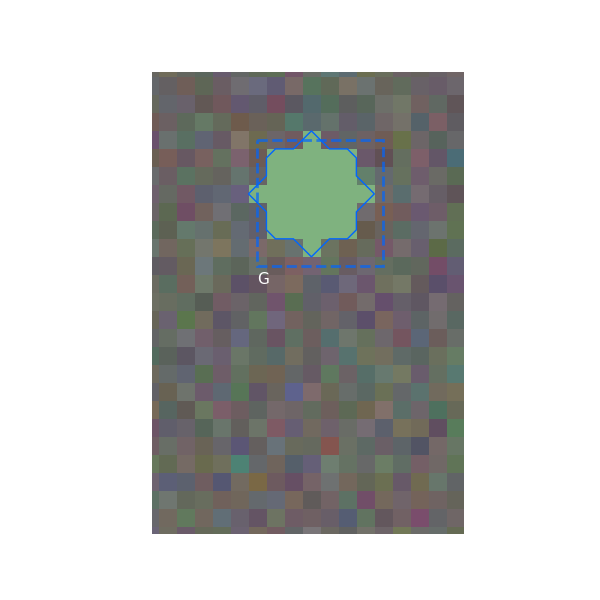

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16128, 4)         min:   -0.02218  max:    0.98986  float32


<IPython.core.display.Javascript object>


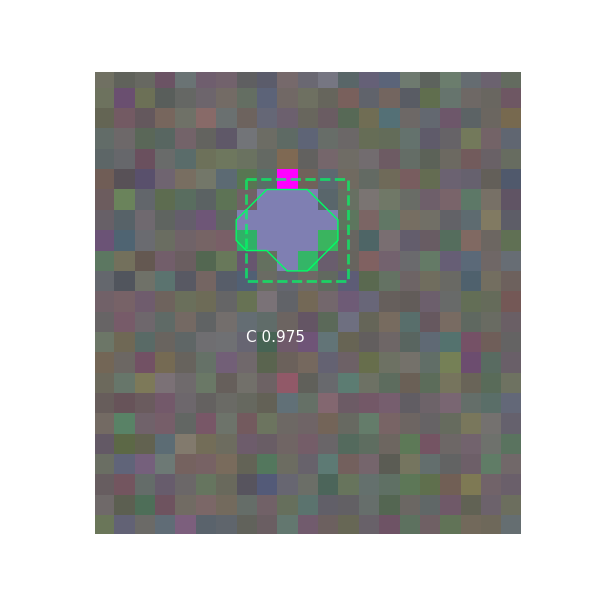

In [16]:
%matplotlib notebook
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
# image_id=33
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(12, 12))

visualize.display_instances2(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(6, 6))

#######
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], figsize=(6, 6))

In [14]:
gt_class_id

array([2, 3, 4, 4, 2, 2, 3, 2, 4, 3, 3, 4, 2, 3, 4, 4, 4, 3, 2, 1, 2, 2,
       1, 2, 1, 3, 2], dtype=int32)

In [11]:
r['class_ids']

array([], dtype=int32)

In [16]:
# r['rois']

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  float64
image_meta (17,) [  0 256 256   3 256 256   3   0   0 256 256   1   0   0   0   0   0]
(1, 17)
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16128, 4)         min:   -0.02218  max:    0.98986  float32


<IPython.core.display.Javascript object>


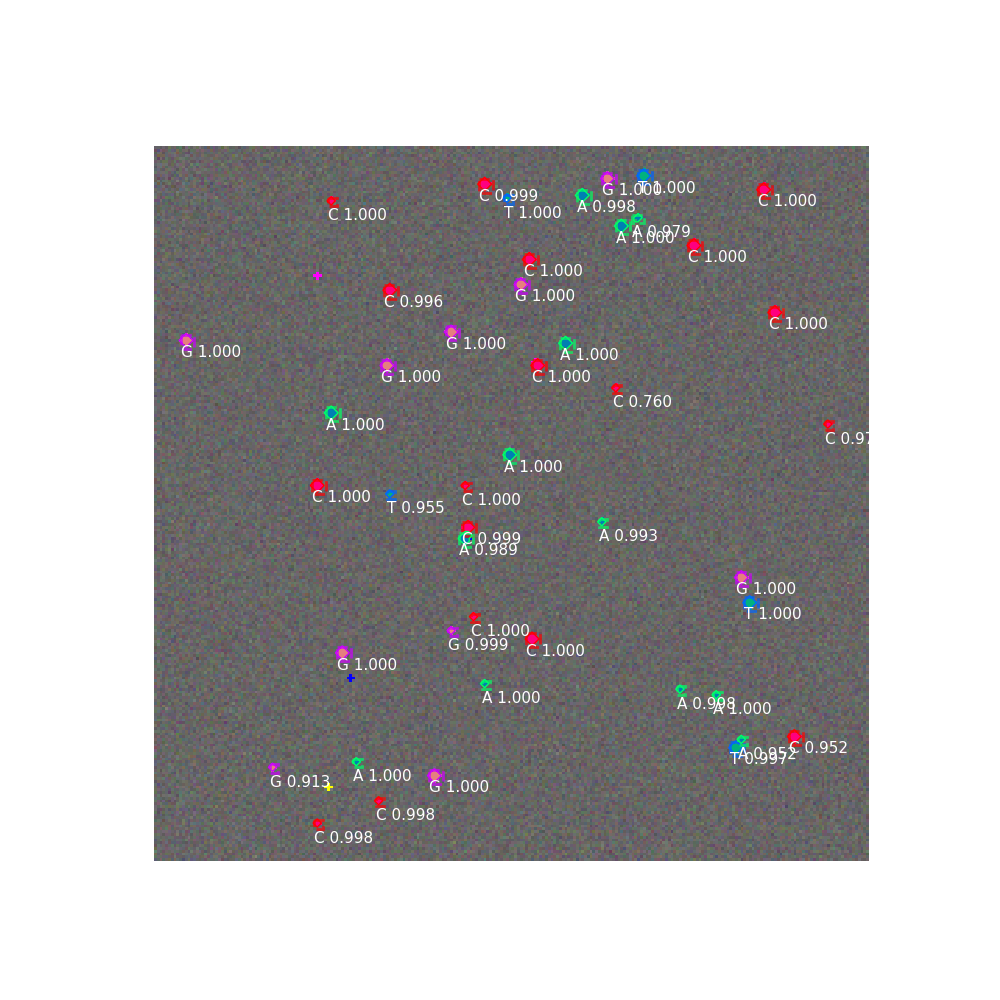

In [8]:
# %matplotlib notebook
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances2(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'],figsize=(10, 10))

In [30]:
results

[{'rois': array([], shape=(0, 4), dtype=int32),
  'class_ids': array([], dtype=int32),
  'scores': array([], dtype=float32),
  'masks': array([], shape=(128, 128, 0), dtype=float64)}]

In [60]:
# results

## Evaluation

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.95


Dimension(100)

# Clustering details:
- test both of the following, when doing clustering at each iteration:
    - Predict based on random initialization at first at the first iteration, then for the next one instialize clusters based on predictions 
    - At each iteration permute labels so that it has the minimum hamming distance to the predicted ones 

In [ ]:
reassigned_labels=reas_labels3(kmeans.labels_,\
                               pred_labels_arr[forg_index],kmeans.cluster_centers_,feat_arr_forg,nClust-1)